In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period_2000_2021/"
np.random.seed(881)

# Define the model that generates pair simulations.
yuima = importr("yuima")
n_ou_sim_string = """
n_sim_ou = function(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length){

  set.seed(random_seed)

  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  ou_model = setModel(drift=drift, diffusion=diffusion, 
                        time.variable = "t",
                        state.var=c("X1","X2"), solve.variable=c("X1","X2"))

  newsamp = setSampling(Initial=T0, Terminal=T, n=length)

  n_sim_ou_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    ou_sim = simulate(ou_model, 
                      true.par=list(
                        mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                        sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22), 
                      xinit=xinit_vec[i], sampling=newsamp)
    original_data = ou_sim@data@original.data
    one_sim_ou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_ou) = c('series1', 'series2')
    n_sim_ou_data[, (2*i-1):(2*i)] = one_sim_ou
  }
  return(n_sim_ou_data)
}
"""

n_ou_sim = SignatureTranslatedAnonymousPackage(n_ou_sim_string, "n_ou_sim")
def n_ou_simulation(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length):
    """num_sim simulations of bivariate Ornstein-Uhlenbeck process,
    length = length of one series
    """
    n_ou_sim_data = pd.DataFrame(
        n_ou_sim.n_sim_ou(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22,
                              sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                              xinit_vec=xinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_ou_sim_data

def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef


def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data


def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)


    n_sim_log_price = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3],
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    
    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)
    
    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_prices_cal.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_cal.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
num_sim, T0, T, length = real_stats.shape[0], 0, 2, real_price.shape[0]

n_real_stats = real_stats



initial0 = [1, 1, 1, 1, -1, -1, -1, -1]
begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), (0, None), (0, None), (0, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

[1]  1  1  1  1 -1 -1 -1 -1

return_mean1                         101.773776
return_mean2                          96.352766
return_sd1                           381.295073
return_sd2                           371.304942
return_skew1                         143.123570
return_skew2                         156.317882
return_kurtosis1                     156.010694
return_kurtosis2                     173.663675
return_autocorrelation_ts1_lag1       15.674237
return_autocorrelation_ts1_lag2       15.342536
return_autocorrelation_ts1_lag3       15.466070
return_autocorrelation_ts2_lag1       16.444044
return_autocorrelation_ts2_lag2       14.579628
return_autocorrelation_ts2_lag3       15.043308
return_correlation_ts1_lag_0         166.457237
return_correlation_ts1_lag_1          13.823015
return_correlation_ts1_lag_2          14.884088
return_correlation_ts1_lag_3          14.763330
return_correlation_ts2_lag_1          15.423882
return_correlation_ts2_lag_2          13.126919
return_corr

return_mean1                          83.242650
return_mean2                          96.434336
return_sd1                           393.947210
return_sd2                           374.998504
return_skew1                         143.464128
return_skew2                         150.969501
return_kurtosis1                     156.877963
return_kurtosis2                     174.577136
return_autocorrelation_ts1_lag1       19.590129
return_autocorrelation_ts1_lag2       19.237358
return_autocorrelation_ts1_lag3       17.405106
return_autocorrelation_ts2_lag1       16.113366
return_autocorrelation_ts2_lag2       15.111317
return_autocorrelation_ts2_lag3       15.165423
return_correlation_ts1_lag_0         165.311201
return_correlation_ts1_lag_1          14.542175
return_correlation_ts1_lag_2          15.573896
return_correlation_ts1_lag_3          15.264615
return_correlation_ts2_lag_1          15.904441
return_correlation_ts2_lag_2          14.535336
return_correlation_ts2_lag_3          14

return_mean1                          37.278289
return_mean2                          98.346700
return_sd1                           391.683390
return_sd2                           376.816250
return_skew1                         144.794129
return_skew2                         156.216885
return_kurtosis1                     155.818317
return_kurtosis2                     173.449691
return_autocorrelation_ts1_lag1       18.756617
return_autocorrelation_ts1_lag2       16.655854
return_autocorrelation_ts1_lag3       15.556820
return_autocorrelation_ts2_lag1       16.876208
return_autocorrelation_ts2_lag2       15.132023
return_autocorrelation_ts2_lag3       13.929848
return_correlation_ts1_lag_0         166.076295
return_correlation_ts1_lag_1          15.562595
return_correlation_ts1_lag_2          15.000337
return_correlation_ts1_lag_3          14.399961
return_correlation_ts2_lag_1          16.565604
return_correlation_ts2_lag_2          13.546716
return_correlation_ts2_lag_3          13

return_mean1                          36.699819
return_mean2                          95.075463
return_sd1                           388.607665
return_sd2                           375.968189
return_skew1                         141.979980
return_skew2                         154.840375
return_kurtosis1                     156.285324
return_kurtosis2                     173.943707
return_autocorrelation_ts1_lag1       20.166055
return_autocorrelation_ts1_lag2       16.421477
return_autocorrelation_ts1_lag3       15.428939
return_autocorrelation_ts2_lag1       16.733163
return_autocorrelation_ts2_lag2       15.391616
return_autocorrelation_ts2_lag3       15.115655
return_correlation_ts1_lag_0         166.076709
return_correlation_ts1_lag_1          15.843140
return_correlation_ts1_lag_2          14.163066
return_correlation_ts1_lag_3          14.395253
return_correlation_ts2_lag_1          16.388880
return_correlation_ts2_lag_2          13.482025
return_correlation_ts2_lag_3          14

return_mean1                         826.036584
return_mean2                          99.773416
return_sd1                           483.008604
return_sd2                           377.189795
return_skew1                         145.945588
return_skew2                         153.291683
return_kurtosis1                     158.181921
return_kurtosis2                     174.635892
return_autocorrelation_ts1_lag1       64.851161
return_autocorrelation_ts1_lag2       61.373659
return_autocorrelation_ts1_lag3       58.459055
return_autocorrelation_ts2_lag1       18.008735
return_autocorrelation_ts2_lag2       15.596525
return_autocorrelation_ts2_lag3       15.075525
return_correlation_ts1_lag_0         147.130186
return_correlation_ts1_lag_1          20.259818
return_correlation_ts1_lag_2          19.529469
return_correlation_ts1_lag_3          18.546942
return_correlation_ts2_lag_1          21.147218
return_correlation_ts2_lag_2          17.755606
return_correlation_ts2_lag_3          16

return_mean1                          44.851810
return_mean2                          96.610821
return_sd1                           386.934850
return_sd2                           374.448855
return_skew1                         142.689024
return_skew2                         155.576127
return_kurtosis1                     156.629040
return_kurtosis2                     174.276958
return_autocorrelation_ts1_lag1       18.795824
return_autocorrelation_ts1_lag2       16.582861
return_autocorrelation_ts1_lag3       15.587627
return_autocorrelation_ts2_lag1       17.541671
return_autocorrelation_ts2_lag2       15.948752
return_autocorrelation_ts2_lag3       15.490214
return_correlation_ts1_lag_0         166.247578
return_correlation_ts1_lag_1          14.682431
return_correlation_ts1_lag_2          15.493319
return_correlation_ts1_lag_3          15.401780
return_correlation_ts2_lag_1          17.009115
return_correlation_ts2_lag_2          13.814659
return_correlation_ts2_lag_3          14

return_mean1                          37.910197
return_mean2                          96.678983
return_sd1                           387.194236
return_sd2                           375.357220
return_skew1                         144.073750
return_skew2                         154.002842
return_kurtosis1                     156.049908
return_kurtosis2                     173.663368
return_autocorrelation_ts1_lag1       17.886204
return_autocorrelation_ts1_lag2       15.882185
return_autocorrelation_ts1_lag3       15.291712
return_autocorrelation_ts2_lag1       16.837086
return_autocorrelation_ts2_lag2       14.762537
return_autocorrelation_ts2_lag3       14.035409
return_correlation_ts1_lag_0         166.168381
return_correlation_ts1_lag_1          15.118634
return_correlation_ts1_lag_2          14.745363
return_correlation_ts1_lag_3          15.063380
return_correlation_ts2_lag_1          16.284245
return_correlation_ts2_lag_2          14.159728
return_correlation_ts2_lag_3          14

return_mean1                          36.958174
return_mean2                          95.505565
return_sd1                           389.203359
return_sd2                           375.766362
return_skew1                         139.525242
return_skew2                         153.366137
return_kurtosis1                     155.955734
return_kurtosis2                     173.552455
return_autocorrelation_ts1_lag1       17.935714
return_autocorrelation_ts1_lag2       17.105717
return_autocorrelation_ts1_lag3       15.543862
return_autocorrelation_ts2_lag1       17.343610
return_autocorrelation_ts2_lag2       15.852082
return_autocorrelation_ts2_lag3       14.612443
return_correlation_ts1_lag_0         166.180197
return_correlation_ts1_lag_1          15.407266
return_correlation_ts1_lag_2          15.747870
return_correlation_ts1_lag_3          15.164236
return_correlation_ts2_lag_1          15.738640
return_correlation_ts2_lag_2          14.146295
return_correlation_ts2_lag_3          14

return_mean1                          37.924678
return_mean2                          88.335600
return_sd1                           388.591032
return_sd2                           376.165544
return_skew1                         143.818010
return_skew2                         152.154144
return_kurtosis1                     156.951858
return_kurtosis2                     174.574106
return_autocorrelation_ts1_lag1       18.540763
return_autocorrelation_ts1_lag2       15.825335
return_autocorrelation_ts1_lag3       15.925035
return_autocorrelation_ts2_lag1       16.775828
return_autocorrelation_ts2_lag2       15.325813
return_autocorrelation_ts2_lag3       15.519567
return_correlation_ts1_lag_0         166.219694
return_correlation_ts1_lag_1          15.436691
return_correlation_ts1_lag_2          14.394305
return_correlation_ts1_lag_3          15.291195
return_correlation_ts2_lag_1          16.073335
return_correlation_ts2_lag_2          14.959750
return_correlation_ts2_lag_3          14

return_mean1                          38.084723
return_mean2                          51.458995
return_sd1                           390.244251
return_sd2                           377.969458
return_skew1                         142.881042
return_skew2                         153.789205
return_kurtosis1                     156.797646
return_kurtosis2                     174.411375
return_autocorrelation_ts1_lag1       17.399755
return_autocorrelation_ts1_lag2       15.905296
return_autocorrelation_ts1_lag3       16.068315
return_autocorrelation_ts2_lag1       16.941941
return_autocorrelation_ts2_lag2       16.250187
return_autocorrelation_ts2_lag3       16.102232
return_correlation_ts1_lag_0         166.414467
return_correlation_ts1_lag_1          14.708093
return_correlation_ts1_lag_2          15.530783
return_correlation_ts1_lag_3          15.569951
return_correlation_ts2_lag_1          16.051597
return_correlation_ts2_lag_2          14.058171
return_correlation_ts2_lag_3          14

return_mean1                          38.725003
return_mean2                          50.576113
return_sd1                           385.934594
return_sd2                           375.723202
return_skew1                         143.776598
return_skew2                         155.557410
return_kurtosis1                     156.413591
return_kurtosis2                     174.022118
return_autocorrelation_ts1_lag1       18.988815
return_autocorrelation_ts1_lag2       16.130868
return_autocorrelation_ts1_lag3       16.020764
return_autocorrelation_ts2_lag1       17.871506
return_autocorrelation_ts2_lag2       16.664296
return_autocorrelation_ts2_lag3       14.673195
return_correlation_ts1_lag_0         166.414353
return_correlation_ts1_lag_1          16.968846
return_correlation_ts1_lag_2          15.192043
return_correlation_ts1_lag_3          15.445201
return_correlation_ts2_lag_1          16.679378
return_correlation_ts2_lag_2          14.976837
return_correlation_ts2_lag_3          14

return_mean1                          40.080052
return_mean2                          50.616495
return_sd1                           388.243455
return_sd2                           376.376662
return_skew1                         144.744580
return_skew2                         157.499560
return_kurtosis1                     156.345176
return_kurtosis2                     174.009061
return_autocorrelation_ts1_lag1       17.986173
return_autocorrelation_ts1_lag2       16.312566
return_autocorrelation_ts1_lag3       14.882565
return_autocorrelation_ts2_lag1       17.313138
return_autocorrelation_ts2_lag2       15.385600
return_autocorrelation_ts2_lag3       15.598214
return_correlation_ts1_lag_0         166.416118
return_correlation_ts1_lag_1          15.635448
return_correlation_ts1_lag_2          15.669644
return_correlation_ts1_lag_3          14.717667
return_correlation_ts2_lag_1          16.701537
return_correlation_ts2_lag_2          13.999402
return_correlation_ts2_lag_3          14

return_mean1                          36.399702
return_mean2                          52.211759
return_sd1                           386.313662
return_sd2                           375.439112
return_skew1                         144.729935
return_skew2                         153.341059
return_kurtosis1                     156.337500
return_kurtosis2                     174.016840
return_autocorrelation_ts1_lag1       20.003185
return_autocorrelation_ts1_lag2       15.249269
return_autocorrelation_ts1_lag3       15.842969
return_autocorrelation_ts2_lag1       17.558464
return_autocorrelation_ts2_lag2       16.437642
return_autocorrelation_ts2_lag3       15.523469
return_correlation_ts1_lag_0         166.414865
return_correlation_ts1_lag_1          16.364685
return_correlation_ts1_lag_2          14.435221
return_correlation_ts1_lag_3          15.760394
return_correlation_ts2_lag_1          16.999700
return_correlation_ts2_lag_2          13.736629
return_correlation_ts2_lag_3          14

return_mean1                          37.302801
return_mean2                         100.971258
return_sd1                           389.184832
return_sd2                           390.097777
return_skew1                         144.133714
return_skew2                         151.925521
return_kurtosis1                     156.663255
return_kurtosis2                     174.364826
return_autocorrelation_ts1_lag1       17.928158
return_autocorrelation_ts1_lag2       16.278025
return_autocorrelation_ts1_lag3       15.171404
return_autocorrelation_ts2_lag1       21.617438
return_autocorrelation_ts2_lag2       20.039600
return_autocorrelation_ts2_lag3       18.556832
return_correlation_ts1_lag_0         165.499913
return_correlation_ts1_lag_1          17.040236
return_correlation_ts1_lag_2          17.208601
return_correlation_ts1_lag_3          16.598019
return_correlation_ts2_lag_1          18.280100
return_correlation_ts2_lag_2          14.670182
return_correlation_ts2_lag_3          15

return_mean1                          40.239700
return_mean2                          37.085213
return_sd1                           388.092532
return_sd2                           375.575524
return_skew1                         143.824154
return_skew2                         154.279486
return_kurtosis1                     156.275132
return_kurtosis2                     173.893846
return_autocorrelation_ts1_lag1       18.484200
return_autocorrelation_ts1_lag2       16.715435
return_autocorrelation_ts1_lag3       15.302833
return_autocorrelation_ts2_lag1       17.271740
return_autocorrelation_ts2_lag2       15.547404
return_autocorrelation_ts2_lag3       15.080659
return_correlation_ts1_lag_0         166.312846
return_correlation_ts1_lag_1          15.692177
return_correlation_ts1_lag_2          15.246446
return_correlation_ts1_lag_3          15.329398
return_correlation_ts2_lag_1          15.614266
return_correlation_ts2_lag_2          14.046698
return_correlation_ts2_lag_3          14

return_mean1                          36.023016
return_mean2                          49.649328
return_sd1                           388.797692
return_sd2                           378.823141
return_skew1                         141.779764
return_skew2                         155.459622
return_kurtosis1                     156.794023
return_kurtosis2                     174.445844
return_autocorrelation_ts1_lag1       17.759884
return_autocorrelation_ts1_lag2       16.151885
return_autocorrelation_ts1_lag3       14.914000
return_autocorrelation_ts2_lag1       17.276450
return_autocorrelation_ts2_lag2       16.237541
return_autocorrelation_ts2_lag3       14.877914
return_correlation_ts1_lag_0         166.414888
return_correlation_ts1_lag_1          15.507319
return_correlation_ts1_lag_2          14.794371
return_correlation_ts1_lag_3          15.033964
return_correlation_ts2_lag_1          16.043047
return_correlation_ts2_lag_2          13.977936
return_correlation_ts2_lag_3          14

return_mean1                          37.212290
return_mean2                          54.036166
return_sd1                           386.095048
return_sd2                           377.136762
return_skew1                         143.240813
return_skew2                         157.527396
return_kurtosis1                     156.378270
return_kurtosis2                     173.958298
return_autocorrelation_ts1_lag1       18.588267
return_autocorrelation_ts1_lag2       17.316221
return_autocorrelation_ts1_lag3       14.530822
return_autocorrelation_ts2_lag1       17.540131
return_autocorrelation_ts2_lag2       16.749000
return_autocorrelation_ts2_lag3       15.087195
return_correlation_ts1_lag_0         166.416404
return_correlation_ts1_lag_1          15.697688
return_correlation_ts1_lag_2          17.017565
return_correlation_ts1_lag_3          14.143816
return_correlation_ts2_lag_1          17.288105
return_correlation_ts2_lag_2          14.887128
return_correlation_ts2_lag_3          13

return_mean1                          38.743667
return_mean2                          50.896970
return_sd1                           384.304530
return_sd2                           374.373459
return_skew1                         143.259911
return_skew2                         152.545425
return_kurtosis1                     157.027811
return_kurtosis2                     174.665280
return_autocorrelation_ts1_lag1       18.171412
return_autocorrelation_ts1_lag2       15.521339
return_autocorrelation_ts1_lag3       14.987379
return_autocorrelation_ts2_lag1       16.773154
return_autocorrelation_ts2_lag2       15.312091
return_autocorrelation_ts2_lag3       15.332774
return_correlation_ts1_lag_0         166.414054
return_correlation_ts1_lag_1          15.760491
return_correlation_ts1_lag_2          15.306673
return_correlation_ts1_lag_3          14.929138
return_correlation_ts2_lag_1          16.414754
return_correlation_ts2_lag_2          13.451204
return_correlation_ts2_lag_3          14

return_mean1                          39.240284
return_mean2                          51.665555
return_sd1                           387.872838
return_sd2                           377.080497
return_skew1                         143.945140
return_skew2                         152.753338
return_kurtosis1                     156.810891
return_kurtosis2                     174.458227
return_autocorrelation_ts1_lag1       18.745044
return_autocorrelation_ts1_lag2       17.051472
return_autocorrelation_ts1_lag3       16.645036
return_autocorrelation_ts2_lag1       17.395451
return_autocorrelation_ts2_lag2       15.938835
return_autocorrelation_ts2_lag3       15.531996
return_correlation_ts1_lag_0         166.416686
return_correlation_ts1_lag_1          16.268903
return_correlation_ts1_lag_2          15.958137
return_correlation_ts1_lag_3          15.375547
return_correlation_ts2_lag_1          15.765960
return_correlation_ts2_lag_2          15.165903
return_correlation_ts2_lag_3          15

return_mean1                          39.627345
return_mean2                          52.633608
return_sd1                           388.321869
return_sd2                           376.849278
return_skew1                         141.361435
return_skew2                         154.662309
return_kurtosis1                     156.724724
return_kurtosis2                     174.322520
return_autocorrelation_ts1_lag1       17.929201
return_autocorrelation_ts1_lag2       16.584488
return_autocorrelation_ts1_lag3       15.123993
return_autocorrelation_ts2_lag1       17.262602
return_autocorrelation_ts2_lag2       16.139750
return_autocorrelation_ts2_lag3       14.588229
return_correlation_ts1_lag_0         166.415164
return_correlation_ts1_lag_1          14.962037
return_correlation_ts1_lag_2          16.126997
return_correlation_ts1_lag_3          15.095646
return_correlation_ts2_lag_1          16.714352
return_correlation_ts2_lag_2          14.292830
return_correlation_ts2_lag_3          14

return_mean1                          37.258493
return_mean2                          50.440258
return_sd1                           389.354023
return_sd2                           377.989972
return_skew1                         140.103583
return_skew2                         151.702213
return_kurtosis1                     156.366999
return_kurtosis2                     174.034237
return_autocorrelation_ts1_lag1       18.022989
return_autocorrelation_ts1_lag2       15.879124
return_autocorrelation_ts1_lag3       15.765287
return_autocorrelation_ts2_lag1       16.179013
return_autocorrelation_ts2_lag2       16.279249
return_autocorrelation_ts2_lag3       14.894516
return_correlation_ts1_lag_0         166.416208
return_correlation_ts1_lag_1          14.708841
return_correlation_ts1_lag_2          14.643907
return_correlation_ts1_lag_3          15.411889
return_correlation_ts2_lag_1          16.991300
return_correlation_ts2_lag_2          14.442030
return_correlation_ts2_lag_3          13

return_mean1                          38.578285
return_mean2                          51.772692
return_sd1                           386.626854
return_sd2                           376.580274
return_skew1                         143.814679
return_skew2                         155.434499
return_kurtosis1                     156.873764
return_kurtosis2                     174.552828
return_autocorrelation_ts1_lag1       17.748388
return_autocorrelation_ts1_lag2       15.741428
return_autocorrelation_ts1_lag3       15.258320
return_autocorrelation_ts2_lag1       17.167184
return_autocorrelation_ts2_lag2       15.577179
return_autocorrelation_ts2_lag3       16.152934
return_correlation_ts1_lag_0         166.414164
return_correlation_ts1_lag_1          15.022228
return_correlation_ts1_lag_2          14.868161
return_correlation_ts1_lag_3          15.822556
return_correlation_ts2_lag_1          15.230469
return_correlation_ts2_lag_2          13.856083
return_correlation_ts2_lag_3          15

return_mean1                          36.349472
return_mean2                          50.858386
return_sd1                           389.363442
return_sd2                           377.252423
return_skew1                         149.383263
return_skew2                         152.758666
return_kurtosis1                     156.814078
return_kurtosis2                     174.486589
return_autocorrelation_ts1_lag1       17.796100
return_autocorrelation_ts1_lag2       15.467624
return_autocorrelation_ts1_lag3       14.849838
return_autocorrelation_ts2_lag1       17.253544
return_autocorrelation_ts2_lag2       16.301450
return_autocorrelation_ts2_lag3       14.897436
return_correlation_ts1_lag_0         166.416719
return_correlation_ts1_lag_1          15.242398
return_correlation_ts1_lag_2          15.000499
return_correlation_ts1_lag_3          14.088688
return_correlation_ts2_lag_1          16.749638
return_correlation_ts2_lag_2          13.944407
return_correlation_ts2_lag_3          14

return_mean1                          38.691366
return_mean2                          52.981082
return_sd1                           387.903212
return_sd2                           377.273210
return_skew1                         144.530013
return_skew2                         151.879864
return_kurtosis1                     156.408025
return_kurtosis2                     174.036993
return_autocorrelation_ts1_lag1       18.982512
return_autocorrelation_ts1_lag2       16.641854
return_autocorrelation_ts1_lag3       15.586534
return_autocorrelation_ts2_lag1       17.673034
return_autocorrelation_ts2_lag2       15.736909
return_autocorrelation_ts2_lag3       15.612148
return_correlation_ts1_lag_0         166.417372
return_correlation_ts1_lag_1          15.803114
return_correlation_ts1_lag_2          15.472830
return_correlation_ts1_lag_3          15.758963
return_correlation_ts2_lag_1          17.332722
return_correlation_ts2_lag_2          14.686640
return_correlation_ts2_lag_3          15

return_mean1                          36.962287
return_mean2                          54.195643
return_sd1                           387.318061
return_sd2                           377.867070
return_skew1                         146.338436
return_skew2                         153.770016
return_kurtosis1                     155.876508
return_kurtosis2                     173.545603
return_autocorrelation_ts1_lag1       18.522506
return_autocorrelation_ts1_lag2       17.011898
return_autocorrelation_ts1_lag3       15.546288
return_autocorrelation_ts2_lag1       16.988942
return_autocorrelation_ts2_lag2       16.393202
return_autocorrelation_ts2_lag3       15.278652
return_correlation_ts1_lag_0         166.417049
return_correlation_ts1_lag_1          14.827333
return_correlation_ts1_lag_2          15.620760
return_correlation_ts1_lag_3          14.867100
return_correlation_ts2_lag_1          16.240275
return_correlation_ts2_lag_2          15.146609
return_correlation_ts2_lag_3          14

return_mean1                          35.709055
return_mean2                          51.731874
return_sd1                           213.434914
return_sd2                           376.440260
return_skew1                         145.372594
return_skew2                         154.844150
return_kurtosis1                     156.661816
return_kurtosis2                     174.574587
return_autocorrelation_ts1_lag1       23.246032
return_autocorrelation_ts1_lag2       20.830429
return_autocorrelation_ts1_lag3       18.643771
return_autocorrelation_ts2_lag1       17.706038
return_autocorrelation_ts2_lag2       17.365833
return_autocorrelation_ts2_lag3       14.793697
return_correlation_ts1_lag_0         101.651428
return_correlation_ts1_lag_1          16.481412
return_correlation_ts1_lag_2          17.598495
return_correlation_ts1_lag_3          16.469597
return_correlation_ts2_lag_1          18.693647
return_correlation_ts2_lag_2          15.361717
return_correlation_ts2_lag_3          15

return_mean1                          35.746292
return_mean2                          52.208650
return_sd1                           214.279027
return_sd2                           379.518160
return_skew1                         146.178884
return_skew2                         153.219575
return_kurtosis1                     156.269298
return_kurtosis2                     173.972194
return_autocorrelation_ts1_lag1       22.465005
return_autocorrelation_ts1_lag2       20.835904
return_autocorrelation_ts1_lag3       18.440733
return_autocorrelation_ts2_lag1       16.236137
return_autocorrelation_ts2_lag2       16.613394
return_autocorrelation_ts2_lag3       14.897141
return_correlation_ts1_lag_0         107.760242
return_correlation_ts1_lag_1          16.126150
return_correlation_ts1_lag_2          18.259422
return_correlation_ts1_lag_3          15.657248
return_correlation_ts2_lag_1          18.030248
return_correlation_ts2_lag_2          14.959929
return_correlation_ts2_lag_3          14

return_mean1                          37.452718
return_mean2                          48.087335
return_sd1                           210.719665
return_sd2                           375.360823
return_skew1                         143.232616
return_skew2                         154.842187
return_kurtosis1                     156.059448
return_kurtosis2                     174.379366
return_autocorrelation_ts1_lag1       23.286279
return_autocorrelation_ts1_lag2       20.022775
return_autocorrelation_ts1_lag3       19.068035
return_autocorrelation_ts2_lag1       17.591998
return_autocorrelation_ts2_lag2       16.143203
return_autocorrelation_ts2_lag3       15.279767
return_correlation_ts1_lag_0         101.809577
return_correlation_ts1_lag_1          17.398593
return_correlation_ts1_lag_2          16.038130
return_correlation_ts1_lag_3          16.372285
return_correlation_ts2_lag_1          18.575264
return_correlation_ts2_lag_2          15.697425
return_correlation_ts2_lag_3          15

return_mean1                          36.003027
return_mean2                          51.840701
return_sd1                           215.152638
return_sd2                           378.888664
return_skew1                         141.713530
return_skew2                         156.243571
return_kurtosis1                     156.016769
return_kurtosis2                     173.802248
return_autocorrelation_ts1_lag1       23.878371
return_autocorrelation_ts1_lag2       20.740363
return_autocorrelation_ts1_lag3       18.251589
return_autocorrelation_ts2_lag1       18.036555
return_autocorrelation_ts2_lag2       15.727161
return_autocorrelation_ts2_lag3       14.534689
return_correlation_ts1_lag_0         102.159080
return_correlation_ts1_lag_1          16.980568
return_correlation_ts1_lag_2          16.987979
return_correlation_ts1_lag_3          16.269523
return_correlation_ts2_lag_1          18.495901
return_correlation_ts2_lag_2          14.853137
return_correlation_ts2_lag_3          15

return_mean1                          36.853294
return_mean2                          51.801605
return_sd1                           213.509239
return_sd2                           376.432217
return_skew1                         140.449050
return_skew2                         153.594615
return_kurtosis1                     156.395556
return_kurtosis2                     174.462507
return_autocorrelation_ts1_lag1       24.087867
return_autocorrelation_ts1_lag2       19.197236
return_autocorrelation_ts1_lag3       18.105799
return_autocorrelation_ts2_lag1       17.724927
return_autocorrelation_ts2_lag2       15.250352
return_autocorrelation_ts2_lag3       14.395170
return_correlation_ts1_lag_0         102.062489
return_correlation_ts1_lag_1          17.418067
return_correlation_ts1_lag_2          15.083808
return_correlation_ts1_lag_3          16.403901
return_correlation_ts2_lag_1          17.762429
return_correlation_ts2_lag_2          14.885542
return_correlation_ts2_lag_3          14

return_mean1                          37.605226
return_mean2                          53.481683
return_sd1                           211.163733
return_sd2                           377.789128
return_skew1                         144.679124
return_skew2                         152.289526
return_kurtosis1                     155.988590
return_kurtosis2                     173.713347
return_autocorrelation_ts1_lag1       23.099541
return_autocorrelation_ts1_lag2       20.797158
return_autocorrelation_ts1_lag3       18.605744
return_autocorrelation_ts2_lag1       17.156062
return_autocorrelation_ts2_lag2       15.830393
return_autocorrelation_ts2_lag3       15.540923
return_correlation_ts1_lag_0         101.619854
return_correlation_ts1_lag_1          16.378388
return_correlation_ts1_lag_2          17.099538
return_correlation_ts1_lag_3          16.432829
return_correlation_ts2_lag_1          18.229406
return_correlation_ts2_lag_2          15.328155
return_correlation_ts2_lag_3          15

return_mean1                          35.692740
return_mean2                          52.708410
return_sd1                           165.530222
return_sd2                           376.758232
return_skew1                         146.992709
return_skew2                         155.630689
return_kurtosis1                     156.892294
return_kurtosis2                     174.249333
return_autocorrelation_ts1_lag1       34.757545
return_autocorrelation_ts1_lag2       30.588914
return_autocorrelation_ts1_lag3       28.022500
return_autocorrelation_ts2_lag1       17.765741
return_autocorrelation_ts2_lag2       16.667114
return_autocorrelation_ts2_lag3       15.399500
return_correlation_ts1_lag_0         103.519247
return_correlation_ts1_lag_1          19.174802
return_correlation_ts1_lag_2          17.812708
return_correlation_ts1_lag_3          17.341335
return_correlation_ts2_lag_1          19.811468
return_correlation_ts2_lag_2          17.254318
return_correlation_ts2_lag_3          16

return_mean1                          35.211868
return_mean2                          52.205450
return_sd1                           174.618262
return_sd2                           376.287921
return_skew1                         144.744242
return_skew2                         152.789560
return_kurtosis1                     156.474543
return_kurtosis2                     174.547442
return_autocorrelation_ts1_lag1       27.388764
return_autocorrelation_ts1_lag2       25.491448
return_autocorrelation_ts1_lag3       22.657517
return_autocorrelation_ts2_lag1       17.158012
return_autocorrelation_ts2_lag2       16.498805
return_autocorrelation_ts2_lag3       15.415792
return_correlation_ts1_lag_0         102.179177
return_correlation_ts1_lag_1          17.111410
return_correlation_ts1_lag_2          17.936879
return_correlation_ts1_lag_3          15.707349
return_correlation_ts2_lag_1          18.779878
return_correlation_ts2_lag_2          17.462442
return_correlation_ts2_lag_3          16

return_mean1                          36.729306
return_mean2                          51.271923
return_sd1                           176.454221
return_sd2                           228.528948
return_skew1                         142.653339
return_skew2                         153.205408
return_kurtosis1                     156.266746
return_kurtosis2                     173.937745
return_autocorrelation_ts1_lag1       27.819050
return_autocorrelation_ts1_lag2       25.895846
return_autocorrelation_ts1_lag3       22.408596
return_autocorrelation_ts2_lag1       20.526410
return_autocorrelation_ts2_lag2       19.108664
return_autocorrelation_ts2_lag3       16.809233
return_correlation_ts1_lag_0         162.980161
return_correlation_ts1_lag_1          20.566745
return_correlation_ts1_lag_2          20.408827
return_correlation_ts1_lag_3          18.679282
return_correlation_ts2_lag_1          22.046020
return_correlation_ts2_lag_2          19.011691
return_correlation_ts2_lag_3          17

return_mean1                          34.481687
return_mean2                          51.768799
return_sd1                           174.461103
return_sd2                           278.315687
return_skew1                         143.438955
return_skew2                         153.328662
return_kurtosis1                     156.091752
return_kurtosis2                     173.739109
return_autocorrelation_ts1_lag1       26.530735
return_autocorrelation_ts1_lag2       24.941238
return_autocorrelation_ts1_lag3       23.326711
return_autocorrelation_ts2_lag1       18.591086
return_autocorrelation_ts2_lag2       16.639934
return_autocorrelation_ts2_lag3       17.057895
return_correlation_ts1_lag_0         134.551727
return_correlation_ts1_lag_1          17.515931
return_correlation_ts1_lag_2          18.584396
return_correlation_ts1_lag_3          18.253492
return_correlation_ts2_lag_1          20.105241
return_correlation_ts2_lag_2          16.962551
return_correlation_ts2_lag_3          17

return_mean1                          34.479412
return_mean2                          51.067231
return_sd1                           177.465123
return_sd2                           280.679247
return_skew1                         141.800365
return_skew2                         153.812664
return_kurtosis1                     157.070586
return_kurtosis2                     173.780068
return_autocorrelation_ts1_lag1       26.907869
return_autocorrelation_ts1_lag2       24.099969
return_autocorrelation_ts1_lag3       22.286623
return_autocorrelation_ts2_lag1       18.672055
return_autocorrelation_ts2_lag2       16.894365
return_autocorrelation_ts2_lag3       16.310403
return_correlation_ts1_lag_0         134.430601
return_correlation_ts1_lag_1          18.516937
return_correlation_ts1_lag_2          18.219775
return_correlation_ts1_lag_3          18.004282
return_correlation_ts2_lag_1          20.072130
return_correlation_ts2_lag_2          17.208567
return_correlation_ts2_lag_3          16

return_mean1                          35.652592
return_mean2                          50.548452
return_sd1                           175.226723
return_sd2                           283.117487
return_skew1                         142.993102
return_skew2                         152.699797
return_kurtosis1                     156.753609
return_kurtosis2                     174.536489
return_autocorrelation_ts1_lag1       27.684573
return_autocorrelation_ts1_lag2       25.391080
return_autocorrelation_ts1_lag3       22.522868
return_autocorrelation_ts2_lag1       17.866495
return_autocorrelation_ts2_lag2       16.996851
return_autocorrelation_ts2_lag3       15.843886
return_correlation_ts1_lag_0         134.226327
return_correlation_ts1_lag_1          19.243216
return_correlation_ts1_lag_2          18.605533
return_correlation_ts1_lag_3          16.939961
return_correlation_ts2_lag_1          19.771323
return_correlation_ts2_lag_2          17.684750
return_correlation_ts2_lag_3          16

return_mean1                          35.369960
return_mean2                          49.091223
return_sd1                           177.802590
return_sd2                           282.061516
return_skew1                         142.418105
return_skew2                         151.207772
return_kurtosis1                     156.476427
return_kurtosis2                     174.851185
return_autocorrelation_ts1_lag1       27.754420
return_autocorrelation_ts1_lag2       24.144034
return_autocorrelation_ts1_lag3       22.847092
return_autocorrelation_ts2_lag1       18.056126
return_autocorrelation_ts2_lag2       17.181521
return_autocorrelation_ts2_lag3       15.246327
return_correlation_ts1_lag_0         134.474924
return_correlation_ts1_lag_1          18.792515
return_correlation_ts1_lag_2          17.993746
return_correlation_ts1_lag_3          17.204209
return_correlation_ts2_lag_1          19.971452
return_correlation_ts2_lag_2          16.798001
return_correlation_ts2_lag_3          16

return_mean1                          36.778385
return_mean2                          50.976662
return_sd1                           176.081502
return_sd2                           180.441080
return_skew1                         142.013331
return_skew2                         153.900168
return_kurtosis1                     156.855947
return_kurtosis2                     174.031207
return_autocorrelation_ts1_lag1       27.250091
return_autocorrelation_ts1_lag2       25.513443
return_autocorrelation_ts1_lag3       23.076693
return_autocorrelation_ts2_lag1       30.687472
return_autocorrelation_ts2_lag2       28.223514
return_autocorrelation_ts2_lag3       26.987815
return_correlation_ts1_lag_0          34.412711
return_correlation_ts1_lag_1          25.216582
return_correlation_ts1_lag_2          25.285350
return_correlation_ts1_lag_3          24.273344
return_correlation_ts2_lag_1          26.273539
return_correlation_ts2_lag_2          24.269964
return_correlation_ts2_lag_3          24

return_mean1                          34.338416
return_mean2                          49.811460
return_sd1                           175.802610
return_sd2                           182.609667
return_skew1                         143.645720
return_skew2                         153.108664
return_kurtosis1                     156.166140
return_kurtosis2                     174.366662
return_autocorrelation_ts1_lag1       26.848463
return_autocorrelation_ts1_lag2       25.581411
return_autocorrelation_ts1_lag3       24.035924
return_autocorrelation_ts2_lag1       29.843729
return_autocorrelation_ts2_lag2       29.308594
return_autocorrelation_ts2_lag3       27.468385
return_correlation_ts1_lag_0          35.938044
return_correlation_ts1_lag_1          24.716968
return_correlation_ts1_lag_2          26.465056
return_correlation_ts1_lag_3          24.091037
return_correlation_ts2_lag_1          27.314636
return_correlation_ts2_lag_2          25.405334
return_correlation_ts2_lag_3          23

return_mean1                          35.652268
return_mean2                          49.802400
return_sd1                           175.198737
return_sd2                           182.687696
return_skew1                         143.868039
return_skew2                         151.098494
return_kurtosis1                     156.417950
return_kurtosis2                     174.006699
return_autocorrelation_ts1_lag1       28.317598
return_autocorrelation_ts1_lag2       23.748754
return_autocorrelation_ts1_lag3       22.786634
return_autocorrelation_ts2_lag1       31.136313
return_autocorrelation_ts2_lag2       29.515531
return_autocorrelation_ts2_lag3       26.689266
return_correlation_ts1_lag_0          34.901143
return_correlation_ts1_lag_1          26.513766
return_correlation_ts1_lag_2          25.670210
return_correlation_ts1_lag_3          23.865829
return_correlation_ts2_lag_1          27.925508
return_correlation_ts2_lag_2          25.209315
return_correlation_ts2_lag_3          23

return_mean1                         149.894337
return_mean2                          33.276893
return_sd1                           166.691118
return_sd2                           233.670007
return_skew1                         143.513560
return_skew2                         147.941692
return_kurtosis1                     157.381759
return_kurtosis2                     175.359498
return_autocorrelation_ts1_lag1       52.244109
return_autocorrelation_ts1_lag2       49.359054
return_autocorrelation_ts1_lag3       47.460187
return_autocorrelation_ts2_lag1       74.728335
return_autocorrelation_ts2_lag2       74.522677
return_autocorrelation_ts2_lag3       72.069765
return_correlation_ts1_lag_0          30.915424
return_correlation_ts1_lag_1          58.336505
return_correlation_ts1_lag_2          59.907212
return_correlation_ts1_lag_3          57.670947
return_correlation_ts2_lag_1          61.143527
return_correlation_ts2_lag_2          57.868161
return_correlation_ts2_lag_3          56

return_mean1                          59.991474
return_mean2                          50.191684
return_sd1                           174.352709
return_sd2                           182.096986
return_skew1                         144.510749
return_skew2                         153.128101
return_kurtosis1                     156.250721
return_kurtosis2                     173.833762
return_autocorrelation_ts1_lag1       20.493017
return_autocorrelation_ts1_lag2       18.766258
return_autocorrelation_ts1_lag3       18.006650
return_autocorrelation_ts2_lag1       29.591318
return_autocorrelation_ts2_lag2       28.738787
return_autocorrelation_ts2_lag3       28.049388
return_correlation_ts1_lag_0          33.501193
return_correlation_ts1_lag_1          22.518714
return_correlation_ts1_lag_2          22.086455
return_correlation_ts1_lag_3          22.108555
return_correlation_ts2_lag_1          22.686734
return_correlation_ts2_lag_2          20.210049
return_correlation_ts2_lag_3          19

return_mean1                          65.957890
return_mean2                          49.711243
return_sd1                           174.255592
return_sd2                           181.682963
return_skew1                         144.281432
return_skew2                         153.517452
return_kurtosis1                     156.437502
return_kurtosis2                     174.619319
return_autocorrelation_ts1_lag1       21.504402
return_autocorrelation_ts1_lag2       19.305932
return_autocorrelation_ts1_lag3       17.461981
return_autocorrelation_ts2_lag1       29.480931
return_autocorrelation_ts2_lag2       27.966319
return_autocorrelation_ts2_lag3       26.171056
return_correlation_ts1_lag_0          32.664458
return_correlation_ts1_lag_1          21.365884
return_correlation_ts1_lag_2          21.363220
return_correlation_ts1_lag_3          20.197035
return_correlation_ts2_lag_1          22.510448
return_correlation_ts2_lag_2          19.856117
return_correlation_ts2_lag_3          19

return_mean1                          65.742937
return_mean2                          51.000319
return_sd1                           173.411966
return_sd2                           181.288483
return_skew1                         141.027428
return_skew2                         155.708164
return_kurtosis1                     157.037791
return_kurtosis2                     173.878394
return_autocorrelation_ts1_lag1       21.121241
return_autocorrelation_ts1_lag2       19.599048
return_autocorrelation_ts1_lag3       18.108235
return_autocorrelation_ts2_lag1       30.161611
return_autocorrelation_ts2_lag2       30.455847
return_autocorrelation_ts2_lag3       26.528176
return_correlation_ts1_lag_0          34.280532
return_correlation_ts1_lag_1          21.105013
return_correlation_ts1_lag_2          21.606472
return_correlation_ts1_lag_3          20.357024
return_correlation_ts2_lag_1          23.709388
return_correlation_ts2_lag_2          21.090402
return_correlation_ts2_lag_3          18

return_mean1                          65.881402
return_mean2                          50.693740
return_sd1                           173.766677
return_sd2                           181.983484
return_skew1                         139.775970
return_skew2                         152.596175
return_kurtosis1                     156.403905
return_kurtosis2                     174.580298
return_autocorrelation_ts1_lag1       20.541544
return_autocorrelation_ts1_lag2       18.474133
return_autocorrelation_ts1_lag3       18.860580
return_autocorrelation_ts2_lag1       30.779713
return_autocorrelation_ts2_lag2       29.181771
return_autocorrelation_ts2_lag3       27.110570
return_correlation_ts1_lag_0          33.235760
return_correlation_ts1_lag_1          22.551219
return_correlation_ts1_lag_2          21.345108
return_correlation_ts1_lag_3          20.927554
return_correlation_ts2_lag_1          23.169045
return_correlation_ts2_lag_2          20.820830
return_correlation_ts2_lag_3          19

return_mean1                          65.225521
return_mean2                          50.605154
return_sd1                           172.631990
return_sd2                           182.369444
return_skew1                         142.268124
return_skew2                         151.736582
return_kurtosis1                     156.795912
return_kurtosis2                     175.212478
return_autocorrelation_ts1_lag1       21.409128
return_autocorrelation_ts1_lag2       18.846219
return_autocorrelation_ts1_lag3       17.826762
return_autocorrelation_ts2_lag1       29.008230
return_autocorrelation_ts2_lag2       28.470901
return_autocorrelation_ts2_lag3       25.945838
return_correlation_ts1_lag_0          33.678244
return_correlation_ts1_lag_1          22.195518
return_correlation_ts1_lag_2          21.936910
return_correlation_ts1_lag_3          20.517437
return_correlation_ts2_lag_1          22.313233
return_correlation_ts2_lag_2          20.893776
return_correlation_ts2_lag_3          18

return_mean1                         808.449064
return_mean2                          50.632561
return_sd1                           247.841530
return_sd2                           182.101954
return_skew1                         153.122522
return_skew2                         152.705316
return_kurtosis1                     161.242662
return_kurtosis2                     174.457980
return_autocorrelation_ts1_lag1      115.522192
return_autocorrelation_ts1_lag2      112.234710
return_autocorrelation_ts1_lag3      109.500504
return_autocorrelation_ts2_lag1       30.785545
return_autocorrelation_ts2_lag2       30.570482
return_autocorrelation_ts2_lag3       26.843597
return_correlation_ts1_lag_0          37.267301
return_correlation_ts1_lag_1          49.293162
return_correlation_ts1_lag_2          49.153936
return_correlation_ts1_lag_3          47.480437
return_correlation_ts2_lag_1          50.277848
return_correlation_ts2_lag_2          47.111958
return_correlation_ts2_lag_3          45

return_mean1                          27.737934
return_mean2                          51.065325
return_sd1                           171.014227
return_sd2                           182.795484
return_skew1                         143.658946
return_skew2                         153.617047
return_kurtosis1                     156.485649
return_kurtosis2                     174.788262
return_autocorrelation_ts1_lag1       16.629080
return_autocorrelation_ts1_lag2       16.093674
return_autocorrelation_ts1_lag3       14.865501
return_autocorrelation_ts2_lag1       29.372311
return_autocorrelation_ts2_lag2       29.356481
return_autocorrelation_ts2_lag3       27.326889
return_correlation_ts1_lag_0          32.259117
return_correlation_ts1_lag_1          17.722890
return_correlation_ts1_lag_2          17.871415
return_correlation_ts1_lag_3          18.838317
return_correlation_ts2_lag_1          18.797943
return_correlation_ts2_lag_2          17.417382
return_correlation_ts2_lag_3          17

return_mean1                          26.502335
return_mean2                          50.772970
return_sd1                           172.465834
return_sd2                           181.705863
return_skew1                         147.143069
return_skew2                         151.256911
return_kurtosis1                     156.911139
return_kurtosis2                     175.044117
return_autocorrelation_ts1_lag1       17.612559
return_autocorrelation_ts1_lag2       16.797792
return_autocorrelation_ts1_lag3       14.820413
return_autocorrelation_ts2_lag1       31.170463
return_autocorrelation_ts2_lag2       30.311038
return_autocorrelation_ts2_lag3       27.655265
return_correlation_ts1_lag_0          33.377755
return_correlation_ts1_lag_1          18.546389
return_correlation_ts1_lag_2          18.464913
return_correlation_ts1_lag_3          18.480683
return_correlation_ts2_lag_1          19.476766
return_correlation_ts2_lag_2          18.558229
return_correlation_ts2_lag_3          16

return_mean1                          27.672331
return_mean2                          50.464919
return_sd1                           170.249359
return_sd2                           181.015389
return_skew1                         141.450430
return_skew2                         152.965089
return_kurtosis1                     157.149130
return_kurtosis2                     173.823948
return_autocorrelation_ts1_lag1       18.542820
return_autocorrelation_ts1_lag2       16.116490
return_autocorrelation_ts1_lag3       15.327172
return_autocorrelation_ts2_lag1       29.842222
return_autocorrelation_ts2_lag2       29.510208
return_autocorrelation_ts2_lag3       27.006328
return_correlation_ts1_lag_0          33.236524
return_correlation_ts1_lag_1          18.871385
return_correlation_ts1_lag_2          18.816373
return_correlation_ts1_lag_3          18.237137
return_correlation_ts2_lag_1          20.724864
return_correlation_ts2_lag_2          18.286337
return_correlation_ts2_lag_3          17

return_mean1                          27.206587
return_mean2                          34.018157
return_sd1                           171.851658
return_sd2                           180.946154
return_skew1                         142.290459
return_skew2                         150.545210
return_kurtosis1                     156.553178
return_kurtosis2                     174.310450
return_autocorrelation_ts1_lag1       16.718816
return_autocorrelation_ts1_lag2       16.661834
return_autocorrelation_ts1_lag3       15.434938
return_autocorrelation_ts2_lag1       35.805791
return_autocorrelation_ts2_lag2       33.664589
return_autocorrelation_ts2_lag3       30.812382
return_correlation_ts1_lag_0          32.449668
return_correlation_ts1_lag_1          19.974041
return_correlation_ts1_lag_2          19.102268
return_correlation_ts1_lag_3          17.269465
return_correlation_ts2_lag_1          20.427646
return_correlation_ts2_lag_2          18.205323
return_correlation_ts2_lag_3          17

return_mean1                          26.127503
return_mean2                          39.732669
return_sd1                           171.809372
return_sd2                           181.285452
return_skew1                         142.395197
return_skew2                         151.712897
return_kurtosis1                     156.757747
return_kurtosis2                     174.492122
return_autocorrelation_ts1_lag1       17.882295
return_autocorrelation_ts1_lag2       16.419274
return_autocorrelation_ts1_lag3       14.402590
return_autocorrelation_ts2_lag1       32.130977
return_autocorrelation_ts2_lag2       31.007528
return_autocorrelation_ts2_lag3       29.789685
return_correlation_ts1_lag_0          32.419022
return_correlation_ts1_lag_1          19.199971
return_correlation_ts1_lag_2          19.506955
return_correlation_ts1_lag_3          18.682476
return_correlation_ts2_lag_1          21.128478
return_correlation_ts2_lag_2          17.838345
return_correlation_ts2_lag_3          17

return_mean1                          28.316255
return_mean2                          41.021399
return_sd1                           173.379057
return_sd2                           181.090244
return_skew1                         142.130741
return_skew2                         149.543871
return_kurtosis1                     156.479087
return_kurtosis2                     174.211544
return_autocorrelation_ts1_lag1       18.638448
return_autocorrelation_ts1_lag2       16.085950
return_autocorrelation_ts1_lag3       15.581843
return_autocorrelation_ts2_lag1       32.082735
return_autocorrelation_ts2_lag2       31.275209
return_autocorrelation_ts2_lag3       29.355154
return_correlation_ts1_lag_0          32.663939
return_correlation_ts1_lag_1          20.549294
return_correlation_ts1_lag_2          19.632061
return_correlation_ts1_lag_3          19.200551
return_correlation_ts2_lag_1          19.563283
return_correlation_ts2_lag_2          18.409539
return_correlation_ts2_lag_3          17

return_mean1                          26.400788
return_mean2                          40.210685
return_sd1                           170.711171
return_sd2                           182.608348
return_skew1                         143.029017
return_skew2                         152.495153
return_kurtosis1                     156.057989
return_kurtosis2                     174.649863
return_autocorrelation_ts1_lag1       17.890598
return_autocorrelation_ts1_lag2       16.042298
return_autocorrelation_ts1_lag3       14.975405
return_autocorrelation_ts2_lag1       31.886835
return_autocorrelation_ts2_lag2       31.878239
return_autocorrelation_ts2_lag3       27.959819
return_correlation_ts1_lag_0          33.044654
return_correlation_ts1_lag_1          19.360708
return_correlation_ts1_lag_2          19.458718
return_correlation_ts1_lag_3          18.503258
return_correlation_ts2_lag_1          20.408173
return_correlation_ts2_lag_2          18.185214
return_correlation_ts2_lag_3          16

return_mean1                          28.018978
return_mean2                          74.173334
return_sd1                           171.251834
return_sd2                           181.052461
return_skew1                         146.546454
return_skew2                         151.880764
return_kurtosis1                     156.466031
return_kurtosis2                     174.482258
return_autocorrelation_ts1_lag1       17.581641
return_autocorrelation_ts1_lag2       16.073425
return_autocorrelation_ts1_lag3       16.262548
return_autocorrelation_ts2_lag1       24.912786
return_autocorrelation_ts2_lag2       23.855856
return_autocorrelation_ts2_lag3       21.776701
return_correlation_ts1_lag_0          31.708203
return_correlation_ts1_lag_1          17.997734
return_correlation_ts1_lag_2          16.746579
return_correlation_ts1_lag_3          17.380068
return_correlation_ts2_lag_1          18.636765
return_correlation_ts2_lag_2          16.626597
return_correlation_ts2_lag_3          16

return_mean1                          27.081156
return_mean2                          38.666487
return_sd1                           172.683326
return_sd2                           180.150600
return_skew1                         144.037090
return_skew2                         153.448332
return_kurtosis1                     156.714974
return_kurtosis2                     174.264283
return_autocorrelation_ts1_lag1       17.489690
return_autocorrelation_ts1_lag2       16.003519
return_autocorrelation_ts1_lag3       16.028008
return_autocorrelation_ts2_lag1       26.521261
return_autocorrelation_ts2_lag2       23.695094
return_autocorrelation_ts2_lag3       23.023842
return_correlation_ts1_lag_0          32.171784
return_correlation_ts1_lag_1          18.240408
return_correlation_ts1_lag_2          18.352934
return_correlation_ts1_lag_3          16.803073
return_correlation_ts2_lag_1          18.992010
return_correlation_ts2_lag_2          16.810222
return_correlation_ts2_lag_3          16

return_mean1                          28.593623
return_mean2                          38.992973
return_sd1                           170.101495
return_sd2                           182.072704
return_skew1                         142.244752
return_skew2                         151.946936
return_kurtosis1                     156.485756
return_kurtosis2                     174.410251
return_autocorrelation_ts1_lag1       17.980482
return_autocorrelation_ts1_lag2       16.378338
return_autocorrelation_ts1_lag3       14.935558
return_autocorrelation_ts2_lag1       27.493920
return_autocorrelation_ts2_lag2       25.360502
return_autocorrelation_ts2_lag3       23.318831
return_correlation_ts1_lag_0          32.709655
return_correlation_ts1_lag_1          18.632366
return_correlation_ts1_lag_2          17.480818
return_correlation_ts1_lag_3          16.931882
return_correlation_ts2_lag_1          19.643522
return_correlation_ts2_lag_2          15.613937
return_correlation_ts2_lag_3          17

return_mean1                          29.186572
return_mean2                          39.170093
return_sd1                           171.248348
return_sd2                           181.835543
return_skew1                         145.576726
return_skew2                         154.858504
return_kurtosis1                     156.336435
return_kurtosis2                     174.371443
return_autocorrelation_ts1_lag1       18.040946
return_autocorrelation_ts1_lag2       15.370455
return_autocorrelation_ts1_lag3       15.140367
return_autocorrelation_ts2_lag1       25.736566
return_autocorrelation_ts2_lag2       24.319155
return_autocorrelation_ts2_lag3       21.638208
return_correlation_ts1_lag_0          33.051917
return_correlation_ts1_lag_1          17.840584
return_correlation_ts1_lag_2          17.517345
return_correlation_ts1_lag_3          17.515705
return_correlation_ts2_lag_1          17.751553
return_correlation_ts2_lag_2          15.559300
return_correlation_ts2_lag_3          16

return_mean1                          26.333164
return_mean2                          39.753975
return_sd1                           171.145036
return_sd2                           180.851585
return_skew1                         146.213373
return_skew2                         153.751516
return_kurtosis1                     156.232544
return_kurtosis2                     174.436447
return_autocorrelation_ts1_lag1       18.142537
return_autocorrelation_ts1_lag2       14.269378
return_autocorrelation_ts1_lag3       16.101885
return_autocorrelation_ts2_lag1       25.122238
return_autocorrelation_ts2_lag2       25.115410
return_autocorrelation_ts2_lag3       22.238277
return_correlation_ts1_lag_0          39.121159
return_correlation_ts1_lag_1          17.986273
return_correlation_ts1_lag_2          17.188588
return_correlation_ts1_lag_3          17.409493
return_correlation_ts2_lag_1          18.897897
return_correlation_ts2_lag_2          16.211164
return_correlation_ts2_lag_3          17

return_mean1                          26.542426
return_mean2                          38.655843
return_sd1                           170.980869
return_sd2                           180.708401
return_skew1                         145.259201
return_skew2                         152.670911
return_kurtosis1                     156.736312
return_kurtosis2                     173.729504
return_autocorrelation_ts1_lag1       17.762182
return_autocorrelation_ts1_lag2       17.280648
return_autocorrelation_ts1_lag3       15.107174
return_autocorrelation_ts2_lag1       26.513938
return_autocorrelation_ts2_lag2       25.288095
return_autocorrelation_ts2_lag3       22.695367
return_correlation_ts1_lag_0          31.695313
return_correlation_ts1_lag_1          18.266453
return_correlation_ts1_lag_2          17.754218
return_correlation_ts1_lag_3          17.731587
return_correlation_ts2_lag_1          20.009653
return_correlation_ts2_lag_2          17.079184
return_correlation_ts2_lag_3          16

return_mean1                          26.038485
return_mean2                          38.499212
return_sd1                           170.743895
return_sd2                           180.620368
return_skew1                         141.878677
return_skew2                         154.767981
return_kurtosis1                     156.219375
return_kurtosis2                     174.143408
return_autocorrelation_ts1_lag1       16.924726
return_autocorrelation_ts1_lag2       15.439160
return_autocorrelation_ts1_lag3       14.997444
return_autocorrelation_ts2_lag1       26.283406
return_autocorrelation_ts2_lag2       25.190775
return_autocorrelation_ts2_lag3       23.344129
return_correlation_ts1_lag_0          32.541143
return_correlation_ts1_lag_1          18.199919
return_correlation_ts1_lag_2          18.059436
return_correlation_ts1_lag_3          17.869436
return_correlation_ts2_lag_1          18.827477
return_correlation_ts2_lag_2          16.511191
return_correlation_ts2_lag_3          15

return_mean1                          25.965493
return_mean2                          39.916898
return_sd1                           173.189330
return_sd2                           180.991118
return_skew1                         146.396141
return_skew2                         151.747133
return_kurtosis1                     156.513897
return_kurtosis2                     174.633010
return_autocorrelation_ts1_lag1       16.913359
return_autocorrelation_ts1_lag2       16.465696
return_autocorrelation_ts1_lag3       15.792971
return_autocorrelation_ts2_lag1       25.874794
return_autocorrelation_ts2_lag2       24.454045
return_autocorrelation_ts2_lag3       22.514018
return_correlation_ts1_lag_0          32.284022
return_correlation_ts1_lag_1          17.003252
return_correlation_ts1_lag_2          17.543977
return_correlation_ts1_lag_3          17.183132
return_correlation_ts2_lag_1          18.792205
return_correlation_ts2_lag_2          16.361446
return_correlation_ts2_lag_3          16

return_mean1                          27.635110
return_mean2                          39.408635
return_sd1                           170.277840
return_sd2                           180.754675
return_skew1                         143.340439
return_skew2                         150.010769
return_kurtosis1                     156.567228
return_kurtosis2                     174.419573
return_autocorrelation_ts1_lag1       17.503782
return_autocorrelation_ts1_lag2       16.016754
return_autocorrelation_ts1_lag3       14.992400
return_autocorrelation_ts2_lag1       25.677099
return_autocorrelation_ts2_lag2       25.926372
return_autocorrelation_ts2_lag3       23.795154
return_correlation_ts1_lag_0          31.992162
return_correlation_ts1_lag_1          17.937312
return_correlation_ts1_lag_2          17.902688
return_correlation_ts1_lag_3          17.600752
return_correlation_ts2_lag_1          19.365518
return_correlation_ts2_lag_2          17.031709
return_correlation_ts2_lag_3          15

return_mean1                          26.547554
return_mean2                          39.054684
return_sd1                           228.177067
return_sd2                           181.917293
return_skew1                         144.376631
return_skew2                         152.801739
return_kurtosis1                     157.107272
return_kurtosis2                     174.168520
return_autocorrelation_ts1_lag1       28.238763
return_autocorrelation_ts1_lag2       27.022201
return_autocorrelation_ts1_lag3       22.775143
return_autocorrelation_ts2_lag1       25.161684
return_autocorrelation_ts2_lag2       24.378334
return_autocorrelation_ts2_lag3       22.890591
return_correlation_ts1_lag_0          34.435900
return_correlation_ts1_lag_1          24.374898
return_correlation_ts1_lag_2          24.225381
return_correlation_ts1_lag_3          22.171526
return_correlation_ts2_lag_1          24.658919
return_correlation_ts2_lag_2          22.998935
return_correlation_ts2_lag_3          21

return_mean1                          27.337846
return_mean2                          38.967065
return_sd1                           165.386817
return_sd2                           181.453057
return_skew1                         145.075518
return_skew2                         153.014068
return_kurtosis1                     156.448881
return_kurtosis2                     174.522546
return_autocorrelation_ts1_lag1       17.741454
return_autocorrelation_ts1_lag2       16.582879
return_autocorrelation_ts1_lag3       15.487418
return_autocorrelation_ts2_lag1       24.406644
return_autocorrelation_ts2_lag2       24.292061
return_autocorrelation_ts2_lag3       22.598555
return_correlation_ts1_lag_0          31.974152
return_correlation_ts1_lag_1          18.156008
return_correlation_ts1_lag_2          19.280830
return_correlation_ts1_lag_3          16.671221
return_correlation_ts2_lag_1          18.618855
return_correlation_ts2_lag_2          16.895667
return_correlation_ts2_lag_3          16

return_mean1                          26.789153
return_mean2                          39.139706
return_sd1                           164.816936
return_sd2                           180.832572
return_skew1                         145.242253
return_skew2                         151.981836
return_kurtosis1                     156.304311
return_kurtosis2                     173.418479
return_autocorrelation_ts1_lag1       17.872066
return_autocorrelation_ts1_lag2       15.753096
return_autocorrelation_ts1_lag3       15.622740
return_autocorrelation_ts2_lag1       25.621918
return_autocorrelation_ts2_lag2       24.663479
return_autocorrelation_ts2_lag3       23.304602
return_correlation_ts1_lag_0          31.924099
return_correlation_ts1_lag_1          17.505845
return_correlation_ts1_lag_2          17.568853
return_correlation_ts1_lag_3          17.673631
return_correlation_ts2_lag_1          19.907856
return_correlation_ts2_lag_2          17.026584
return_correlation_ts2_lag_3          16

return_mean1                          26.556883
return_mean2                          39.641245
return_sd1                           166.528864
return_sd2                           180.546889
return_skew1                         143.569700
return_skew2                         154.275623
return_kurtosis1                     155.844333
return_kurtosis2                     173.576163
return_autocorrelation_ts1_lag1       18.040286
return_autocorrelation_ts1_lag2       16.438898
return_autocorrelation_ts1_lag3       16.168414
return_autocorrelation_ts2_lag1       25.945056
return_autocorrelation_ts2_lag2       25.810025
return_autocorrelation_ts2_lag3       23.771136
return_correlation_ts1_lag_0          32.362033
return_correlation_ts1_lag_1          19.195178
return_correlation_ts1_lag_2          18.850744
return_correlation_ts1_lag_3          17.733671
return_correlation_ts2_lag_1          20.413113
return_correlation_ts2_lag_2          16.634084
return_correlation_ts2_lag_3          17

return_mean1                          26.447072
return_mean2                          40.798617
return_sd1                           167.271457
return_sd2                           180.909861
return_skew1                         140.293409
return_skew2                         153.714509
return_kurtosis1                     156.086101
return_kurtosis2                     174.237611
return_autocorrelation_ts1_lag1       18.266417
return_autocorrelation_ts1_lag2       16.275460
return_autocorrelation_ts1_lag3       15.789483
return_autocorrelation_ts2_lag1       25.512835
return_autocorrelation_ts2_lag2       25.886723
return_autocorrelation_ts2_lag3       22.704692
return_correlation_ts1_lag_0          31.566676
return_correlation_ts1_lag_1          18.451187
return_correlation_ts1_lag_2          18.539060
return_correlation_ts1_lag_3          18.373423
return_correlation_ts2_lag_1          20.380040
return_correlation_ts2_lag_2          17.336927
return_correlation_ts2_lag_3          17

return_mean1                          27.263387
return_mean2                          39.758807
return_sd1                           163.779613
return_sd2                           180.942936
return_skew1                         143.327675
return_skew2                         153.770281
return_kurtosis1                     156.260641
return_kurtosis2                     174.369599
return_autocorrelation_ts1_lag1       18.288108
return_autocorrelation_ts1_lag2       16.665455
return_autocorrelation_ts1_lag3       16.048340
return_autocorrelation_ts2_lag1       24.806359
return_autocorrelation_ts2_lag2       25.388165
return_autocorrelation_ts2_lag3       21.860553
return_correlation_ts1_lag_0          31.820333
return_correlation_ts1_lag_1          17.923192
return_correlation_ts1_lag_2          18.533976
return_correlation_ts1_lag_3          17.808252
return_correlation_ts2_lag_1          19.621628
return_correlation_ts2_lag_2          17.483264
return_correlation_ts2_lag_3          16

return_mean1                          27.315093
return_mean2                          40.110928
return_sd1                           165.297477
return_sd2                           195.301583
return_skew1                         142.335379
return_skew2                         152.361754
return_kurtosis1                     156.131003
return_kurtosis2                     174.340226
return_autocorrelation_ts1_lag1       18.254589
return_autocorrelation_ts1_lag2       16.484652
return_autocorrelation_ts1_lag3       15.632937
return_autocorrelation_ts2_lag1       21.181807
return_autocorrelation_ts2_lag2       19.778447
return_autocorrelation_ts2_lag3       17.196097
return_correlation_ts1_lag_0          31.401130
return_correlation_ts1_lag_1          17.589029
return_correlation_ts1_lag_2          18.201553
return_correlation_ts1_lag_3          16.447892
return_correlation_ts2_lag_1          18.663978
return_correlation_ts2_lag_2          14.903320
return_correlation_ts2_lag_3          15

return_mean1                          27.104851
return_mean2                          40.234039
return_sd1                           166.353211
return_sd2                           188.341907
return_skew1                         143.584419
return_skew2                         151.514334
return_kurtosis1                     156.925422
return_kurtosis2                     174.511279
return_autocorrelation_ts1_lag1       19.231676
return_autocorrelation_ts1_lag2       16.410639
return_autocorrelation_ts1_lag3       14.929984
return_autocorrelation_ts2_lag1       22.450570
return_autocorrelation_ts2_lag2       21.021175
return_autocorrelation_ts2_lag3       20.269714
return_correlation_ts1_lag_0          31.089198
return_correlation_ts1_lag_1          17.714054
return_correlation_ts1_lag_2          19.119675
return_correlation_ts1_lag_3          16.772330
return_correlation_ts2_lag_1          18.485401
return_correlation_ts2_lag_2          15.831956
return_correlation_ts2_lag_3          16

return_mean1                          27.363029
return_mean2                          39.490671
return_sd1                           165.328541
return_sd2                           187.090712
return_skew1                         142.481934
return_skew2                         153.726222
return_kurtosis1                     156.946524
return_kurtosis2                     173.886182
return_autocorrelation_ts1_lag1       19.195266
return_autocorrelation_ts1_lag2       16.189537
return_autocorrelation_ts1_lag3       16.075438
return_autocorrelation_ts2_lag1       21.881677
return_autocorrelation_ts2_lag2       20.442427
return_autocorrelation_ts2_lag3       19.581125
return_correlation_ts1_lag_0          31.296072
return_correlation_ts1_lag_1          17.477318
return_correlation_ts1_lag_2          17.844934
return_correlation_ts1_lag_3          16.970774
return_correlation_ts2_lag_1          18.259593
return_correlation_ts2_lag_2          15.673752
return_correlation_ts2_lag_3          16

return_mean1                          27.624345
return_mean2                          39.203522
return_sd1                           165.790027
return_sd2                           187.149529
return_skew1                         144.054936
return_skew2                         151.981351
return_kurtosis1                     156.451124
return_kurtosis2                     173.989387
return_autocorrelation_ts1_lag1       18.256112
return_autocorrelation_ts1_lag2       16.183130
return_autocorrelation_ts1_lag3       16.754775
return_autocorrelation_ts2_lag1       21.361697
return_autocorrelation_ts2_lag2       20.671293
return_autocorrelation_ts2_lag3       19.338760
return_correlation_ts1_lag_0          31.376690
return_correlation_ts1_lag_1          16.686649
return_correlation_ts1_lag_2          18.259646
return_correlation_ts1_lag_3          17.095273
return_correlation_ts2_lag_1          17.673837
return_correlation_ts2_lag_2          16.455920
return_correlation_ts2_lag_3          16

return_mean1                          25.559009
return_mean2                          40.125396
return_sd1                           164.966165
return_sd2                           189.355411
return_skew1                         145.487039
return_skew2                         155.313619
return_kurtosis1                     156.473582
return_kurtosis2                     174.674268
return_autocorrelation_ts1_lag1       17.686645
return_autocorrelation_ts1_lag2       15.709131
return_autocorrelation_ts1_lag3       15.222692
return_autocorrelation_ts2_lag1       21.340332
return_autocorrelation_ts2_lag2       20.037110
return_autocorrelation_ts2_lag3       17.468171
return_correlation_ts1_lag_0          35.255269
return_correlation_ts1_lag_1          16.641557
return_correlation_ts1_lag_2          17.754502
return_correlation_ts1_lag_3          17.235108
return_correlation_ts2_lag_1          18.133650
return_correlation_ts2_lag_2          15.509726
return_correlation_ts2_lag_3          15

return_mean1                          26.038535
return_mean2                          37.579267
return_sd1                           166.008498
return_sd2                           186.918339
return_skew1                         144.296398
return_skew2                         154.100919
return_kurtosis1                     157.083438
return_kurtosis2                     173.871058
return_autocorrelation_ts1_lag1       18.009571
return_autocorrelation_ts1_lag2       16.262645
return_autocorrelation_ts1_lag3       14.760966
return_autocorrelation_ts2_lag1       20.831360
return_autocorrelation_ts2_lag2       20.600800
return_autocorrelation_ts2_lag3       18.158222
return_correlation_ts1_lag_0          31.817067
return_correlation_ts1_lag_1          16.567565
return_correlation_ts1_lag_2          16.634155
return_correlation_ts1_lag_3          14.755546
return_correlation_ts2_lag_1          18.057727
return_correlation_ts2_lag_2          16.258138
return_correlation_ts2_lag_3          15

return_mean1                          27.559576
return_mean2                          40.698712
return_sd1                           165.294792
return_sd2                           187.045638
return_skew1                         142.204833
return_skew2                         155.218385
return_kurtosis1                     156.136063
return_kurtosis2                     174.968897
return_autocorrelation_ts1_lag1       18.293599
return_autocorrelation_ts1_lag2       16.749719
return_autocorrelation_ts1_lag3       15.662734
return_autocorrelation_ts2_lag1       20.088779
return_autocorrelation_ts2_lag2       20.612043
return_autocorrelation_ts2_lag3       19.230140
return_correlation_ts1_lag_0          30.298803
return_correlation_ts1_lag_1          16.933512
return_correlation_ts1_lag_2          17.232222
return_correlation_ts1_lag_3          17.165122
return_correlation_ts2_lag_1          17.590280
return_correlation_ts2_lag_2          15.877239
return_correlation_ts2_lag_3          16

return_mean1                          27.252506
return_mean2                          40.372230
return_sd1                           164.889326
return_sd2                           188.199814
return_skew1                         143.737319
return_skew2                         155.312892
return_kurtosis1                     156.216891
return_kurtosis2                     173.688862
return_autocorrelation_ts1_lag1       19.935092
return_autocorrelation_ts1_lag2       16.585766
return_autocorrelation_ts1_lag3       15.406388
return_autocorrelation_ts2_lag1       22.412388
return_autocorrelation_ts2_lag2       19.769532
return_autocorrelation_ts2_lag3       19.092535
return_correlation_ts1_lag_0          32.194197
return_correlation_ts1_lag_1          16.647937
return_correlation_ts1_lag_2          16.885657
return_correlation_ts1_lag_3          16.029559
return_correlation_ts2_lag_1          17.543825
return_correlation_ts2_lag_2          16.905028
return_correlation_ts2_lag_3          16

return_mean1                          27.135233
return_mean2                          40.488059
return_sd1                           164.484884
return_sd2                           188.199299
return_skew1                         141.712716
return_skew2                         152.608441
return_kurtosis1                     156.559244
return_kurtosis2                     174.268528
return_autocorrelation_ts1_lag1       18.122424
return_autocorrelation_ts1_lag2       16.160920
return_autocorrelation_ts1_lag3       16.264290
return_autocorrelation_ts2_lag1       22.164671
return_autocorrelation_ts2_lag2       20.253824
return_autocorrelation_ts2_lag3       18.182961
return_correlation_ts1_lag_0          29.792094
return_correlation_ts1_lag_1          17.876377
return_correlation_ts1_lag_2          17.229788
return_correlation_ts1_lag_3          16.606460
return_correlation_ts2_lag_1          18.509133
return_correlation_ts2_lag_2          15.707301
return_correlation_ts2_lag_3          16

return_mean1                          34.554261
return_mean2                          39.302685
return_sd1                           166.020175
return_sd2                           186.731158
return_skew1                         147.086527
return_skew2                         152.166366
return_kurtosis1                     156.195402
return_kurtosis2                     174.206462
return_autocorrelation_ts1_lag1       18.002057
return_autocorrelation_ts1_lag2       15.566566
return_autocorrelation_ts1_lag3       13.913328
return_autocorrelation_ts2_lag1       22.755591
return_autocorrelation_ts2_lag2       19.843294
return_autocorrelation_ts2_lag3       18.336851
return_correlation_ts1_lag_0          32.921243
return_correlation_ts1_lag_1          17.349441
return_correlation_ts1_lag_2          16.004474
return_correlation_ts1_lag_3          16.707960
return_correlation_ts2_lag_1          18.084848
return_correlation_ts2_lag_2          14.782449
return_correlation_ts2_lag_3          15

return_mean1                          27.146879
return_mean2                          39.157200
return_sd1                           168.028801
return_sd2                           186.659366
return_skew1                         144.965163
return_skew2                         156.607086
return_kurtosis1                     156.174213
return_kurtosis2                     174.189994
return_autocorrelation_ts1_lag1       17.912392
return_autocorrelation_ts1_lag2       15.408652
return_autocorrelation_ts1_lag3       15.406226
return_autocorrelation_ts2_lag1       21.252607
return_autocorrelation_ts2_lag2       21.379160
return_autocorrelation_ts2_lag3       18.790012
return_correlation_ts1_lag_0          31.603461
return_correlation_ts1_lag_1          17.440357
return_correlation_ts1_lag_2          16.733675
return_correlation_ts1_lag_3          16.694474
return_correlation_ts2_lag_1          17.272963
return_correlation_ts2_lag_2          15.278437
return_correlation_ts2_lag_3          15

return_mean1                          26.568973
return_mean2                          40.093658
return_sd1                           165.161084
return_sd2                           186.789977
return_skew1                         143.674359
return_skew2                         151.174445
return_kurtosis1                     156.691463
return_kurtosis2                     174.033662
return_autocorrelation_ts1_lag1       18.559506
return_autocorrelation_ts1_lag2       15.287969
return_autocorrelation_ts1_lag3       14.468010
return_autocorrelation_ts2_lag1       21.681304
return_autocorrelation_ts2_lag2       21.276972
return_autocorrelation_ts2_lag3       18.860489
return_correlation_ts1_lag_0          31.818803
return_correlation_ts1_lag_1          17.761605
return_correlation_ts1_lag_2          16.141274
return_correlation_ts1_lag_3          15.849013
return_correlation_ts2_lag_1          17.752027
return_correlation_ts2_lag_2          14.604468
return_correlation_ts2_lag_3          15

return_mean1                          26.097059
return_mean2                          40.238757
return_sd1                           165.629608
return_sd2                           185.762376
return_skew1                         144.910703
return_skew2                         152.592105
return_kurtosis1                     156.288711
return_kurtosis2                     173.832550
return_autocorrelation_ts1_lag1       17.692798
return_autocorrelation_ts1_lag2       15.963504
return_autocorrelation_ts1_lag3       14.701236
return_autocorrelation_ts2_lag1       21.680974
return_autocorrelation_ts2_lag2       20.808326
return_autocorrelation_ts2_lag3       18.529205
return_correlation_ts1_lag_0          31.772115
return_correlation_ts1_lag_1          15.973852
return_correlation_ts1_lag_2          15.959004
return_correlation_ts1_lag_3          16.434680
return_correlation_ts2_lag_1          18.268628
return_correlation_ts2_lag_2          16.169363
return_correlation_ts2_lag_3          14

return_mean1                          27.231156
return_mean2                          40.278375
return_sd1                           166.476038
return_sd2                           187.266006
return_skew1                         142.028440
return_skew2                         152.335944
return_kurtosis1                     156.276218
return_kurtosis2                     173.720542
return_autocorrelation_ts1_lag1       17.973618
return_autocorrelation_ts1_lag2       16.684820
return_autocorrelation_ts1_lag3       14.725739
return_autocorrelation_ts2_lag1       21.238967
return_autocorrelation_ts2_lag2       21.137264
return_autocorrelation_ts2_lag3       17.787003
return_correlation_ts1_lag_0          31.447935
return_correlation_ts1_lag_1          16.319062
return_correlation_ts1_lag_2          16.554646
return_correlation_ts1_lag_3          17.557639
return_correlation_ts2_lag_1          18.613218
return_correlation_ts2_lag_2          15.015000
return_correlation_ts2_lag_3          15

return_mean1                         2057.514069
return_mean2                           39.505566
return_sd1                           1033.410418
return_sd2                            184.980295
return_skew1                          237.059183
return_skew2                          153.542849
return_kurtosis1                      166.047307
return_kurtosis2                      174.074550
return_autocorrelation_ts1_lag1       230.400655
return_autocorrelation_ts1_lag2       227.296552
return_autocorrelation_ts1_lag3       224.816523
return_autocorrelation_ts2_lag1        22.179620
return_autocorrelation_ts2_lag2        21.139955
return_autocorrelation_ts2_lag3        19.238776
return_correlation_ts1_lag_0           32.754290
return_correlation_ts1_lag_1           52.372454
return_correlation_ts1_lag_2           51.478242
return_correlation_ts1_lag_3           50.028570
return_correlation_ts2_lag_1           53.270743
return_correlation_ts2_lag_2           50.796858
return_correlation_t

return_mean1                          56.662728
return_mean2                          40.416282
return_sd1                           164.898823
return_sd2                           186.406123
return_skew1                         141.494224
return_skew2                         152.286094
return_kurtosis1                     156.814908
return_kurtosis2                     174.523185
return_autocorrelation_ts1_lag1       17.610941
return_autocorrelation_ts1_lag2       15.292405
return_autocorrelation_ts1_lag3       15.691771
return_autocorrelation_ts2_lag1       22.248180
return_autocorrelation_ts2_lag2       20.910510
return_autocorrelation_ts2_lag3       19.607887
return_correlation_ts1_lag_0          32.546196
return_correlation_ts1_lag_1          16.838700
return_correlation_ts1_lag_2          17.200430
return_correlation_ts1_lag_3          16.934321
return_correlation_ts2_lag_1          18.055843
return_correlation_ts2_lag_2          15.087433
return_correlation_ts2_lag_3          15

return_mean1                          27.758986
return_mean2                          39.823164
return_sd1                           163.707772
return_sd2                           186.654536
return_skew1                         145.179831
return_skew2                         153.594841
return_kurtosis1                     155.678005
return_kurtosis2                     174.557977
return_autocorrelation_ts1_lag1       16.970875
return_autocorrelation_ts1_lag2       15.783292
return_autocorrelation_ts1_lag3       15.564412
return_autocorrelation_ts2_lag1       22.749670
return_autocorrelation_ts2_lag2       20.728631
return_autocorrelation_ts2_lag3       19.513830
return_correlation_ts1_lag_0          30.768586
return_correlation_ts1_lag_1          17.288277
return_correlation_ts1_lag_2          16.562960
return_correlation_ts1_lag_3          16.484702
return_correlation_ts2_lag_1          18.461796
return_correlation_ts2_lag_2          14.556312
return_correlation_ts2_lag_3          15

return_mean1                          26.323548
return_mean2                          39.510792
return_sd1                           165.374883
return_sd2                           186.285166
return_skew1                         143.333377
return_skew2                         151.959744
return_kurtosis1                     156.143424
return_kurtosis2                     174.038369
return_autocorrelation_ts1_lag1       16.848212
return_autocorrelation_ts1_lag2       16.331707
return_autocorrelation_ts1_lag3       15.569465
return_autocorrelation_ts2_lag1       21.019570
return_autocorrelation_ts2_lag2       20.104859
return_autocorrelation_ts2_lag3       19.185997
return_correlation_ts1_lag_0          30.780970
return_correlation_ts1_lag_1          16.612754
return_correlation_ts1_lag_2          17.127799
return_correlation_ts1_lag_3          16.425183
return_correlation_ts2_lag_1          17.938262
return_correlation_ts2_lag_2          15.754635
return_correlation_ts2_lag_3          15

return_mean1                          26.121564
return_mean2                          40.389034
return_sd1                           164.955278
return_sd2                           187.341395
return_skew1                         143.821702
return_skew2                         152.122237
return_kurtosis1                     156.501621
return_kurtosis2                     174.197678
return_autocorrelation_ts1_lag1       16.826502
return_autocorrelation_ts1_lag2       15.429200
return_autocorrelation_ts1_lag3       14.523633
return_autocorrelation_ts2_lag1       21.493168
return_autocorrelation_ts2_lag2       19.618710
return_autocorrelation_ts2_lag3       18.797957
return_correlation_ts1_lag_0          32.069284
return_correlation_ts1_lag_1          15.947219
return_correlation_ts1_lag_2          15.985285
return_correlation_ts1_lag_3          16.136057
return_correlation_ts2_lag_1          17.518560
return_correlation_ts2_lag_2          15.156755
return_correlation_ts2_lag_3          15

return_mean1                          27.586725
return_mean2                          29.418267
return_sd1                           164.091528
return_sd2                           185.648614
return_skew1                         143.581599
return_skew2                         151.926503
return_kurtosis1                     156.742315
return_kurtosis2                     174.935190
return_autocorrelation_ts1_lag1       17.370860
return_autocorrelation_ts1_lag2       16.704893
return_autocorrelation_ts1_lag3       15.119354
return_autocorrelation_ts2_lag1       18.323783
return_autocorrelation_ts2_lag2       17.580556
return_autocorrelation_ts2_lag3       17.134277
return_correlation_ts1_lag_0          31.398354
return_correlation_ts1_lag_1          15.894365
return_correlation_ts1_lag_2          16.027871
return_correlation_ts1_lag_3          15.406661
return_correlation_ts2_lag_1          16.060218
return_correlation_ts2_lag_2          14.026162
return_correlation_ts2_lag_3          15

return_mean1                          26.487361
return_mean2                          30.335085
return_sd1                           163.666822
return_sd2                           187.956396
return_skew1                         144.227944
return_skew2                         153.374914
return_kurtosis1                     156.414716
return_kurtosis2                     174.568915
return_autocorrelation_ts1_lag1       17.573405
return_autocorrelation_ts1_lag2       16.245608
return_autocorrelation_ts1_lag3       15.420709
return_autocorrelation_ts2_lag1       19.605728
return_autocorrelation_ts2_lag2       18.251664
return_autocorrelation_ts2_lag3       16.454615
return_correlation_ts1_lag_0          31.958320
return_correlation_ts1_lag_1          16.881485
return_correlation_ts1_lag_2          16.338009
return_correlation_ts1_lag_3          14.418838
return_correlation_ts2_lag_1          17.230479
return_correlation_ts2_lag_2          15.014574
return_correlation_ts2_lag_3          14

return_mean1                          27.368984
return_mean2                          29.589980
return_sd1                           166.761001
return_sd2                           185.171847
return_skew1                         144.447617
return_skew2                         153.189774
return_kurtosis1                     156.560112
return_kurtosis2                     173.753603
return_autocorrelation_ts1_lag1       17.710147
return_autocorrelation_ts1_lag2       15.989001
return_autocorrelation_ts1_lag3       16.053653
return_autocorrelation_ts2_lag1       19.116838
return_autocorrelation_ts2_lag2       18.263548
return_autocorrelation_ts2_lag3       17.086105
return_correlation_ts1_lag_0          30.872248
return_correlation_ts1_lag_1          16.276503
return_correlation_ts1_lag_2          15.801238
return_correlation_ts1_lag_3          15.950721
return_correlation_ts2_lag_1          17.179617
return_correlation_ts2_lag_2          15.935130
return_correlation_ts2_lag_3          15

return_mean1                          26.281487
return_mean2                          30.433218
return_sd1                           165.691759
return_sd2                           185.386005
return_skew1                         146.757843
return_skew2                         155.958553
return_kurtosis1                     156.317788
return_kurtosis2                     173.499145
return_autocorrelation_ts1_lag1       17.469283
return_autocorrelation_ts1_lag2       16.702097
return_autocorrelation_ts1_lag3       15.752887
return_autocorrelation_ts2_lag1       19.930048
return_autocorrelation_ts2_lag2       18.518275
return_autocorrelation_ts2_lag3       17.657147
return_correlation_ts1_lag_0          31.191171
return_correlation_ts1_lag_1          15.636781
return_correlation_ts1_lag_2          15.888212
return_correlation_ts1_lag_3          15.417680
return_correlation_ts2_lag_1          17.847931
return_correlation_ts2_lag_2          15.525677
return_correlation_ts2_lag_3          15

return_mean1                          26.203297
return_mean2                          31.346144
return_sd1                           165.192359
return_sd2                           186.113193
return_skew1                         143.691926
return_skew2                         151.440509
return_kurtosis1                     156.588313
return_kurtosis2                     173.601130
return_autocorrelation_ts1_lag1       17.565896
return_autocorrelation_ts1_lag2       15.238042
return_autocorrelation_ts1_lag3       14.683642
return_autocorrelation_ts2_lag1       19.519111
return_autocorrelation_ts2_lag2       19.146461
return_autocorrelation_ts2_lag3       17.003763
return_correlation_ts1_lag_0          31.187255
return_correlation_ts1_lag_1          15.527494
return_correlation_ts1_lag_2          16.488827
return_correlation_ts1_lag_3          15.775460
return_correlation_ts2_lag_1          17.002317
return_correlation_ts2_lag_2          13.730534
return_correlation_ts2_lag_3          16

return_mean1                          25.731408
return_mean2                          29.834665
return_sd1                           164.581087
return_sd2                           185.844598
return_skew1                         143.818537
return_skew2                         151.847531
return_kurtosis1                     156.082774
return_kurtosis2                     173.964583
return_autocorrelation_ts1_lag1       17.187413
return_autocorrelation_ts1_lag2       15.353132
return_autocorrelation_ts1_lag3       14.681591
return_autocorrelation_ts2_lag1       19.441461
return_autocorrelation_ts2_lag2       18.501373
return_autocorrelation_ts2_lag3       16.927673
return_correlation_ts1_lag_0          31.438195
return_correlation_ts1_lag_1          16.075853
return_correlation_ts1_lag_2          16.548097
return_correlation_ts1_lag_3          15.440747
return_correlation_ts2_lag_1          16.943536
return_correlation_ts2_lag_2          14.815461
return_correlation_ts2_lag_3          16

return_mean1                          26.662419
return_mean2                         171.017744
return_sd1                           165.765521
return_sd2                           185.632845
return_skew1                         143.701091
return_skew2                         153.342226
return_kurtosis1                     156.648462
return_kurtosis2                     174.012803
return_autocorrelation_ts1_lag1       17.065640
return_autocorrelation_ts1_lag2       15.337982
return_autocorrelation_ts1_lag3       14.992514
return_autocorrelation_ts2_lag1       19.979198
return_autocorrelation_ts2_lag2       20.051940
return_autocorrelation_ts2_lag3       16.734882
return_correlation_ts1_lag_0          31.926593
return_correlation_ts1_lag_1          16.948998
return_correlation_ts1_lag_2          17.357011
return_correlation_ts1_lag_3          15.709826
return_correlation_ts2_lag_1          17.145078
return_correlation_ts2_lag_2          15.853614
return_correlation_ts2_lag_3          15

return_mean1                          25.338800
return_mean2                          33.576525
return_sd1                           165.235437
return_sd2                           184.126862
return_skew1                         142.763871
return_skew2                         154.067634
return_kurtosis1                     157.092732
return_kurtosis2                     174.073553
return_autocorrelation_ts1_lag1       16.651836
return_autocorrelation_ts1_lag2       16.723490
return_autocorrelation_ts1_lag3       15.008633
return_autocorrelation_ts2_lag1       18.623292
return_autocorrelation_ts2_lag2       17.861335
return_autocorrelation_ts2_lag3       15.645023
return_correlation_ts1_lag_0          31.297991
return_correlation_ts1_lag_1          15.673382
return_correlation_ts1_lag_2          14.770209
return_correlation_ts1_lag_3          15.690169
return_correlation_ts2_lag_1          16.543665
return_correlation_ts2_lag_2          14.840419
return_correlation_ts2_lag_3          14

return_mean1                          26.570284
return_mean2                          30.418230
return_sd1                           164.389228
return_sd2                           185.288840
return_skew1                         143.208821
return_skew2                         152.256565
return_kurtosis1                     156.867003
return_kurtosis2                     174.543833
return_autocorrelation_ts1_lag1       17.650358
return_autocorrelation_ts1_lag2       15.914092
return_autocorrelation_ts1_lag3       15.145607
return_autocorrelation_ts2_lag1       18.444473
return_autocorrelation_ts2_lag2       17.362782
return_autocorrelation_ts2_lag3       16.590679
return_correlation_ts1_lag_0          31.178827
return_correlation_ts1_lag_1          15.971423
return_correlation_ts1_lag_2          15.593783
return_correlation_ts1_lag_3          15.146786
return_correlation_ts2_lag_1          18.236407
return_correlation_ts2_lag_2          15.048606
return_correlation_ts2_lag_3          14

return_mean1                          26.273676
return_mean2                          30.040835
return_sd1                           166.013387
return_sd2                           183.874288
return_skew1                         146.974907
return_skew2                         154.807428
return_kurtosis1                     155.980349
return_kurtosis2                     174.243529
return_autocorrelation_ts1_lag1       16.896505
return_autocorrelation_ts1_lag2       15.232777
return_autocorrelation_ts1_lag3       15.140660
return_autocorrelation_ts2_lag1       18.768533
return_autocorrelation_ts2_lag2       17.942845
return_autocorrelation_ts2_lag3       17.325459
return_correlation_ts1_lag_0          31.717613
return_correlation_ts1_lag_1          15.393552
return_correlation_ts1_lag_2          15.453873
return_correlation_ts1_lag_3          15.716160
return_correlation_ts2_lag_1          17.315942
return_correlation_ts2_lag_2          14.827580
return_correlation_ts2_lag_3          15

return_mean1                          25.969856
return_mean2                          29.705424
return_sd1                           166.771428
return_sd2                           183.340143
return_skew1                         145.661790
return_skew2                         155.126001
return_kurtosis1                     156.657979
return_kurtosis2                     174.081189
return_autocorrelation_ts1_lag1       17.475922
return_autocorrelation_ts1_lag2       15.192474
return_autocorrelation_ts1_lag3       15.761299
return_autocorrelation_ts2_lag1       18.665091
return_autocorrelation_ts2_lag2       17.206050
return_autocorrelation_ts2_lag3       17.551392
return_correlation_ts1_lag_0          31.227687
return_correlation_ts1_lag_1          16.746250
return_correlation_ts1_lag_2          16.169994
return_correlation_ts1_lag_3          16.233908
return_correlation_ts2_lag_1          17.038041
return_correlation_ts2_lag_2          14.850792
return_correlation_ts2_lag_3          16

return_mean1                          25.348918
return_mean2                          31.084203
return_sd1                           164.446370
return_sd2                           187.028581
return_skew1                         145.779692
return_skew2                         155.212332
return_kurtosis1                     156.844395
return_kurtosis2                     174.373554
return_autocorrelation_ts1_lag1       18.068521
return_autocorrelation_ts1_lag2       16.190406
return_autocorrelation_ts1_lag3       14.935005
return_autocorrelation_ts2_lag1       18.353695
return_autocorrelation_ts2_lag2       18.178380
return_autocorrelation_ts2_lag3       17.180459
return_correlation_ts1_lag_0          32.230657
return_correlation_ts1_lag_1          15.099581
return_correlation_ts1_lag_2          15.734665
return_correlation_ts1_lag_3          15.976068
return_correlation_ts2_lag_1          17.579370
return_correlation_ts2_lag_2          14.369269
return_correlation_ts2_lag_3          14

return_mean1                          25.619887
return_mean2                          30.293674
return_sd1                           164.918980
return_sd2                           185.316758
return_skew1                         146.866147
return_skew2                         154.371835
return_kurtosis1                     156.286333
return_kurtosis2                     173.522689
return_autocorrelation_ts1_lag1       17.721451
return_autocorrelation_ts1_lag2       15.125147
return_autocorrelation_ts1_lag3       14.192895
return_autocorrelation_ts2_lag1       17.451469
return_autocorrelation_ts2_lag2       18.186134
return_autocorrelation_ts2_lag3       16.546507
return_correlation_ts1_lag_0          32.876240
return_correlation_ts1_lag_1          15.138205
return_correlation_ts1_lag_2          16.426310
return_correlation_ts1_lag_3          15.240346
return_correlation_ts2_lag_1          16.501923
return_correlation_ts2_lag_2          14.724116
return_correlation_ts2_lag_3          15

return_mean1                          25.135799
return_mean2                          29.985405
return_sd1                           166.715494
return_sd2                           185.559837
return_skew1                         141.986398
return_skew2                         153.131375
return_kurtosis1                     156.721328
return_kurtosis2                     173.664489
return_autocorrelation_ts1_lag1       18.838125
return_autocorrelation_ts1_lag2       15.070166
return_autocorrelation_ts1_lag3       15.220989
return_autocorrelation_ts2_lag1       18.250530
return_autocorrelation_ts2_lag2       18.512158
return_autocorrelation_ts2_lag3       16.363996
return_correlation_ts1_lag_0          31.825269
return_correlation_ts1_lag_1          16.120712
return_correlation_ts1_lag_2          14.979900
return_correlation_ts1_lag_3          16.133524
return_correlation_ts2_lag_1          18.014651
return_correlation_ts2_lag_2          14.559629
return_correlation_ts2_lag_3          14

return_mean1                          26.396722
return_mean2                          29.639191
return_sd1                           166.802230
return_sd2                           186.154738
return_skew1                         144.290296
return_skew2                         155.090910
return_kurtosis1                     156.557021
return_kurtosis2                     173.866949
return_autocorrelation_ts1_lag1       17.691637
return_autocorrelation_ts1_lag2       15.631473
return_autocorrelation_ts1_lag3       14.381726
return_autocorrelation_ts2_lag1       17.664311
return_autocorrelation_ts2_lag2       17.407879
return_autocorrelation_ts2_lag3       16.713888
return_correlation_ts1_lag_0          30.573728
return_correlation_ts1_lag_1          15.284701
return_correlation_ts1_lag_2          16.052468
return_correlation_ts1_lag_3          15.082694
return_correlation_ts2_lag_1          16.976662
return_correlation_ts2_lag_2          14.091149
return_correlation_ts2_lag_3          15

return_mean1                          26.549675
return_mean2                          30.803082
return_sd1                           165.696268
return_sd2                           185.270948
return_skew1                         144.251202
return_skew2                         157.258294
return_kurtosis1                     156.403095
return_kurtosis2                     174.152259
return_autocorrelation_ts1_lag1       17.795625
return_autocorrelation_ts1_lag2       15.381986
return_autocorrelation_ts1_lag3       14.904780
return_autocorrelation_ts2_lag1       19.384408
return_autocorrelation_ts2_lag2       17.046708
return_autocorrelation_ts2_lag3       16.560392
return_correlation_ts1_lag_0          31.699151
return_correlation_ts1_lag_1          15.371300
return_correlation_ts1_lag_2          15.157367
return_correlation_ts1_lag_3          15.637539
return_correlation_ts2_lag_1          17.259902
return_correlation_ts2_lag_2          14.506979
return_correlation_ts2_lag_3          15

return_mean1                          25.620586
return_mean2                          29.896926
return_sd1                           165.977570
return_sd2                           185.013180
return_skew1                         143.841182
return_skew2                         154.777930
return_kurtosis1                     156.909521
return_kurtosis2                     173.933569
return_autocorrelation_ts1_lag1       18.556214
return_autocorrelation_ts1_lag2       15.692514
return_autocorrelation_ts1_lag3       14.098636
return_autocorrelation_ts2_lag1       19.334561
return_autocorrelation_ts2_lag2       17.793016
return_autocorrelation_ts2_lag3       17.669228
return_correlation_ts1_lag_0          31.878484
return_correlation_ts1_lag_1          16.773858
return_correlation_ts1_lag_2          15.582887
return_correlation_ts1_lag_3          15.177061
return_correlation_ts2_lag_1          17.259475
return_correlation_ts2_lag_2          14.573036
return_correlation_ts2_lag_3          14

return_mean1                          26.720284
return_mean2                          30.174457
return_sd1                           167.659086
return_sd2                           185.930251
return_skew1                         143.606027
return_skew2                         151.985313
return_kurtosis1                     156.349127
return_kurtosis2                     174.234722
return_autocorrelation_ts1_lag1       17.048444
return_autocorrelation_ts1_lag2       16.900992
return_autocorrelation_ts1_lag3       15.042502
return_autocorrelation_ts2_lag1       19.620578
return_autocorrelation_ts2_lag2       17.786906
return_autocorrelation_ts2_lag3       16.282191
return_correlation_ts1_lag_0          32.212134
return_correlation_ts1_lag_1          16.123109
return_correlation_ts1_lag_2          15.897057
return_correlation_ts1_lag_3          16.285731
return_correlation_ts2_lag_1          17.096359
return_correlation_ts2_lag_2          14.400223
return_correlation_ts2_lag_3          15

return_mean1                          26.468862
return_mean2                          30.836354
return_sd1                           167.577787
return_sd2                           184.481695
return_skew1                         146.214471
return_skew2                         154.362520
return_kurtosis1                     157.706867
return_kurtosis2                     173.792353
return_autocorrelation_ts1_lag1       16.666735
return_autocorrelation_ts1_lag2       16.079557
return_autocorrelation_ts1_lag3       15.176290
return_autocorrelation_ts2_lag1       18.350569
return_autocorrelation_ts2_lag2       16.555022
return_autocorrelation_ts2_lag3       16.591801
return_correlation_ts1_lag_0          31.568128
return_correlation_ts1_lag_1          14.467719
return_correlation_ts1_lag_2          15.622241
return_correlation_ts1_lag_3          16.773190
return_correlation_ts2_lag_1          16.043954
return_correlation_ts2_lag_2          12.943076
return_correlation_ts2_lag_3          14

return_mean1                          27.039461
return_mean2                          28.943178
return_sd1                           166.988479
return_sd2                           184.388372
return_skew1                         142.773787
return_skew2                         153.011172
return_kurtosis1                     155.960176
return_kurtosis2                     174.113883
return_autocorrelation_ts1_lag1       17.187300
return_autocorrelation_ts1_lag2       15.291662
return_autocorrelation_ts1_lag3       14.834699
return_autocorrelation_ts2_lag1       19.004786
return_autocorrelation_ts2_lag2       17.792192
return_autocorrelation_ts2_lag3       15.228622
return_correlation_ts1_lag_0          31.490085
return_correlation_ts1_lag_1          15.603644
return_correlation_ts1_lag_2          16.131175
return_correlation_ts1_lag_3          14.493546
return_correlation_ts2_lag_1          16.512330
return_correlation_ts2_lag_2          14.553543
return_correlation_ts2_lag_3          14

return_mean1                          27.026075
return_mean2                          29.581225
return_sd1                           167.860492
return_sd2                           184.809347
return_skew1                         145.868065
return_skew2                         154.791488
return_kurtosis1                     156.741981
return_kurtosis2                     174.153330
return_autocorrelation_ts1_lag1       18.225784
return_autocorrelation_ts1_lag2       15.527739
return_autocorrelation_ts1_lag3       15.083087
return_autocorrelation_ts2_lag1       18.773346
return_autocorrelation_ts2_lag2       18.530005
return_autocorrelation_ts2_lag3       16.146563
return_correlation_ts1_lag_0          31.789464
return_correlation_ts1_lag_1          16.200035
return_correlation_ts1_lag_2          15.717765
return_correlation_ts1_lag_3          14.755281
return_correlation_ts2_lag_1          17.180663
return_correlation_ts2_lag_2          14.447893
return_correlation_ts2_lag_3          15

return_mean1                          26.045135
return_mean2                          29.145042
return_sd1                           166.420381
return_sd2                           227.681122
return_skew1                         142.639809
return_skew2                         154.459676
return_kurtosis1                     156.179708
return_kurtosis2                     173.827643
return_autocorrelation_ts1_lag1       16.829515
return_autocorrelation_ts1_lag2       16.913370
return_autocorrelation_ts1_lag3       15.784693
return_autocorrelation_ts2_lag1       30.161394
return_autocorrelation_ts2_lag2       29.777537
return_autocorrelation_ts2_lag3       27.028397
return_correlation_ts1_lag_0          46.319308
return_correlation_ts1_lag_1          19.026359
return_correlation_ts1_lag_2          18.847666
return_correlation_ts1_lag_3          18.043002
return_correlation_ts2_lag_1          19.944173
return_correlation_ts2_lag_2          16.987720
return_correlation_ts2_lag_3          17

return_mean1                          27.155982
return_mean2                          29.386011
return_sd1                           166.805108
return_sd2                           191.521722
return_skew1                         142.154289
return_skew2                         153.380099
return_kurtosis1                     156.349233
return_kurtosis2                     174.192794
return_autocorrelation_ts1_lag1       17.689908
return_autocorrelation_ts1_lag2       15.645138
return_autocorrelation_ts1_lag3       14.980094
return_autocorrelation_ts2_lag1       17.746965
return_autocorrelation_ts2_lag2       17.596125
return_autocorrelation_ts2_lag3       15.912009
return_correlation_ts1_lag_0          32.830369
return_correlation_ts1_lag_1          15.711389
return_correlation_ts1_lag_2          15.291141
return_correlation_ts1_lag_3          16.109426
return_correlation_ts2_lag_1          16.861022
return_correlation_ts2_lag_2          15.049521
return_correlation_ts2_lag_3          15

return_mean1                          26.338763
return_mean2                          28.648408
return_sd1                           166.582095
return_sd2                           183.418248
return_skew1                         141.261639
return_skew2                         155.257565
return_kurtosis1                     156.359680
return_kurtosis2                     173.829784
return_autocorrelation_ts1_lag1       18.083446
return_autocorrelation_ts1_lag2       15.205442
return_autocorrelation_ts1_lag3       15.681996
return_autocorrelation_ts2_lag1       19.626567
return_autocorrelation_ts2_lag2       17.648979
return_autocorrelation_ts2_lag3       18.456937
return_correlation_ts1_lag_0          32.063285
return_correlation_ts1_lag_1          15.935541
return_correlation_ts1_lag_2          14.501199
return_correlation_ts1_lag_3          16.465187
return_correlation_ts2_lag_1          16.571561
return_correlation_ts2_lag_2          14.541585
return_correlation_ts2_lag_3          15

return_mean1                          25.417657
return_mean2                          29.717956
return_sd1                           167.029801
return_sd2                           184.016735
return_skew1                         144.277499
return_skew2                         153.974946
return_kurtosis1                     155.968592
return_kurtosis2                     174.262292
return_autocorrelation_ts1_lag1       17.432406
return_autocorrelation_ts1_lag2       14.957757
return_autocorrelation_ts1_lag3       14.890512
return_autocorrelation_ts2_lag1       18.309091
return_autocorrelation_ts2_lag2       17.417348
return_autocorrelation_ts2_lag3       16.354417
return_correlation_ts1_lag_0          31.687025
return_correlation_ts1_lag_1          16.247265
return_correlation_ts1_lag_2          15.258133
return_correlation_ts1_lag_3          15.562886
return_correlation_ts2_lag_1          16.330071
return_correlation_ts2_lag_2          14.360981
return_correlation_ts2_lag_3          14

return_mean1                          26.751428
return_mean2                          30.999302
return_sd1                           167.374928
return_sd2                           183.508150
return_skew1                         146.988099
return_skew2                         155.519816
return_kurtosis1                     157.302027
return_kurtosis2                     173.638108
return_autocorrelation_ts1_lag1       16.298300
return_autocorrelation_ts1_lag2       16.541825
return_autocorrelation_ts1_lag3       15.905362
return_autocorrelation_ts2_lag1       17.382332
return_autocorrelation_ts2_lag2       17.370850
return_autocorrelation_ts2_lag3       16.898713
return_correlation_ts1_lag_0          31.824108
return_correlation_ts1_lag_1          15.081849
return_correlation_ts1_lag_2          15.673708
return_correlation_ts1_lag_3          15.388175
return_correlation_ts2_lag_1          16.997633
return_correlation_ts2_lag_2          14.557746
return_correlation_ts2_lag_3          15

return_mean1                          25.926086
return_mean2                          30.052455
return_sd1                           167.623098
return_sd2                           184.817065
return_skew1                         144.568718
return_skew2                         155.750088
return_kurtosis1                     156.486449
return_kurtosis2                     174.358458
return_autocorrelation_ts1_lag1       18.092143
return_autocorrelation_ts1_lag2       14.891966
return_autocorrelation_ts1_lag3       13.886614
return_autocorrelation_ts2_lag1       18.925177
return_autocorrelation_ts2_lag2       18.873066
return_autocorrelation_ts2_lag3       16.054895
return_correlation_ts1_lag_0          32.236811
return_correlation_ts1_lag_1          16.546524
return_correlation_ts1_lag_2          15.451302
return_correlation_ts1_lag_3          15.057932
return_correlation_ts2_lag_1          17.150091
return_correlation_ts2_lag_2          14.687971
return_correlation_ts2_lag_3          14

return_mean1                          27.958592
return_mean2                          31.346786
return_sd1                           166.678003
return_sd2                           189.223936
return_skew1                         144.531769
return_skew2                         149.704555
return_kurtosis1                     156.076812
return_kurtosis2                     173.993559
return_autocorrelation_ts1_lag1       16.951352
return_autocorrelation_ts1_lag2       15.444344
return_autocorrelation_ts1_lag3       13.929105
return_autocorrelation_ts2_lag1       19.107227
return_autocorrelation_ts2_lag2       17.355750
return_autocorrelation_ts2_lag3       16.114308
return_correlation_ts1_lag_0          35.752776
return_correlation_ts1_lag_1          15.335910
return_correlation_ts1_lag_2          15.358092
return_correlation_ts1_lag_3          14.660410
return_correlation_ts2_lag_1          16.700949
return_correlation_ts2_lag_2          14.686029
return_correlation_ts2_lag_3          15

return_mean1                          26.817371
return_mean2                          30.060738
return_sd1                           165.746609
return_sd2                           187.384799
return_skew1                         142.750298
return_skew2                         152.975021
return_kurtosis1                     156.433005
return_kurtosis2                     174.219901
return_autocorrelation_ts1_lag1       17.500801
return_autocorrelation_ts1_lag2       15.702678
return_autocorrelation_ts1_lag3       14.475909
return_autocorrelation_ts2_lag1       18.286596
return_autocorrelation_ts2_lag2       16.938902
return_autocorrelation_ts2_lag3       15.977098
return_correlation_ts1_lag_0          32.653307
return_correlation_ts1_lag_1          14.628062
return_correlation_ts1_lag_2          15.156294
return_correlation_ts1_lag_3          15.272099
return_correlation_ts2_lag_1          17.191341
return_correlation_ts2_lag_2          14.272883
return_correlation_ts2_lag_3          14

return_mean1                          26.874893
return_mean2                          30.007236
return_sd1                           168.413065
return_sd2                           185.784824
return_skew1                         142.997258
return_skew2                         155.652181
return_kurtosis1                     156.058896
return_kurtosis2                     174.359056
return_autocorrelation_ts1_lag1       18.182751
return_autocorrelation_ts1_lag2       15.893775
return_autocorrelation_ts1_lag3       16.432857
return_autocorrelation_ts2_lag1       18.563757
return_autocorrelation_ts2_lag2       16.851627
return_autocorrelation_ts2_lag3       16.706747
return_correlation_ts1_lag_0          32.401900
return_correlation_ts1_lag_1          15.807954
return_correlation_ts1_lag_2          16.032322
return_correlation_ts1_lag_3          15.327321
return_correlation_ts2_lag_1          16.048584
return_correlation_ts2_lag_2          14.481762
return_correlation_ts2_lag_3          15

return_mean1                          24.194021
return_mean2                          31.852277
return_sd1                           168.687959
return_sd2                           186.427977
return_skew1                         141.988867
return_skew2                         157.887234
return_kurtosis1                     155.855648
return_kurtosis2                     173.463821
return_autocorrelation_ts1_lag1       17.163116
return_autocorrelation_ts1_lag2       16.029101
return_autocorrelation_ts1_lag3       13.417268
return_autocorrelation_ts2_lag1       19.051732
return_autocorrelation_ts2_lag2       16.691717
return_autocorrelation_ts2_lag3       16.846410
return_correlation_ts1_lag_0          33.045855
return_correlation_ts1_lag_1          15.830140
return_correlation_ts1_lag_2          15.328251
return_correlation_ts1_lag_3          15.917543
return_correlation_ts2_lag_1          16.842548
return_correlation_ts2_lag_2          13.989374
return_correlation_ts2_lag_3          14

return_mean1                          27.928264
return_mean2                          26.478155
return_sd1                           169.478541
return_sd2                           187.462075
return_skew1                         142.950579
return_skew2                         157.539174
return_kurtosis1                     156.564202
return_kurtosis2                     174.637701
return_autocorrelation_ts1_lag1       16.958070
return_autocorrelation_ts1_lag2       15.457937
return_autocorrelation_ts1_lag3       14.488494
return_autocorrelation_ts2_lag1       16.874202
return_autocorrelation_ts2_lag2       15.469120
return_autocorrelation_ts2_lag3       13.644393
return_correlation_ts1_lag_0          37.571865
return_correlation_ts1_lag_1          14.740449
return_correlation_ts1_lag_2          14.041318
return_correlation_ts1_lag_3          14.783598
return_correlation_ts2_lag_1          15.246302
return_correlation_ts2_lag_2          13.407657
return_correlation_ts2_lag_3          13

return_mean1                          26.084803
return_mean2                          27.918621
return_sd1                           167.497967
return_sd2                           187.628119
return_skew1                         146.251238
return_skew2                         152.576400
return_kurtosis1                     156.532029
return_kurtosis2                     173.623772
return_autocorrelation_ts1_lag1       18.051721
return_autocorrelation_ts1_lag2       16.028498
return_autocorrelation_ts1_lag3       14.159463
return_autocorrelation_ts2_lag1       17.738443
return_autocorrelation_ts2_lag2       16.320849
return_autocorrelation_ts2_lag3       15.983909
return_correlation_ts1_lag_0          33.085810
return_correlation_ts1_lag_1          15.808281
return_correlation_ts1_lag_2          15.417992
return_correlation_ts1_lag_3          15.707597
return_correlation_ts2_lag_1          16.950565
return_correlation_ts2_lag_2          14.682576
return_correlation_ts2_lag_3          14

return_mean1                          26.838630
return_mean2                          27.513645
return_sd1                           167.846468
return_sd2                           187.103947
return_skew1                         144.627405
return_skew2                         153.472609
return_kurtosis1                     156.398654
return_kurtosis2                     173.788160
return_autocorrelation_ts1_lag1       17.142506
return_autocorrelation_ts1_lag2       15.017581
return_autocorrelation_ts1_lag3       15.256327
return_autocorrelation_ts2_lag1       17.210318
return_autocorrelation_ts2_lag2       16.306522
return_autocorrelation_ts2_lag3       15.415825
return_correlation_ts1_lag_0          34.202075
return_correlation_ts1_lag_1          15.562475
return_correlation_ts1_lag_2          14.515155
return_correlation_ts1_lag_3          15.734776
return_correlation_ts2_lag_1          15.026769
return_correlation_ts2_lag_2          13.232152
return_correlation_ts2_lag_3          14

return_mean1                          26.634872
return_mean2                          27.502516
return_sd1                           168.821902
return_sd2                           189.427610
return_skew1                         143.854873
return_skew2                         157.234189
return_kurtosis1                     156.535776
return_kurtosis2                     174.002540
return_autocorrelation_ts1_lag1       16.418554
return_autocorrelation_ts1_lag2       14.708005
return_autocorrelation_ts1_lag3       14.970550
return_autocorrelation_ts2_lag1       16.693897
return_autocorrelation_ts2_lag2       16.360372
return_autocorrelation_ts2_lag3       14.962917
return_correlation_ts1_lag_0          33.979051
return_correlation_ts1_lag_1          14.701833
return_correlation_ts1_lag_2          15.753949
return_correlation_ts1_lag_3          14.591452
return_correlation_ts2_lag_1          16.608357
return_correlation_ts2_lag_2          13.854011
return_correlation_ts2_lag_3          14

return_mean1                          25.204343
return_mean2                          27.500033
return_sd1                           170.156695
return_sd2                           189.360085
return_skew1                         142.959550
return_skew2                         153.824418
return_kurtosis1                     156.705464
return_kurtosis2                     174.240797
return_autocorrelation_ts1_lag1       16.768234
return_autocorrelation_ts1_lag2       15.115331
return_autocorrelation_ts1_lag3       14.589316
return_autocorrelation_ts2_lag1       17.813396
return_autocorrelation_ts2_lag2       15.024085
return_autocorrelation_ts2_lag3       15.213933
return_correlation_ts1_lag_0          33.860872
return_correlation_ts1_lag_1          15.168040
return_correlation_ts1_lag_2          15.729603
return_correlation_ts1_lag_3          14.154968
return_correlation_ts2_lag_1          16.844102
return_correlation_ts2_lag_2          13.547124
return_correlation_ts2_lag_3          14

return_mean1                          24.700850
return_mean2                          24.437005
return_sd1                           168.411681
return_sd2                           188.177009
return_skew1                         142.731996
return_skew2                         153.759562
return_kurtosis1                     156.878013
return_kurtosis2                     173.837930
return_autocorrelation_ts1_lag1       18.319543
return_autocorrelation_ts1_lag2       15.883861
return_autocorrelation_ts1_lag3       15.713192
return_autocorrelation_ts2_lag1       17.453582
return_autocorrelation_ts2_lag2       16.471616
return_autocorrelation_ts2_lag3       15.448384
return_correlation_ts1_lag_0          34.988738
return_correlation_ts1_lag_1          15.222169
return_correlation_ts1_lag_2          15.497356
return_correlation_ts1_lag_3          15.202078
return_correlation_ts2_lag_1          16.992591
return_correlation_ts2_lag_2          14.076332
return_correlation_ts2_lag_3          13

return_mean1                          25.035681
return_mean2                          26.261183
return_sd1                           168.427126
return_sd2                           187.272386
return_skew1                         142.434181
return_skew2                         151.207671
return_kurtosis1                     156.096910
return_kurtosis2                     174.342489
return_autocorrelation_ts1_lag1       17.445274
return_autocorrelation_ts1_lag2       15.313651
return_autocorrelation_ts1_lag3       15.509455
return_autocorrelation_ts2_lag1       17.536936
return_autocorrelation_ts2_lag2       17.188659
return_autocorrelation_ts2_lag3       16.077269
return_correlation_ts1_lag_0          34.721020
return_correlation_ts1_lag_1          15.594057
return_correlation_ts1_lag_2          15.796056
return_correlation_ts1_lag_3          14.924167
return_correlation_ts2_lag_1          15.789029
return_correlation_ts2_lag_2          13.983502
return_correlation_ts2_lag_3          14

return_mean1                          33.587833
return_mean2                          27.219611
return_sd1                           168.643653
return_sd2                           187.029059
return_skew1                         142.960322
return_skew2                         157.162683
return_kurtosis1                     156.456889
return_kurtosis2                     174.243265
return_autocorrelation_ts1_lag1       16.117651
return_autocorrelation_ts1_lag2       14.863585
return_autocorrelation_ts1_lag3       14.852607
return_autocorrelation_ts2_lag1       17.718320
return_autocorrelation_ts2_lag2       15.330035
return_autocorrelation_ts2_lag3       14.415598
return_correlation_ts1_lag_0          34.645630
return_correlation_ts1_lag_1          13.834474
return_correlation_ts1_lag_2          15.402304
return_correlation_ts1_lag_3          14.445481
return_correlation_ts2_lag_1          16.341023
return_correlation_ts2_lag_2          13.983497
return_correlation_ts2_lag_3          14

return_mean1                          25.636794
return_mean2                          27.133395
return_sd1                           167.501176
return_sd2                           187.520300
return_skew1                         144.386335
return_skew2                         151.192714
return_kurtosis1                     156.542334
return_kurtosis2                     174.223988
return_autocorrelation_ts1_lag1       16.791299
return_autocorrelation_ts1_lag2       15.217026
return_autocorrelation_ts1_lag3       15.355076
return_autocorrelation_ts2_lag1       16.645120
return_autocorrelation_ts2_lag2       17.108537
return_autocorrelation_ts2_lag3       15.823183
return_correlation_ts1_lag_0          34.381204
return_correlation_ts1_lag_1          15.561821
return_correlation_ts1_lag_2          14.674057
return_correlation_ts1_lag_3          15.596927
return_correlation_ts2_lag_1          16.117137
return_correlation_ts2_lag_2          13.848846
return_correlation_ts2_lag_3          15

return_mean1                          26.280509
return_mean2                          28.188827
return_sd1                           168.950735
return_sd2                           188.266683
return_skew1                         144.248021
return_skew2                         153.052655
return_kurtosis1                     156.313930
return_kurtosis2                     173.917977
return_autocorrelation_ts1_lag1       16.951925
return_autocorrelation_ts1_lag2       16.324339
return_autocorrelation_ts1_lag3       14.486100
return_autocorrelation_ts2_lag1       17.331210
return_autocorrelation_ts2_lag2       16.589444
return_autocorrelation_ts2_lag3       15.616691
return_correlation_ts1_lag_0          34.642675
return_correlation_ts1_lag_1          15.246244
return_correlation_ts1_lag_2          14.386951
return_correlation_ts1_lag_3          14.506704
return_correlation_ts2_lag_1          16.706137
return_correlation_ts2_lag_2          13.627825
return_correlation_ts2_lag_3          15

return_mean1                          26.497220
return_mean2                          27.441543
return_sd1                           167.807519
return_sd2                           186.987849
return_skew1                         142.470119
return_skew2                         155.652462
return_kurtosis1                     156.757915
return_kurtosis2                     173.816724
return_autocorrelation_ts1_lag1       17.138200
return_autocorrelation_ts1_lag2       15.911314
return_autocorrelation_ts1_lag3       14.969170
return_autocorrelation_ts2_lag1       17.253995
return_autocorrelation_ts2_lag2       15.448117
return_autocorrelation_ts2_lag3       14.631792
return_correlation_ts1_lag_0          34.707074
return_correlation_ts1_lag_1          15.590470
return_correlation_ts1_lag_2          15.044315
return_correlation_ts1_lag_3          14.576451
return_correlation_ts2_lag_1          16.476538
return_correlation_ts2_lag_2          14.088227
return_correlation_ts2_lag_3          14

return_mean1                          26.771213
return_mean2                          27.134607
return_sd1                           168.122939
return_sd2                           187.351864
return_skew1                         142.638865
return_skew2                         153.287806
return_kurtosis1                     156.603495
return_kurtosis2                     173.599677
return_autocorrelation_ts1_lag1       17.296588
return_autocorrelation_ts1_lag2       16.110634
return_autocorrelation_ts1_lag3       14.793039
return_autocorrelation_ts2_lag1       16.744666
return_autocorrelation_ts2_lag2       16.194525
return_autocorrelation_ts2_lag3       15.163759
return_correlation_ts1_lag_0          35.265349
return_correlation_ts1_lag_1          14.574208
return_correlation_ts1_lag_2          14.631181
return_correlation_ts1_lag_3          14.257795
return_correlation_ts2_lag_1          15.733042
return_correlation_ts2_lag_2          13.988497
return_correlation_ts2_lag_3          14

return_mean1                          26.058064
return_mean2                          26.690665
return_sd1                           168.467696
return_sd2                           189.454143
return_skew1                         145.560662
return_skew2                         153.630397
return_kurtosis1                     156.521487
return_kurtosis2                     173.835499
return_autocorrelation_ts1_lag1       17.009493
return_autocorrelation_ts1_lag2       14.757674
return_autocorrelation_ts1_lag3       14.600414
return_autocorrelation_ts2_lag1       17.516857
return_autocorrelation_ts2_lag2       15.942452
return_autocorrelation_ts2_lag3       15.157392
return_correlation_ts1_lag_0          34.227856
return_correlation_ts1_lag_1          15.637408
return_correlation_ts1_lag_2          14.540827
return_correlation_ts1_lag_3          14.936807
return_correlation_ts2_lag_1          15.579766
return_correlation_ts2_lag_2          12.657774
return_correlation_ts2_lag_3          14

return_mean1                         2285.560048
return_mean2                           27.323422
return_sd1                           1245.293140
return_sd2                            188.140915
return_skew1                          244.918717
return_skew2                          155.366051
return_kurtosis1                      165.068217
return_kurtosis2                      173.606413
return_autocorrelation_ts1_lag1       233.090584
return_autocorrelation_ts1_lag2       230.174809
return_autocorrelation_ts1_lag3       227.509104
return_autocorrelation_ts2_lag1        17.879789
return_autocorrelation_ts2_lag2        16.729807
return_autocorrelation_ts2_lag3        15.477148
return_correlation_ts1_lag_0           35.894970
return_correlation_ts1_lag_1           35.283450
return_correlation_ts1_lag_2           35.347446
return_correlation_ts1_lag_3           33.661612
return_correlation_ts2_lag_1           36.564787
return_correlation_ts2_lag_2           33.917852
return_correlation_t

return_mean1                          60.784909
return_mean2                          25.740734
return_sd1                           168.040363
return_sd2                           187.900976
return_skew1                         143.511970
return_skew2                         154.510123
return_kurtosis1                     156.994667
return_kurtosis2                     174.430890
return_autocorrelation_ts1_lag1       16.702652
return_autocorrelation_ts1_lag2       15.000194
return_autocorrelation_ts1_lag3       14.124448
return_autocorrelation_ts2_lag1       18.167379
return_autocorrelation_ts2_lag2       16.402019
return_autocorrelation_ts2_lag3       15.298169
return_correlation_ts1_lag_0          34.259677
return_correlation_ts1_lag_1          15.137407
return_correlation_ts1_lag_2          14.398059
return_correlation_ts1_lag_3          14.572067
return_correlation_ts2_lag_1          15.589397
return_correlation_ts2_lag_2          13.778539
return_correlation_ts2_lag_3          14

return_mean1                          24.779288
return_mean2                          26.364102
return_sd1                           169.449142
return_sd2                           187.224096
return_skew1                         142.768343
return_skew2                         155.971324
return_kurtosis1                     156.412544
return_kurtosis2                     173.928814
return_autocorrelation_ts1_lag1       15.931240
return_autocorrelation_ts1_lag2       15.676928
return_autocorrelation_ts1_lag3       14.630960
return_autocorrelation_ts2_lag1       17.707604
return_autocorrelation_ts2_lag2       15.348425
return_autocorrelation_ts2_lag3       16.202946
return_correlation_ts1_lag_0          34.562779
return_correlation_ts1_lag_1          15.448618
return_correlation_ts1_lag_2          14.887994
return_correlation_ts1_lag_3          14.474468
return_correlation_ts2_lag_1          16.565628
return_correlation_ts2_lag_2          13.397028
return_correlation_ts2_lag_3          15

return_mean1                          27.056801
return_mean2                          25.950523
return_sd1                           167.010990
return_sd2                           187.413891
return_skew1                         144.109132
return_skew2                         155.940911
return_kurtosis1                     156.572233
return_kurtosis2                     174.751621
return_autocorrelation_ts1_lag1       16.397005
return_autocorrelation_ts1_lag2       14.706425
return_autocorrelation_ts1_lag3       14.805996
return_autocorrelation_ts2_lag1       17.452023
return_autocorrelation_ts2_lag2       16.320048
return_autocorrelation_ts2_lag3       16.203193
return_correlation_ts1_lag_0          34.542463
return_correlation_ts1_lag_1          14.999041
return_correlation_ts1_lag_2          15.714442
return_correlation_ts1_lag_3          15.344342
return_correlation_ts2_lag_1          16.032546
return_correlation_ts2_lag_2          13.170212
return_correlation_ts2_lag_3          14

return_mean1                          25.396252
return_mean2                          26.988748
return_sd1                           168.567044
return_sd2                           187.267099
return_skew1                         144.014476
return_skew2                         154.636251
return_kurtosis1                     156.074613
return_kurtosis2                     174.107563
return_autocorrelation_ts1_lag1       17.284237
return_autocorrelation_ts1_lag2       15.642795
return_autocorrelation_ts1_lag3       14.927528
return_autocorrelation_ts2_lag1       16.988767
return_autocorrelation_ts2_lag2       15.473098
return_autocorrelation_ts2_lag3       14.743413
return_correlation_ts1_lag_0          34.214037
return_correlation_ts1_lag_1          14.759929
return_correlation_ts1_lag_2          14.506422
return_correlation_ts1_lag_3          14.997597
return_correlation_ts2_lag_1          15.206125
return_correlation_ts2_lag_2          14.367389
return_correlation_ts2_lag_3          14

return_mean1                          25.157689
return_mean2                          27.529996
return_sd1                           170.597764
return_sd2                           187.338902
return_skew1                         144.104224
return_skew2                         154.183554
return_kurtosis1                     155.961526
return_kurtosis2                     174.018326
return_autocorrelation_ts1_lag1       17.037438
return_autocorrelation_ts1_lag2       15.270593
return_autocorrelation_ts1_lag3       14.942930
return_autocorrelation_ts2_lag1       17.507211
return_autocorrelation_ts2_lag2       15.672022
return_autocorrelation_ts2_lag3       15.842107
return_correlation_ts1_lag_0          34.405540
return_correlation_ts1_lag_1          14.847664
return_correlation_ts1_lag_2          15.877238
return_correlation_ts1_lag_3          14.593986
return_correlation_ts2_lag_1          16.128932
return_correlation_ts2_lag_2          14.669859
return_correlation_ts2_lag_3          15

return_mean1                          25.007432
return_mean2                          26.889288
return_sd1                           170.289981
return_sd2                           183.542038
return_skew1                         142.393398
return_skew2                         153.979116
return_kurtosis1                     156.089234
return_kurtosis2                     174.258480
return_autocorrelation_ts1_lag1       16.506118
return_autocorrelation_ts1_lag2       15.252745
return_autocorrelation_ts1_lag3       13.779919
return_autocorrelation_ts2_lag1       18.476123
return_autocorrelation_ts2_lag2       16.100755
return_autocorrelation_ts2_lag3       15.571959
return_correlation_ts1_lag_0          36.209717
return_correlation_ts1_lag_1          15.010462
return_correlation_ts1_lag_2          15.610776
return_correlation_ts1_lag_3          14.885574
return_correlation_ts2_lag_1          16.444016
return_correlation_ts2_lag_2          13.822928
return_correlation_ts2_lag_3          15

return_mean1                          25.988513
return_mean2                          26.753513
return_sd1                           168.399284
return_sd2                           182.976268
return_skew1                         143.244962
return_skew2                         155.365140
return_kurtosis1                     156.858966
return_kurtosis2                     173.557674
return_autocorrelation_ts1_lag1       18.071956
return_autocorrelation_ts1_lag2       14.735165
return_autocorrelation_ts1_lag3       14.434668
return_autocorrelation_ts2_lag1       18.705837
return_autocorrelation_ts2_lag2       16.132165
return_autocorrelation_ts2_lag3       15.577384
return_correlation_ts1_lag_0          33.102709
return_correlation_ts1_lag_1          15.639141
return_correlation_ts1_lag_2          15.240191
return_correlation_ts1_lag_3          15.225095
return_correlation_ts2_lag_1          15.881120
return_correlation_ts2_lag_2          13.640319
return_correlation_ts2_lag_3          14

return_mean1                          27.112182
return_mean2                          25.379103
return_sd1                           167.449760
return_sd2                           184.792486
return_skew1                         144.151624
return_skew2                         155.448702
return_kurtosis1                     156.526400
return_kurtosis2                     174.737113
return_autocorrelation_ts1_lag1       16.093781
return_autocorrelation_ts1_lag2       15.237831
return_autocorrelation_ts1_lag3       14.685385
return_autocorrelation_ts2_lag1       17.123087
return_autocorrelation_ts2_lag2       15.912488
return_autocorrelation_ts2_lag3       15.395990
return_correlation_ts1_lag_0          33.498200
return_correlation_ts1_lag_1          14.733452
return_correlation_ts1_lag_2          14.643397
return_correlation_ts1_lag_3          15.673304
return_correlation_ts2_lag_1          17.081894
return_correlation_ts2_lag_2          13.814438
return_correlation_ts2_lag_3          14

return_mean1                          26.588881
return_mean2                          27.748984
return_sd1                           168.979400
return_sd2                           184.138126
return_skew1                         143.746611
return_skew2                         153.447236
return_kurtosis1                     156.301553
return_kurtosis2                     173.485489
return_autocorrelation_ts1_lag1       16.653422
return_autocorrelation_ts1_lag2       14.501449
return_autocorrelation_ts1_lag3       13.880044
return_autocorrelation_ts2_lag1       17.341576
return_autocorrelation_ts2_lag2       15.954170
return_autocorrelation_ts2_lag3       16.432416
return_correlation_ts1_lag_0          32.686587
return_correlation_ts1_lag_1          14.875535
return_correlation_ts1_lag_2          15.196489
return_correlation_ts1_lag_3          16.172544
return_correlation_ts2_lag_1          16.492952
return_correlation_ts2_lag_2          13.213668
return_correlation_ts2_lag_3          14

return_mean1                          25.973491
return_mean2                          25.329917
return_sd1                           167.256858
return_sd2                           183.792309
return_skew1                         141.745894
return_skew2                         155.712089
return_kurtosis1                     156.174346
return_kurtosis2                     173.955680
return_autocorrelation_ts1_lag1       16.278880
return_autocorrelation_ts1_lag2       14.707005
return_autocorrelation_ts1_lag3       14.408887
return_autocorrelation_ts2_lag1       17.721052
return_autocorrelation_ts2_lag2       16.346965
return_autocorrelation_ts2_lag3       15.298753
return_correlation_ts1_lag_0          32.626122
return_correlation_ts1_lag_1          14.251270
return_correlation_ts1_lag_2          15.168415
return_correlation_ts1_lag_3          13.731191
return_correlation_ts2_lag_1          15.593698
return_correlation_ts2_lag_2          14.237588
return_correlation_ts2_lag_3          13

return_mean1                          26.490703
return_mean2                         245.620382
return_sd1                           168.396315
return_sd2                           184.571511
return_skew1                         142.480729
return_skew2                         154.196032
return_kurtosis1                     156.309810
return_kurtosis2                     174.066204
return_autocorrelation_ts1_lag1       16.585442
return_autocorrelation_ts1_lag2       16.221415
return_autocorrelation_ts1_lag3       15.267814
return_autocorrelation_ts2_lag1       22.313891
return_autocorrelation_ts2_lag2       20.574605
return_autocorrelation_ts2_lag3       20.287067
return_correlation_ts1_lag_0          31.456171
return_correlation_ts1_lag_1          15.797395
return_correlation_ts1_lag_2          15.470922
return_correlation_ts1_lag_3          16.096660
return_correlation_ts2_lag_1          16.855936
return_correlation_ts2_lag_2          15.381521
return_correlation_ts2_lag_3          15

return_mean1                          25.462055
return_mean2                          29.069817
return_sd1                           167.292983
return_sd2                           185.205144
return_skew1                         144.959673
return_skew2                         154.958132
return_kurtosis1                     156.524954
return_kurtosis2                     174.293548
return_autocorrelation_ts1_lag1       16.917516
return_autocorrelation_ts1_lag2       15.256731
return_autocorrelation_ts1_lag3       14.657598
return_autocorrelation_ts2_lag1       17.686755
return_autocorrelation_ts2_lag2       15.868732
return_autocorrelation_ts2_lag3       15.894187
return_correlation_ts1_lag_0          34.055495
return_correlation_ts1_lag_1          15.110173
return_correlation_ts1_lag_2          15.869915
return_correlation_ts1_lag_3          15.883846
return_correlation_ts2_lag_1          16.278106
return_correlation_ts2_lag_2          14.498268
return_correlation_ts2_lag_3          13

return_mean1                          26.950653
return_mean2                          29.328776
return_sd1                           168.054158
return_sd2                           184.902453
return_skew1                         143.522402
return_skew2                         155.422280
return_kurtosis1                     156.805567
return_kurtosis2                     174.082687
return_autocorrelation_ts1_lag1       16.300790
return_autocorrelation_ts1_lag2       15.146686
return_autocorrelation_ts1_lag3       14.507933
return_autocorrelation_ts2_lag1       17.417605
return_autocorrelation_ts2_lag2       17.214862
return_autocorrelation_ts2_lag3       16.067296
return_correlation_ts1_lag_0          33.939931
return_correlation_ts1_lag_1          15.597758
return_correlation_ts1_lag_2          14.615019
return_correlation_ts1_lag_3          16.139251
return_correlation_ts2_lag_1          16.686404
return_correlation_ts2_lag_2          14.385829
return_correlation_ts2_lag_3          14

return_mean1                          27.057604
return_mean2                          28.923049
return_sd1                           168.247940
return_sd2                           184.672663
return_skew1                         144.864885
return_skew2                         155.138953
return_kurtosis1                     156.466717
return_kurtosis2                     173.776065
return_autocorrelation_ts1_lag1       16.074961
return_autocorrelation_ts1_lag2       14.013475
return_autocorrelation_ts1_lag3       15.549755
return_autocorrelation_ts2_lag1       17.901721
return_autocorrelation_ts2_lag2       16.803673
return_autocorrelation_ts2_lag3       15.400873
return_correlation_ts1_lag_0          32.640197
return_correlation_ts1_lag_1          16.024080
return_correlation_ts1_lag_2          14.139727
return_correlation_ts1_lag_3          15.166929
return_correlation_ts2_lag_1          16.048607
return_correlation_ts2_lag_2          14.012916
return_correlation_ts2_lag_3          14

return_mean1                          26.288987
return_mean2                          28.872081
return_sd1                           168.061523
return_sd2                           184.549254
return_skew1                         145.489375
return_skew2                         154.871912
return_kurtosis1                     156.119329
return_kurtosis2                     174.112429
return_autocorrelation_ts1_lag1       16.933820
return_autocorrelation_ts1_lag2       16.421352
return_autocorrelation_ts1_lag3       14.589690
return_autocorrelation_ts2_lag1       17.937477
return_autocorrelation_ts2_lag2       17.906444
return_autocorrelation_ts2_lag3       15.806338
return_correlation_ts1_lag_0          32.280254
return_correlation_ts1_lag_1          15.471569
return_correlation_ts1_lag_2          15.409218
return_correlation_ts1_lag_3          15.104892
return_correlation_ts2_lag_1          16.000246
return_correlation_ts2_lag_2          14.465213
return_correlation_ts2_lag_3          14

return_mean1                          26.961355
return_mean2                          29.378159
return_sd1                           168.563490
return_sd2                           182.716187
return_skew1                         145.183214
return_skew2                         152.739487
return_kurtosis1                     157.106431
return_kurtosis2                     173.960593
return_autocorrelation_ts1_lag1       16.673940
return_autocorrelation_ts1_lag2       14.819257
return_autocorrelation_ts1_lag3       14.723636
return_autocorrelation_ts2_lag1       16.499167
return_autocorrelation_ts2_lag2       16.539011
return_autocorrelation_ts2_lag3       15.752897
return_correlation_ts1_lag_0          30.531497
return_correlation_ts1_lag_1          15.066298
return_correlation_ts1_lag_2          14.543501
return_correlation_ts1_lag_3          15.261932
return_correlation_ts2_lag_1          14.722745
return_correlation_ts2_lag_2          14.611754
return_correlation_ts2_lag_3          15

return_mean1                          25.871805
return_mean2                          28.583728
return_sd1                           169.999094
return_sd2                           184.124461
return_skew1                         146.019832
return_skew2                         154.117998
return_kurtosis1                     155.870000
return_kurtosis2                     173.780217
return_autocorrelation_ts1_lag1       17.475902
return_autocorrelation_ts1_lag2       14.602981
return_autocorrelation_ts1_lag3       14.847587
return_autocorrelation_ts2_lag1       16.882997
return_autocorrelation_ts2_lag2       15.331012
return_autocorrelation_ts2_lag3       15.827807
return_correlation_ts1_lag_0          31.563482
return_correlation_ts1_lag_1          14.873432
return_correlation_ts1_lag_2          15.345909
return_correlation_ts1_lag_3          14.831304
return_correlation_ts2_lag_1          16.043061
return_correlation_ts2_lag_2          13.590771
return_correlation_ts2_lag_3          15

return_mean1                          24.839269
return_mean2                          27.874909
return_sd1                           168.947149
return_sd2                           183.939330
return_skew1                         145.424278
return_skew2                         154.664593
return_kurtosis1                     156.126298
return_kurtosis2                     174.434267
return_autocorrelation_ts1_lag1       17.817995
return_autocorrelation_ts1_lag2       15.415818
return_autocorrelation_ts1_lag3       14.253614
return_autocorrelation_ts2_lag1       17.696461
return_autocorrelation_ts2_lag2       16.656957
return_autocorrelation_ts2_lag3       15.544323
return_correlation_ts1_lag_0          32.191687
return_correlation_ts1_lag_1          14.678097
return_correlation_ts1_lag_2          15.231392
return_correlation_ts1_lag_3          15.475033
return_correlation_ts2_lag_1          15.708332
return_correlation_ts2_lag_2          14.040481
return_correlation_ts2_lag_3          14

return_mean1                          38.730978
return_mean2                          28.246012
return_sd1                           792.509624
return_sd2                           184.917179
return_skew1                         142.516689
return_skew2                         154.884586
return_kurtosis1                     156.641857
return_kurtosis2                     174.316588
return_autocorrelation_ts1_lag1       15.396010
return_autocorrelation_ts1_lag2       14.219135
return_autocorrelation_ts1_lag3       13.283422
return_autocorrelation_ts2_lag1       18.700064
return_autocorrelation_ts2_lag2       15.807325
return_autocorrelation_ts2_lag3       16.213173
return_correlation_ts1_lag_0          32.469932
return_correlation_ts1_lag_1          15.465010
return_correlation_ts1_lag_2          13.891798
return_correlation_ts1_lag_3          13.306161
return_correlation_ts2_lag_1          15.330285
return_correlation_ts2_lag_2          13.020918
return_correlation_ts2_lag_3          14

return_mean1                          25.082636
return_mean2                          27.157612
return_sd1                           165.426747
return_sd2                           183.911419
return_skew1                         144.766589
return_skew2                         153.747784
return_kurtosis1                     156.310493
return_kurtosis2                     174.027371
return_autocorrelation_ts1_lag1       17.873483
return_autocorrelation_ts1_lag2       15.620313
return_autocorrelation_ts1_lag3       14.329475
return_autocorrelation_ts2_lag1       17.246180
return_autocorrelation_ts2_lag2       16.714033
return_autocorrelation_ts2_lag3       15.416898
return_correlation_ts1_lag_0          30.995518
return_correlation_ts1_lag_1          16.160290
return_correlation_ts1_lag_2          15.707990
return_correlation_ts1_lag_3          14.863396
return_correlation_ts2_lag_1          16.178670
return_correlation_ts2_lag_2          13.925961
return_correlation_ts2_lag_3          15

return_mean1                          27.420612
return_mean2                          27.554471
return_sd1                           169.786059
return_sd2                           184.196076
return_skew1                         141.382924
return_skew2                         155.123077
return_kurtosis1                     156.306785
return_kurtosis2                     174.425792
return_autocorrelation_ts1_lag1       17.075580
return_autocorrelation_ts1_lag2       15.782234
return_autocorrelation_ts1_lag3       14.560310
return_autocorrelation_ts2_lag1       16.963029
return_autocorrelation_ts2_lag2       16.429750
return_autocorrelation_ts2_lag3       16.349516
return_correlation_ts1_lag_0          31.766959
return_correlation_ts1_lag_1          14.781631
return_correlation_ts1_lag_2          15.256692
return_correlation_ts1_lag_3          14.774288
return_correlation_ts2_lag_1          17.493334
return_correlation_ts2_lag_2          14.099738
return_correlation_ts2_lag_3          15

return_mean1                          26.599681
return_mean2                          28.884939
return_sd1                           169.447917
return_sd2                           185.536185
return_skew1                         144.616370
return_skew2                         153.015217
return_kurtosis1                     156.176061
return_kurtosis2                     174.405000
return_autocorrelation_ts1_lag1       17.932077
return_autocorrelation_ts1_lag2       16.412518
return_autocorrelation_ts1_lag3       14.932453
return_autocorrelation_ts2_lag1       17.389906
return_autocorrelation_ts2_lag2       15.960913
return_autocorrelation_ts2_lag3       15.389991
return_correlation_ts1_lag_0          31.550556
return_correlation_ts1_lag_1          15.014067
return_correlation_ts1_lag_2          14.774807
return_correlation_ts1_lag_3          15.206751
return_correlation_ts2_lag_1          16.633250
return_correlation_ts2_lag_2          14.414685
return_correlation_ts2_lag_3          15

return_mean1                          26.580015
return_mean2                          28.764929
return_sd1                           167.508154
return_sd2                           184.243849
return_skew1                         142.983078
return_skew2                         155.541014
return_kurtosis1                     156.448167
return_kurtosis2                     173.381889
return_autocorrelation_ts1_lag1       17.737405
return_autocorrelation_ts1_lag2       15.081602
return_autocorrelation_ts1_lag3       15.120369
return_autocorrelation_ts2_lag1       17.436336
return_autocorrelation_ts2_lag2       16.291856
return_autocorrelation_ts2_lag3       15.373711
return_correlation_ts1_lag_0          31.946536
return_correlation_ts1_lag_1          15.668109
return_correlation_ts1_lag_2          14.566588
return_correlation_ts1_lag_3          14.861494
return_correlation_ts2_lag_1          16.744008
return_correlation_ts2_lag_2          14.289733
return_correlation_ts2_lag_3          15

return_mean1                          25.409272
return_mean2                          28.169628
return_sd1                           168.768557
return_sd2                           184.079777
return_skew1                         143.926702
return_skew2                         153.278056
return_kurtosis1                     156.375717
return_kurtosis2                     174.091328
return_autocorrelation_ts1_lag1       16.519543
return_autocorrelation_ts1_lag2       14.787565
return_autocorrelation_ts1_lag3       14.967437
return_autocorrelation_ts2_lag1       16.683591
return_autocorrelation_ts2_lag2       17.825112
return_autocorrelation_ts2_lag3       16.365543
return_correlation_ts1_lag_0          31.299528
return_correlation_ts1_lag_1          14.505065
return_correlation_ts1_lag_2          15.810695
return_correlation_ts1_lag_3          14.539000
return_correlation_ts2_lag_1          16.858414
return_correlation_ts2_lag_2          14.206545
return_correlation_ts2_lag_3          14

return_mean1                          25.792186
return_mean2                          28.998000
return_sd1                           168.749320
return_sd2                           182.680845
return_skew1                         144.091554
return_skew2                         155.860555
return_kurtosis1                     156.896966
return_kurtosis2                     174.392405
return_autocorrelation_ts1_lag1       17.121450
return_autocorrelation_ts1_lag2       14.827601
return_autocorrelation_ts1_lag3       15.457230
return_autocorrelation_ts2_lag1       17.038342
return_autocorrelation_ts2_lag2       17.127853
return_autocorrelation_ts2_lag3       15.964139
return_correlation_ts1_lag_0          30.861095
return_correlation_ts1_lag_1          15.452299
return_correlation_ts1_lag_2          16.291234
return_correlation_ts1_lag_3          16.328880
return_correlation_ts2_lag_1          15.824621
return_correlation_ts2_lag_2          13.716117
return_correlation_ts2_lag_3          15

return_mean1                          26.280197
return_mean2                          28.290188
return_sd1                           167.028948
return_sd2                           183.332188
return_skew1                         144.898061
return_skew2                         150.435935
return_kurtosis1                     156.395163
return_kurtosis2                     174.178948
return_autocorrelation_ts1_lag1       16.671676
return_autocorrelation_ts1_lag2       15.739357
return_autocorrelation_ts1_lag3       16.086642
return_autocorrelation_ts2_lag1       17.030910
return_autocorrelation_ts2_lag2       16.596752
return_autocorrelation_ts2_lag3       16.142935
return_correlation_ts1_lag_0          30.976841
return_correlation_ts1_lag_1          14.607597
return_correlation_ts1_lag_2          14.627323
return_correlation_ts1_lag_3          14.308264
return_correlation_ts2_lag_1          15.461821
return_correlation_ts2_lag_2          14.588113
return_correlation_ts2_lag_3          14

return_mean1                          28.105275
return_mean2                          26.694711
return_sd1                           169.014787
return_sd2                           339.198214
return_skew1                         142.882910
return_skew2                         150.264920
return_kurtosis1                     156.040457
return_kurtosis2                     174.911035
return_autocorrelation_ts1_lag1       16.938837
return_autocorrelation_ts1_lag2       15.446091
return_autocorrelation_ts1_lag3       15.337924
return_autocorrelation_ts2_lag1       54.835071
return_autocorrelation_ts2_lag2       55.219697
return_autocorrelation_ts2_lag3       51.810338
return_correlation_ts1_lag_0         116.086569
return_correlation_ts1_lag_1          20.324809
return_correlation_ts1_lag_2          20.139692
return_correlation_ts1_lag_3          19.778714
return_correlation_ts2_lag_1          21.526528
return_correlation_ts2_lag_2          18.177466
return_correlation_ts2_lag_3          19

return_mean1                          26.067795
return_mean2                          28.532242
return_sd1                           169.298526
return_sd2                           188.086889
return_skew1                         143.243454
return_skew2                         154.669250
return_kurtosis1                     156.609034
return_kurtosis2                     173.936229
return_autocorrelation_ts1_lag1       17.656489
return_autocorrelation_ts1_lag2       14.949743
return_autocorrelation_ts1_lag3       13.869951
return_autocorrelation_ts2_lag1       19.189580
return_autocorrelation_ts2_lag2       18.790325
return_autocorrelation_ts2_lag3       17.548550
return_correlation_ts1_lag_0          35.840227
return_correlation_ts1_lag_1          16.198334
return_correlation_ts1_lag_2          15.116542
return_correlation_ts1_lag_3          15.033593
return_correlation_ts2_lag_1          16.763580
return_correlation_ts2_lag_2          14.126139
return_correlation_ts2_lag_3          15

return_mean1                          25.368556
return_mean2                          28.420753
return_sd1                           168.577072
return_sd2                           180.768273
return_skew1                         143.261846
return_skew2                         153.984064
return_kurtosis1                     156.504079
return_kurtosis2                     173.778860
return_autocorrelation_ts1_lag1       17.321832
return_autocorrelation_ts1_lag2       15.113643
return_autocorrelation_ts1_lag3       15.144756
return_autocorrelation_ts2_lag1       18.022259
return_autocorrelation_ts2_lag2       16.729627
return_autocorrelation_ts2_lag3       17.364195
return_correlation_ts1_lag_0          31.124044
return_correlation_ts1_lag_1          15.857459
return_correlation_ts1_lag_2          15.425187
return_correlation_ts1_lag_3          15.380487
return_correlation_ts2_lag_1          16.120749
return_correlation_ts2_lag_2          13.865513
return_correlation_ts2_lag_3          14

return_mean1                          26.285737
return_mean2                          28.816715
return_sd1                           167.350020
return_sd2                           180.606478
return_skew1                         145.809002
return_skew2                         156.316827
return_kurtosis1                     156.458228
return_kurtosis2                     174.665276
return_autocorrelation_ts1_lag1       17.769029
return_autocorrelation_ts1_lag2       15.229559
return_autocorrelation_ts1_lag3       14.527223
return_autocorrelation_ts2_lag1       17.365858
return_autocorrelation_ts2_lag2       16.755445
return_autocorrelation_ts2_lag3       17.096072
return_correlation_ts1_lag_0          31.913510
return_correlation_ts1_lag_1          15.063623
return_correlation_ts1_lag_2          15.288939
return_correlation_ts1_lag_3          15.689374
return_correlation_ts2_lag_1          16.678221
return_correlation_ts2_lag_2          13.637790
return_correlation_ts2_lag_3          14

return_mean1                          25.707795
return_mean2                          27.989868
return_sd1                           168.315388
return_sd2                           179.655227
return_skew1                         144.969376
return_skew2                         154.968557
return_kurtosis1                     156.614899
return_kurtosis2                     174.309718
return_autocorrelation_ts1_lag1       17.426820
return_autocorrelation_ts1_lag2       15.415236
return_autocorrelation_ts1_lag3       14.420961
return_autocorrelation_ts2_lag1       17.819838
return_autocorrelation_ts2_lag2       16.230071
return_autocorrelation_ts2_lag3       15.210859
return_correlation_ts1_lag_0          31.581352
return_correlation_ts1_lag_1          14.988268
return_correlation_ts1_lag_2          14.141005
return_correlation_ts1_lag_3          15.385530
return_correlation_ts2_lag_1          16.367185
return_correlation_ts2_lag_2          13.551110
return_correlation_ts2_lag_3          14

return_mean1                          28.061335
return_mean2                          28.191990
return_sd1                           168.194070
return_sd2                           181.612795
return_skew1                         146.920646
return_skew2                         153.177363
return_kurtosis1                     156.646956
return_kurtosis2                     174.062209
return_autocorrelation_ts1_lag1       17.312030
return_autocorrelation_ts1_lag2       15.664663
return_autocorrelation_ts1_lag3       15.579316
return_autocorrelation_ts2_lag1       19.747529
return_autocorrelation_ts2_lag2       17.941069
return_autocorrelation_ts2_lag3       16.965923
return_correlation_ts1_lag_0          31.914329
return_correlation_ts1_lag_1          16.034719
return_correlation_ts1_lag_2          15.528002
return_correlation_ts1_lag_3          16.093739
return_correlation_ts2_lag_1          16.687592
return_correlation_ts2_lag_2          15.084304
return_correlation_ts2_lag_3          14

return_mean1                          25.839247
return_mean2                          31.029311
return_sd1                           169.781445
return_sd2                           182.037720
return_skew1                         142.723707
return_skew2                         152.858731
return_kurtosis1                     155.919347
return_kurtosis2                     174.331133
return_autocorrelation_ts1_lag1       15.823511
return_autocorrelation_ts1_lag2       15.189449
return_autocorrelation_ts1_lag3       14.537184
return_autocorrelation_ts2_lag1       18.546192
return_autocorrelation_ts2_lag2       16.518889
return_autocorrelation_ts2_lag3       14.888126
return_correlation_ts1_lag_0          32.773842
return_correlation_ts1_lag_1          15.450159
return_correlation_ts1_lag_2          13.776551
return_correlation_ts1_lag_3          13.989430
return_correlation_ts2_lag_1          16.137186
return_correlation_ts2_lag_2          13.102362
return_correlation_ts2_lag_3          13

return_mean1                          24.989651
return_mean2                          28.310328
return_sd1                           169.163969
return_sd2                           181.974174
return_skew1                         144.183120
return_skew2                         152.532662
return_kurtosis1                     156.316923
return_kurtosis2                     174.112457
return_autocorrelation_ts1_lag1       16.929645
return_autocorrelation_ts1_lag2       14.200664
return_autocorrelation_ts1_lag3       13.968754
return_autocorrelation_ts2_lag1       18.029629
return_autocorrelation_ts2_lag2       15.223181
return_autocorrelation_ts2_lag3       15.033801
return_correlation_ts1_lag_0          30.430400
return_correlation_ts1_lag_1          15.111189
return_correlation_ts1_lag_2          13.555231
return_correlation_ts1_lag_3          14.907139
return_correlation_ts2_lag_1          17.893940
return_correlation_ts2_lag_2          13.403608
return_correlation_ts2_lag_3          14

return_mean1                          25.986431
return_mean2                          30.514646
return_sd1                           170.458673
return_sd2                           181.275407
return_skew1                         144.135471
return_skew2                         152.763717
return_kurtosis1                     156.451020
return_kurtosis2                     174.059391
return_autocorrelation_ts1_lag1       17.285627
return_autocorrelation_ts1_lag2       14.755175
return_autocorrelation_ts1_lag3       14.523930
return_autocorrelation_ts2_lag1       17.611531
return_autocorrelation_ts2_lag2       15.900553
return_autocorrelation_ts2_lag3       15.780243
return_correlation_ts1_lag_0          32.090407
return_correlation_ts1_lag_1          16.169598
return_correlation_ts1_lag_2          15.294360
return_correlation_ts1_lag_3          15.011637
return_correlation_ts2_lag_1          16.257001
return_correlation_ts2_lag_2          14.009726
return_correlation_ts2_lag_3          14

return_mean1                          24.328218
return_mean2                          29.826129
return_sd1                           169.897748
return_sd2                           180.241852
return_skew1                         143.661980
return_skew2                         153.558784
return_kurtosis1                     156.807144
return_kurtosis2                     174.310811
return_autocorrelation_ts1_lag1       16.232633
return_autocorrelation_ts1_lag2       16.001716
return_autocorrelation_ts1_lag3       13.522076
return_autocorrelation_ts2_lag1       17.632106
return_autocorrelation_ts2_lag2       16.033879
return_autocorrelation_ts2_lag3       15.578975
return_correlation_ts1_lag_0          33.721506
return_correlation_ts1_lag_1          14.585070
return_correlation_ts1_lag_2          15.180524
return_correlation_ts1_lag_3          14.153335
return_correlation_ts2_lag_1          15.678506
return_correlation_ts2_lag_2          14.711519
return_correlation_ts2_lag_3          13

return_mean1                          24.946505
return_mean2                          29.787499
return_sd1                           169.505050
return_sd2                           181.515542
return_skew1                         143.047978
return_skew2                         153.738979
return_kurtosis1                     156.344528
return_kurtosis2                     174.019310
return_autocorrelation_ts1_lag1       17.389620
return_autocorrelation_ts1_lag2       14.697163
return_autocorrelation_ts1_lag3       14.302747
return_autocorrelation_ts2_lag1       17.009931
return_autocorrelation_ts2_lag2       15.481442
return_autocorrelation_ts2_lag3       15.282434
return_correlation_ts1_lag_0          31.914923
return_correlation_ts1_lag_1          14.898145
return_correlation_ts1_lag_2          14.319639
return_correlation_ts1_lag_3          13.761110
return_correlation_ts2_lag_1          16.160456
return_correlation_ts2_lag_2          13.358812
return_correlation_ts2_lag_3          15

return_mean1                          24.665950
return_mean2                          29.418769
return_sd1                           167.319182
return_sd2                           180.863585
return_skew1                         144.413911
return_skew2                         154.644991
return_kurtosis1                     156.653220
return_kurtosis2                     173.924182
return_autocorrelation_ts1_lag1       16.168233
return_autocorrelation_ts1_lag2       15.382790
return_autocorrelation_ts1_lag3       13.968940
return_autocorrelation_ts2_lag1       17.735686
return_autocorrelation_ts2_lag2       16.404677
return_autocorrelation_ts2_lag3       15.277545
return_correlation_ts1_lag_0          31.606680
return_correlation_ts1_lag_1          15.497589
return_correlation_ts1_lag_2          15.042597
return_correlation_ts1_lag_3          15.412369
return_correlation_ts2_lag_1          15.722094
return_correlation_ts2_lag_2          13.354000
return_correlation_ts2_lag_3          15

return_mean1                          26.704202
return_mean2                          30.191775
return_sd1                           170.278934
return_sd2                           179.966506
return_skew1                         143.651169
return_skew2                         154.568059
return_kurtosis1                     157.061390
return_kurtosis2                     173.775062
return_autocorrelation_ts1_lag1       16.484295
return_autocorrelation_ts1_lag2       15.020769
return_autocorrelation_ts1_lag3       15.123200
return_autocorrelation_ts2_lag1       16.860201
return_autocorrelation_ts2_lag2       16.764164
return_autocorrelation_ts2_lag3       15.655646
return_correlation_ts1_lag_0          31.919560
return_correlation_ts1_lag_1          14.512392
return_correlation_ts1_lag_2          14.959837
return_correlation_ts1_lag_3          14.554914
return_correlation_ts2_lag_1          14.867234
return_correlation_ts2_lag_2          13.534093
return_correlation_ts2_lag_3          14

return_mean1                          26.508926
return_mean2                          29.174705
return_sd1                           171.362561
return_sd2                           181.570891
return_skew1                         142.971079
return_skew2                         153.211793
return_kurtosis1                     156.708607
return_kurtosis2                     174.788497
return_autocorrelation_ts1_lag1       16.705875
return_autocorrelation_ts1_lag2       14.751807
return_autocorrelation_ts1_lag3       16.064744
return_autocorrelation_ts2_lag1       16.976022
return_autocorrelation_ts2_lag2       16.248011
return_autocorrelation_ts2_lag3       14.140439
return_correlation_ts1_lag_0          32.061512
return_correlation_ts1_lag_1          15.405211
return_correlation_ts1_lag_2          14.428043
return_correlation_ts1_lag_3          14.831297
return_correlation_ts2_lag_1          15.345058
return_correlation_ts2_lag_2          13.944544
return_correlation_ts2_lag_3          14

return_mean1                          27.904282
return_mean2                          28.284658
return_sd1                           169.412953
return_sd2                           182.112100
return_skew1                         145.360104
return_skew2                         154.029026
return_kurtosis1                     156.313805
return_kurtosis2                     174.183393
return_autocorrelation_ts1_lag1       17.857135
return_autocorrelation_ts1_lag2       15.106827
return_autocorrelation_ts1_lag3       13.988160
return_autocorrelation_ts2_lag1       17.406184
return_autocorrelation_ts2_lag2       16.324056
return_autocorrelation_ts2_lag3       15.459078
return_correlation_ts1_lag_0          32.102159
return_correlation_ts1_lag_1          15.926401
return_correlation_ts1_lag_2          13.820152
return_correlation_ts1_lag_3          15.345964
return_correlation_ts2_lag_1          16.781132
return_correlation_ts2_lag_2          14.134714
return_correlation_ts2_lag_3          14

return_mean1                          25.875141
return_mean2                          30.048043
return_sd1                           169.428688
return_sd2                           180.118850
return_skew1                         145.071714
return_skew2                         152.050786
return_kurtosis1                     156.037802
return_kurtosis2                     173.898815
return_autocorrelation_ts1_lag1       16.415883
return_autocorrelation_ts1_lag2       15.786395
return_autocorrelation_ts1_lag3       15.509340
return_autocorrelation_ts2_lag1       17.111259
return_autocorrelation_ts2_lag2       16.516602
return_autocorrelation_ts2_lag3       15.722914
return_correlation_ts1_lag_0          32.008306
return_correlation_ts1_lag_1          14.596207
return_correlation_ts1_lag_2          14.903088
return_correlation_ts1_lag_3          15.102165
return_correlation_ts2_lag_1          16.342022
return_correlation_ts2_lag_2          13.459889
return_correlation_ts2_lag_3          13

return_mean1                          28.517682
return_mean2                          29.780588
return_sd1                           169.560764
return_sd2                           179.421129
return_skew1                         143.049391
return_skew2                         152.505422
return_kurtosis1                     156.449873
return_kurtosis2                     174.006436
return_autocorrelation_ts1_lag1       17.238718
return_autocorrelation_ts1_lag2       15.635256
return_autocorrelation_ts1_lag3       15.038783
return_autocorrelation_ts2_lag1       16.135738
return_autocorrelation_ts2_lag2       16.364331
return_autocorrelation_ts2_lag3       15.074155
return_correlation_ts1_lag_0          32.978265
return_correlation_ts1_lag_1          14.979136
return_correlation_ts1_lag_2          14.295413
return_correlation_ts1_lag_3          14.080075
return_correlation_ts2_lag_1          15.593675
return_correlation_ts2_lag_2          14.045178
return_correlation_ts2_lag_3          13

return_mean1                         111.027038
return_mean2                          29.370234
return_sd1                           175.677167
return_sd2                           181.980405
return_skew1                         142.790253
return_skew2                         155.528051
return_kurtosis1                     156.468555
return_kurtosis2                     174.689265
return_autocorrelation_ts1_lag1       24.813363
return_autocorrelation_ts1_lag2       23.171439
return_autocorrelation_ts1_lag3       21.751219
return_autocorrelation_ts2_lag1       17.564340
return_autocorrelation_ts2_lag2       15.980586
return_autocorrelation_ts2_lag3       15.136954
return_correlation_ts1_lag_0          31.498085
return_correlation_ts1_lag_1          17.105191
return_correlation_ts1_lag_2          16.062277
return_correlation_ts1_lag_3          16.680815
return_correlation_ts2_lag_1          17.643324
return_correlation_ts2_lag_2          15.971323
return_correlation_ts2_lag_3          15

return_mean1                          26.725440
return_mean2                          29.817777
return_sd1                           169.190857
return_sd2                           181.424098
return_skew1                         147.799161
return_skew2                         152.780914
return_kurtosis1                     156.709867
return_kurtosis2                     173.796630
return_autocorrelation_ts1_lag1       17.805531
return_autocorrelation_ts1_lag2       15.665455
return_autocorrelation_ts1_lag3       15.225527
return_autocorrelation_ts2_lag1       17.235570
return_autocorrelation_ts2_lag2       16.893563
return_autocorrelation_ts2_lag3       14.724314
return_correlation_ts1_lag_0          32.242932
return_correlation_ts1_lag_1          14.958903
return_correlation_ts1_lag_2          14.345324
return_correlation_ts1_lag_3          15.546391
return_correlation_ts2_lag_1          15.793781
return_correlation_ts2_lag_2          14.374524
return_correlation_ts2_lag_3          14

return_mean1                          27.544974
return_mean2                          28.134471
return_sd1                           167.975726
return_sd2                           179.848883
return_skew1                         143.697889
return_skew2                         152.698153
return_kurtosis1                     156.640368
return_kurtosis2                     174.303715
return_autocorrelation_ts1_lag1       17.517649
return_autocorrelation_ts1_lag2       15.243046
return_autocorrelation_ts1_lag3       14.332328
return_autocorrelation_ts2_lag1       16.998153
return_autocorrelation_ts2_lag2       16.194992
return_autocorrelation_ts2_lag3       14.304681
return_correlation_ts1_lag_0          32.407052
return_correlation_ts1_lag_1          14.973564
return_correlation_ts1_lag_2          15.095929
return_correlation_ts1_lag_3          15.184010
return_correlation_ts2_lag_1          16.527768
return_correlation_ts2_lag_2          14.645844
return_correlation_ts2_lag_3          14

return_mean1                          25.213346
return_mean2                          28.179959
return_sd1                           168.798426
return_sd2                           179.373680
return_skew1                         146.279652
return_skew2                         153.799866
return_kurtosis1                     156.784444
return_kurtosis2                     174.214743
return_autocorrelation_ts1_lag1       17.856180
return_autocorrelation_ts1_lag2       14.324948
return_autocorrelation_ts1_lag3       13.986091
return_autocorrelation_ts2_lag1       17.768512
return_autocorrelation_ts2_lag2       15.554482
return_autocorrelation_ts2_lag3       14.994113
return_correlation_ts1_lag_0          32.159456
return_correlation_ts1_lag_1          15.116423
return_correlation_ts1_lag_2          15.753864
return_correlation_ts1_lag_3          15.207915
return_correlation_ts2_lag_1          16.072269
return_correlation_ts2_lag_2          13.727302
return_correlation_ts2_lag_3          14

return_mean1                          27.363399
return_mean2                          29.971578
return_sd1                           169.615571
return_sd2                           182.061124
return_skew1                         144.190094
return_skew2                         153.219043
return_kurtosis1                     156.586332
return_kurtosis2                     174.066561
return_autocorrelation_ts1_lag1       17.334823
return_autocorrelation_ts1_lag2       15.378083
return_autocorrelation_ts1_lag3       15.287980
return_autocorrelation_ts2_lag1       16.922288
return_autocorrelation_ts2_lag2       16.204867
return_autocorrelation_ts2_lag3       15.825015
return_correlation_ts1_lag_0          31.124443
return_correlation_ts1_lag_1          15.026418
return_correlation_ts1_lag_2          14.211559
return_correlation_ts1_lag_3          15.293301
return_correlation_ts2_lag_1          16.101080
return_correlation_ts2_lag_2          13.966268
return_correlation_ts2_lag_3          14

return_mean1                          26.361672
return_mean2                          29.396026
return_sd1                           171.363663
return_sd2                           180.667940
return_skew1                         146.382602
return_skew2                         152.647429
return_kurtosis1                     156.590857
return_kurtosis2                     173.955168
return_autocorrelation_ts1_lag1       16.872974
return_autocorrelation_ts1_lag2       15.401226
return_autocorrelation_ts1_lag3       15.443090
return_autocorrelation_ts2_lag1       18.936573
return_autocorrelation_ts2_lag2       16.733710
return_autocorrelation_ts2_lag3       15.340609
return_correlation_ts1_lag_0          52.586490
return_correlation_ts1_lag_1          15.448267
return_correlation_ts1_lag_2          15.045184
return_correlation_ts1_lag_3          15.608867
return_correlation_ts2_lag_1          15.145213
return_correlation_ts2_lag_2          13.543343
return_correlation_ts2_lag_3          15

return_mean1                          26.850524
return_mean2                          29.345377
return_sd1                           170.558417
return_sd2                           179.616972
return_skew1                         141.851169
return_skew2                         155.574294
return_kurtosis1                     156.304199
return_kurtosis2                     174.307886
return_autocorrelation_ts1_lag1       16.313864
return_autocorrelation_ts1_lag2       13.905591
return_autocorrelation_ts1_lag3       14.465788
return_autocorrelation_ts2_lag1       17.072437
return_autocorrelation_ts2_lag2       16.630842
return_autocorrelation_ts2_lag3       14.634699
return_correlation_ts1_lag_0          32.561498
return_correlation_ts1_lag_1          13.344013
return_correlation_ts1_lag_2          15.542154
return_correlation_ts1_lag_3          14.803965
return_correlation_ts2_lag_1          17.108168
return_correlation_ts2_lag_2          13.914155
return_correlation_ts2_lag_3          14

return_mean1                          28.091638
return_mean2                          29.186668
return_sd1                           167.498492
return_sd2                           180.133407
return_skew1                         143.069979
return_skew2                         156.061929
return_kurtosis1                     156.023150
return_kurtosis2                     174.463612
return_autocorrelation_ts1_lag1       16.645503
return_autocorrelation_ts1_lag2       14.544112
return_autocorrelation_ts1_lag3       14.879192
return_autocorrelation_ts2_lag1       17.501271
return_autocorrelation_ts2_lag2       16.422763
return_autocorrelation_ts2_lag3       15.514567
return_correlation_ts1_lag_0          31.485476
return_correlation_ts1_lag_1          14.652201
return_correlation_ts1_lag_2          14.968412
return_correlation_ts1_lag_3          14.956140
return_correlation_ts2_lag_1          15.698264
return_correlation_ts2_lag_2          13.041509
return_correlation_ts2_lag_3          14

return_mean1                          27.699618
return_mean2                          29.444229
return_sd1                           170.997697
return_sd2                           181.039398
return_skew1                         144.869535
return_skew2                         153.694552
return_kurtosis1                     156.142979
return_kurtosis2                     173.916440
return_autocorrelation_ts1_lag1       17.598883
return_autocorrelation_ts1_lag2       14.865015
return_autocorrelation_ts1_lag3       14.796069
return_autocorrelation_ts2_lag1       17.312385
return_autocorrelation_ts2_lag2       15.961902
return_autocorrelation_ts2_lag3       14.863030
return_correlation_ts1_lag_0          31.932431
return_correlation_ts1_lag_1          15.352924
return_correlation_ts1_lag_2          15.033827
return_correlation_ts1_lag_3          15.132563
return_correlation_ts2_lag_1          16.378799
return_correlation_ts2_lag_2          13.669724
return_correlation_ts2_lag_3          14

return_mean1                          26.442828
return_mean2                          29.614758
return_sd1                           169.319055
return_sd2                           180.981535
return_skew1                         144.766888
return_skew2                         155.389777
return_kurtosis1                     156.889497
return_kurtosis2                     174.213658
return_autocorrelation_ts1_lag1       17.089679
return_autocorrelation_ts1_lag2       15.408112
return_autocorrelation_ts1_lag3       14.286518
return_autocorrelation_ts2_lag1       17.077114
return_autocorrelation_ts2_lag2       16.885905
return_autocorrelation_ts2_lag3       15.836651
return_correlation_ts1_lag_0          31.218027
return_correlation_ts1_lag_1          14.920690
return_correlation_ts1_lag_2          15.487398
return_correlation_ts1_lag_3          14.654076
return_correlation_ts2_lag_1          17.357562
return_correlation_ts2_lag_2          13.984648
return_correlation_ts2_lag_3          14

return_mean1                          26.077464
return_mean2                         205.769771
return_sd1                           168.504564
return_sd2                           181.383078
return_skew1                         143.679601
return_skew2                         152.345036
return_kurtosis1                     156.880978
return_kurtosis2                     173.990379
return_autocorrelation_ts1_lag1       17.804187
return_autocorrelation_ts1_lag2       14.468084
return_autocorrelation_ts1_lag3       15.324505
return_autocorrelation_ts2_lag1       19.919216
return_autocorrelation_ts2_lag2       19.019585
return_autocorrelation_ts2_lag3       18.064767
return_correlation_ts1_lag_0          31.133047
return_correlation_ts1_lag_1          16.843583
return_correlation_ts1_lag_2          16.438065
return_correlation_ts1_lag_3          14.996507
return_correlation_ts2_lag_1          17.075989
return_correlation_ts2_lag_2          13.960508
return_correlation_ts2_lag_3          15

return_mean1                          26.268003
return_mean2                          24.937490
return_sd1                           170.206279
return_sd2                           180.266061
return_skew1                         140.252938
return_skew2                         154.872442
return_kurtosis1                     156.479085
return_kurtosis2                     173.693442
return_autocorrelation_ts1_lag1       16.038504
return_autocorrelation_ts1_lag2       14.087055
return_autocorrelation_ts1_lag3       14.632160
return_autocorrelation_ts2_lag1       17.392956
return_autocorrelation_ts2_lag2       15.964916
return_autocorrelation_ts2_lag3       15.938147
return_correlation_ts1_lag_0          31.436770
return_correlation_ts1_lag_1          14.466401
return_correlation_ts1_lag_2          13.578476
return_correlation_ts1_lag_3          15.248259
return_correlation_ts2_lag_1          16.229474
return_correlation_ts2_lag_2          12.977659
return_correlation_ts2_lag_3          14

return_mean1                          28.311520
return_mean2                          25.610503
return_sd1                           168.742720
return_sd2                           180.893034
return_skew1                         143.180931
return_skew2                         152.290410
return_kurtosis1                     156.581596
return_kurtosis2                     174.010602
return_autocorrelation_ts1_lag1       16.300114
return_autocorrelation_ts1_lag2       15.625005
return_autocorrelation_ts1_lag3       14.591642
return_autocorrelation_ts2_lag1       17.378917
return_autocorrelation_ts2_lag2       16.207240
return_autocorrelation_ts2_lag3       16.209580
return_correlation_ts1_lag_0          32.143354
return_correlation_ts1_lag_1          14.200221
return_correlation_ts1_lag_2          14.205234
return_correlation_ts1_lag_3          15.041935
return_correlation_ts2_lag_1          15.776101
return_correlation_ts2_lag_2          12.890276
return_correlation_ts2_lag_3          14

return_mean1                          25.684857
return_mean2                          25.572096
return_sd1                           169.844771
return_sd2                           180.654647
return_skew1                         144.415772
return_skew2                         154.257217
return_kurtosis1                     155.746506
return_kurtosis2                     173.878114
return_autocorrelation_ts1_lag1       16.174292
return_autocorrelation_ts1_lag2       15.994180
return_autocorrelation_ts1_lag3       14.636155
return_autocorrelation_ts2_lag1       16.940404
return_autocorrelation_ts2_lag2       15.328907
return_autocorrelation_ts2_lag3       16.426518
return_correlation_ts1_lag_0          32.635412
return_correlation_ts1_lag_1          15.398153
return_correlation_ts1_lag_2          14.701225
return_correlation_ts1_lag_3          15.893611
return_correlation_ts2_lag_1          15.475993
return_correlation_ts2_lag_2          13.630286
return_correlation_ts2_lag_3          13

return_mean1                          28.343933
return_mean2                          25.993686
return_sd1                           169.981717
return_sd2                           179.907466
return_skew1                         144.620200
return_skew2                         154.315732
return_kurtosis1                     157.095995
return_kurtosis2                     174.467069
return_autocorrelation_ts1_lag1       17.320274
return_autocorrelation_ts1_lag2       14.385930
return_autocorrelation_ts1_lag3       14.265278
return_autocorrelation_ts2_lag1       16.872484
return_autocorrelation_ts2_lag2       16.406473
return_autocorrelation_ts2_lag3       14.453522
return_correlation_ts1_lag_0          32.715687
return_correlation_ts1_lag_1          15.365497
return_correlation_ts1_lag_2          15.100706
return_correlation_ts1_lag_3          15.162285
return_correlation_ts2_lag_1          16.954797
return_correlation_ts2_lag_2          13.771204
return_correlation_ts2_lag_3          14

return_mean1                          26.442560
return_mean2                          24.861105
return_sd1                           170.307297
return_sd2                           181.414876
return_skew1                         142.603108
return_skew2                         152.456663
return_kurtosis1                     156.516414
return_kurtosis2                     174.253866
return_autocorrelation_ts1_lag1       15.195984
return_autocorrelation_ts1_lag2       14.840858
return_autocorrelation_ts1_lag3       15.145233
return_autocorrelation_ts2_lag1       16.773796
return_autocorrelation_ts2_lag2       15.364167
return_autocorrelation_ts2_lag3       15.999257
return_correlation_ts1_lag_0          32.072447
return_correlation_ts1_lag_1          14.268570
return_correlation_ts1_lag_2          14.909595
return_correlation_ts1_lag_3          14.707270
return_correlation_ts2_lag_1          15.042422
return_correlation_ts2_lag_2          13.432798
return_correlation_ts2_lag_3          14

return_mean1                          24.587067
return_mean2                          23.845749
return_sd1                           169.534442
return_sd2                           180.658677
return_skew1                         144.495041
return_skew2                         155.087435
return_kurtosis1                     156.282661
return_kurtosis2                     173.720365
return_autocorrelation_ts1_lag1       15.951194
return_autocorrelation_ts1_lag2       15.244517
return_autocorrelation_ts1_lag3       14.077842
return_autocorrelation_ts2_lag1       16.814721
return_autocorrelation_ts2_lag2       16.350150
return_autocorrelation_ts2_lag3       14.552080
return_correlation_ts1_lag_0          31.843011
return_correlation_ts1_lag_1          14.500071
return_correlation_ts1_lag_2          14.584604
return_correlation_ts1_lag_3          14.576358
return_correlation_ts2_lag_1          15.820624
return_correlation_ts2_lag_2          12.083864
return_correlation_ts2_lag_3          14

return_mean1                          26.998964
return_mean2                          26.616284
return_sd1                           169.536077
return_sd2                           180.903536
return_skew1                         144.441590
return_skew2                         155.276072
return_kurtosis1                     155.838477
return_kurtosis2                     173.934336
return_autocorrelation_ts1_lag1       17.616516
return_autocorrelation_ts1_lag2       14.596764
return_autocorrelation_ts1_lag3       14.933244
return_autocorrelation_ts2_lag1       17.734425
return_autocorrelation_ts2_lag2       15.850018
return_autocorrelation_ts2_lag3       15.733807
return_correlation_ts1_lag_0          31.784661
return_correlation_ts1_lag_1          15.401743
return_correlation_ts1_lag_2          15.011970
return_correlation_ts1_lag_3          14.769455
return_correlation_ts2_lag_1          16.392874
return_correlation_ts2_lag_2          13.904121
return_correlation_ts2_lag_3          13

return_mean1                          27.602301
return_mean2                          24.912369
return_sd1                           171.386868
return_sd2                           181.734871
return_skew1                         144.221009
return_skew2                         151.778334
return_kurtosis1                     156.599688
return_kurtosis2                     174.347560
return_autocorrelation_ts1_lag1       17.280194
return_autocorrelation_ts1_lag2       15.208865
return_autocorrelation_ts1_lag3       15.272862
return_autocorrelation_ts2_lag1       16.653976
return_autocorrelation_ts2_lag2       15.503664
return_autocorrelation_ts2_lag3       15.197504
return_correlation_ts1_lag_0          32.173442
return_correlation_ts1_lag_1          14.738351
return_correlation_ts1_lag_2          14.858356
return_correlation_ts1_lag_3          14.234573
return_correlation_ts2_lag_1          15.481021
return_correlation_ts2_lag_2          13.393701
return_correlation_ts2_lag_3          14

return_mean1                          27.654828
return_mean2                          24.987516
return_sd1                           167.661151
return_sd2                           180.870967
return_skew1                         143.347585
return_skew2                         158.079496
return_kurtosis1                     156.828122
return_kurtosis2                     174.275126
return_autocorrelation_ts1_lag1       17.249591
return_autocorrelation_ts1_lag2       14.428850
return_autocorrelation_ts1_lag3       14.282140
return_autocorrelation_ts2_lag1       17.693548
return_autocorrelation_ts2_lag2       15.221109
return_autocorrelation_ts2_lag3       15.515878
return_correlation_ts1_lag_0          31.494899
return_correlation_ts1_lag_1          15.518811
return_correlation_ts1_lag_2          14.334298
return_correlation_ts1_lag_3          15.320279
return_correlation_ts2_lag_1          15.662725
return_correlation_ts2_lag_2          12.896217
return_correlation_ts2_lag_3          15

return_mean1                          30.387683
return_mean2                          26.149943
return_sd1                           282.461016
return_sd2                           181.381288
return_skew1                         143.947603
return_skew2                         154.664941
return_kurtosis1                     156.569737
return_kurtosis2                     174.406817
return_autocorrelation_ts1_lag1       15.570650
return_autocorrelation_ts1_lag2       14.315202
return_autocorrelation_ts1_lag3       14.498335
return_autocorrelation_ts2_lag1       16.830833
return_autocorrelation_ts2_lag2       16.832964
return_autocorrelation_ts2_lag3       14.874204
return_correlation_ts1_lag_0          32.751032
return_correlation_ts1_lag_1          14.192314
return_correlation_ts1_lag_2          13.693236
return_correlation_ts1_lag_3          14.565155
return_correlation_ts2_lag_1          15.656249
return_correlation_ts2_lag_2          11.944135
return_correlation_ts2_lag_3          13

return_mean1                          26.132364
return_mean2                          25.807179
return_sd1                           165.787363
return_sd2                           178.918423
return_skew1                         146.337667
return_skew2                         155.428522
return_kurtosis1                     156.702558
return_kurtosis2                     174.330818
return_autocorrelation_ts1_lag1       16.872129
return_autocorrelation_ts1_lag2       15.555103
return_autocorrelation_ts1_lag3       13.621243
return_autocorrelation_ts2_lag1       17.235188
return_autocorrelation_ts2_lag2       15.272477
return_autocorrelation_ts2_lag3       15.897427
return_correlation_ts1_lag_0          31.887171
return_correlation_ts1_lag_1          15.099394
return_correlation_ts1_lag_2          15.162152
return_correlation_ts1_lag_3          14.707497
return_correlation_ts2_lag_1          16.366900
return_correlation_ts2_lag_2          14.106198
return_correlation_ts2_lag_3          14

return_mean1                          27.658149
return_mean2                          25.899246
return_sd1                           164.084329
return_sd2                           179.469304
return_skew1                         144.612934
return_skew2                         154.340061
return_kurtosis1                     156.511303
return_kurtosis2                     174.105678
return_autocorrelation_ts1_lag1       17.435228
return_autocorrelation_ts1_lag2       15.854744
return_autocorrelation_ts1_lag3       14.581040
return_autocorrelation_ts2_lag1       17.734691
return_autocorrelation_ts2_lag2       15.231992
return_autocorrelation_ts2_lag3       15.415341
return_correlation_ts1_lag_0          32.027824
return_correlation_ts1_lag_1          15.646506
return_correlation_ts1_lag_2          15.173363
return_correlation_ts1_lag_3          14.202561
return_correlation_ts2_lag_1          17.227097
return_correlation_ts2_lag_2          13.493067
return_correlation_ts2_lag_3          14

return_mean1                          26.179926
return_mean2                          24.795985
return_sd1                           166.721186
return_sd2                           178.879907
return_skew1                         144.670942
return_skew2                         155.288357
return_kurtosis1                     156.339992
return_kurtosis2                     174.200541
return_autocorrelation_ts1_lag1       16.078399
return_autocorrelation_ts1_lag2       15.287552
return_autocorrelation_ts1_lag3       14.793796
return_autocorrelation_ts2_lag1       16.940152
return_autocorrelation_ts2_lag2       17.332184
return_autocorrelation_ts2_lag3       15.501620
return_correlation_ts1_lag_0          31.557222
return_correlation_ts1_lag_1          14.451472
return_correlation_ts1_lag_2          15.455157
return_correlation_ts1_lag_3          15.057705
return_correlation_ts2_lag_1          15.427816
return_correlation_ts2_lag_2          14.344300
return_correlation_ts2_lag_3          14

return_mean1                          26.639542
return_mean2                          24.507463
return_sd1                           164.113938
return_sd2                           181.846502
return_skew1                         145.663663
return_skew2                         154.139472
return_kurtosis1                     156.145522
return_kurtosis2                     174.225345
return_autocorrelation_ts1_lag1       16.952075
return_autocorrelation_ts1_lag2       15.472342
return_autocorrelation_ts1_lag3       14.724860
return_autocorrelation_ts2_lag1       17.811309
return_autocorrelation_ts2_lag2       15.461270
return_autocorrelation_ts2_lag3       14.830122
return_correlation_ts1_lag_0          32.115890
return_correlation_ts1_lag_1          14.525113
return_correlation_ts1_lag_2          15.014753
return_correlation_ts1_lag_3          15.064631
return_correlation_ts2_lag_1          16.101850
return_correlation_ts2_lag_2          13.250951
return_correlation_ts2_lag_3          13

return_mean1                          26.485846
return_mean2                          23.647581
return_sd1                           166.229846
return_sd2                           253.220016
return_skew1                         145.155100
return_skew2                         155.509443
return_kurtosis1                     156.207808
return_kurtosis2                     173.872819
return_autocorrelation_ts1_lag1       17.456083
return_autocorrelation_ts1_lag2       14.476823
return_autocorrelation_ts1_lag3       15.409648
return_autocorrelation_ts2_lag1       22.288018
return_autocorrelation_ts2_lag2       20.228835
return_autocorrelation_ts2_lag3       20.088190
return_correlation_ts1_lag_0          45.519739
return_correlation_ts1_lag_1          16.416039
return_correlation_ts1_lag_2          15.879111
return_correlation_ts1_lag_3          16.396799
return_correlation_ts2_lag_1          18.407061
return_correlation_ts2_lag_2          14.029962
return_correlation_ts2_lag_3          15

return_mean1                          25.818065
return_mean2                          26.660008
return_sd1                           163.652704
return_sd2                           182.318260
return_skew1                         144.630326
return_skew2                         152.456499
return_kurtosis1                     156.241958
return_kurtosis2                     173.462914
return_autocorrelation_ts1_lag1       17.056634
return_autocorrelation_ts1_lag2       15.571966
return_autocorrelation_ts1_lag3       14.600926
return_autocorrelation_ts2_lag1       16.938284
return_autocorrelation_ts2_lag2       15.410908
return_autocorrelation_ts2_lag3       15.508773
return_correlation_ts1_lag_0          32.681368
return_correlation_ts1_lag_1          15.614152
return_correlation_ts1_lag_2          14.301525
return_correlation_ts1_lag_3          16.036323
return_correlation_ts2_lag_1          16.394952
return_correlation_ts2_lag_2          13.697314
return_correlation_ts2_lag_3          14

return_mean1                          25.939305
return_mean2                          26.229692
return_sd1                           166.670639
return_sd2                           181.672886
return_skew1                         146.382595
return_skew2                         155.820322
return_kurtosis1                     156.539192
return_kurtosis2                     174.005466
return_autocorrelation_ts1_lag1       16.818452
return_autocorrelation_ts1_lag2       14.666118
return_autocorrelation_ts1_lag3       15.700132
return_autocorrelation_ts2_lag1       17.465732
return_autocorrelation_ts2_lag2       15.695519
return_autocorrelation_ts2_lag3       15.981024
return_correlation_ts1_lag_0          31.918350
return_correlation_ts1_lag_1          15.325245
return_correlation_ts1_lag_2          14.742123
return_correlation_ts1_lag_3          14.716653
return_correlation_ts2_lag_1          15.253575
return_correlation_ts2_lag_2          13.386843
return_correlation_ts2_lag_3          14

return_mean1                          24.952963
return_mean2                          26.265074
return_sd1                           163.382786
return_sd2                           182.275893
return_skew1                         143.077017
return_skew2                         156.206165
return_kurtosis1                     156.748082
return_kurtosis2                     174.602380
return_autocorrelation_ts1_lag1       16.793532
return_autocorrelation_ts1_lag2       15.506082
return_autocorrelation_ts1_lag3       15.753682
return_autocorrelation_ts2_lag1       16.689381
return_autocorrelation_ts2_lag2       15.184432
return_autocorrelation_ts2_lag3       15.100911
return_correlation_ts1_lag_0          32.531192
return_correlation_ts1_lag_1          15.733539
return_correlation_ts1_lag_2          14.497682
return_correlation_ts1_lag_3          15.558902
return_correlation_ts2_lag_1          15.960742
return_correlation_ts2_lag_2          14.347371
return_correlation_ts2_lag_3          14

return_mean1                          25.363521
return_mean2                          26.372049
return_sd1                           165.005726
return_sd2                           183.043005
return_skew1                         147.353464
return_skew2                         153.636145
return_kurtosis1                     156.489668
return_kurtosis2                     173.974639
return_autocorrelation_ts1_lag1       18.317638
return_autocorrelation_ts1_lag2       15.892050
return_autocorrelation_ts1_lag3       14.104587
return_autocorrelation_ts2_lag1       16.941484
return_autocorrelation_ts2_lag2       17.291833
return_autocorrelation_ts2_lag3       15.888649
return_correlation_ts1_lag_0          32.078264
return_correlation_ts1_lag_1          15.802609
return_correlation_ts1_lag_2          14.989256
return_correlation_ts1_lag_3          14.958423
return_correlation_ts2_lag_1          16.625829
return_correlation_ts2_lag_2          13.496581
return_correlation_ts2_lag_3          14

return_mean1                          23.083427
return_mean2                          28.330605
return_sd1                           164.047349
return_sd2                           181.423094
return_skew1                         146.120727
return_skew2                         154.060761
return_kurtosis1                     155.974073
return_kurtosis2                     174.263591
return_autocorrelation_ts1_lag1       16.043321
return_autocorrelation_ts1_lag2       14.207970
return_autocorrelation_ts1_lag3       14.467958
return_autocorrelation_ts2_lag1       15.915862
return_autocorrelation_ts2_lag2       14.737829
return_autocorrelation_ts2_lag3       14.424020
return_correlation_ts1_lag_0          32.026533
return_correlation_ts1_lag_1          14.101869
return_correlation_ts1_lag_2          15.286919
return_correlation_ts1_lag_3          15.476428
return_correlation_ts2_lag_1          15.292189
return_correlation_ts2_lag_2          13.194678
return_correlation_ts2_lag_3          13

return_mean1                          25.118286
return_mean2                          29.881424
return_sd1                           164.029596
return_sd2                           181.868683
return_skew1                         142.643213
return_skew2                         153.352435
return_kurtosis1                     157.197748
return_kurtosis2                     174.153424
return_autocorrelation_ts1_lag1       16.853111
return_autocorrelation_ts1_lag2       15.191702
return_autocorrelation_ts1_lag3       15.150936
return_autocorrelation_ts2_lag1       16.990632
return_autocorrelation_ts2_lag2       15.356025
return_autocorrelation_ts2_lag3       15.190961
return_correlation_ts1_lag_0          31.821764
return_correlation_ts1_lag_1          13.898235
return_correlation_ts1_lag_2          14.986228
return_correlation_ts1_lag_3          14.650680
return_correlation_ts2_lag_1          15.857780
return_correlation_ts2_lag_2          14.707442
return_correlation_ts2_lag_3          14

return_mean1                          26.110860
return_mean2                          28.487143
return_sd1                           165.144102
return_sd2                           181.543675
return_skew1                         142.317226
return_skew2                         152.644536
return_kurtosis1                     156.068650
return_kurtosis2                     174.512575
return_autocorrelation_ts1_lag1       16.931457
return_autocorrelation_ts1_lag2       14.137525
return_autocorrelation_ts1_lag3       14.351102
return_autocorrelation_ts2_lag1       15.701938
return_autocorrelation_ts2_lag2       14.202695
return_autocorrelation_ts2_lag3       14.524814
return_correlation_ts1_lag_0          31.390005
return_correlation_ts1_lag_1          14.786495
return_correlation_ts1_lag_2          14.769411
return_correlation_ts1_lag_3          14.040014
return_correlation_ts2_lag_1          15.501218
return_correlation_ts2_lag_2          12.997679
return_correlation_ts2_lag_3          13

return_mean1                          24.015505
return_mean2                          27.560162
return_sd1                           165.122339
return_sd2                           181.428876
return_skew1                         144.853328
return_skew2                         155.003824
return_kurtosis1                     156.927812
return_kurtosis2                     174.289849
return_autocorrelation_ts1_lag1       16.187239
return_autocorrelation_ts1_lag2       14.991091
return_autocorrelation_ts1_lag3       15.439818
return_autocorrelation_ts2_lag1       17.373411
return_autocorrelation_ts2_lag2       14.541538
return_autocorrelation_ts2_lag3       14.143716
return_correlation_ts1_lag_0          32.034833
return_correlation_ts1_lag_1          14.607175
return_correlation_ts1_lag_2          14.456151
return_correlation_ts1_lag_3          14.980027
return_correlation_ts2_lag_1          15.901492
return_correlation_ts2_lag_2          13.891826
return_correlation_ts2_lag_3          13

return_mean1                          25.767057
return_mean2                          26.832256
return_sd1                           163.938744
return_sd2                           181.327751
return_skew1                         142.297295
return_skew2                         153.577027
return_kurtosis1                     156.419109
return_kurtosis2                     174.445565
return_autocorrelation_ts1_lag1       16.809044
return_autocorrelation_ts1_lag2       14.520268
return_autocorrelation_ts1_lag3       15.229387
return_autocorrelation_ts2_lag1       15.915654
return_autocorrelation_ts2_lag2       14.677938
return_autocorrelation_ts2_lag3       15.289127
return_correlation_ts1_lag_0          30.530498
return_correlation_ts1_lag_1          14.410046
return_correlation_ts1_lag_2          13.371750
return_correlation_ts1_lag_3          13.156308
return_correlation_ts2_lag_1          15.701370
return_correlation_ts2_lag_2          13.592962
return_correlation_ts2_lag_3          13

return_mean1                          24.717368
return_mean2                          25.951498
return_sd1                           165.443720
return_sd2                           179.657678
return_skew1                         143.300324
return_skew2                         154.957688
return_kurtosis1                     155.770433
return_kurtosis2                     174.494797
return_autocorrelation_ts1_lag1       17.101166
return_autocorrelation_ts1_lag2       16.994263
return_autocorrelation_ts1_lag3       14.399065
return_autocorrelation_ts2_lag1       16.162997
return_autocorrelation_ts2_lag2       15.022283
return_autocorrelation_ts2_lag3       14.147414
return_correlation_ts1_lag_0          31.379702
return_correlation_ts1_lag_1          14.734007
return_correlation_ts1_lag_2          14.991621
return_correlation_ts1_lag_3          14.244449
return_correlation_ts2_lag_1          15.046282
return_correlation_ts2_lag_2          13.642877
return_correlation_ts2_lag_3          13

return_mean1                          26.001127
return_mean2                          27.322595
return_sd1                           165.550496
return_sd2                           181.242051
return_skew1                         145.961327
return_skew2                         153.785355
return_kurtosis1                     156.856356
return_kurtosis2                     173.974947
return_autocorrelation_ts1_lag1       16.602531
return_autocorrelation_ts1_lag2       14.046147
return_autocorrelation_ts1_lag3       13.744389
return_autocorrelation_ts2_lag1       15.698319
return_autocorrelation_ts2_lag2       14.455033
return_autocorrelation_ts2_lag3       14.334385
return_correlation_ts1_lag_0          32.326573
return_correlation_ts1_lag_1          13.921043
return_correlation_ts1_lag_2          13.936227
return_correlation_ts1_lag_3          15.147697
return_correlation_ts2_lag_1          14.220353
return_correlation_ts2_lag_2          12.386874
return_correlation_ts2_lag_3          13

return_mean1                          23.527312
return_mean2                          26.736885
return_sd1                           164.700788
return_sd2                           181.030756
return_skew1                         144.715353
return_skew2                         155.927808
return_kurtosis1                     156.398153
return_kurtosis2                     173.874234
return_autocorrelation_ts1_lag1       17.065930
return_autocorrelation_ts1_lag2       14.256276
return_autocorrelation_ts1_lag3       15.109998
return_autocorrelation_ts2_lag1       15.198841
return_autocorrelation_ts2_lag2       14.789214
return_autocorrelation_ts2_lag3       15.390645
return_correlation_ts1_lag_0          32.053190
return_correlation_ts1_lag_1          14.445718
return_correlation_ts1_lag_2          13.118024
return_correlation_ts1_lag_3          14.615566
return_correlation_ts2_lag_1          14.905636
return_correlation_ts2_lag_2          12.950778
return_correlation_ts2_lag_3          15

return_mean1                          24.504121
return_mean2                          26.353253
return_sd1                           164.815594
return_sd2                           182.163861
return_skew1                         144.823101
return_skew2                         153.402403
return_kurtosis1                     156.375517
return_kurtosis2                     174.257501
return_autocorrelation_ts1_lag1       16.210572
return_autocorrelation_ts1_lag2       14.867117
return_autocorrelation_ts1_lag3       15.231939
return_autocorrelation_ts2_lag1       16.257776
return_autocorrelation_ts2_lag2       14.491476
return_autocorrelation_ts2_lag3       14.237330
return_correlation_ts1_lag_0          33.173538
return_correlation_ts1_lag_1          14.635529
return_correlation_ts1_lag_2          14.035123
return_correlation_ts1_lag_3          14.763444
return_correlation_ts2_lag_1          14.858325
return_correlation_ts2_lag_2          13.458355
return_correlation_ts2_lag_3          12

return_mean1                          24.231049
return_mean2                          27.196961
return_sd1                           164.804782
return_sd2                           181.904473
return_skew1                         144.447958
return_skew2                         154.314936
return_kurtosis1                     156.289334
return_kurtosis2                     174.313686
return_autocorrelation_ts1_lag1       16.828441
return_autocorrelation_ts1_lag2       15.055090
return_autocorrelation_ts1_lag3       14.377323
return_autocorrelation_ts2_lag1       16.658288
return_autocorrelation_ts2_lag2       15.691207
return_autocorrelation_ts2_lag3       14.901165
return_correlation_ts1_lag_0          32.255791
return_correlation_ts1_lag_1          15.020734
return_correlation_ts1_lag_2          14.556494
return_correlation_ts1_lag_3          14.453480
return_correlation_ts2_lag_1          16.058353
return_correlation_ts2_lag_2          13.585570
return_correlation_ts2_lag_3          14

return_mean1                          22.944092
return_mean2                          27.027665
return_sd1                           164.971347
return_sd2                           181.459432
return_skew1                         144.987198
return_skew2                         153.542945
return_kurtosis1                     156.501326
return_kurtosis2                     175.032543
return_autocorrelation_ts1_lag1       16.836971
return_autocorrelation_ts1_lag2       14.665310
return_autocorrelation_ts1_lag3       15.096457
return_autocorrelation_ts2_lag1       16.913103
return_autocorrelation_ts2_lag2       14.930920
return_autocorrelation_ts2_lag3       14.820795
return_correlation_ts1_lag_0          31.671942
return_correlation_ts1_lag_1          13.684673
return_correlation_ts1_lag_2          15.517007
return_correlation_ts1_lag_3          13.386093
return_correlation_ts2_lag_1          14.907092
return_correlation_ts2_lag_2          13.340833
return_correlation_ts2_lag_3          13

return_mean1                         280.991443
return_mean2                          25.656933
return_sd1                           163.749709
return_sd2                           182.149333
return_skew1                         146.368815
return_skew2                         151.643758
return_kurtosis1                     156.529719
return_kurtosis2                     174.328723
return_autocorrelation_ts1_lag1       23.230355
return_autocorrelation_ts1_lag2       22.975100
return_autocorrelation_ts1_lag3       20.271745
return_autocorrelation_ts2_lag1       15.424086
return_autocorrelation_ts2_lag2       14.693778
return_autocorrelation_ts2_lag3       15.461256
return_correlation_ts1_lag_0          31.549421
return_correlation_ts1_lag_1          14.937635
return_correlation_ts1_lag_2          15.386313
return_correlation_ts1_lag_3          14.465920
return_correlation_ts2_lag_1          16.324064
return_correlation_ts2_lag_2          14.809913
return_correlation_ts2_lag_3          13

return_mean1                          31.558342
return_mean2                          26.662092
return_sd1                           165.111144
return_sd2                           181.132848
return_skew1                         143.768126
return_skew2                         154.866750
return_kurtosis1                     156.761485
return_kurtosis2                     174.266528
return_autocorrelation_ts1_lag1       16.716408
return_autocorrelation_ts1_lag2       14.540805
return_autocorrelation_ts1_lag3       14.714599
return_autocorrelation_ts2_lag1       16.463770
return_autocorrelation_ts2_lag2       14.166783
return_autocorrelation_ts2_lag3       15.304846
return_correlation_ts1_lag_0          31.188249
return_correlation_ts1_lag_1          14.500280
return_correlation_ts1_lag_2          13.745949
return_correlation_ts1_lag_3          13.711076
return_correlation_ts2_lag_1          15.328445
return_correlation_ts2_lag_2          12.952780
return_correlation_ts2_lag_3          14

return_mean1                          22.772151
return_mean2                          27.537939
return_sd1                           164.605548
return_sd2                           180.658041
return_skew1                         146.549050
return_skew2                         153.447344
return_kurtosis1                     156.747026
return_kurtosis2                     174.079893
return_autocorrelation_ts1_lag1       16.188008
return_autocorrelation_ts1_lag2       15.813210
return_autocorrelation_ts1_lag3       14.456381
return_autocorrelation_ts2_lag1       16.500679
return_autocorrelation_ts2_lag2       15.401015
return_autocorrelation_ts2_lag3       15.833023
return_correlation_ts1_lag_0          31.177250
return_correlation_ts1_lag_1          13.879037
return_correlation_ts1_lag_2          15.419276
return_correlation_ts1_lag_3          14.566532
return_correlation_ts2_lag_1          15.460511
return_correlation_ts2_lag_2          13.760499
return_correlation_ts2_lag_3          13

return_mean1                          23.464238
return_mean2                          25.986583
return_sd1                           164.341595
return_sd2                           180.686012
return_skew1                         144.177430
return_skew2                         153.632855
return_kurtosis1                     156.650582
return_kurtosis2                     174.297706
return_autocorrelation_ts1_lag1       17.047494
return_autocorrelation_ts1_lag2       14.551309
return_autocorrelation_ts1_lag3       14.986733
return_autocorrelation_ts2_lag1       15.122156
return_autocorrelation_ts2_lag2       15.374975
return_autocorrelation_ts2_lag3       15.369154
return_correlation_ts1_lag_0          31.356274
return_correlation_ts1_lag_1          14.135516
return_correlation_ts1_lag_2          14.665994
return_correlation_ts1_lag_3          14.079490
return_correlation_ts2_lag_1          15.563455
return_correlation_ts2_lag_2          13.100670
return_correlation_ts2_lag_3          13

return_mean1                          22.490713
return_mean2                          25.527360
return_sd1                           166.364705
return_sd2                           180.316425
return_skew1                         145.370031
return_skew2                         154.195705
return_kurtosis1                     156.174400
return_kurtosis2                     173.137192
return_autocorrelation_ts1_lag1       17.037400
return_autocorrelation_ts1_lag2       14.899931
return_autocorrelation_ts1_lag3       14.066109
return_autocorrelation_ts2_lag1       15.682182
return_autocorrelation_ts2_lag2       14.827628
return_autocorrelation_ts2_lag3       15.023260
return_correlation_ts1_lag_0          31.112908
return_correlation_ts1_lag_1          14.496822
return_correlation_ts1_lag_2          14.265184
return_correlation_ts1_lag_3          14.437960
return_correlation_ts2_lag_1          15.979796
return_correlation_ts2_lag_2          12.882695
return_correlation_ts2_lag_3          14

return_mean1                          23.317741
return_mean2                          26.977044
return_sd1                           164.457158
return_sd2                           185.021918
return_skew1                         142.299190
return_skew2                         153.414483
return_kurtosis1                     156.309631
return_kurtosis2                     173.991092
return_autocorrelation_ts1_lag1       16.343665
return_autocorrelation_ts1_lag2       14.150983
return_autocorrelation_ts1_lag3       14.812825
return_autocorrelation_ts2_lag1       15.581911
return_autocorrelation_ts2_lag2       15.105403
return_autocorrelation_ts2_lag3       14.551199
return_correlation_ts1_lag_0          37.260862
return_correlation_ts1_lag_1          13.778556
return_correlation_ts1_lag_2          13.534711
return_correlation_ts1_lag_3          16.090703
return_correlation_ts2_lag_1          14.884651
return_correlation_ts2_lag_2          13.177967
return_correlation_ts2_lag_3          14

return_mean1                          22.133606
return_mean2                          27.196270
return_sd1                           164.022171
return_sd2                           180.779329
return_skew1                         142.299528
return_skew2                         156.473988
return_kurtosis1                     155.815608
return_kurtosis2                     174.288970
return_autocorrelation_ts1_lag1       17.072037
return_autocorrelation_ts1_lag2       13.734661
return_autocorrelation_ts1_lag3       14.386126
return_autocorrelation_ts2_lag1       17.447526
return_autocorrelation_ts2_lag2       14.808288
return_autocorrelation_ts2_lag3       14.331860
return_correlation_ts1_lag_0          32.069077
return_correlation_ts1_lag_1          14.315900
return_correlation_ts1_lag_2          14.496755
return_correlation_ts1_lag_3          13.877597
return_correlation_ts2_lag_1          16.292754
return_correlation_ts2_lag_2          13.044551
return_correlation_ts2_lag_3          14

return_mean1                          23.228497
return_mean2                          28.003563
return_sd1                           165.310564
return_sd2                           181.225234
return_skew1                         145.844318
return_skew2                         155.092829
return_kurtosis1                     156.494201
return_kurtosis2                     174.559988
return_autocorrelation_ts1_lag1       15.995825
return_autocorrelation_ts1_lag2       15.148874
return_autocorrelation_ts1_lag3       14.016870
return_autocorrelation_ts2_lag1       16.080398
return_autocorrelation_ts2_lag2       15.023492
return_autocorrelation_ts2_lag3       14.167520
return_correlation_ts1_lag_0          32.888066
return_correlation_ts1_lag_1          14.069956
return_correlation_ts1_lag_2          14.470715
return_correlation_ts1_lag_3          14.785534
return_correlation_ts2_lag_1          15.678841
return_correlation_ts2_lag_2          13.298716
return_correlation_ts2_lag_3          14

return_mean1                          24.137514
return_mean2                          28.062796
return_sd1                           164.264308
return_sd2                           181.825134
return_skew1                         145.395788
return_skew2                         151.866763
return_kurtosis1                     156.681035
return_kurtosis2                     174.270994
return_autocorrelation_ts1_lag1       15.606843
return_autocorrelation_ts1_lag2       14.460683
return_autocorrelation_ts1_lag3       14.327595
return_autocorrelation_ts2_lag1       17.686417
return_autocorrelation_ts2_lag2       14.804449
return_autocorrelation_ts2_lag3       14.911881
return_correlation_ts1_lag_0          31.525388
return_correlation_ts1_lag_1          14.120106
return_correlation_ts1_lag_2          14.120584
return_correlation_ts1_lag_3          14.770937
return_correlation_ts2_lag_1          14.180688
return_correlation_ts2_lag_2          13.021897
return_correlation_ts2_lag_3          13

return_mean1                          22.491154
return_mean2                          26.406212
return_sd1                           164.290714
return_sd2                           181.857924
return_skew1                         144.122869
return_skew2                         152.417494
return_kurtosis1                     156.878352
return_kurtosis2                     174.141950
return_autocorrelation_ts1_lag1       17.256214
return_autocorrelation_ts1_lag2       14.719874
return_autocorrelation_ts1_lag3       14.902237
return_autocorrelation_ts2_lag1       16.225941
return_autocorrelation_ts2_lag2       14.532184
return_autocorrelation_ts2_lag3       14.897482
return_correlation_ts1_lag_0          32.063996
return_correlation_ts1_lag_1          13.385641
return_correlation_ts1_lag_2          14.645700
return_correlation_ts1_lag_3          14.686481
return_correlation_ts2_lag_1          15.090620
return_correlation_ts2_lag_2          13.507324
return_correlation_ts2_lag_3          13

return_mean1                          21.464386
return_mean2                          27.994223
return_sd1                           165.144258
return_sd2                           182.123022
return_skew1                         139.669043
return_skew2                         156.030741
return_kurtosis1                     156.717385
return_kurtosis2                     173.938427
return_autocorrelation_ts1_lag1       16.422158
return_autocorrelation_ts1_lag2       13.603400
return_autocorrelation_ts1_lag3       15.524106
return_autocorrelation_ts2_lag1       15.333266
return_autocorrelation_ts2_lag2       15.136379
return_autocorrelation_ts2_lag3       14.511143
return_correlation_ts1_lag_0          32.379773
return_correlation_ts1_lag_1          13.567713
return_correlation_ts1_lag_2          14.128195
return_correlation_ts1_lag_3          14.512234
return_correlation_ts2_lag_1          15.069961
return_correlation_ts2_lag_2          13.539767
return_correlation_ts2_lag_3          14

return_mean1                          22.826776
return_mean2                          22.191069
return_sd1                           164.804001
return_sd2                           181.130102
return_skew1                         144.881817
return_skew2                         153.514431
return_kurtosis1                     156.961505
return_kurtosis2                     174.489586
return_autocorrelation_ts1_lag1       16.680615
return_autocorrelation_ts1_lag2       14.782412
return_autocorrelation_ts1_lag3       15.691043
return_autocorrelation_ts2_lag1       15.333802
return_autocorrelation_ts2_lag2       14.735114
return_autocorrelation_ts2_lag3       14.572541
return_correlation_ts1_lag_0          32.100924
return_correlation_ts1_lag_1          14.203165
return_correlation_ts1_lag_2          14.491502
return_correlation_ts1_lag_3          15.966341
return_correlation_ts2_lag_1          15.488458
return_correlation_ts2_lag_2          13.819348
return_correlation_ts2_lag_3          14

return_mean1                          24.279419
return_mean2                          24.187849
return_sd1                           165.154467
return_sd2                           181.569431
return_skew1                         144.012805
return_skew2                         154.549676
return_kurtosis1                     156.584931
return_kurtosis2                     174.304190
return_autocorrelation_ts1_lag1       15.993088
return_autocorrelation_ts1_lag2       15.246360
return_autocorrelation_ts1_lag3       13.734744
return_autocorrelation_ts2_lag1       16.442745
return_autocorrelation_ts2_lag2       14.620279
return_autocorrelation_ts2_lag3       13.946955
return_correlation_ts1_lag_0          31.708954
return_correlation_ts1_lag_1          14.256880
return_correlation_ts1_lag_2          14.131877
return_correlation_ts1_lag_3          13.389224
return_correlation_ts2_lag_1          16.069946
return_correlation_ts2_lag_2          12.869632
return_correlation_ts2_lag_3          13

return_mean1                          23.737281
return_mean2                          25.240746
return_sd1                           164.882212
return_sd2                           183.610142
return_skew1                         146.317181
return_skew2                         155.278031
return_kurtosis1                     156.394188
return_kurtosis2                     174.212576
return_autocorrelation_ts1_lag1       16.063412
return_autocorrelation_ts1_lag2       14.520903
return_autocorrelation_ts1_lag3       13.921924
return_autocorrelation_ts2_lag1       16.269923
return_autocorrelation_ts2_lag2       14.930069
return_autocorrelation_ts2_lag3       15.287782
return_correlation_ts1_lag_0          31.409814
return_correlation_ts1_lag_1          14.136198
return_correlation_ts1_lag_2          13.697479
return_correlation_ts1_lag_3          14.368176
return_correlation_ts2_lag_1          14.400277
return_correlation_ts2_lag_2          12.860419
return_correlation_ts2_lag_3          14

return_mean1                          22.583357
return_mean2                          25.001288
return_sd1                           165.922062
return_sd2                           183.293588
return_skew1                         149.559001
return_skew2                         158.157137
return_kurtosis1                     156.183860
return_kurtosis2                     174.301566
return_autocorrelation_ts1_lag1       15.731362
return_autocorrelation_ts1_lag2       13.998981
return_autocorrelation_ts1_lag3       14.426719
return_autocorrelation_ts2_lag1       17.379288
return_autocorrelation_ts2_lag2       14.735015
return_autocorrelation_ts2_lag3       15.255585
return_correlation_ts1_lag_0          32.117561
return_correlation_ts1_lag_1          14.173117
return_correlation_ts1_lag_2          14.967006
return_correlation_ts1_lag_3          14.299473
return_correlation_ts2_lag_1          14.855460
return_correlation_ts2_lag_2          13.044267
return_correlation_ts2_lag_3          13

return_mean1                          22.940590
return_mean2                          24.923166
return_sd1                           163.737347
return_sd2                           180.486594
return_skew1                         145.120547
return_skew2                         155.100227
return_kurtosis1                     155.678818
return_kurtosis2                     174.367287
return_autocorrelation_ts1_lag1       16.254926
return_autocorrelation_ts1_lag2       15.273786
return_autocorrelation_ts1_lag3       15.048566
return_autocorrelation_ts2_lag1       17.088585
return_autocorrelation_ts2_lag2       15.279591
return_autocorrelation_ts2_lag3       14.713150
return_correlation_ts1_lag_0          31.651289
return_correlation_ts1_lag_1          13.728723
return_correlation_ts1_lag_2          14.594343
return_correlation_ts1_lag_3          14.990574
return_correlation_ts2_lag_1          14.957255
return_correlation_ts2_lag_2          13.025505
return_correlation_ts2_lag_3          13

return_mean1                          23.240578
return_mean2                          24.446828
return_sd1                           165.757645
return_sd2                           181.262104
return_skew1                         143.852422
return_skew2                         154.358444
return_kurtosis1                     156.293999
return_kurtosis2                     174.405521
return_autocorrelation_ts1_lag1       17.148144
return_autocorrelation_ts1_lag2       14.147702
return_autocorrelation_ts1_lag3       14.385087
return_autocorrelation_ts2_lag1       15.478414
return_autocorrelation_ts2_lag2       14.799404
return_autocorrelation_ts2_lag3       14.607470
return_correlation_ts1_lag_0          32.233661
return_correlation_ts1_lag_1          13.573059
return_correlation_ts1_lag_2          14.374566
return_correlation_ts1_lag_3          14.446242
return_correlation_ts2_lag_1          15.814448
return_correlation_ts2_lag_2          12.491640
return_correlation_ts2_lag_3          13

return_mean1                          22.713219
return_mean2                          25.777803
return_sd1                           165.403947
return_sd2                           181.329220
return_skew1                         144.756334
return_skew2                         153.169752
return_kurtosis1                     156.459086
return_kurtosis2                     174.524030
return_autocorrelation_ts1_lag1       16.939720
return_autocorrelation_ts1_lag2       14.711645
return_autocorrelation_ts1_lag3       14.054210
return_autocorrelation_ts2_lag1       16.262187
return_autocorrelation_ts2_lag2       14.576882
return_autocorrelation_ts2_lag3       14.166015
return_correlation_ts1_lag_0          32.199216
return_correlation_ts1_lag_1          13.968576
return_correlation_ts1_lag_2          13.285704
return_correlation_ts1_lag_3          14.737578
return_correlation_ts2_lag_1          16.119607
return_correlation_ts2_lag_2          13.149448
return_correlation_ts2_lag_3          15

return_mean1                          23.366243
return_mean2                          23.760813
return_sd1                           164.474057
return_sd2                           182.278880
return_skew1                         146.258210
return_skew2                         153.044560
return_kurtosis1                     156.107251
return_kurtosis2                     173.935038
return_autocorrelation_ts1_lag1       15.017560
return_autocorrelation_ts1_lag2       14.680398
return_autocorrelation_ts1_lag3       14.249184
return_autocorrelation_ts2_lag1       16.432604
return_autocorrelation_ts2_lag2       14.711099
return_autocorrelation_ts2_lag3       14.876353
return_correlation_ts1_lag_0          31.915728
return_correlation_ts1_lag_1          13.867827
return_correlation_ts1_lag_2          14.274926
return_correlation_ts1_lag_3          13.067574
return_correlation_ts2_lag_1          15.170600
return_correlation_ts2_lag_2          12.719536
return_correlation_ts2_lag_3          14

return_mean1                          23.350346
return_mean2                          26.803822
return_sd1                           165.331112
return_sd2                           180.024614
return_skew1                         146.703052
return_skew2                         155.513938
return_kurtosis1                     155.811793
return_kurtosis2                     174.097336
return_autocorrelation_ts1_lag1       16.635963
return_autocorrelation_ts1_lag2       14.782383
return_autocorrelation_ts1_lag3       14.511151
return_autocorrelation_ts2_lag1       16.589599
return_autocorrelation_ts2_lag2       14.544486
return_autocorrelation_ts2_lag3       14.236788
return_correlation_ts1_lag_0          31.065054
return_correlation_ts1_lag_1          14.024395
return_correlation_ts1_lag_2          15.223139
return_correlation_ts1_lag_3          13.749222
return_correlation_ts2_lag_1          15.755041
return_correlation_ts2_lag_2          13.073852
return_correlation_ts2_lag_3          14

return_mean1                          22.700854
return_mean2                          24.645866
return_sd1                           164.501919
return_sd2                           181.302207
return_skew1                         143.522946
return_skew2                         155.254624
return_kurtosis1                     156.581149
return_kurtosis2                     174.339877
return_autocorrelation_ts1_lag1       15.660035
return_autocorrelation_ts1_lag2       14.953955
return_autocorrelation_ts1_lag3       13.771486
return_autocorrelation_ts2_lag1       15.690655
return_autocorrelation_ts2_lag2       15.542474
return_autocorrelation_ts2_lag3       14.587940
return_correlation_ts1_lag_0          31.071096
return_correlation_ts1_lag_1          14.644262
return_correlation_ts1_lag_2          13.706289
return_correlation_ts1_lag_3          13.983151
return_correlation_ts2_lag_1          15.361265
return_correlation_ts2_lag_2          12.744191
return_correlation_ts2_lag_3          13

return_mean1                          23.696547
return_mean2                          24.027880
return_sd1                           164.553247
return_sd2                           182.126409
return_skew1                         144.554367
return_skew2                         154.784567
return_kurtosis1                     156.632918
return_kurtosis2                     173.939187
return_autocorrelation_ts1_lag1       15.765773
return_autocorrelation_ts1_lag2       14.362718
return_autocorrelation_ts1_lag3       14.893142
return_autocorrelation_ts2_lag1       17.092734
return_autocorrelation_ts2_lag2       15.909051
return_autocorrelation_ts2_lag3       15.933138
return_correlation_ts1_lag_0          32.479739
return_correlation_ts1_lag_1          14.151347
return_correlation_ts1_lag_2          15.131249
return_correlation_ts1_lag_3          14.933485
return_correlation_ts2_lag_1          15.246966
return_correlation_ts2_lag_2          12.978140
return_correlation_ts2_lag_3          15

return_mean1                          19.618416
return_mean2                          24.113577
return_sd1                           395.870870
return_sd2                           181.628727
return_skew1                         144.620756
return_skew2                         157.143289
return_kurtosis1                     158.247649
return_kurtosis2                     173.978609
return_autocorrelation_ts1_lag1       64.754667
return_autocorrelation_ts1_lag2       61.987981
return_autocorrelation_ts1_lag3       58.838785
return_autocorrelation_ts2_lag1       17.006824
return_autocorrelation_ts2_lag2       14.661369
return_autocorrelation_ts2_lag3       14.749541
return_correlation_ts1_lag_0          33.324635
return_correlation_ts1_lag_1          17.530726
return_correlation_ts1_lag_2          18.082344
return_correlation_ts1_lag_3          16.315249
return_correlation_ts2_lag_1          19.692489
return_correlation_ts2_lag_2          16.586467
return_correlation_ts2_lag_3          16

return_mean1                          23.778944
return_mean2                          26.096033
return_sd1                           163.572283
return_sd2                           182.532835
return_skew1                         146.170137
return_skew2                         158.406921
return_kurtosis1                     156.619454
return_kurtosis2                     174.374955
return_autocorrelation_ts1_lag1       16.478274
return_autocorrelation_ts1_lag2       14.478322
return_autocorrelation_ts1_lag3       14.680998
return_autocorrelation_ts2_lag1       16.009589
return_autocorrelation_ts2_lag2       14.711366
return_autocorrelation_ts2_lag3       15.060279
return_correlation_ts1_lag_0          31.787538
return_correlation_ts1_lag_1          14.426327
return_correlation_ts1_lag_2          14.600105
return_correlation_ts1_lag_3          14.386514
return_correlation_ts2_lag_1          15.525596
return_correlation_ts2_lag_2          12.717430
return_correlation_ts2_lag_3          14

return_mean1                          24.064064
return_mean2                          25.521392
return_sd1                           165.855096
return_sd2                           182.758374
return_skew1                         144.033127
return_skew2                         154.291270
return_kurtosis1                     156.365652
return_kurtosis2                     174.134022
return_autocorrelation_ts1_lag1       16.053743
return_autocorrelation_ts1_lag2       14.504815
return_autocorrelation_ts1_lag3       14.622555
return_autocorrelation_ts2_lag1       15.898821
return_autocorrelation_ts2_lag2       14.451772
return_autocorrelation_ts2_lag3       15.222629
return_correlation_ts1_lag_0          31.864819
return_correlation_ts1_lag_1          14.526110
return_correlation_ts1_lag_2          14.235353
return_correlation_ts1_lag_3          13.676962
return_correlation_ts2_lag_1          14.999012
return_correlation_ts2_lag_2          13.469541
return_correlation_ts2_lag_3          14

return_mean1                          22.845622
return_mean2                          25.251818
return_sd1                           164.531256
return_sd2                           181.730383
return_skew1                         144.148174
return_skew2                         157.007930
return_kurtosis1                     156.427667
return_kurtosis2                     173.919849
return_autocorrelation_ts1_lag1       15.987534
return_autocorrelation_ts1_lag2       13.510321
return_autocorrelation_ts1_lag3       13.991418
return_autocorrelation_ts2_lag1       16.173090
return_autocorrelation_ts2_lag2       15.300915
return_autocorrelation_ts2_lag3       15.058014
return_correlation_ts1_lag_0          31.697055
return_correlation_ts1_lag_1          13.901288
return_correlation_ts1_lag_2          13.921581
return_correlation_ts1_lag_3          14.563776
return_correlation_ts2_lag_1          15.187095
return_correlation_ts2_lag_2          13.289034
return_correlation_ts2_lag_3          14

return_mean1                          22.967796
return_mean2                          26.392197
return_sd1                           166.001121
return_sd2                           180.000377
return_skew1                         146.149508
return_skew2                         154.019463
return_kurtosis1                     156.564936
return_kurtosis2                     174.696039
return_autocorrelation_ts1_lag1       17.114451
return_autocorrelation_ts1_lag2       14.592871
return_autocorrelation_ts1_lag3       14.424097
return_autocorrelation_ts2_lag1       16.635994
return_autocorrelation_ts2_lag2       14.944468
return_autocorrelation_ts2_lag3       14.468084
return_correlation_ts1_lag_0          32.066431
return_correlation_ts1_lag_1          13.047835
return_correlation_ts1_lag_2          14.447033
return_correlation_ts1_lag_3          14.290217
return_correlation_ts2_lag_1          15.903219
return_correlation_ts2_lag_2          13.483454
return_correlation_ts2_lag_3          14

return_mean1                          22.896790
return_mean2                          24.419053
return_sd1                           163.906954
return_sd2                           182.272827
return_skew1                         143.237626
return_skew2                         154.205328
return_kurtosis1                     156.808663
return_kurtosis2                     173.805314
return_autocorrelation_ts1_lag1       15.881480
return_autocorrelation_ts1_lag2       15.486453
return_autocorrelation_ts1_lag3       14.342886
return_autocorrelation_ts2_lag1       16.273419
return_autocorrelation_ts2_lag2       14.210331
return_autocorrelation_ts2_lag3       14.257002
return_correlation_ts1_lag_0          31.978916
return_correlation_ts1_lag_1          14.948688
return_correlation_ts1_lag_2          14.446379
return_correlation_ts1_lag_3          14.842854
return_correlation_ts2_lag_1          13.842613
return_correlation_ts2_lag_2          13.243819
return_correlation_ts2_lag_3          14

return_mean1                          23.188181
return_mean2                          29.351229
return_sd1                           164.530689
return_sd2                           242.563528
return_skew1                         146.136768
return_skew2                         154.287405
return_kurtosis1                     155.915238
return_kurtosis2                     174.138353
return_autocorrelation_ts1_lag1       16.762924
return_autocorrelation_ts1_lag2       15.391546
return_autocorrelation_ts1_lag3       14.283279
return_autocorrelation_ts2_lag1       15.614471
return_autocorrelation_ts2_lag2       13.562779
return_autocorrelation_ts2_lag3       14.549686
return_correlation_ts1_lag_0          37.633266
return_correlation_ts1_lag_1          14.964393
return_correlation_ts1_lag_2          15.174414
return_correlation_ts1_lag_3          14.217608
return_correlation_ts2_lag_1          15.020497
return_correlation_ts2_lag_2          12.150836
return_correlation_ts2_lag_3          14

return_mean1                          23.644588
return_mean2                          25.219226
return_sd1                           165.039538
return_sd2                           182.070985
return_skew1                         145.346785
return_skew2                         153.420326
return_kurtosis1                     156.469546
return_kurtosis2                     174.244270
return_autocorrelation_ts1_lag1       17.397702
return_autocorrelation_ts1_lag2       13.881968
return_autocorrelation_ts1_lag3       12.864180
return_autocorrelation_ts2_lag1       15.754018
return_autocorrelation_ts2_lag2       14.477337
return_autocorrelation_ts2_lag3       14.867662
return_correlation_ts1_lag_0          32.911649
return_correlation_ts1_lag_1          14.137482
return_correlation_ts1_lag_2          13.994821
return_correlation_ts1_lag_3          14.628420
return_correlation_ts2_lag_1          15.357237
return_correlation_ts2_lag_2          13.520164
return_correlation_ts2_lag_3          14

return_mean1                          22.897609
return_mean2                          24.829496
return_sd1                           164.662743
return_sd2                           182.006729
return_skew1                         142.237242
return_skew2                         152.469734
return_kurtosis1                     156.032501
return_kurtosis2                     173.487036
return_autocorrelation_ts1_lag1       16.054821
return_autocorrelation_ts1_lag2       14.881288
return_autocorrelation_ts1_lag3       13.848832
return_autocorrelation_ts2_lag1       15.173560
return_autocorrelation_ts2_lag2       14.393243
return_autocorrelation_ts2_lag3       14.410740
return_correlation_ts1_lag_0          31.213626
return_correlation_ts1_lag_1          14.667023
return_correlation_ts1_lag_2          14.181604
return_correlation_ts1_lag_3          15.257054
return_correlation_ts2_lag_1          15.104117
return_correlation_ts2_lag_2          13.529102
return_correlation_ts2_lag_3          13

return_mean1                          22.713271
return_mean2                          24.630371
return_sd1                           163.132750
return_sd2                           180.192971
return_skew1                         146.540701
return_skew2                         155.082677
return_kurtosis1                     155.866775
return_kurtosis2                     174.472466
return_autocorrelation_ts1_lag1       16.059019
return_autocorrelation_ts1_lag2       15.278448
return_autocorrelation_ts1_lag3       13.516926
return_autocorrelation_ts2_lag1       16.328163
return_autocorrelation_ts2_lag2       15.387518
return_autocorrelation_ts2_lag3       14.076072
return_correlation_ts1_lag_0          31.756791
return_correlation_ts1_lag_1          14.750998
return_correlation_ts1_lag_2          14.566667
return_correlation_ts1_lag_3          14.532994
return_correlation_ts2_lag_1          14.908340
return_correlation_ts2_lag_2          13.734047
return_correlation_ts2_lag_3          14

return_mean1                          23.989611
return_mean2                          24.070367
return_sd1                           165.829114
return_sd2                           182.610713
return_skew1                         143.792460
return_skew2                         151.321243
return_kurtosis1                     156.140564
return_kurtosis2                     174.616332
return_autocorrelation_ts1_lag1       15.752758
return_autocorrelation_ts1_lag2       13.938906
return_autocorrelation_ts1_lag3       14.918112
return_autocorrelation_ts2_lag1       17.040156
return_autocorrelation_ts2_lag2       14.348374
return_autocorrelation_ts2_lag3       15.391175
return_correlation_ts1_lag_0          32.002826
return_correlation_ts1_lag_1          15.511762
return_correlation_ts1_lag_2          14.295549
return_correlation_ts1_lag_3          14.057833
return_correlation_ts2_lag_1          15.284947
return_correlation_ts2_lag_2          13.702219
return_correlation_ts2_lag_3          15

return_mean1                          24.491124
return_mean2                          25.406988
return_sd1                           165.724965
return_sd2                           180.911908
return_skew1                         145.430912
return_skew2                         149.445276
return_kurtosis1                     156.371235
return_kurtosis2                     174.270891
return_autocorrelation_ts1_lag1       16.121138
return_autocorrelation_ts1_lag2       15.451921
return_autocorrelation_ts1_lag3       14.649925
return_autocorrelation_ts2_lag1       17.105115
return_autocorrelation_ts2_lag2       15.741606
return_autocorrelation_ts2_lag3       14.339700
return_correlation_ts1_lag_0          31.027578
return_correlation_ts1_lag_1          14.997356
return_correlation_ts1_lag_2          14.803042
return_correlation_ts1_lag_3          12.670010
return_correlation_ts2_lag_1          15.382464
return_correlation_ts2_lag_2          13.135103
return_correlation_ts2_lag_3          14

return_mean1                          22.805488
return_mean2                          25.259180
return_sd1                           164.401733
return_sd2                           181.826961
return_skew1                         142.835302
return_skew2                         150.911004
return_kurtosis1                     156.426122
return_kurtosis2                     173.813446
return_autocorrelation_ts1_lag1       15.558615
return_autocorrelation_ts1_lag2       14.573545
return_autocorrelation_ts1_lag3       14.494082
return_autocorrelation_ts2_lag1       16.672550
return_autocorrelation_ts2_lag2       14.506715
return_autocorrelation_ts2_lag3       14.991618
return_correlation_ts1_lag_0          32.618948
return_correlation_ts1_lag_1          14.366649
return_correlation_ts1_lag_2          14.855520
return_correlation_ts1_lag_3          15.036867
return_correlation_ts2_lag_1          15.477995
return_correlation_ts2_lag_2          13.173888
return_correlation_ts2_lag_3          14

return_mean1                          22.887851
return_mean2                          23.523028
return_sd1                           165.015833
return_sd2                           182.016683
return_skew1                         142.314710
return_skew2                         153.921534
return_kurtosis1                     157.000565
return_kurtosis2                     173.915934
return_autocorrelation_ts1_lag1       15.746275
return_autocorrelation_ts1_lag2       14.932367
return_autocorrelation_ts1_lag3       14.326781
return_autocorrelation_ts2_lag1       17.195814
return_autocorrelation_ts2_lag2       14.699272
return_autocorrelation_ts2_lag3       14.419706
return_correlation_ts1_lag_0          32.704168
return_correlation_ts1_lag_1          13.668559
return_correlation_ts1_lag_2          15.071162
return_correlation_ts1_lag_3          14.275248
return_correlation_ts2_lag_1          15.367323
return_correlation_ts2_lag_2          13.598460
return_correlation_ts2_lag_3          14

return_mean1                          23.831857
return_mean2                          24.935317
return_sd1                           164.795628
return_sd2                           182.515870
return_skew1                         143.776011
return_skew2                         154.354122
return_kurtosis1                     156.540958
return_kurtosis2                     173.717097
return_autocorrelation_ts1_lag1       16.884084
return_autocorrelation_ts1_lag2       13.478045
return_autocorrelation_ts1_lag3       14.471365
return_autocorrelation_ts2_lag1       17.011156
return_autocorrelation_ts2_lag2       14.605568
return_autocorrelation_ts2_lag3       14.969252
return_correlation_ts1_lag_0          31.404914
return_correlation_ts1_lag_1          13.987880
return_correlation_ts1_lag_2          13.714287
return_correlation_ts1_lag_3          15.707285
return_correlation_ts2_lag_1          15.359892
return_correlation_ts2_lag_2          13.277928
return_correlation_ts2_lag_3          14

return_mean1                          23.950023
return_mean2                          24.009008
return_sd1                           164.561026
return_sd2                           181.324378
return_skew1                         142.941935
return_skew2                         154.134630
return_kurtosis1                     156.183047
return_kurtosis2                     174.058308
return_autocorrelation_ts1_lag1       16.423579
return_autocorrelation_ts1_lag2       14.825978
return_autocorrelation_ts1_lag3       14.443449
return_autocorrelation_ts2_lag1       16.557514
return_autocorrelation_ts2_lag2       15.000569
return_autocorrelation_ts2_lag3       15.181431
return_correlation_ts1_lag_0          32.086340
return_correlation_ts1_lag_1          14.382611
return_correlation_ts1_lag_2          14.196940
return_correlation_ts1_lag_3          13.776351
return_correlation_ts2_lag_1          15.611338
return_correlation_ts2_lag_2          12.949848
return_correlation_ts2_lag_3          14

return_mean1                          23.633318
return_mean2                          24.362164
return_sd1                           164.468126
return_sd2                           180.726171
return_skew1                         146.162464
return_skew2                         153.306925
return_kurtosis1                     156.435241
return_kurtosis2                     174.612360
return_autocorrelation_ts1_lag1       15.040205
return_autocorrelation_ts1_lag2       14.405462
return_autocorrelation_ts1_lag3       14.737990
return_autocorrelation_ts2_lag1       16.644168
return_autocorrelation_ts2_lag2       15.437504
return_autocorrelation_ts2_lag3       15.338049
return_correlation_ts1_lag_0          31.902158
return_correlation_ts1_lag_1          14.502990
return_correlation_ts1_lag_2          14.146267
return_correlation_ts1_lag_3          15.272178
return_correlation_ts2_lag_1          14.977649
return_correlation_ts2_lag_2          13.253861
return_correlation_ts2_lag_3          15

return_mean1                          22.832026
return_mean2                          24.590579
return_sd1                           164.435100
return_sd2                           180.180182
return_skew1                         144.318930
return_skew2                         155.888833
return_kurtosis1                     156.606053
return_kurtosis2                     173.815086
return_autocorrelation_ts1_lag1       16.509414
return_autocorrelation_ts1_lag2       15.139849
return_autocorrelation_ts1_lag3       13.498808
return_autocorrelation_ts2_lag1       15.792468
return_autocorrelation_ts2_lag2       15.349555
return_autocorrelation_ts2_lag3       14.476920
return_correlation_ts1_lag_0          32.021199
return_correlation_ts1_lag_1          15.083275
return_correlation_ts1_lag_2          15.434889
return_correlation_ts1_lag_3          14.181501
return_correlation_ts2_lag_1          15.357428
return_correlation_ts2_lag_2          13.629824
return_correlation_ts2_lag_3          14

return_mean1                          22.189824
return_mean2                          25.660726
return_sd1                           166.089544
return_sd2                           181.135216
return_skew1                         144.287992
return_skew2                         153.348738
return_kurtosis1                     157.129046
return_kurtosis2                     174.130709
return_autocorrelation_ts1_lag1       16.371106
return_autocorrelation_ts1_lag2       14.190241
return_autocorrelation_ts1_lag3       14.239601
return_autocorrelation_ts2_lag1       16.309562
return_autocorrelation_ts2_lag2       15.672479
return_autocorrelation_ts2_lag3       14.810208
return_correlation_ts1_lag_0          32.391432
return_correlation_ts1_lag_1          14.241348
return_correlation_ts1_lag_2          14.873243
return_correlation_ts1_lag_3          14.951229
return_correlation_ts2_lag_1          15.630616
return_correlation_ts2_lag_2          13.041110
return_correlation_ts2_lag_3          14

return_mean1                          37.597764
return_mean2                          24.144376
return_sd1                           164.472709
return_sd2                           180.937468
return_skew1                         142.858669
return_skew2                         153.985015
return_kurtosis1                     156.202744
return_kurtosis2                     174.298352
return_autocorrelation_ts1_lag1       15.720253
return_autocorrelation_ts1_lag2       14.212549
return_autocorrelation_ts1_lag3       14.730266
return_autocorrelation_ts2_lag1       16.405226
return_autocorrelation_ts2_lag2       15.491368
return_autocorrelation_ts2_lag3       14.942059
return_correlation_ts1_lag_0          31.688300
return_correlation_ts1_lag_1          14.151854
return_correlation_ts1_lag_2          13.926002
return_correlation_ts1_lag_3          14.319727
return_correlation_ts2_lag_1          15.374794
return_correlation_ts2_lag_2          13.118371
return_correlation_ts2_lag_3          14

return_mean1                          25.369907
return_mean2                          24.464030
return_sd1                           163.181888
return_sd2                           181.666845
return_skew1                         146.030443
return_skew2                         154.855902
return_kurtosis1                     156.482020
return_kurtosis2                     174.162362
return_autocorrelation_ts1_lag1       16.309014
return_autocorrelation_ts1_lag2       14.138642
return_autocorrelation_ts1_lag3       14.845449
return_autocorrelation_ts2_lag1       16.913760
return_autocorrelation_ts2_lag2       13.889499
return_autocorrelation_ts2_lag3       13.924083
return_correlation_ts1_lag_0          33.921184
return_correlation_ts1_lag_1          14.267362
return_correlation_ts1_lag_2          14.822684
return_correlation_ts1_lag_3          13.837040
return_correlation_ts2_lag_1          14.613012
return_correlation_ts2_lag_2          13.713877
return_correlation_ts2_lag_3          13

return_mean1                          26.825522
return_mean2                          24.482882
return_sd1                           163.584743
return_sd2                           180.543033
return_skew1                         142.348758
return_skew2                         154.138428
return_kurtosis1                     156.554888
return_kurtosis2                     173.813720
return_autocorrelation_ts1_lag1       16.876659
return_autocorrelation_ts1_lag2       14.036248
return_autocorrelation_ts1_lag3       14.494317
return_autocorrelation_ts2_lag1       17.201740
return_autocorrelation_ts2_lag2       16.146785
return_autocorrelation_ts2_lag3       15.010275
return_correlation_ts1_lag_0          30.842237
return_correlation_ts1_lag_1          13.969195
return_correlation_ts1_lag_2          15.177029
return_correlation_ts1_lag_3          14.434401
return_correlation_ts2_lag_1          16.090943
return_correlation_ts2_lag_2          12.042977
return_correlation_ts2_lag_3          14

return_mean1                          25.736187
return_mean2                          25.801171
return_sd1                           165.636530
return_sd2                           180.280850
return_skew1                         144.540316
return_skew2                         155.207165
return_kurtosis1                     156.516126
return_kurtosis2                     174.287723
return_autocorrelation_ts1_lag1       15.851851
return_autocorrelation_ts1_lag2       14.463326
return_autocorrelation_ts1_lag3       13.982416
return_autocorrelation_ts2_lag1       16.688632
return_autocorrelation_ts2_lag2       15.246975
return_autocorrelation_ts2_lag3       14.786005
return_correlation_ts1_lag_0          32.072449
return_correlation_ts1_lag_1          14.511673
return_correlation_ts1_lag_2          13.691337
return_correlation_ts1_lag_3          14.709871
return_correlation_ts2_lag_1          15.116789
return_correlation_ts2_lag_2          13.509188
return_correlation_ts2_lag_3          14

return_mean1                          25.609554
return_mean2                          24.441051
return_sd1                           166.226082
return_sd2                           181.420359
return_skew1                         143.289000
return_skew2                         155.148648
return_kurtosis1                     156.336003
return_kurtosis2                     174.402979
return_autocorrelation_ts1_lag1       15.681204
return_autocorrelation_ts1_lag2       14.961244
return_autocorrelation_ts1_lag3       13.144510
return_autocorrelation_ts2_lag1       16.473340
return_autocorrelation_ts2_lag2       15.193485
return_autocorrelation_ts2_lag3       14.691867
return_correlation_ts1_lag_0          31.543883
return_correlation_ts1_lag_1          15.221501
return_correlation_ts1_lag_2          14.201069
return_correlation_ts1_lag_3          14.069160
return_correlation_ts2_lag_1          15.237043
return_correlation_ts2_lag_2          13.061068
return_correlation_ts2_lag_3          14

return_mean1                         131.502338
return_mean2                          23.926653
return_sd1                           165.141524
return_sd2                           182.153308
return_skew1                         145.117925
return_skew2                         155.729040
return_kurtosis1                     156.451216
return_kurtosis2                     174.460708
return_autocorrelation_ts1_lag1       26.021103
return_autocorrelation_ts1_lag2       25.489297
return_autocorrelation_ts1_lag3       23.420014
return_autocorrelation_ts2_lag1       17.057242
return_autocorrelation_ts2_lag2       15.308458
return_autocorrelation_ts2_lag3       14.117676
return_correlation_ts1_lag_0          32.537309
return_correlation_ts1_lag_1          16.059597
return_correlation_ts1_lag_2          16.228811
return_correlation_ts1_lag_3          16.710395
return_correlation_ts2_lag_1          17.469823
return_correlation_ts2_lag_2          14.498069
return_correlation_ts2_lag_3          14

return_mean1                          37.031146
return_mean2                          25.053923
return_sd1                           166.641425
return_sd2                           180.438809
return_skew1                         143.274460
return_skew2                         155.610886
return_kurtosis1                     157.140534
return_kurtosis2                     174.276500
return_autocorrelation_ts1_lag1       16.807308
return_autocorrelation_ts1_lag2       13.943820
return_autocorrelation_ts1_lag3       13.308889
return_autocorrelation_ts2_lag1       16.421297
return_autocorrelation_ts2_lag2       15.120431
return_autocorrelation_ts2_lag3       15.390543
return_correlation_ts1_lag_0          32.485613
return_correlation_ts1_lag_1          13.885132
return_correlation_ts1_lag_2          15.276737
return_correlation_ts1_lag_3          14.447183
return_correlation_ts2_lag_1          16.217617
return_correlation_ts2_lag_2          14.328493
return_correlation_ts2_lag_3          15

return_mean1                          22.368716
return_mean2                          24.819648
return_sd1                           165.136022
return_sd2                           182.055101
return_skew1                         141.958317
return_skew2                         159.220628
return_kurtosis1                     157.028774
return_kurtosis2                     174.573383
return_autocorrelation_ts1_lag1       15.993769
return_autocorrelation_ts1_lag2       14.202491
return_autocorrelation_ts1_lag3       14.885354
return_autocorrelation_ts2_lag1       16.705762
return_autocorrelation_ts2_lag2       15.543854
return_autocorrelation_ts2_lag3       15.811593
return_correlation_ts1_lag_0          31.451579
return_correlation_ts1_lag_1          14.041586
return_correlation_ts1_lag_2          14.194576
return_correlation_ts1_lag_3          15.322674
return_correlation_ts2_lag_1          16.167935
return_correlation_ts2_lag_2          13.184815
return_correlation_ts2_lag_3          14

return_mean1                          21.800544
return_mean2                          24.020678
return_sd1                           165.933992
return_sd2                           180.185663
return_skew1                         145.363582
return_skew2                         153.860936
return_kurtosis1                     156.024388
return_kurtosis2                     174.120880
return_autocorrelation_ts1_lag1       17.040161
return_autocorrelation_ts1_lag2       14.028365
return_autocorrelation_ts1_lag3       13.543490
return_autocorrelation_ts2_lag1       17.825574
return_autocorrelation_ts2_lag2       14.736032
return_autocorrelation_ts2_lag3       14.589325
return_correlation_ts1_lag_0          31.506867
return_correlation_ts1_lag_1          15.267279
return_correlation_ts1_lag_2          14.635273
return_correlation_ts1_lag_3          13.486207
return_correlation_ts2_lag_1          16.052107
return_correlation_ts2_lag_2          13.011501
return_correlation_ts2_lag_3          13

return_mean1                          24.334478
return_mean2                          26.317129
return_sd1                           164.208162
return_sd2                           181.674100
return_skew1                         143.154064
return_skew2                         151.976796
return_kurtosis1                     156.351057
return_kurtosis2                     173.780605
return_autocorrelation_ts1_lag1       15.713072
return_autocorrelation_ts1_lag2       14.420455
return_autocorrelation_ts1_lag3       15.004209
return_autocorrelation_ts2_lag1       17.155103
return_autocorrelation_ts2_lag2       15.590404
return_autocorrelation_ts2_lag3       14.914982
return_correlation_ts1_lag_0          32.274191
return_correlation_ts1_lag_1          13.446623
return_correlation_ts1_lag_2          14.674570
return_correlation_ts1_lag_3          14.976392
return_correlation_ts2_lag_1          15.069692
return_correlation_ts2_lag_2          13.484883
return_correlation_ts2_lag_3          13

return_mean1                          24.059362
return_mean2                          25.323630
return_sd1                           164.966749
return_sd2                           181.556327
return_skew1                         146.465184
return_skew2                         151.448436
return_kurtosis1                     156.687928
return_kurtosis2                     173.996424
return_autocorrelation_ts1_lag1       16.154772
return_autocorrelation_ts1_lag2       15.066895
return_autocorrelation_ts1_lag3       13.265984
return_autocorrelation_ts2_lag1       15.821239
return_autocorrelation_ts2_lag2       17.125848
return_autocorrelation_ts2_lag3       15.173833
return_correlation_ts1_lag_0          32.047980
return_correlation_ts1_lag_1          14.003684
return_correlation_ts1_lag_2          15.312844
return_correlation_ts1_lag_3          14.566614
return_correlation_ts2_lag_1          15.622143
return_correlation_ts2_lag_2          13.129014
return_correlation_ts2_lag_3          13

return_mean1                          23.155252
return_mean2                          23.439539
return_sd1                           163.084879
return_sd2                           181.286168
return_skew1                         146.349203
return_skew2                         151.356324
return_kurtosis1                     156.777856
return_kurtosis2                     174.682674
return_autocorrelation_ts1_lag1       16.792264
return_autocorrelation_ts1_lag2       14.210169
return_autocorrelation_ts1_lag3       14.190319
return_autocorrelation_ts2_lag1       16.331085
return_autocorrelation_ts2_lag2       14.147313
return_autocorrelation_ts2_lag3       14.731017
return_correlation_ts1_lag_0          43.187785
return_correlation_ts1_lag_1          14.129442
return_correlation_ts1_lag_2          15.200967
return_correlation_ts1_lag_3          14.377191
return_correlation_ts2_lag_1          15.596822
return_correlation_ts2_lag_2          12.389524
return_correlation_ts2_lag_3          13

return_mean1                          23.166852
return_mean2                          24.134132
return_sd1                           165.326586
return_sd2                           181.794963
return_skew1                         143.713311
return_skew2                         154.877750
return_kurtosis1                     156.536018
return_kurtosis2                     174.002976
return_autocorrelation_ts1_lag1       16.452654
return_autocorrelation_ts1_lag2       14.803665
return_autocorrelation_ts1_lag3       13.199532
return_autocorrelation_ts2_lag1       16.791786
return_autocorrelation_ts2_lag2       15.371880
return_autocorrelation_ts2_lag3       15.183198
return_correlation_ts1_lag_0          31.836671
return_correlation_ts1_lag_1          14.687594
return_correlation_ts1_lag_2          14.345434
return_correlation_ts1_lag_3          14.316071
return_correlation_ts2_lag_1          15.651866
return_correlation_ts2_lag_2          13.745651
return_correlation_ts2_lag_3          14

return_mean1                          22.572566
return_mean2                          22.512818
return_sd1                           164.509194
return_sd2                           183.627729
return_skew1                         146.256965
return_skew2                         153.513735
return_kurtosis1                     156.489873
return_kurtosis2                     173.939498
return_autocorrelation_ts1_lag1       15.370145
return_autocorrelation_ts1_lag2       13.866388
return_autocorrelation_ts1_lag3       14.244259
return_autocorrelation_ts2_lag1       16.172623
return_autocorrelation_ts2_lag2       15.497821
return_autocorrelation_ts2_lag3       14.578614
return_correlation_ts1_lag_0          31.799060
return_correlation_ts1_lag_1          15.176112
return_correlation_ts1_lag_2          14.453379
return_correlation_ts1_lag_3          13.791371
return_correlation_ts2_lag_1          15.213655
return_correlation_ts2_lag_2          12.857103
return_correlation_ts2_lag_3          15

return_mean1                          21.793542
return_mean2                          25.460724
return_sd1                           164.581854
return_sd2                           184.044679
return_skew1                         145.648587
return_skew2                         152.419148
return_kurtosis1                     156.713850
return_kurtosis2                     174.132435
return_autocorrelation_ts1_lag1       15.768170
return_autocorrelation_ts1_lag2       14.304082
return_autocorrelation_ts1_lag3       14.015870
return_autocorrelation_ts2_lag1       16.831566
return_autocorrelation_ts2_lag2       14.957452
return_autocorrelation_ts2_lag3       15.391465
return_correlation_ts1_lag_0          32.008505
return_correlation_ts1_lag_1          14.171571
return_correlation_ts1_lag_2          13.838823
return_correlation_ts1_lag_3          14.808838
return_correlation_ts2_lag_1          15.926685
return_correlation_ts2_lag_2          14.225007
return_correlation_ts2_lag_3          14

return_mean1                          22.018048
return_mean2                          24.177172
return_sd1                           164.631392
return_sd2                           180.992324
return_skew1                         144.788760
return_skew2                         154.561898
return_kurtosis1                     156.592331
return_kurtosis2                     173.909916
return_autocorrelation_ts1_lag1       15.834115
return_autocorrelation_ts1_lag2       15.204650
return_autocorrelation_ts1_lag3       14.814259
return_autocorrelation_ts2_lag1       17.052050
return_autocorrelation_ts2_lag2       15.006526
return_autocorrelation_ts2_lag3       15.592341
return_correlation_ts1_lag_0          31.086385
return_correlation_ts1_lag_1          16.193954
return_correlation_ts1_lag_2          14.718014
return_correlation_ts1_lag_3          15.888760
return_correlation_ts2_lag_1          14.775427
return_correlation_ts2_lag_2          12.925746
return_correlation_ts2_lag_3          14

return_mean1                          23.988090
return_mean2                          26.428349
return_sd1                           164.467649
return_sd2                           181.978283
return_skew1                         142.674145
return_skew2                         151.991188
return_kurtosis1                     156.345275
return_kurtosis2                     174.162803
return_autocorrelation_ts1_lag1       16.649244
return_autocorrelation_ts1_lag2       13.758923
return_autocorrelation_ts1_lag3       14.634313
return_autocorrelation_ts2_lag1       16.722963
return_autocorrelation_ts2_lag2       16.483444
return_autocorrelation_ts2_lag3       14.250385
return_correlation_ts1_lag_0          31.865236
return_correlation_ts1_lag_1          15.475968
return_correlation_ts1_lag_2          13.651613
return_correlation_ts1_lag_3          14.463654
return_correlation_ts2_lag_1          15.122154
return_correlation_ts2_lag_2          14.379998
return_correlation_ts2_lag_3          14

return_mean1                          22.260651
return_mean2                          71.202574
return_sd1                           165.418576
return_sd2                           182.488885
return_skew1                         144.834594
return_skew2                         156.772088
return_kurtosis1                     156.350253
return_kurtosis2                     173.994470
return_autocorrelation_ts1_lag1       15.939116
return_autocorrelation_ts1_lag2       13.805048
return_autocorrelation_ts1_lag3       15.222115
return_autocorrelation_ts2_lag1       17.762475
return_autocorrelation_ts2_lag2       16.576854
return_autocorrelation_ts2_lag3       16.015710
return_correlation_ts1_lag_0          32.377666
return_correlation_ts1_lag_1          14.837250
return_correlation_ts1_lag_2          14.847283
return_correlation_ts1_lag_3          14.810447
return_correlation_ts2_lag_1          16.306051
return_correlation_ts2_lag_2          14.104268
return_correlation_ts2_lag_3          14

return_mean1                          22.119060
return_mean2                          24.132217
return_sd1                           163.908683
return_sd2                           180.852323
return_skew1                         145.609879
return_skew2                         152.882610
return_kurtosis1                     156.207572
return_kurtosis2                     173.110159
return_autocorrelation_ts1_lag1       16.056532
return_autocorrelation_ts1_lag2       15.206263
return_autocorrelation_ts1_lag3       13.755907
return_autocorrelation_ts2_lag1       16.321271
return_autocorrelation_ts2_lag2       15.063743
return_autocorrelation_ts2_lag3       14.290423
return_correlation_ts1_lag_0          31.416045
return_correlation_ts1_lag_1          13.978005
return_correlation_ts1_lag_2          13.475405
return_correlation_ts1_lag_3          14.068872
return_correlation_ts2_lag_1          15.114259
return_correlation_ts2_lag_2          12.965646
return_correlation_ts2_lag_3          14

return_mean1                          23.130439
return_mean2                          24.302483
return_sd1                           165.210564
return_sd2                           181.480142
return_skew1                         145.093922
return_skew2                         152.717658
return_kurtosis1                     156.480818
return_kurtosis2                     174.410004
return_autocorrelation_ts1_lag1       16.014609
return_autocorrelation_ts1_lag2       13.945790
return_autocorrelation_ts1_lag3       14.601434
return_autocorrelation_ts2_lag1       17.275026
return_autocorrelation_ts2_lag2       15.291626
return_autocorrelation_ts2_lag3       14.683799
return_correlation_ts1_lag_0          32.234135
return_correlation_ts1_lag_1          14.051389
return_correlation_ts1_lag_2          13.523177
return_correlation_ts1_lag_3          14.078984
return_correlation_ts2_lag_1          16.073799
return_correlation_ts2_lag_2          13.737796
return_correlation_ts2_lag_3          13

return_mean1                          21.924479
return_mean2                          23.963024
return_sd1                           164.442632
return_sd2                           181.189433
return_skew1                         148.243402
return_skew2                         154.422667
return_kurtosis1                     156.802152
return_kurtosis2                     173.974971
return_autocorrelation_ts1_lag1       16.204134
return_autocorrelation_ts1_lag2       13.876990
return_autocorrelation_ts1_lag3       14.589533
return_autocorrelation_ts2_lag1       15.783641
return_autocorrelation_ts2_lag2       15.277649
return_autocorrelation_ts2_lag3       13.935470
return_correlation_ts1_lag_0          31.753062
return_correlation_ts1_lag_1          12.999463
return_correlation_ts1_lag_2          14.001440
return_correlation_ts1_lag_3          14.056138
return_correlation_ts2_lag_1          14.600108
return_correlation_ts2_lag_2          13.754336
return_correlation_ts2_lag_3          13

return_mean1                          23.176201
return_mean2                          24.228862
return_sd1                           162.780635
return_sd2                           181.077219
return_skew1                         144.447599
return_skew2                         153.462985
return_kurtosis1                     156.705909
return_kurtosis2                     173.938671
return_autocorrelation_ts1_lag1       15.783276
return_autocorrelation_ts1_lag2       14.550430
return_autocorrelation_ts1_lag3       15.027647
return_autocorrelation_ts2_lag1       16.512058
return_autocorrelation_ts2_lag2       15.158203
return_autocorrelation_ts2_lag3       15.689004
return_correlation_ts1_lag_0          31.698832
return_correlation_ts1_lag_1          14.100570
return_correlation_ts1_lag_2          13.103549
return_correlation_ts1_lag_3          15.353298
return_correlation_ts2_lag_1          15.045009
return_correlation_ts2_lag_2          14.100513
return_correlation_ts2_lag_3          14

return_mean1                          21.854348
return_mean2                          23.971684
return_sd1                           165.424352
return_sd2                           182.237537
return_skew1                         142.143064
return_skew2                         156.731520
return_kurtosis1                     156.164853
return_kurtosis2                     174.481757
return_autocorrelation_ts1_lag1       16.947478
return_autocorrelation_ts1_lag2       14.853950
return_autocorrelation_ts1_lag3       14.492383
return_autocorrelation_ts2_lag1       16.805019
return_autocorrelation_ts2_lag2       15.561762
return_autocorrelation_ts2_lag3       14.683907
return_correlation_ts1_lag_0          31.828262
return_correlation_ts1_lag_1          14.755407
return_correlation_ts1_lag_2          14.543934
return_correlation_ts1_lag_3          15.403636
return_correlation_ts2_lag_1          15.570991
return_correlation_ts2_lag_2          13.401659
return_correlation_ts2_lag_3          14

return_mean1                          21.876142
return_mean2                          24.943627
return_sd1                           164.830216
return_sd2                           181.974272
return_skew1                         142.957797
return_skew2                         153.437111
return_kurtosis1                     155.649183
return_kurtosis2                     174.247388
return_autocorrelation_ts1_lag1       15.964956
return_autocorrelation_ts1_lag2       15.190235
return_autocorrelation_ts1_lag3       15.113203
return_autocorrelation_ts2_lag1       16.883302
return_autocorrelation_ts2_lag2       15.039085
return_autocorrelation_ts2_lag3       14.899780
return_correlation_ts1_lag_0          32.134832
return_correlation_ts1_lag_1          15.615825
return_correlation_ts1_lag_2          14.861486
return_correlation_ts1_lag_3          15.162647
return_correlation_ts2_lag_1          14.963794
return_correlation_ts2_lag_2          14.414220
return_correlation_ts2_lag_3          14

return_mean1                          21.889818
return_mean2                          24.280288
return_sd1                           165.349906
return_sd2                           182.312647
return_skew1                         143.268695
return_skew2                         153.931226
return_kurtosis1                     156.231342
return_kurtosis2                     174.262677
return_autocorrelation_ts1_lag1       16.258901
return_autocorrelation_ts1_lag2       14.706560
return_autocorrelation_ts1_lag3       13.887150
return_autocorrelation_ts2_lag1       16.804680
return_autocorrelation_ts2_lag2       15.791549
return_autocorrelation_ts2_lag3       15.470582
return_correlation_ts1_lag_0          31.615683
return_correlation_ts1_lag_1          14.066294
return_correlation_ts1_lag_2          14.426625
return_correlation_ts1_lag_3          14.292978
return_correlation_ts2_lag_1          15.195693
return_correlation_ts2_lag_2          13.362922
return_correlation_ts2_lag_3          13

return_mean1                          40.235134
return_mean2                          22.818608
return_sd1                           674.316637
return_sd2                           182.497223
return_skew1                         142.957666
return_skew2                         156.109198
return_kurtosis1                     156.190570
return_kurtosis2                     174.322898
return_autocorrelation_ts1_lag1       15.798935
return_autocorrelation_ts1_lag2       13.500669
return_autocorrelation_ts1_lag3       15.124791
return_autocorrelation_ts2_lag1       16.836728
return_autocorrelation_ts2_lag2       13.988904
return_autocorrelation_ts2_lag3       15.112808
return_correlation_ts1_lag_0          33.146531
return_correlation_ts1_lag_1          13.759214
return_correlation_ts1_lag_2          13.290894
return_correlation_ts1_lag_3          13.917039
return_correlation_ts2_lag_1          14.778410
return_correlation_ts2_lag_2          12.653962
return_correlation_ts2_lag_3          14

return_mean1                          22.156366
return_mean2                          22.812820
return_sd1                           166.390034
return_sd2                           181.402801
return_skew1                         143.852388
return_skew2                         150.568856
return_kurtosis1                     156.095049
return_kurtosis2                     174.404418
return_autocorrelation_ts1_lag1       17.174630
return_autocorrelation_ts1_lag2       14.424674
return_autocorrelation_ts1_lag3       14.272747
return_autocorrelation_ts2_lag1       16.614555
return_autocorrelation_ts2_lag2       15.593557
return_autocorrelation_ts2_lag3       14.673408
return_correlation_ts1_lag_0          31.509149
return_correlation_ts1_lag_1          15.594570
return_correlation_ts1_lag_2          14.997013
return_correlation_ts1_lag_3          13.122869
return_correlation_ts2_lag_1          15.121495
return_correlation_ts2_lag_2          13.751511
return_correlation_ts2_lag_3          14

return_mean1                          23.112604
return_mean2                          24.847996
return_sd1                           165.857981
return_sd2                           180.926230
return_skew1                         143.919447
return_skew2                         152.966105
return_kurtosis1                     156.210498
return_kurtosis2                     174.091032
return_autocorrelation_ts1_lag1       16.096544
return_autocorrelation_ts1_lag2       14.435214
return_autocorrelation_ts1_lag3       13.793339
return_autocorrelation_ts2_lag1       17.666192
return_autocorrelation_ts2_lag2       14.396137
return_autocorrelation_ts2_lag3       14.885628
return_correlation_ts1_lag_0          33.001382
return_correlation_ts1_lag_1          14.820845
return_correlation_ts1_lag_2          14.103920
return_correlation_ts1_lag_3          14.110796
return_correlation_ts2_lag_1          16.483511
return_correlation_ts2_lag_2          12.800317
return_correlation_ts2_lag_3          13

return_mean1                          21.637618
return_mean2                          24.215252
return_sd1                           166.423216
return_sd2                           181.691381
return_skew1                         146.113233
return_skew2                         152.715474
return_kurtosis1                     156.990884
return_kurtosis2                     174.349974
return_autocorrelation_ts1_lag1       16.151306
return_autocorrelation_ts1_lag2       14.880604
return_autocorrelation_ts1_lag3       13.762729
return_autocorrelation_ts2_lag1       16.281298
return_autocorrelation_ts2_lag2       15.251905
return_autocorrelation_ts2_lag3       14.612200
return_correlation_ts1_lag_0          32.311098
return_correlation_ts1_lag_1          13.910482
return_correlation_ts1_lag_2          13.039910
return_correlation_ts1_lag_3          14.649174
return_correlation_ts2_lag_1          14.848945
return_correlation_ts2_lag_2          12.905837
return_correlation_ts2_lag_3          14

return_mean1                          22.933312
return_mean2                          25.336201
return_sd1                           164.552568
return_sd2                           180.155312
return_skew1                         141.873317
return_skew2                         156.909996
return_kurtosis1                     156.109274
return_kurtosis2                     174.826542
return_autocorrelation_ts1_lag1       14.739055
return_autocorrelation_ts1_lag2       14.817513
return_autocorrelation_ts1_lag3       14.043543
return_autocorrelation_ts2_lag1       17.240863
return_autocorrelation_ts2_lag2       15.578149
return_autocorrelation_ts2_lag3       14.899753
return_correlation_ts1_lag_0          31.907660
return_correlation_ts1_lag_1          13.812726
return_correlation_ts1_lag_2          13.854549
return_correlation_ts1_lag_3          15.109398
return_correlation_ts2_lag_1          14.872110
return_correlation_ts2_lag_2          12.885548
return_correlation_ts2_lag_3          14

return_mean1                          22.319369
return_mean2                          24.502403
return_sd1                           166.220188
return_sd2                           181.596803
return_skew1                         145.298525
return_skew2                         153.838976
return_kurtosis1                     156.726491
return_kurtosis2                     173.667470
return_autocorrelation_ts1_lag1       16.088360
return_autocorrelation_ts1_lag2       13.938801
return_autocorrelation_ts1_lag3       14.518273
return_autocorrelation_ts2_lag1       17.251305
return_autocorrelation_ts2_lag2       15.998139
return_autocorrelation_ts2_lag3       16.029056
return_correlation_ts1_lag_0          32.316551
return_correlation_ts1_lag_1          15.379966
return_correlation_ts1_lag_2          14.875570
return_correlation_ts1_lag_3          15.313625
return_correlation_ts2_lag_1          15.831487
return_correlation_ts2_lag_2          13.843230
return_correlation_ts2_lag_3          14

return_mean1                          22.025770
return_mean2                          28.184747
return_sd1                           165.226642
return_sd2                           241.007826
return_skew1                         145.781289
return_skew2                         153.482217
return_kurtosis1                     156.061513
return_kurtosis2                     174.140748
return_autocorrelation_ts1_lag1       16.488656
return_autocorrelation_ts1_lag2       15.198087
return_autocorrelation_ts1_lag3       14.777382
return_autocorrelation_ts2_lag1       16.610008
return_autocorrelation_ts2_lag2       15.821629
return_autocorrelation_ts2_lag3       14.989302
return_correlation_ts1_lag_0          40.063584
return_correlation_ts1_lag_1          14.905014
return_correlation_ts1_lag_2          14.644465
return_correlation_ts1_lag_3          13.942724
return_correlation_ts2_lag_1          15.191740
return_correlation_ts2_lag_2          12.718687
return_correlation_ts2_lag_3          13

return_mean1                          22.434020
return_mean2                          23.130213
return_sd1                           164.399327
return_sd2                           179.959189
return_skew1                         144.903272
return_skew2                         155.082656
return_kurtosis1                     156.607307
return_kurtosis2                     174.575102
return_autocorrelation_ts1_lag1       16.588243
return_autocorrelation_ts1_lag2       14.336543
return_autocorrelation_ts1_lag3       13.591688
return_autocorrelation_ts2_lag1       17.973610
return_autocorrelation_ts2_lag2       15.795843
return_autocorrelation_ts2_lag3       15.180460
return_correlation_ts1_lag_0          30.789824
return_correlation_ts1_lag_1          14.839170
return_correlation_ts1_lag_2          14.303950
return_correlation_ts1_lag_3          14.682749
return_correlation_ts2_lag_1          15.045455
return_correlation_ts2_lag_2          13.974258
return_correlation_ts2_lag_3          13

return_mean1                          22.774076
return_mean2                          23.094184
return_sd1                           165.958677
return_sd2                           180.341079
return_skew1                         144.468747
return_skew2                         155.191957
return_kurtosis1                     156.514331
return_kurtosis2                     174.164753
return_autocorrelation_ts1_lag1       15.860541
return_autocorrelation_ts1_lag2       14.286585
return_autocorrelation_ts1_lag3       14.762674
return_autocorrelation_ts2_lag1       16.136755
return_autocorrelation_ts2_lag2       15.782225
return_autocorrelation_ts2_lag3       14.495201
return_correlation_ts1_lag_0          32.459360
return_correlation_ts1_lag_1          13.809874
return_correlation_ts1_lag_2          14.487990
return_correlation_ts1_lag_3          15.104391
return_correlation_ts2_lag_1          14.985110
return_correlation_ts2_lag_2          13.332876
return_correlation_ts2_lag_3          14

return_mean1                          23.166899
return_mean2                          24.009287
return_sd1                           166.532227
return_sd2                           181.059143
return_skew1                         144.959109
return_skew2                         155.529734
return_kurtosis1                     156.795216
return_kurtosis2                     174.270012
return_autocorrelation_ts1_lag1       16.405468
return_autocorrelation_ts1_lag2       14.053041
return_autocorrelation_ts1_lag3       13.701062
return_autocorrelation_ts2_lag1       15.293290
return_autocorrelation_ts2_lag2       16.200395
return_autocorrelation_ts2_lag3       16.041039
return_correlation_ts1_lag_0          32.215301
return_correlation_ts1_lag_1          13.292103
return_correlation_ts1_lag_2          14.868314
return_correlation_ts1_lag_3          14.069228
return_correlation_ts2_lag_1          14.529165
return_correlation_ts2_lag_2          13.581097
return_correlation_ts2_lag_3          14

return_mean1                          21.388123
return_mean2                          23.964509
return_sd1                           165.280134
return_sd2                           179.591923
return_skew1                         144.563970
return_skew2                         153.279994
return_kurtosis1                     156.159839
return_kurtosis2                     174.627001
return_autocorrelation_ts1_lag1       16.054241
return_autocorrelation_ts1_lag2       14.648967
return_autocorrelation_ts1_lag3       14.096780
return_autocorrelation_ts2_lag1       16.173467
return_autocorrelation_ts2_lag2       15.350369
return_autocorrelation_ts2_lag3       13.983390
return_correlation_ts1_lag_0          31.540075
return_correlation_ts1_lag_1          14.584229
return_correlation_ts1_lag_2          15.581359
return_correlation_ts1_lag_3          14.819295
return_correlation_ts2_lag_1          15.444397
return_correlation_ts2_lag_2          12.797005
return_correlation_ts2_lag_3          13

return_mean1                          22.620658
return_mean2                          22.428554
return_sd1                           166.415524
return_sd2                           182.075108
return_skew1                         144.976286
return_skew2                         155.756779
return_kurtosis1                     157.040017
return_kurtosis2                     174.472924
return_autocorrelation_ts1_lag1       16.848157
return_autocorrelation_ts1_lag2       15.086248
return_autocorrelation_ts1_lag3       14.048513
return_autocorrelation_ts2_lag1       15.743161
return_autocorrelation_ts2_lag2       14.303834
return_autocorrelation_ts2_lag3       13.509487
return_correlation_ts1_lag_0          30.743405
return_correlation_ts1_lag_1          14.013819
return_correlation_ts1_lag_2          13.535529
return_correlation_ts1_lag_3          14.010298
return_correlation_ts2_lag_1          15.161807
return_correlation_ts2_lag_2          14.115917
return_correlation_ts2_lag_3          13

return_mean1                          23.069284
return_mean2                          22.863742
return_sd1                           166.676975
return_sd2                           181.690453
return_skew1                         148.191719
return_skew2                         153.065507
return_kurtosis1                     156.054646
return_kurtosis2                     174.259408
return_autocorrelation_ts1_lag1       15.853897
return_autocorrelation_ts1_lag2       13.310955
return_autocorrelation_ts1_lag3       15.022008
return_autocorrelation_ts2_lag1       16.344527
return_autocorrelation_ts2_lag2       14.923988
return_autocorrelation_ts2_lag3       14.248714
return_correlation_ts1_lag_0          31.676203
return_correlation_ts1_lag_1          13.590304
return_correlation_ts1_lag_2          14.332140
return_correlation_ts1_lag_3          14.753883
return_correlation_ts2_lag_1          15.057854
return_correlation_ts2_lag_2          13.565641
return_correlation_ts2_lag_3          15

return_mean1                          22.000787
return_mean2                          23.170267
return_sd1                           164.731445
return_sd2                           181.045462
return_skew1                         147.196767
return_skew2                         151.689899
return_kurtosis1                     156.614118
return_kurtosis2                     174.577818
return_autocorrelation_ts1_lag1       15.451096
return_autocorrelation_ts1_lag2       13.881039
return_autocorrelation_ts1_lag3       14.292635
return_autocorrelation_ts2_lag1       16.075036
return_autocorrelation_ts2_lag2       14.527557
return_autocorrelation_ts2_lag3       15.160613
return_correlation_ts1_lag_0          31.039161
return_correlation_ts1_lag_1          14.239545
return_correlation_ts1_lag_2          14.867387
return_correlation_ts1_lag_3          14.843750
return_correlation_ts2_lag_1          15.072052
return_correlation_ts2_lag_2          13.555285
return_correlation_ts2_lag_3          13

return_mean1                          21.434428
return_mean2                          22.611468
return_sd1                           164.367423
return_sd2                           181.222528
return_skew1                         140.772493
return_skew2                         155.408163
return_kurtosis1                     156.773747
return_kurtosis2                     174.504626
return_autocorrelation_ts1_lag1       15.836578
return_autocorrelation_ts1_lag2       13.949194
return_autocorrelation_ts1_lag3       14.679051
return_autocorrelation_ts2_lag1       16.657738
return_autocorrelation_ts2_lag2       15.734623
return_autocorrelation_ts2_lag3       14.087171
return_correlation_ts1_lag_0          32.343616
return_correlation_ts1_lag_1          15.197956
return_correlation_ts1_lag_2          13.891051
return_correlation_ts1_lag_3          14.826184
return_correlation_ts2_lag_1          14.161354
return_correlation_ts2_lag_2          13.764953
return_correlation_ts2_lag_3          14

return_mean1                          24.014824
return_mean2                          23.249290
return_sd1                           166.191335
return_sd2                           180.486752
return_skew1                         143.461634
return_skew2                         153.325939
return_kurtosis1                     156.543357
return_kurtosis2                     174.327290
return_autocorrelation_ts1_lag1       16.258267
return_autocorrelation_ts1_lag2       14.330760
return_autocorrelation_ts1_lag3       14.096608
return_autocorrelation_ts2_lag1       16.512152
return_autocorrelation_ts2_lag2       15.230876
return_autocorrelation_ts2_lag3       14.877949
return_correlation_ts1_lag_0          31.648856
return_correlation_ts1_lag_1          14.898508
return_correlation_ts1_lag_2          14.039645
return_correlation_ts1_lag_3          14.513753
return_correlation_ts2_lag_1          15.612130
return_correlation_ts2_lag_2          13.667133
return_correlation_ts2_lag_3          14

return_mean1                          21.578709
return_mean2                          27.935147
return_sd1                           170.520744
return_sd2                           181.452188
return_skew1                         144.877416
return_skew2                         149.407418
return_kurtosis1                     157.068459
return_kurtosis2                     173.878897
return_autocorrelation_ts1_lag1       15.135556
return_autocorrelation_ts1_lag2       14.420731
return_autocorrelation_ts1_lag3       13.901320
return_autocorrelation_ts2_lag1       15.751243
return_autocorrelation_ts2_lag2       14.059452
return_autocorrelation_ts2_lag3       14.986738
return_correlation_ts1_lag_0          32.753663
return_correlation_ts1_lag_1          13.949160
return_correlation_ts1_lag_2          14.933142
return_correlation_ts1_lag_3          14.207919
return_correlation_ts2_lag_1          14.944903
return_correlation_ts2_lag_2          12.633766
return_correlation_ts2_lag_3          14

return_mean1                          22.674906
return_mean2                          24.054517
return_sd1                           167.444805
return_sd2                           179.906659
return_skew1                         141.802017
return_skew2                         153.108600
return_kurtosis1                     156.569302
return_kurtosis2                     174.559915
return_autocorrelation_ts1_lag1       15.700079
return_autocorrelation_ts1_lag2       13.776229
return_autocorrelation_ts1_lag3       15.354163
return_autocorrelation_ts2_lag1       16.062465
return_autocorrelation_ts2_lag2       13.680182
return_autocorrelation_ts2_lag3       14.596250
return_correlation_ts1_lag_0          32.396301
return_correlation_ts1_lag_1          14.625033
return_correlation_ts1_lag_2          14.357369
return_correlation_ts1_lag_3          15.157124
return_correlation_ts2_lag_1          14.587864
return_correlation_ts2_lag_2          12.975289
return_correlation_ts2_lag_3          13

return_mean1                          20.114196
return_mean2                          25.250315
return_sd1                           168.875856
return_sd2                           180.671847
return_skew1                         145.373462
return_skew2                         156.561358
return_kurtosis1                     156.234192
return_kurtosis2                     174.181132
return_autocorrelation_ts1_lag1       14.226228
return_autocorrelation_ts1_lag2       13.284309
return_autocorrelation_ts1_lag3       14.138922
return_autocorrelation_ts2_lag1       15.577023
return_autocorrelation_ts2_lag2       14.211531
return_autocorrelation_ts2_lag3       15.082664
return_correlation_ts1_lag_0          31.610158
return_correlation_ts1_lag_1          13.371376
return_correlation_ts1_lag_2          14.419190
return_correlation_ts1_lag_3          15.432985
return_correlation_ts2_lag_1          15.067118
return_correlation_ts2_lag_2          12.607864
return_correlation_ts2_lag_3          12

return_mean1                          20.985746
return_mean2                          23.065230
return_sd1                           169.963054
return_sd2                           181.154437
return_skew1                         143.363976
return_skew2                         156.553748
return_kurtosis1                     155.951409
return_kurtosis2                     173.964062
return_autocorrelation_ts1_lag1       15.480671
return_autocorrelation_ts1_lag2       14.113866
return_autocorrelation_ts1_lag3       13.844506
return_autocorrelation_ts2_lag1       16.211716
return_autocorrelation_ts2_lag2       14.188173
return_autocorrelation_ts2_lag3       14.232131
return_correlation_ts1_lag_0          32.448006
return_correlation_ts1_lag_1          15.110338
return_correlation_ts1_lag_2          13.277457
return_correlation_ts1_lag_3          14.879439
return_correlation_ts2_lag_1          16.269394
return_correlation_ts2_lag_2          12.084867
return_correlation_ts2_lag_3          14

return_mean1                          21.674072
return_mean2                          26.483230
return_sd1                           167.010312
return_sd2                           181.430125
return_skew1                         145.426014
return_skew2                         155.657002
return_kurtosis1                     156.528589
return_kurtosis2                     174.154154
return_autocorrelation_ts1_lag1       15.401322
return_autocorrelation_ts1_lag2       14.605526
return_autocorrelation_ts1_lag3       13.459688
return_autocorrelation_ts2_lag1       17.240004
return_autocorrelation_ts2_lag2       14.667642
return_autocorrelation_ts2_lag3       13.556445
return_correlation_ts1_lag_0          31.827029
return_correlation_ts1_lag_1          14.257327
return_correlation_ts1_lag_2          14.200953
return_correlation_ts1_lag_3          13.940072
return_correlation_ts2_lag_1          15.180179
return_correlation_ts2_lag_2          13.552236
return_correlation_ts2_lag_3          13

return_mean1                          25.992520
return_mean2                          24.252932
return_sd1                           167.241726
return_sd2                           180.727826
return_skew1                         146.609527
return_skew2                         153.491840
return_kurtosis1                     156.208175
return_kurtosis2                     174.068827
return_autocorrelation_ts1_lag1       15.464487
return_autocorrelation_ts1_lag2       14.824222
return_autocorrelation_ts1_lag3       13.392899
return_autocorrelation_ts2_lag1       15.411880
return_autocorrelation_ts2_lag2       14.526928
return_autocorrelation_ts2_lag3       15.228478
return_correlation_ts1_lag_0          31.293995
return_correlation_ts1_lag_1          13.485382
return_correlation_ts1_lag_2          13.534434
return_correlation_ts1_lag_3          14.875104
return_correlation_ts2_lag_1          14.790482
return_correlation_ts2_lag_2          14.155047
return_correlation_ts2_lag_3          13

return_mean1                          24.329882
return_mean2                          24.701921
return_sd1                           167.164170
return_sd2                           179.892035
return_skew1                         145.079532
return_skew2                         152.353578
return_kurtosis1                     156.488365
return_kurtosis2                     174.219816
return_autocorrelation_ts1_lag1       15.451302
return_autocorrelation_ts1_lag2       14.418737
return_autocorrelation_ts1_lag3       14.751600
return_autocorrelation_ts2_lag1       16.900300
return_autocorrelation_ts2_lag2       14.138094
return_autocorrelation_ts2_lag3       14.952327
return_correlation_ts1_lag_0          32.659442
return_correlation_ts1_lag_1          14.047082
return_correlation_ts1_lag_2          13.723967
return_correlation_ts1_lag_3          14.620826
return_correlation_ts2_lag_1          15.114936
return_correlation_ts2_lag_2          13.005142
return_correlation_ts2_lag_3          15

return_mean1                          24.357973
return_mean2                          25.759284
return_sd1                           166.994116
return_sd2                           180.183565
return_skew1                         147.027020
return_skew2                         152.140356
return_kurtosis1                     156.336200
return_kurtosis2                     174.085001
return_autocorrelation_ts1_lag1       15.928204
return_autocorrelation_ts1_lag2       15.425344
return_autocorrelation_ts1_lag3       13.245008
return_autocorrelation_ts2_lag1       14.678720
return_autocorrelation_ts2_lag2       15.201907
return_autocorrelation_ts2_lag3       15.244611
return_correlation_ts1_lag_0          32.194788
return_correlation_ts1_lag_1          14.680505
return_correlation_ts1_lag_2          14.407637
return_correlation_ts1_lag_3          13.760108
return_correlation_ts2_lag_1          14.525796
return_correlation_ts2_lag_2          13.992732
return_correlation_ts2_lag_3          14

return_mean1                          23.757339
return_mean2                          24.473784
return_sd1                           166.624047
return_sd2                           180.949258
return_skew1                         144.539433
return_skew2                         153.980997
return_kurtosis1                     157.193215
return_kurtosis2                     173.889433
return_autocorrelation_ts1_lag1       16.263647
return_autocorrelation_ts1_lag2       14.143404
return_autocorrelation_ts1_lag3       13.885222
return_autocorrelation_ts2_lag1       16.613107
return_autocorrelation_ts2_lag2       14.800528
return_autocorrelation_ts2_lag3       15.208704
return_correlation_ts1_lag_0          31.955792
return_correlation_ts1_lag_1          14.451026
return_correlation_ts1_lag_2          13.874904
return_correlation_ts1_lag_3          13.953892
return_correlation_ts2_lag_1          15.479768
return_correlation_ts2_lag_2          12.629044
return_correlation_ts2_lag_3          13

return_mean1                          25.878683
return_mean2                          24.444899
return_sd1                           168.314725
return_sd2                           178.986324
return_skew1                         144.610236
return_skew2                         154.347672
return_kurtosis1                     156.927384
return_kurtosis2                     173.870772
return_autocorrelation_ts1_lag1       15.145297
return_autocorrelation_ts1_lag2       14.294587
return_autocorrelation_ts1_lag3       14.699567
return_autocorrelation_ts2_lag1       16.091261
return_autocorrelation_ts2_lag2       14.643202
return_autocorrelation_ts2_lag3       13.493481
return_correlation_ts1_lag_0          31.450157
return_correlation_ts1_lag_1          15.051248
return_correlation_ts1_lag_2          13.175517
return_correlation_ts1_lag_3          14.286677
return_correlation_ts2_lag_1          14.348896
return_correlation_ts2_lag_2          12.411468
return_correlation_ts2_lag_3          14

return_mean1                          25.429456
return_mean2                          25.898275
return_sd1                           168.242976
return_sd2                           180.711481
return_skew1                         143.722415
return_skew2                         155.921879
return_kurtosis1                     156.180612
return_kurtosis2                     174.416365
return_autocorrelation_ts1_lag1       16.193087
return_autocorrelation_ts1_lag2       14.574355
return_autocorrelation_ts1_lag3       13.765782
return_autocorrelation_ts2_lag1       15.858385
return_autocorrelation_ts2_lag2       15.116983
return_autocorrelation_ts2_lag3       14.946995
return_correlation_ts1_lag_0          32.645447
return_correlation_ts1_lag_1          13.450581
return_correlation_ts1_lag_2          14.807685
return_correlation_ts1_lag_3          14.349609
return_correlation_ts2_lag_1          15.659369
return_correlation_ts2_lag_2          11.910459
return_correlation_ts2_lag_3          14

return_mean1                          25.317179
return_mean2                          25.069692
return_sd1                           167.966963
return_sd2                           179.259387
return_skew1                         144.095273
return_skew2                         155.411365
return_kurtosis1                     157.302317
return_kurtosis2                     173.962293
return_autocorrelation_ts1_lag1       15.742485
return_autocorrelation_ts1_lag2       14.428088
return_autocorrelation_ts1_lag3       15.745913
return_autocorrelation_ts2_lag1       15.598788
return_autocorrelation_ts2_lag2       14.275081
return_autocorrelation_ts2_lag3       14.413213
return_correlation_ts1_lag_0          31.901224
return_correlation_ts1_lag_1          14.206442
return_correlation_ts1_lag_2          13.795425
return_correlation_ts1_lag_3          14.265431
return_correlation_ts2_lag_1          14.729948
return_correlation_ts2_lag_2          13.196682
return_correlation_ts2_lag_3          13

return_mean1                          25.953835
return_mean2                          25.517642
return_sd1                           169.362826
return_sd2                           180.725019
return_skew1                         143.262975
return_skew2                         155.758179
return_kurtosis1                     156.621080
return_kurtosis2                     174.000032
return_autocorrelation_ts1_lag1       14.914778
return_autocorrelation_ts1_lag2       14.733313
return_autocorrelation_ts1_lag3       14.144262
return_autocorrelation_ts2_lag1       16.454998
return_autocorrelation_ts2_lag2       15.676216
return_autocorrelation_ts2_lag3       15.307167
return_correlation_ts1_lag_0          32.903091
return_correlation_ts1_lag_1          14.260570
return_correlation_ts1_lag_2          15.227998
return_correlation_ts1_lag_3          14.084639
return_correlation_ts2_lag_1          15.353970
return_correlation_ts2_lag_2          13.413061
return_correlation_ts2_lag_3          13

return_mean1                          24.470091
return_mean2                          25.334990
return_sd1                           167.821947
return_sd2                           182.201667
return_skew1                         142.726656
return_skew2                         155.187206
return_kurtosis1                     156.658497
return_kurtosis2                     173.278802
return_autocorrelation_ts1_lag1       16.190855
return_autocorrelation_ts1_lag2       14.378920
return_autocorrelation_ts1_lag3       14.444922
return_autocorrelation_ts2_lag1       15.693977
return_autocorrelation_ts2_lag2       15.066486
return_autocorrelation_ts2_lag3       14.730284
return_correlation_ts1_lag_0          40.690787
return_correlation_ts1_lag_1          14.189663
return_correlation_ts1_lag_2          13.585080
return_correlation_ts1_lag_3          14.268702
return_correlation_ts2_lag_1          15.946195
return_correlation_ts2_lag_2          13.081306
return_correlation_ts2_lag_3          13

return_mean1                          24.945271
return_mean2                          26.643875
return_sd1                           167.648363
return_sd2                           179.995658
return_skew1                         143.815788
return_skew2                         154.201389
return_kurtosis1                     156.133419
return_kurtosis2                     174.124305
return_autocorrelation_ts1_lag1       15.710465
return_autocorrelation_ts1_lag2       14.394360
return_autocorrelation_ts1_lag3       14.368793
return_autocorrelation_ts2_lag1       15.362464
return_autocorrelation_ts2_lag2       14.775943
return_autocorrelation_ts2_lag3       13.977065
return_correlation_ts1_lag_0          30.778679
return_correlation_ts1_lag_1          14.289320
return_correlation_ts1_lag_2          13.524542
return_correlation_ts1_lag_3          14.527993
return_correlation_ts2_lag_1          14.575255
return_correlation_ts2_lag_2          12.815632
return_correlation_ts2_lag_3          13

return_mean1                          24.509854
return_mean2                          24.377355
return_sd1                           167.988494
return_sd2                           181.710938
return_skew1                         148.919645
return_skew2                         153.230830
return_kurtosis1                     155.740747
return_kurtosis2                     173.924017
return_autocorrelation_ts1_lag1       15.743908
return_autocorrelation_ts1_lag2       13.049812
return_autocorrelation_ts1_lag3       14.203648
return_autocorrelation_ts2_lag1       16.177766
return_autocorrelation_ts2_lag2       15.472714
return_autocorrelation_ts2_lag3       14.160491
return_correlation_ts1_lag_0          31.567656
return_correlation_ts1_lag_1          14.127585
return_correlation_ts1_lag_2          14.831934
return_correlation_ts1_lag_3          13.602351
return_correlation_ts2_lag_1          15.637137
return_correlation_ts2_lag_2          12.613138
return_correlation_ts2_lag_3          13

return_mean1                          24.421003
return_mean2                          24.769473
return_sd1                           168.613556
return_sd2                           181.387222
return_skew1                         145.281716
return_skew2                         157.445715
return_kurtosis1                     155.865648
return_kurtosis2                     174.046050
return_autocorrelation_ts1_lag1       16.139841
return_autocorrelation_ts1_lag2       14.274129
return_autocorrelation_ts1_lag3       14.093486
return_autocorrelation_ts2_lag1       15.566360
return_autocorrelation_ts2_lag2       15.949628
return_autocorrelation_ts2_lag3       14.831700
return_correlation_ts1_lag_0          32.371800
return_correlation_ts1_lag_1          13.425675
return_correlation_ts1_lag_2          14.803558
return_correlation_ts1_lag_3          13.868136
return_correlation_ts2_lag_1          14.909396
return_correlation_ts2_lag_2          13.688852
return_correlation_ts2_lag_3          14

return_mean1                          25.230298
return_mean2                          27.075330
return_sd1                           168.019995
return_sd2                           179.258316
return_skew1                         147.167968
return_skew2                         151.792413
return_kurtosis1                     156.912180
return_kurtosis2                     174.402281
return_autocorrelation_ts1_lag1       16.587625
return_autocorrelation_ts1_lag2       14.269285
return_autocorrelation_ts1_lag3       14.441137
return_autocorrelation_ts2_lag1       15.292145
return_autocorrelation_ts2_lag2       13.812793
return_autocorrelation_ts2_lag3       15.041417
return_correlation_ts1_lag_0          31.322556
return_correlation_ts1_lag_1          14.464119
return_correlation_ts1_lag_2          14.466875
return_correlation_ts1_lag_3          14.454885
return_correlation_ts2_lag_1          15.508140
return_correlation_ts2_lag_2          12.951731
return_correlation_ts2_lag_3          14

return_mean1                          24.517738
return_mean2                         370.393587
return_sd1                           167.261883
return_sd2                           182.267648
return_skew1                         145.435880
return_skew2                         154.860891
return_kurtosis1                     156.487341
return_kurtosis2                     174.154591
return_autocorrelation_ts1_lag1       17.151269
return_autocorrelation_ts1_lag2       13.480617
return_autocorrelation_ts1_lag3       13.643164
return_autocorrelation_ts2_lag1       34.671622
return_autocorrelation_ts2_lag2       32.963412
return_autocorrelation_ts2_lag3       31.811892
return_correlation_ts1_lag_0          31.605141
return_correlation_ts1_lag_1          15.500942
return_correlation_ts1_lag_2          14.669431
return_correlation_ts1_lag_3          15.541659
return_correlation_ts2_lag_1          14.806057
return_correlation_ts2_lag_2          14.225823
return_correlation_ts2_lag_3          15

return_mean1                          24.455854
return_mean2                          25.326992
return_sd1                           167.023780
return_sd2                           180.159501
return_skew1                         142.278393
return_skew2                         153.090168
return_kurtosis1                     157.136067
return_kurtosis2                     173.892081
return_autocorrelation_ts1_lag1       16.271879
return_autocorrelation_ts1_lag2       14.822143
return_autocorrelation_ts1_lag3       14.952144
return_autocorrelation_ts2_lag1       15.802679
return_autocorrelation_ts2_lag2       14.709153
return_autocorrelation_ts2_lag3       13.574426
return_correlation_ts1_lag_0          31.266307
return_correlation_ts1_lag_1          14.732039
return_correlation_ts1_lag_2          14.086675
return_correlation_ts1_lag_3          15.071805
return_correlation_ts2_lag_1          15.002048
return_correlation_ts2_lag_2          13.045179
return_correlation_ts2_lag_3          14

return_mean1                          23.502460
return_mean2                          22.664976
return_sd1                           168.019479
return_sd2                           181.222959
return_skew1                         143.457254
return_skew2                         153.989047
return_kurtosis1                     156.315591
return_kurtosis2                     174.433037
return_autocorrelation_ts1_lag1       15.160021
return_autocorrelation_ts1_lag2       14.737096
return_autocorrelation_ts1_lag3       14.499015
return_autocorrelation_ts2_lag1       16.016136
return_autocorrelation_ts2_lag2       14.446515
return_autocorrelation_ts2_lag3       14.064096
return_correlation_ts1_lag_0          32.217510
return_correlation_ts1_lag_1          13.392804
return_correlation_ts1_lag_2          14.219321
return_correlation_ts1_lag_3          15.387374
return_correlation_ts2_lag_1          15.081563
return_correlation_ts2_lag_2          13.207516
return_correlation_ts2_lag_3          15

return_mean1                          24.465277
return_mean2                          22.486945
return_sd1                           167.567317
return_sd2                           179.430618
return_skew1                         143.520039
return_skew2                         155.026227
return_kurtosis1                     156.049432
return_kurtosis2                     173.646834
return_autocorrelation_ts1_lag1       15.141731
return_autocorrelation_ts1_lag2       14.147662
return_autocorrelation_ts1_lag3       14.170811
return_autocorrelation_ts2_lag1       16.471400
return_autocorrelation_ts2_lag2       15.524420
return_autocorrelation_ts2_lag3       15.265442
return_correlation_ts1_lag_0          31.655510
return_correlation_ts1_lag_1          14.182572
return_correlation_ts1_lag_2          14.952112
return_correlation_ts1_lag_3          14.409180
return_correlation_ts2_lag_1          14.873989
return_correlation_ts2_lag_2          13.579072
return_correlation_ts2_lag_3          14

return_mean1                          25.459251
return_mean2                          23.201415
return_sd1                           168.536313
return_sd2                           180.712935
return_skew1                         144.169042
return_skew2                         156.078018
return_kurtosis1                     156.677558
return_kurtosis2                     174.028051
return_autocorrelation_ts1_lag1       16.031027
return_autocorrelation_ts1_lag2       13.838385
return_autocorrelation_ts1_lag3       14.239743
return_autocorrelation_ts2_lag1       16.697761
return_autocorrelation_ts2_lag2       14.856376
return_autocorrelation_ts2_lag3       14.608922
return_correlation_ts1_lag_0          31.742500
return_correlation_ts1_lag_1          14.592271
return_correlation_ts1_lag_2          13.702243
return_correlation_ts1_lag_3          14.847132
return_correlation_ts2_lag_1          15.072565
return_correlation_ts2_lag_2          13.671003
return_correlation_ts2_lag_3          14

return_mean1                          25.409891
return_mean2                          21.894707
return_sd1                           168.530095
return_sd2                           181.611009
return_skew1                         145.911086
return_skew2                         153.733284
return_kurtosis1                     156.278678
return_kurtosis2                     174.065053
return_autocorrelation_ts1_lag1       14.692640
return_autocorrelation_ts1_lag2       14.634875
return_autocorrelation_ts1_lag3       13.468269
return_autocorrelation_ts2_lag1       15.263270
return_autocorrelation_ts2_lag2       15.184906
return_autocorrelation_ts2_lag3       14.115057
return_correlation_ts1_lag_0          31.874577
return_correlation_ts1_lag_1          14.221925
return_correlation_ts1_lag_2          13.684214
return_correlation_ts1_lag_3          14.322649
return_correlation_ts2_lag_1          14.992503
return_correlation_ts2_lag_2          12.945511
return_correlation_ts2_lag_3          14

return_mean1                          24.529823
return_mean2                          22.358497
return_sd1                           168.560581
return_sd2                           179.934225
return_skew1                         142.897910
return_skew2                         155.407985
return_kurtosis1                     156.314060
return_kurtosis2                     173.565446
return_autocorrelation_ts1_lag1       15.799819
return_autocorrelation_ts1_lag2       13.083216
return_autocorrelation_ts1_lag3       15.183489
return_autocorrelation_ts2_lag1       16.166608
return_autocorrelation_ts2_lag2       14.850471
return_autocorrelation_ts2_lag3       14.430036
return_correlation_ts1_lag_0          31.055627
return_correlation_ts1_lag_1          13.363399
return_correlation_ts1_lag_2          12.682435
return_correlation_ts1_lag_3          14.899506
return_correlation_ts2_lag_1          14.667577
return_correlation_ts2_lag_2          13.185269
return_correlation_ts2_lag_3          14

return_mean1                          24.159032
return_mean2                          21.864184
return_sd1                           168.337099
return_sd2                           179.545006
return_skew1                         146.054405
return_skew2                         156.134879
return_kurtosis1                     156.320592
return_kurtosis2                     173.389241
return_autocorrelation_ts1_lag1       15.981378
return_autocorrelation_ts1_lag2       14.479637
return_autocorrelation_ts1_lag3       14.322464
return_autocorrelation_ts2_lag1       16.425381
return_autocorrelation_ts2_lag2       14.725504
return_autocorrelation_ts2_lag3       14.586167
return_correlation_ts1_lag_0          30.891989
return_correlation_ts1_lag_1          14.628882
return_correlation_ts1_lag_2          14.288313
return_correlation_ts1_lag_3          13.052471
return_correlation_ts2_lag_1          15.837063
return_correlation_ts2_lag_2          13.064832
return_correlation_ts2_lag_3          14

return_mean1                          25.242039
return_mean2                          21.722042
return_sd1                           168.245509
return_sd2                           180.683600
return_skew1                         143.001064
return_skew2                         154.055936
return_kurtosis1                     156.259042
return_kurtosis2                     174.118849
return_autocorrelation_ts1_lag1       16.434047
return_autocorrelation_ts1_lag2       14.399200
return_autocorrelation_ts1_lag3       14.659206
return_autocorrelation_ts2_lag1       16.087519
return_autocorrelation_ts2_lag2       14.791979
return_autocorrelation_ts2_lag3       13.989627
return_correlation_ts1_lag_0          31.554114
return_correlation_ts1_lag_1          14.939607
return_correlation_ts1_lag_2          14.529135
return_correlation_ts1_lag_3          13.970599
return_correlation_ts2_lag_1          15.396287
return_correlation_ts2_lag_2          12.233855
return_correlation_ts2_lag_3          13

return_mean1                          24.013961
return_mean2                          21.998162
return_sd1                           167.746682
return_sd2                           182.478406
return_skew1                         142.291972
return_skew2                         152.229573
return_kurtosis1                     156.340426
return_kurtosis2                     174.248380
return_autocorrelation_ts1_lag1       15.336205
return_autocorrelation_ts1_lag2       13.942222
return_autocorrelation_ts1_lag3       13.671191
return_autocorrelation_ts2_lag1       16.251791
return_autocorrelation_ts2_lag2       13.959429
return_autocorrelation_ts2_lag3       14.809071
return_correlation_ts1_lag_0          31.637907
return_correlation_ts1_lag_1          14.692441
return_correlation_ts1_lag_2          14.285326
return_correlation_ts1_lag_3          14.486549
return_correlation_ts2_lag_1          15.128221
return_correlation_ts2_lag_2          13.190007
return_correlation_ts2_lag_3          14

return_mean1                          29.167834
return_mean2                          21.954108
return_sd1                           201.670910
return_sd2                           180.870366
return_skew1                         145.792571
return_skew2                         156.017412
return_kurtosis1                     155.997987
return_kurtosis2                     173.232838
return_autocorrelation_ts1_lag1       15.498308
return_autocorrelation_ts1_lag2       14.550536
return_autocorrelation_ts1_lag3       13.855333
return_autocorrelation_ts2_lag1       15.784590
return_autocorrelation_ts2_lag2       15.449304
return_autocorrelation_ts2_lag3       14.496426
return_correlation_ts1_lag_0          32.253408
return_correlation_ts1_lag_1          14.292396
return_correlation_ts1_lag_2          14.384831
return_correlation_ts1_lag_3          13.967666
return_correlation_ts2_lag_1          15.934440
return_correlation_ts2_lag_2          13.524476
return_correlation_ts2_lag_3          15

return_mean1                          25.794147
return_mean2                          23.023400
return_sd1                           165.143506
return_sd2                           180.940287
return_skew1                         141.894317
return_skew2                         156.073776
return_kurtosis1                     156.366057
return_kurtosis2                     173.480726
return_autocorrelation_ts1_lag1       16.496604
return_autocorrelation_ts1_lag2       14.179263
return_autocorrelation_ts1_lag3       13.277612
return_autocorrelation_ts2_lag1       17.186140
return_autocorrelation_ts2_lag2       15.581993
return_autocorrelation_ts2_lag3       14.224604
return_correlation_ts1_lag_0          30.900597
return_correlation_ts1_lag_1          13.965248
return_correlation_ts1_lag_2          15.380585
return_correlation_ts1_lag_3          13.931220
return_correlation_ts2_lag_1          14.718225
return_correlation_ts2_lag_2          13.021172
return_correlation_ts2_lag_3          12

return_mean1                          27.026363
return_mean2                          24.148820
return_sd1                           166.834898
return_sd2                           181.113992
return_skew1                         143.894556
return_skew2                         156.308615
return_kurtosis1                     156.520842
return_kurtosis2                     174.519225
return_autocorrelation_ts1_lag1       15.159690
return_autocorrelation_ts1_lag2       13.982217
return_autocorrelation_ts1_lag3       13.904848
return_autocorrelation_ts2_lag1       16.327050
return_autocorrelation_ts2_lag2       14.881122
return_autocorrelation_ts2_lag3       15.814294
return_correlation_ts1_lag_0          31.635370
return_correlation_ts1_lag_1          13.935279
return_correlation_ts1_lag_2          15.030149
return_correlation_ts1_lag_3          14.027248
return_correlation_ts2_lag_1          14.958800
return_correlation_ts2_lag_2          12.839258
return_correlation_ts2_lag_3          14

return_mean1                          24.141517
return_mean2                          21.606391
return_sd1                           165.534265
return_sd2                           180.664496
return_skew1                         145.161785
return_skew2                         152.151038
return_kurtosis1                     156.558112
return_kurtosis2                     174.131287
return_autocorrelation_ts1_lag1       15.975411
return_autocorrelation_ts1_lag2       13.987246
return_autocorrelation_ts1_lag3       14.078785
return_autocorrelation_ts2_lag1       15.572937
return_autocorrelation_ts2_lag2       13.800406
return_autocorrelation_ts2_lag3       14.491724
return_correlation_ts1_lag_0          30.771080
return_correlation_ts1_lag_1          14.248682
return_correlation_ts1_lag_2          14.643214
return_correlation_ts1_lag_3          14.268340
return_correlation_ts2_lag_1          15.299911
return_correlation_ts2_lag_2          11.708679
return_correlation_ts2_lag_3          13

return_mean1                          25.983161
return_mean2                          38.057183
return_sd1                           166.111473
return_sd2                           579.676520
return_skew1                         145.364826
return_skew2                         153.723362
return_kurtosis1                     156.886527
return_kurtosis2                     174.318155
return_autocorrelation_ts1_lag1       16.252027
return_autocorrelation_ts1_lag2       15.158207
return_autocorrelation_ts1_lag3       13.164647
return_autocorrelation_ts2_lag1       15.331660
return_autocorrelation_ts2_lag2       15.514916
return_autocorrelation_ts2_lag3       15.236442
return_correlation_ts1_lag_0          52.737919
return_correlation_ts1_lag_1          13.342294
return_correlation_ts1_lag_2          14.480626
return_correlation_ts1_lag_3          15.544482
return_correlation_ts2_lag_1          14.304801
return_correlation_ts2_lag_2          13.213267
return_correlation_ts2_lag_3          14

return_mean1                          26.720531
return_mean2                          22.043322
return_sd1                           166.456178
return_sd2                           181.213523
return_skew1                         142.586067
return_skew2                         152.676937
return_kurtosis1                     156.023072
return_kurtosis2                     174.208710
return_autocorrelation_ts1_lag1       15.375729
return_autocorrelation_ts1_lag2       14.589626
return_autocorrelation_ts1_lag3       14.043378
return_autocorrelation_ts2_lag1       16.864359
return_autocorrelation_ts2_lag2       15.641508
return_autocorrelation_ts2_lag3       14.286935
return_correlation_ts1_lag_0          31.177793
return_correlation_ts1_lag_1          14.011709
return_correlation_ts1_lag_2          14.593815
return_correlation_ts1_lag_3          14.433075
return_correlation_ts2_lag_1          14.614742
return_correlation_ts2_lag_2          13.103593
return_correlation_ts2_lag_3          13

return_mean1                          26.331119
return_mean2                          22.042752
return_sd1                           166.449980
return_sd2                           181.406016
return_skew1                         145.925856
return_skew2                         151.782278
return_kurtosis1                     156.200469
return_kurtosis2                     173.994375
return_autocorrelation_ts1_lag1       14.391379
return_autocorrelation_ts1_lag2       13.650060
return_autocorrelation_ts1_lag3       13.581837
return_autocorrelation_ts2_lag1       15.586837
return_autocorrelation_ts2_lag2       14.470854
return_autocorrelation_ts2_lag3       14.725133
return_correlation_ts1_lag_0          31.675889
return_correlation_ts1_lag_1          14.138295
return_correlation_ts1_lag_2          13.493410
return_correlation_ts1_lag_3          14.799128
return_correlation_ts2_lag_1          14.054418
return_correlation_ts2_lag_2          13.212096
return_correlation_ts2_lag_3          13

return_mean1                          27.859962
return_mean2                          22.470039
return_sd1                           166.121371
return_sd2                           181.671615
return_skew1                         144.817871
return_skew2                         154.287160
return_kurtosis1                     156.755684
return_kurtosis2                     174.105948
return_autocorrelation_ts1_lag1       15.657638
return_autocorrelation_ts1_lag2       14.194756
return_autocorrelation_ts1_lag3       14.625641
return_autocorrelation_ts2_lag1       16.660357
return_autocorrelation_ts2_lag2       14.700186
return_autocorrelation_ts2_lag3       14.359426
return_correlation_ts1_lag_0          32.517054
return_correlation_ts1_lag_1          14.716398
return_correlation_ts1_lag_2          14.696470
return_correlation_ts1_lag_3          13.307905
return_correlation_ts2_lag_1          15.458508
return_correlation_ts2_lag_2          13.298965
return_correlation_ts2_lag_3          14

return_mean1                          26.884567
return_mean2                          22.646319
return_sd1                           165.860564
return_sd2                           179.738151
return_skew1                         148.099384
return_skew2                         155.561798
return_kurtosis1                     156.297742
return_kurtosis2                     174.330074
return_autocorrelation_ts1_lag1       15.235763
return_autocorrelation_ts1_lag2       13.515792
return_autocorrelation_ts1_lag3       13.891026
return_autocorrelation_ts2_lag1       16.694179
return_autocorrelation_ts2_lag2       14.905451
return_autocorrelation_ts2_lag3       14.096389
return_correlation_ts1_lag_0          30.893573
return_correlation_ts1_lag_1          13.369744
return_correlation_ts1_lag_2          13.914558
return_correlation_ts1_lag_3          14.825913
return_correlation_ts2_lag_1          16.015432
return_correlation_ts2_lag_2          13.546360
return_correlation_ts2_lag_3          14

return_mean1                          26.160841
return_mean2                          23.550758
return_sd1                           166.001870
return_sd2                           180.650908
return_skew1                         141.699257
return_skew2                         154.605565
return_kurtosis1                     156.800121
return_kurtosis2                     173.875917
return_autocorrelation_ts1_lag1       15.734365
return_autocorrelation_ts1_lag2       14.731720
return_autocorrelation_ts1_lag3       14.988256
return_autocorrelation_ts2_lag1       16.249933
return_autocorrelation_ts2_lag2       14.377230
return_autocorrelation_ts2_lag3       14.291350
return_correlation_ts1_lag_0          31.945646
return_correlation_ts1_lag_1          14.822991
return_correlation_ts1_lag_2          14.001638
return_correlation_ts1_lag_3          13.843083
return_correlation_ts2_lag_1          15.170703
return_correlation_ts2_lag_2          12.629518
return_correlation_ts2_lag_3          14

return_mean1                          27.771191
return_mean2                          21.126976
return_sd1                           166.388126
return_sd2                           181.922899
return_skew1                         142.684300
return_skew2                         153.497632
return_kurtosis1                     156.671520
return_kurtosis2                     173.800844
return_autocorrelation_ts1_lag1       15.105128
return_autocorrelation_ts1_lag2       13.861891
return_autocorrelation_ts1_lag3       14.097617
return_autocorrelation_ts2_lag1       15.665317
return_autocorrelation_ts2_lag2       15.015611
return_autocorrelation_ts2_lag3       15.102263
return_correlation_ts1_lag_0          31.268465
return_correlation_ts1_lag_1          13.134182
return_correlation_ts1_lag_2          13.772739
return_correlation_ts1_lag_3          14.276626
return_correlation_ts2_lag_1          15.583055
return_correlation_ts2_lag_2          12.266580
return_correlation_ts2_lag_3          14

return_mean1                          28.301207
return_mean2                          21.910060
return_sd1                           165.173072
return_sd2                           181.097381
return_skew1                         142.961159
return_skew2                         154.996495
return_kurtosis1                     156.803059
return_kurtosis2                     174.350860
return_autocorrelation_ts1_lag1       15.843248
return_autocorrelation_ts1_lag2       14.900831
return_autocorrelation_ts1_lag3       13.451328
return_autocorrelation_ts2_lag1       15.797490
return_autocorrelation_ts2_lag2       15.139996
return_autocorrelation_ts2_lag3       14.115489
return_correlation_ts1_lag_0          31.795496
return_correlation_ts1_lag_1          14.284953
return_correlation_ts1_lag_2          14.174559
return_correlation_ts1_lag_3          14.148180
return_correlation_ts2_lag_1          15.140824
return_correlation_ts2_lag_2          12.931393
return_correlation_ts2_lag_3          13

return_mean1                          26.853429
return_mean2                          22.521719
return_sd1                           165.407898
return_sd2                           181.327672
return_skew1                         143.575299
return_skew2                         151.087316
return_kurtosis1                     156.458759
return_kurtosis2                     174.534992
return_autocorrelation_ts1_lag1       15.471785
return_autocorrelation_ts1_lag2       14.264458
return_autocorrelation_ts1_lag3       14.580661
return_autocorrelation_ts2_lag1       16.679896
return_autocorrelation_ts2_lag2       16.180472
return_autocorrelation_ts2_lag3       15.030919
return_correlation_ts1_lag_0          32.018575
return_correlation_ts1_lag_1          14.345311
return_correlation_ts1_lag_2          14.776459
return_correlation_ts1_lag_3          13.696402
return_correlation_ts2_lag_1          14.361454
return_correlation_ts2_lag_2          13.783508
return_correlation_ts2_lag_3          15

return_mean1                          24.849772
return_mean2                          21.525912
return_sd1                           165.123668
return_sd2                           181.450661
return_skew1                         143.348558
return_skew2                         153.171100
return_kurtosis1                     157.208298
return_kurtosis2                     174.269869
return_autocorrelation_ts1_lag1       14.779423
return_autocorrelation_ts1_lag2       13.908447
return_autocorrelation_ts1_lag3       14.035488
return_autocorrelation_ts2_lag1       15.555233
return_autocorrelation_ts2_lag2       15.184961
return_autocorrelation_ts2_lag3       14.557524
return_correlation_ts1_lag_0          31.341597
return_correlation_ts1_lag_1          14.297572
return_correlation_ts1_lag_2          14.183240
return_correlation_ts1_lag_3          13.875387
return_correlation_ts2_lag_1          15.573333
return_correlation_ts2_lag_2          12.788348
return_correlation_ts2_lag_3          13

return_mean1                          25.056879
return_mean2                          20.529862
return_sd1                           164.231371
return_sd2                           181.707182
return_skew1                         143.165548
return_skew2                         156.390758
return_kurtosis1                     156.675345
return_kurtosis2                     174.227440
return_autocorrelation_ts1_lag1       15.005977
return_autocorrelation_ts1_lag2       14.774800
return_autocorrelation_ts1_lag3       14.781617
return_autocorrelation_ts2_lag1       16.144294
return_autocorrelation_ts2_lag2       15.173092
return_autocorrelation_ts2_lag3       14.459558
return_correlation_ts1_lag_0          32.270924
return_correlation_ts1_lag_1          13.853788
return_correlation_ts1_lag_2          13.222104
return_correlation_ts1_lag_3          14.530361
return_correlation_ts2_lag_1          15.820850
return_correlation_ts2_lag_2          13.362854
return_correlation_ts2_lag_3          14

return_mean1                          28.198671
return_mean2                          21.978641
return_sd1                           165.369367
return_sd2                           180.628681
return_skew1                         143.412499
return_skew2                         156.147250
return_kurtosis1                     156.327415
return_kurtosis2                     174.398496
return_autocorrelation_ts1_lag1       15.249568
return_autocorrelation_ts1_lag2       14.327529
return_autocorrelation_ts1_lag3       14.459822
return_autocorrelation_ts2_lag1       16.647448
return_autocorrelation_ts2_lag2       14.320133
return_autocorrelation_ts2_lag3       14.068479
return_correlation_ts1_lag_0          31.162256
return_correlation_ts1_lag_1          14.886721
return_correlation_ts1_lag_2          13.942407
return_correlation_ts1_lag_3          13.733111
return_correlation_ts2_lag_1          14.367754
return_correlation_ts2_lag_2          12.456791
return_correlation_ts2_lag_3          13

return_mean1                         121.144958
return_mean2                          22.078045
return_sd1                           165.262241
return_sd2                           181.619072
return_skew1                         146.281057
return_skew2                         154.184506
return_kurtosis1                     156.456094
return_kurtosis2                     174.226877
return_autocorrelation_ts1_lag1       18.835128
return_autocorrelation_ts1_lag2       16.393562
return_autocorrelation_ts1_lag3       15.815811
return_autocorrelation_ts2_lag1       15.843496
return_autocorrelation_ts2_lag2       14.168691
return_autocorrelation_ts2_lag3       14.308382
return_correlation_ts1_lag_0          31.351881
return_correlation_ts1_lag_1          15.093803
return_correlation_ts1_lag_2          13.870826
return_correlation_ts1_lag_3          15.168389
return_correlation_ts2_lag_1          14.079294
return_correlation_ts2_lag_2          12.125179
return_correlation_ts2_lag_3          13

return_mean1                          26.141853
return_mean2                          22.381245
return_sd1                           163.981498
return_sd2                           180.953383
return_skew1                         141.643732
return_skew2                         157.208388
return_kurtosis1                     156.522305
return_kurtosis2                     174.204939
return_autocorrelation_ts1_lag1       15.935681
return_autocorrelation_ts1_lag2       13.327121
return_autocorrelation_ts1_lag3       14.058685
return_autocorrelation_ts2_lag1       17.078948
return_autocorrelation_ts2_lag2       14.832103
return_autocorrelation_ts2_lag3       14.143266
return_correlation_ts1_lag_0          31.634598
return_correlation_ts1_lag_1          14.072011
return_correlation_ts1_lag_2          14.190081
return_correlation_ts1_lag_3          14.900505
return_correlation_ts2_lag_1          15.305601
return_correlation_ts2_lag_2          12.617541
return_correlation_ts2_lag_3          13

return_mean1                          22.578792
return_mean2                          21.247189
return_sd1                           164.459599
return_sd2                           182.157875
return_skew1                         143.283269
return_skew2                         153.891292
return_kurtosis1                     156.712634
return_kurtosis2                     174.228145
return_autocorrelation_ts1_lag1       16.269158
return_autocorrelation_ts1_lag2       13.891406
return_autocorrelation_ts1_lag3       13.780511
return_autocorrelation_ts2_lag1       16.042328
return_autocorrelation_ts2_lag2       15.134979
return_autocorrelation_ts2_lag3       14.261966
return_correlation_ts1_lag_0          32.108270
return_correlation_ts1_lag_1          14.915476
return_correlation_ts1_lag_2          13.892769
return_correlation_ts1_lag_3          13.969646
return_correlation_ts2_lag_1          14.788841
return_correlation_ts2_lag_2          13.439479
return_correlation_ts2_lag_3          13

return_mean1                          24.175685
return_mean2                          21.483961
return_sd1                           165.242168
return_sd2                           180.539087
return_skew1                         143.815490
return_skew2                         155.924030
return_kurtosis1                     157.129645
return_kurtosis2                     173.835576
return_autocorrelation_ts1_lag1       15.188846
return_autocorrelation_ts1_lag2       14.311139
return_autocorrelation_ts1_lag3       13.887477
return_autocorrelation_ts2_lag1       16.392845
return_autocorrelation_ts2_lag2       14.575893
return_autocorrelation_ts2_lag3       14.265314
return_correlation_ts1_lag_0          32.084950
return_correlation_ts1_lag_1          12.696112
return_correlation_ts1_lag_2          13.740464
return_correlation_ts1_lag_3          15.008698
return_correlation_ts2_lag_1          15.162359
return_correlation_ts2_lag_2          12.495762
return_correlation_ts2_lag_3          13

return_mean1                          23.319504
return_mean2                          21.040844
return_sd1                           165.362442
return_sd2                           182.015127
return_skew1                         144.567928
return_skew2                         154.430186
return_kurtosis1                     156.699208
return_kurtosis2                     174.119860
return_autocorrelation_ts1_lag1       14.938761
return_autocorrelation_ts1_lag2       14.061414
return_autocorrelation_ts1_lag3       13.995747
return_autocorrelation_ts2_lag1       17.277108
return_autocorrelation_ts2_lag2       15.259742
return_autocorrelation_ts2_lag3       14.049668
return_correlation_ts1_lag_0          31.109490
return_correlation_ts1_lag_1          13.361485
return_correlation_ts1_lag_2          13.655833
return_correlation_ts1_lag_3          14.077310
return_correlation_ts2_lag_1          15.342762
return_correlation_ts2_lag_2          12.796344
return_correlation_ts2_lag_3          14

return_mean1                          22.598378
return_mean2                          21.672237
return_sd1                           165.181208
return_sd2                           182.514186
return_skew1                         143.684233
return_skew2                         151.396925
return_kurtosis1                     155.965045
return_kurtosis2                     173.905431
return_autocorrelation_ts1_lag1       16.304887
return_autocorrelation_ts1_lag2       13.854217
return_autocorrelation_ts1_lag3       14.296246
return_autocorrelation_ts2_lag1       16.582444
return_autocorrelation_ts2_lag2       15.886248
return_autocorrelation_ts2_lag3       14.475129
return_correlation_ts1_lag_0          32.074921
return_correlation_ts1_lag_1          13.214469
return_correlation_ts1_lag_2          13.678448
return_correlation_ts1_lag_3          15.261814
return_correlation_ts2_lag_1          15.396437
return_correlation_ts2_lag_2          12.822659
return_correlation_ts2_lag_3          14

return_mean1                          21.519613
return_mean2                          24.144496
return_sd1                           165.365286
return_sd2                           181.201683
return_skew1                         144.263289
return_skew2                         155.248977
return_kurtosis1                     156.217275
return_kurtosis2                     173.987495
return_autocorrelation_ts1_lag1       15.577913
return_autocorrelation_ts1_lag2       14.711324
return_autocorrelation_ts1_lag3       14.486266
return_autocorrelation_ts2_lag1       17.092210
return_autocorrelation_ts2_lag2       15.605159
return_autocorrelation_ts2_lag3       14.283583
return_correlation_ts1_lag_0          31.889831
return_correlation_ts1_lag_1          14.080992
return_correlation_ts1_lag_2          14.155722
return_correlation_ts1_lag_3          13.476000
return_correlation_ts2_lag_1          14.384887
return_correlation_ts2_lag_2          12.550153
return_correlation_ts2_lag_3          14

return_mean1                          21.701871
return_mean2                          23.494517
return_sd1                           164.416135
return_sd2                           181.738201
return_skew1                         141.970788
return_skew2                         153.160781
return_kurtosis1                     156.387923
return_kurtosis2                     174.779477
return_autocorrelation_ts1_lag1       14.749714
return_autocorrelation_ts1_lag2       13.743799
return_autocorrelation_ts1_lag3       13.630230
return_autocorrelation_ts2_lag1       16.596709
return_autocorrelation_ts2_lag2       14.087882
return_autocorrelation_ts2_lag3       14.218417
return_correlation_ts1_lag_0          31.230968
return_correlation_ts1_lag_1          14.107191
return_correlation_ts1_lag_2          13.017611
return_correlation_ts1_lag_3          14.292326
return_correlation_ts2_lag_1          14.715448
return_correlation_ts2_lag_2          12.741924
return_correlation_ts2_lag_3          13

return_mean1                          21.585608
return_mean2                          22.356948
return_sd1                           164.961133
return_sd2                           180.494468
return_skew1                         145.198355
return_skew2                         152.994854
return_kurtosis1                     156.879659
return_kurtosis2                     173.774095
return_autocorrelation_ts1_lag1       15.854014
return_autocorrelation_ts1_lag2       14.543810
return_autocorrelation_ts1_lag3       14.066308
return_autocorrelation_ts2_lag1       17.250576
return_autocorrelation_ts2_lag2       15.279714
return_autocorrelation_ts2_lag3       14.852276
return_correlation_ts1_lag_0          31.937732
return_correlation_ts1_lag_1          14.667338
return_correlation_ts1_lag_2          13.642762
return_correlation_ts1_lag_3          13.899503
return_correlation_ts2_lag_1          14.590910
return_correlation_ts2_lag_2          13.035543
return_correlation_ts2_lag_3          14

return_mean1                          23.115216
return_mean2                          24.176591
return_sd1                           163.837470
return_sd2                           181.853473
return_skew1                         144.702566
return_skew2                         153.059687
return_kurtosis1                     156.591438
return_kurtosis2                     174.472110
return_autocorrelation_ts1_lag1       15.015351
return_autocorrelation_ts1_lag2       13.360627
return_autocorrelation_ts1_lag3       14.073292
return_autocorrelation_ts2_lag1       16.917893
return_autocorrelation_ts2_lag2       15.444767
return_autocorrelation_ts2_lag3       14.956290
return_correlation_ts1_lag_0          30.087563
return_correlation_ts1_lag_1          13.764471
return_correlation_ts1_lag_2          14.366721
return_correlation_ts1_lag_3          14.499602
return_correlation_ts2_lag_1          14.300077
return_correlation_ts2_lag_2          12.648773
return_correlation_ts2_lag_3          15

return_mean1                          23.592631
return_mean2                          23.482471
return_sd1                           165.905190
return_sd2                           181.941815
return_skew1                         143.324050
return_skew2                         157.502899
return_kurtosis1                     156.215829
return_kurtosis2                     173.873938
return_autocorrelation_ts1_lag1       15.112903
return_autocorrelation_ts1_lag2       13.352567
return_autocorrelation_ts1_lag3       13.702623
return_autocorrelation_ts2_lag1       16.383571
return_autocorrelation_ts2_lag2       15.361834
return_autocorrelation_ts2_lag3       15.059953
return_correlation_ts1_lag_0          29.996105
return_correlation_ts1_lag_1          14.370188
return_correlation_ts1_lag_2          14.180300
return_correlation_ts1_lag_3          13.058247
return_correlation_ts2_lag_1          15.725021
return_correlation_ts2_lag_2          13.727636
return_correlation_ts2_lag_3          13

return_mean1                          23.032191
return_mean2                          22.999398
return_sd1                           163.803766
return_sd2                           181.722165
return_skew1                         145.948482
return_skew2                         153.373903
return_kurtosis1                     156.845917
return_kurtosis2                     174.222012
return_autocorrelation_ts1_lag1       15.656685
return_autocorrelation_ts1_lag2       13.376985
return_autocorrelation_ts1_lag3       13.030808
return_autocorrelation_ts2_lag1       15.794197
return_autocorrelation_ts2_lag2       15.428613
return_autocorrelation_ts2_lag3       13.829063
return_correlation_ts1_lag_0          31.567663
return_correlation_ts1_lag_1          14.500113
return_correlation_ts1_lag_2          13.411697
return_correlation_ts1_lag_3          14.442235
return_correlation_ts2_lag_1          15.181812
return_correlation_ts2_lag_2          12.504965
return_correlation_ts2_lag_3          14

return_mean1                          23.045979
return_mean2                          21.190070
return_sd1                           164.553019
return_sd2                           181.960211
return_skew1                         144.041793
return_skew2                         150.454733
return_kurtosis1                     156.494098
return_kurtosis2                     174.371680
return_autocorrelation_ts1_lag1       15.009394
return_autocorrelation_ts1_lag2       14.387845
return_autocorrelation_ts1_lag3       13.990317
return_autocorrelation_ts2_lag1       15.138791
return_autocorrelation_ts2_lag2       15.070381
return_autocorrelation_ts2_lag3       15.743439
return_correlation_ts1_lag_0          31.351795
return_correlation_ts1_lag_1          14.673911
return_correlation_ts1_lag_2          15.047571
return_correlation_ts1_lag_3          14.828620
return_correlation_ts2_lag_1          16.093418
return_correlation_ts2_lag_2          12.678427
return_correlation_ts2_lag_3          13

return_mean1                          22.155064
return_mean2                          22.330892
return_sd1                           164.912712
return_sd2                           181.191828
return_skew1                         141.885066
return_skew2                         154.910539
return_kurtosis1                     156.339382
return_kurtosis2                     174.258839
return_autocorrelation_ts1_lag1       15.716534
return_autocorrelation_ts1_lag2       14.441138
return_autocorrelation_ts1_lag3       15.433057
return_autocorrelation_ts2_lag1       16.749726
return_autocorrelation_ts2_lag2       15.767810
return_autocorrelation_ts2_lag3       15.835430
return_correlation_ts1_lag_0          31.786175
return_correlation_ts1_lag_1          13.514408
return_correlation_ts1_lag_2          13.448393
return_correlation_ts1_lag_3          14.782425
return_correlation_ts2_lag_1          15.152604
return_correlation_ts2_lag_2          13.378495
return_correlation_ts2_lag_3          13

return_mean1                          23.281774
return_mean2                          22.653980
return_sd1                           164.977314
return_sd2                           181.038625
return_skew1                         144.566637
return_skew2                         153.440771
return_kurtosis1                     156.314359
return_kurtosis2                     174.040453
return_autocorrelation_ts1_lag1       15.241093
return_autocorrelation_ts1_lag2       14.463886
return_autocorrelation_ts1_lag3       13.340242
return_autocorrelation_ts2_lag1       17.008757
return_autocorrelation_ts2_lag2       15.198313
return_autocorrelation_ts2_lag3       14.487062
return_correlation_ts1_lag_0          31.826990
return_correlation_ts1_lag_1          13.632356
return_correlation_ts1_lag_2          13.881936
return_correlation_ts1_lag_3          14.525107
return_correlation_ts2_lag_1          14.673692
return_correlation_ts2_lag_2          12.465812
return_correlation_ts2_lag_3          14

return_mean1                          22.683689
return_mean2                          22.295486
return_sd1                           164.720775
return_sd2                           181.473684
return_skew1                         145.700320
return_skew2                         153.749426
return_kurtosis1                     157.006978
return_kurtosis2                     174.395544
return_autocorrelation_ts1_lag1       15.133039
return_autocorrelation_ts1_lag2       14.792332
return_autocorrelation_ts1_lag3       14.812385
return_autocorrelation_ts2_lag1       15.437531
return_autocorrelation_ts2_lag2       15.741740
return_autocorrelation_ts2_lag3       14.931248
return_correlation_ts1_lag_0          31.143217
return_correlation_ts1_lag_1          13.455951
return_correlation_ts1_lag_2          14.433976
return_correlation_ts1_lag_3          15.254402
return_correlation_ts2_lag_1          15.114327
return_correlation_ts2_lag_2          13.097524
return_correlation_ts2_lag_3          14

return_mean1                          22.169541
return_mean2                          22.487925
return_sd1                           164.665516
return_sd2                           181.299844
return_skew1                         146.648964
return_skew2                         153.904741
return_kurtosis1                     156.787685
return_kurtosis2                     174.375906
return_autocorrelation_ts1_lag1       16.096484
return_autocorrelation_ts1_lag2       13.763396
return_autocorrelation_ts1_lag3       14.059379
return_autocorrelation_ts2_lag1       16.631909
return_autocorrelation_ts2_lag2       14.700059
return_autocorrelation_ts2_lag3       14.803187
return_correlation_ts1_lag_0          31.130725
return_correlation_ts1_lag_1          14.127154
return_correlation_ts1_lag_2          14.401081
return_correlation_ts1_lag_3          14.495934
return_correlation_ts2_lag_1          14.324805
return_correlation_ts2_lag_2          13.259563
return_correlation_ts2_lag_3          14

return_mean1                          22.057672
return_mean2                          20.855894
return_sd1                           164.934842
return_sd2                           182.985160
return_skew1                         144.105761
return_skew2                         154.828161
return_kurtosis1                     156.212001
return_kurtosis2                     173.867472
return_autocorrelation_ts1_lag1       15.598036
return_autocorrelation_ts1_lag2       15.075028
return_autocorrelation_ts1_lag3       14.488655
return_autocorrelation_ts2_lag1       16.063917
return_autocorrelation_ts2_lag2       15.513563
return_autocorrelation_ts2_lag3       15.094946
return_correlation_ts1_lag_0          32.825210
return_correlation_ts1_lag_1          14.339619
return_correlation_ts1_lag_2          14.365222
return_correlation_ts1_lag_3          15.219445
return_correlation_ts2_lag_1          13.804177
return_correlation_ts2_lag_2          13.126980
return_correlation_ts2_lag_3          14

return_mean1                          23.005329
return_mean2                          23.258901
return_sd1                           165.632701
return_sd2                           180.724035
return_skew1                         145.858305
return_skew2                         156.244341
return_kurtosis1                     156.708331
return_kurtosis2                     174.036683
return_autocorrelation_ts1_lag1       15.675486
return_autocorrelation_ts1_lag2       14.126477
return_autocorrelation_ts1_lag3       13.649647
return_autocorrelation_ts2_lag1       16.508499
return_autocorrelation_ts2_lag2       15.439785
return_autocorrelation_ts2_lag3       14.428038
return_correlation_ts1_lag_0          31.642283
return_correlation_ts1_lag_1          14.398609
return_correlation_ts1_lag_2          14.158370
return_correlation_ts1_lag_3          14.753649
return_correlation_ts2_lag_1          15.398615
return_correlation_ts2_lag_2          12.049718
return_correlation_ts2_lag_3          14

return_mean1                          23.023491
return_mean2                         328.464164
return_sd1                           165.293720
return_sd2                           182.039929
return_skew1                         147.236456
return_skew2                         155.469895
return_kurtosis1                     155.773591
return_kurtosis2                     175.032860
return_autocorrelation_ts1_lag1       15.521192
return_autocorrelation_ts1_lag2       15.110344
return_autocorrelation_ts1_lag3       14.230227
return_autocorrelation_ts2_lag1       30.051725
return_autocorrelation_ts2_lag2       29.798625
return_autocorrelation_ts2_lag3       27.279212
return_correlation_ts1_lag_0          31.519887
return_correlation_ts1_lag_1          14.194675
return_correlation_ts1_lag_2          14.370739
return_correlation_ts1_lag_3          14.406265
return_correlation_ts2_lag_1          14.756993
return_correlation_ts2_lag_2          13.563419
return_correlation_ts2_lag_3          15

return_mean1                          22.211145
return_mean2                          20.698875
return_sd1                           166.233776
return_sd2                           180.964746
return_skew1                         142.649062
return_skew2                         154.033264
return_kurtosis1                     156.571175
return_kurtosis2                     174.119793
return_autocorrelation_ts1_lag1       15.836383
return_autocorrelation_ts1_lag2       14.497930
return_autocorrelation_ts1_lag3       13.257099
return_autocorrelation_ts2_lag1       16.502536
return_autocorrelation_ts2_lag2       14.336032
return_autocorrelation_ts2_lag3       13.824046
return_correlation_ts1_lag_0          31.710334
return_correlation_ts1_lag_1          13.558308
return_correlation_ts1_lag_2          13.667493
return_correlation_ts1_lag_3          13.851207
return_correlation_ts2_lag_1          16.135959
return_correlation_ts2_lag_2          12.772840
return_correlation_ts2_lag_3          14

return_mean1                          24.178794
return_mean2                          21.108853
return_sd1                           164.848472
return_sd2                           181.125484
return_skew1                         143.390123
return_skew2                         152.035985
return_kurtosis1                     156.723398
return_kurtosis2                     174.240030
return_autocorrelation_ts1_lag1       15.723254
return_autocorrelation_ts1_lag2       15.101990
return_autocorrelation_ts1_lag3       14.591345
return_autocorrelation_ts2_lag1       16.118982
return_autocorrelation_ts2_lag2       14.918669
return_autocorrelation_ts2_lag3       15.250151
return_correlation_ts1_lag_0          31.785749
return_correlation_ts1_lag_1          14.727809
return_correlation_ts1_lag_2          14.581217
return_correlation_ts1_lag_3          14.420016
return_correlation_ts2_lag_1          14.702050
return_correlation_ts2_lag_2          12.162914
return_correlation_ts2_lag_3          14

return_mean1                          23.219482
return_mean2                          22.678723
return_sd1                           164.146044
return_sd2                           181.117136
return_skew1                         142.617490
return_skew2                         151.477687
return_kurtosis1                     156.175310
return_kurtosis2                     174.254462
return_autocorrelation_ts1_lag1       15.931771
return_autocorrelation_ts1_lag2       14.251741
return_autocorrelation_ts1_lag3       14.723976
return_autocorrelation_ts2_lag1       15.762946
return_autocorrelation_ts2_lag2       14.864596
return_autocorrelation_ts2_lag3       14.969119
return_correlation_ts1_lag_0          31.057543
return_correlation_ts1_lag_1          13.853600
return_correlation_ts1_lag_2          13.230343
return_correlation_ts1_lag_3          14.851079
return_correlation_ts2_lag_1          15.837666
return_correlation_ts2_lag_2          12.401872
return_correlation_ts2_lag_3          14

return_mean1                          21.900602
return_mean2                          21.412982
return_sd1                           165.718134
return_sd2                           181.384557
return_skew1                         144.622172
return_skew2                         156.883472
return_kurtosis1                     156.699083
return_kurtosis2                     173.681475
return_autocorrelation_ts1_lag1       16.089797
return_autocorrelation_ts1_lag2       14.177522
return_autocorrelation_ts1_lag3       13.962955
return_autocorrelation_ts2_lag1       16.963355
return_autocorrelation_ts2_lag2       15.536907
return_autocorrelation_ts2_lag3       14.345810
return_correlation_ts1_lag_0          30.402714
return_correlation_ts1_lag_1          13.814372
return_correlation_ts1_lag_2          14.094635
return_correlation_ts1_lag_3          14.478931
return_correlation_ts2_lag_1          14.859144
return_correlation_ts2_lag_2          12.237804
return_correlation_ts2_lag_3          14

return_mean1                          21.939182
return_mean2                          21.714617
return_sd1                           165.120742
return_sd2                           181.604379
return_skew1                         150.527073
return_skew2                         153.985341
return_kurtosis1                     156.221538
return_kurtosis2                     174.507940
return_autocorrelation_ts1_lag1       15.430944
return_autocorrelation_ts1_lag2       15.291521
return_autocorrelation_ts1_lag3       14.453431
return_autocorrelation_ts2_lag1       15.669271
return_autocorrelation_ts2_lag2       15.251689
return_autocorrelation_ts2_lag3       15.461294
return_correlation_ts1_lag_0          32.173687
return_correlation_ts1_lag_1          14.046842
return_correlation_ts1_lag_2          13.964898
return_correlation_ts1_lag_3          14.245402
return_correlation_ts2_lag_1          14.662932
return_correlation_ts2_lag_2          12.661816
return_correlation_ts2_lag_3          13

return_mean1                          23.554149
return_mean2                          21.733428
return_sd1                           165.641452
return_sd2                           180.806609
return_skew1                         143.466639
return_skew2                         155.839124
return_kurtosis1                     156.417127
return_kurtosis2                     174.058631
return_autocorrelation_ts1_lag1       15.236217
return_autocorrelation_ts1_lag2       13.942044
return_autocorrelation_ts1_lag3       13.753258
return_autocorrelation_ts2_lag1       16.880194
return_autocorrelation_ts2_lag2       14.936684
return_autocorrelation_ts2_lag3       14.272050
return_correlation_ts1_lag_0          31.197852
return_correlation_ts1_lag_1          14.694888
return_correlation_ts1_lag_2          14.390068
return_correlation_ts1_lag_3          14.483970
return_correlation_ts2_lag_1          14.759753
return_correlation_ts2_lag_2          13.788835
return_correlation_ts2_lag_3          13

return_mean1                          25.316835
return_mean2                          22.431998
return_sd1                           165.374579
return_sd2                           181.632508
return_skew1                         145.871309
return_skew2                         154.347639
return_kurtosis1                     156.273531
return_kurtosis2                     174.095195
return_autocorrelation_ts1_lag1       15.569219
return_autocorrelation_ts1_lag2       14.573677
return_autocorrelation_ts1_lag3       13.626170
return_autocorrelation_ts2_lag1       15.983509
return_autocorrelation_ts2_lag2       14.826770
return_autocorrelation_ts2_lag3       15.658768
return_correlation_ts1_lag_0          31.045790
return_correlation_ts1_lag_1          13.456714
return_correlation_ts1_lag_2          13.951044
return_correlation_ts1_lag_3          14.972607
return_correlation_ts2_lag_1          14.955047
return_correlation_ts2_lag_2          12.632678
return_correlation_ts2_lag_3          14

return_mean1                          22.510189
return_mean2                          20.916141
return_sd1                           165.649505
return_sd2                           181.204372
return_skew1                         143.430131
return_skew2                         153.782720
return_kurtosis1                     156.868564
return_kurtosis2                     174.059143
return_autocorrelation_ts1_lag1       15.778263
return_autocorrelation_ts1_lag2       13.919130
return_autocorrelation_ts1_lag3       14.928276
return_autocorrelation_ts2_lag1       16.465953
return_autocorrelation_ts2_lag2       15.589168
return_autocorrelation_ts2_lag3       14.443277
return_correlation_ts1_lag_0          31.849777
return_correlation_ts1_lag_1          14.084575
return_correlation_ts1_lag_2          13.710368
return_correlation_ts1_lag_3          14.749564
return_correlation_ts2_lag_1          14.730329
return_correlation_ts2_lag_2          12.999625
return_correlation_ts2_lag_3          13

return_mean1                          21.686768
return_mean2                          21.124244
return_sd1                           165.744238
return_sd2                           181.648430
return_skew1                         144.575412
return_skew2                         155.247879
return_kurtosis1                     156.794204
return_kurtosis2                     173.576853
return_autocorrelation_ts1_lag1       15.084466
return_autocorrelation_ts1_lag2       14.078379
return_autocorrelation_ts1_lag3       13.956984
return_autocorrelation_ts2_lag1       16.420597
return_autocorrelation_ts2_lag2       15.397983
return_autocorrelation_ts2_lag3       14.349555
return_correlation_ts1_lag_0          32.024944
return_correlation_ts1_lag_1          13.922749
return_correlation_ts1_lag_2          14.133484
return_correlation_ts1_lag_3          14.058088
return_correlation_ts2_lag_1          14.359189
return_correlation_ts2_lag_2          13.533515
return_correlation_ts2_lag_3          13

return_mean1                          17.257720
return_mean2                          22.448670
return_sd1                           254.050702
return_sd2                           180.573490
return_skew1                         143.356491
return_skew2                         152.877719
return_kurtosis1                     156.480736
return_kurtosis2                     174.223439
return_autocorrelation_ts1_lag1       14.805963
return_autocorrelation_ts1_lag2       14.704496
return_autocorrelation_ts1_lag3       14.560770
return_autocorrelation_ts2_lag1       17.007873
return_autocorrelation_ts2_lag2       15.085311
return_autocorrelation_ts2_lag3       14.620027
return_correlation_ts1_lag_0          31.267225
return_correlation_ts1_lag_1          13.896391
return_correlation_ts1_lag_2          13.659085
return_correlation_ts1_lag_3          13.015704
return_correlation_ts2_lag_1          14.177689
return_correlation_ts2_lag_2          13.332054
return_correlation_ts2_lag_3          14

return_mean1                          22.030016
return_mean2                          22.676284
return_sd1                           165.181710
return_sd2                           182.753358
return_skew1                         146.441086
return_skew2                         153.356698
return_kurtosis1                     156.042599
return_kurtosis2                     173.802253
return_autocorrelation_ts1_lag1       14.914593
return_autocorrelation_ts1_lag2       13.734626
return_autocorrelation_ts1_lag3       13.549254
return_autocorrelation_ts2_lag1       16.870180
return_autocorrelation_ts2_lag2       14.612909
return_autocorrelation_ts2_lag3       15.120781
return_correlation_ts1_lag_0          30.604052
return_correlation_ts1_lag_1          13.815067
return_correlation_ts1_lag_2          14.438377
return_correlation_ts1_lag_3          14.295733
return_correlation_ts2_lag_1          14.391320
return_correlation_ts2_lag_2          13.438098
return_correlation_ts2_lag_3          14

return_mean1                          21.548730
return_mean2                          21.981959
return_sd1                           167.545061
return_sd2                           179.479471
return_skew1                         141.749652
return_skew2                         154.275261
return_kurtosis1                     156.889350
return_kurtosis2                     174.204353
return_autocorrelation_ts1_lag1       15.998398
return_autocorrelation_ts1_lag2       14.931255
return_autocorrelation_ts1_lag3       14.037080
return_autocorrelation_ts2_lag1       16.628158
return_autocorrelation_ts2_lag2       15.036335
return_autocorrelation_ts2_lag3       14.962523
return_correlation_ts1_lag_0          31.680755
return_correlation_ts1_lag_1          13.838967
return_correlation_ts1_lag_2          14.815034
return_correlation_ts1_lag_3          14.017224
return_correlation_ts2_lag_1          14.874607
return_correlation_ts2_lag_2          13.735420
return_correlation_ts2_lag_3          14

return_mean1                          22.341383
return_mean2                          22.780110
return_sd1                           166.255560
return_sd2                           182.216949
return_skew1                         144.689460
return_skew2                         155.252157
return_kurtosis1                     156.459253
return_kurtosis2                     174.266008
return_autocorrelation_ts1_lag1       16.178141
return_autocorrelation_ts1_lag2       14.302361
return_autocorrelation_ts1_lag3       14.278475
return_autocorrelation_ts2_lag1       15.779375
return_autocorrelation_ts2_lag2       14.960943
return_autocorrelation_ts2_lag3       14.955475
return_correlation_ts1_lag_0          31.383358
return_correlation_ts1_lag_1          14.268203
return_correlation_ts1_lag_2          13.522248
return_correlation_ts1_lag_3          14.710146
return_correlation_ts2_lag_1          14.990195
return_correlation_ts2_lag_2          13.559359
return_correlation_ts2_lag_3          13

return_mean1                          22.309674
return_mean2                          24.554167
return_sd1                           168.900519
return_sd2                           180.242520
return_skew1                         143.852042
return_skew2                         154.691696
return_kurtosis1                     157.147020
return_kurtosis2                     173.561237
return_autocorrelation_ts1_lag1       14.443448
return_autocorrelation_ts1_lag2       13.872728
return_autocorrelation_ts1_lag3       15.093906
return_autocorrelation_ts2_lag1       17.527900
return_autocorrelation_ts2_lag2       15.159204
return_autocorrelation_ts2_lag3       15.169358
return_correlation_ts1_lag_0          32.021756
return_correlation_ts1_lag_1          14.134653
return_correlation_ts1_lag_2          14.038735
return_correlation_ts1_lag_3          14.556028
return_correlation_ts2_lag_1          14.597089
return_correlation_ts2_lag_2          13.591724
return_correlation_ts2_lag_3          14

return_mean1                          21.686776
return_mean2                          25.384617
return_sd1                           166.464101
return_sd2                           213.376701
return_skew1                         143.715215
return_skew2                         156.317791
return_kurtosis1                     156.194760
return_kurtosis2                     174.320241
return_autocorrelation_ts1_lag1       15.504081
return_autocorrelation_ts1_lag2       13.475000
return_autocorrelation_ts1_lag3       14.148022
return_autocorrelation_ts2_lag1       16.210133
return_autocorrelation_ts2_lag2       15.050529
return_autocorrelation_ts2_lag3       13.907574
return_correlation_ts1_lag_0          36.997737
return_correlation_ts1_lag_1          14.972804
return_correlation_ts1_lag_2          14.098477
return_correlation_ts1_lag_3          14.172423
return_correlation_ts2_lag_1          15.076684
return_correlation_ts2_lag_2          12.831068
return_correlation_ts2_lag_3          15

return_mean1                          20.487657
return_mean2                          22.819370
return_sd1                           166.933484
return_sd2                           183.016593
return_skew1                         143.121265
return_skew2                         155.881721
return_kurtosis1                     156.296002
return_kurtosis2                     174.883521
return_autocorrelation_ts1_lag1       15.424380
return_autocorrelation_ts1_lag2       14.093636
return_autocorrelation_ts1_lag3       14.040641
return_autocorrelation_ts2_lag1       16.296034
return_autocorrelation_ts2_lag2       15.684612
return_autocorrelation_ts2_lag3       15.113699
return_correlation_ts1_lag_0          31.095687
return_correlation_ts1_lag_1          13.824056
return_correlation_ts1_lag_2          13.446408
return_correlation_ts1_lag_3          13.082404
return_correlation_ts2_lag_1          14.809649
return_correlation_ts2_lag_2          12.947158
return_correlation_ts2_lag_3          14

return_mean1                          21.758738
return_mean2                          22.593117
return_sd1                           166.041829
return_sd2                           182.705316
return_skew1                         141.872001
return_skew2                         152.946630
return_kurtosis1                     156.248204
return_kurtosis2                     174.142969
return_autocorrelation_ts1_lag1       15.490036
return_autocorrelation_ts1_lag2       13.645122
return_autocorrelation_ts1_lag3       13.917465
return_autocorrelation_ts2_lag1       16.697942
return_autocorrelation_ts2_lag2       15.358368
return_autocorrelation_ts2_lag3       14.937826
return_correlation_ts1_lag_0          31.474582
return_correlation_ts1_lag_1          14.547545
return_correlation_ts1_lag_2          14.073677
return_correlation_ts1_lag_3          14.157256
return_correlation_ts2_lag_1          14.849815
return_correlation_ts2_lag_2          12.144563
return_correlation_ts2_lag_3          13

return_mean1                          21.102328
return_mean2                          21.727082
return_sd1                           168.178873
return_sd2                           182.758504
return_skew1                         144.933989
return_skew2                         154.946030
return_kurtosis1                     156.441148
return_kurtosis2                     173.509120
return_autocorrelation_ts1_lag1       15.204157
return_autocorrelation_ts1_lag2       13.520556
return_autocorrelation_ts1_lag3       13.937197
return_autocorrelation_ts2_lag1       16.675647
return_autocorrelation_ts2_lag2       15.386207
return_autocorrelation_ts2_lag3       14.034166
return_correlation_ts1_lag_0          32.319331
return_correlation_ts1_lag_1          14.678584
return_correlation_ts1_lag_2          13.211879
return_correlation_ts1_lag_3          14.379069
return_correlation_ts2_lag_1          14.740287
return_correlation_ts2_lag_2          13.376249
return_correlation_ts2_lag_3          13

return_mean1                          22.668035
return_mean2                          23.463347
return_sd1                           167.671243
return_sd2                           181.121228
return_skew1                         145.830145
return_skew2                         155.865614
return_kurtosis1                     156.448415
return_kurtosis2                     174.239703
return_autocorrelation_ts1_lag1       15.800227
return_autocorrelation_ts1_lag2       14.032396
return_autocorrelation_ts1_lag3       14.577214
return_autocorrelation_ts2_lag1       16.825308
return_autocorrelation_ts2_lag2       15.513163
return_autocorrelation_ts2_lag3       15.093272
return_correlation_ts1_lag_0          31.278661
return_correlation_ts1_lag_1          14.515383
return_correlation_ts1_lag_2          13.972150
return_correlation_ts1_lag_3          14.054792
return_correlation_ts2_lag_1          14.127330
return_correlation_ts2_lag_2          12.305689
return_correlation_ts2_lag_3          12

return_mean1                          23.835550
return_mean2                          24.376042
return_sd1                           164.786328
return_sd2                           180.662497
return_skew1                         142.460441
return_skew2                         154.702456
return_kurtosis1                     156.667424
return_kurtosis2                     173.364624
return_autocorrelation_ts1_lag1       14.916154
return_autocorrelation_ts1_lag2       14.650947
return_autocorrelation_ts1_lag3       16.011187
return_autocorrelation_ts2_lag1       16.034931
return_autocorrelation_ts2_lag2       15.233610
return_autocorrelation_ts2_lag3       13.972585
return_correlation_ts1_lag_0          31.832923
return_correlation_ts1_lag_1          14.053571
return_correlation_ts1_lag_2          15.313483
return_correlation_ts1_lag_3          13.385881
return_correlation_ts2_lag_1          15.457895
return_correlation_ts2_lag_2          12.621700
return_correlation_ts2_lag_3          14

return_mean1                          21.541441
return_mean2                          22.852814
return_sd1                           166.641786
return_sd2                           181.065978
return_skew1                         143.018040
return_skew2                         155.568446
return_kurtosis1                     156.291584
return_kurtosis2                     173.659844
return_autocorrelation_ts1_lag1       15.289539
return_autocorrelation_ts1_lag2       14.814857
return_autocorrelation_ts1_lag3       15.196418
return_autocorrelation_ts2_lag1       16.496986
return_autocorrelation_ts2_lag2       14.760777
return_autocorrelation_ts2_lag3       14.020622
return_correlation_ts1_lag_0          31.053994
return_correlation_ts1_lag_1          13.505957
return_correlation_ts1_lag_2          14.451875
return_correlation_ts1_lag_3          14.661911
return_correlation_ts2_lag_1          15.247565
return_correlation_ts2_lag_2          12.866846
return_correlation_ts2_lag_3          14

return_mean1                          22.096952
return_mean2                          23.446775
return_sd1                           169.047187
return_sd2                           182.436979
return_skew1                         142.843650
return_skew2                         154.772978
return_kurtosis1                     156.733477
return_kurtosis2                     173.564536
return_autocorrelation_ts1_lag1       14.572776
return_autocorrelation_ts1_lag2       14.941668
return_autocorrelation_ts1_lag3       14.294822
return_autocorrelation_ts2_lag1       16.739392
return_autocorrelation_ts2_lag2       15.198150
return_autocorrelation_ts2_lag3       14.715437
return_correlation_ts1_lag_0          31.026391
return_correlation_ts1_lag_1          14.087263
return_correlation_ts1_lag_2          14.560714
return_correlation_ts1_lag_3          14.647635
return_correlation_ts2_lag_1          15.458199
return_correlation_ts2_lag_2          14.066209
return_correlation_ts2_lag_3          14

return_mean1                          21.611050
return_mean2                          21.592345
return_sd1                           167.512907
return_sd2                           181.301654
return_skew1                         148.869096
return_skew2                         153.089800
return_kurtosis1                     156.620961
return_kurtosis2                     173.698725
return_autocorrelation_ts1_lag1       15.829820
return_autocorrelation_ts1_lag2       13.671983
return_autocorrelation_ts1_lag3       14.262166
return_autocorrelation_ts2_lag1       16.847529
return_autocorrelation_ts2_lag2       15.725621
return_autocorrelation_ts2_lag3       13.847343
return_correlation_ts1_lag_0          31.277113
return_correlation_ts1_lag_1          14.508229
return_correlation_ts1_lag_2          13.562171
return_correlation_ts1_lag_3          14.546580
return_correlation_ts2_lag_1          15.532008
return_correlation_ts2_lag_2          14.120823
return_correlation_ts2_lag_3          13

return_mean1                          21.803660
return_mean2                          21.505312
return_sd1                           167.572555
return_sd2                           181.802075
return_skew1                         142.650306
return_skew2                         157.167862
return_kurtosis1                     157.147338
return_kurtosis2                     174.201372
return_autocorrelation_ts1_lag1       15.480974
return_autocorrelation_ts1_lag2       14.189088
return_autocorrelation_ts1_lag3       13.892045
return_autocorrelation_ts2_lag1       16.838357
return_autocorrelation_ts2_lag2       15.234986
return_autocorrelation_ts2_lag3       15.483072
return_correlation_ts1_lag_0          31.891621
return_correlation_ts1_lag_1          13.875863
return_correlation_ts1_lag_2          13.353998
return_correlation_ts1_lag_3          13.924711
return_correlation_ts2_lag_1          15.039984
return_correlation_ts2_lag_2          13.761550
return_correlation_ts2_lag_3          14

return_mean1                          21.405741
return_mean2                          21.423195
return_sd1                           166.896272
return_sd2                           182.378180
return_skew1                         144.379033
return_skew2                         152.827761
return_kurtosis1                     156.951260
return_kurtosis2                     173.792024
return_autocorrelation_ts1_lag1       16.039236
return_autocorrelation_ts1_lag2       13.494752
return_autocorrelation_ts1_lag3       14.509710
return_autocorrelation_ts2_lag1       16.327491
return_autocorrelation_ts2_lag2       15.285075
return_autocorrelation_ts2_lag3       14.975295
return_correlation_ts1_lag_0          32.325574
return_correlation_ts1_lag_1          14.762613
return_correlation_ts1_lag_2          14.903025
return_correlation_ts1_lag_3          14.324068
return_correlation_ts2_lag_1          15.337516
return_correlation_ts2_lag_2          13.407896
return_correlation_ts2_lag_3          13

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_prices_classify.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_classify.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)

params = FloatVector(res.x)
print(params)

[1]  0.18735315  0.02420553  0.70018295  0.17695481 -6.83798162 -1.37631389
[7] -1.44219871 -2.51675177



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [7]:
np.random.seed(9868)
num_iter = 20
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []

real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_ou_log_prices = n_ou_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3],
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
    n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)
    
    n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")
    n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv")


    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")

    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9853  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9853  , df=1
parameter F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0843  , p=0.2982  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0908  , p=0.2963  , df=1
likelihood ratio test: chi2=1.0896  , p=0.2965  , df=1
parameter F test:         F=1.0843  , p=0.2982  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2712  , p=0.6026  , df=1
likelihood ratio test: chi2=0.2711  , p=0.6026  , df=1
parameter F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5235  , p=0.2177  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0913  , p=0.0808  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=8.5196  , p=0.0743  , df=4
likelihood ratio test: chi2=8.4473  , p=0.0765  , df=4
parameter F test:         F=2.0913  , p=0.0808  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0263  , p=0.3931  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=4.1809  , p=0.3821  , df=4
likelihood ratio test: chi2=4.1634  , p=0.3843  , df=4
parameter F test:         F=1.0263  , p=0.3931  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4331  , p=0.2313  , df=1
likelihood ratio test: chi2=1.4310  , p=0.2316  , df=1
parameter F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0344  , p=0.8529  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9680  , p=0.3257  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9738  , p=0.3237  , df=1
likelihood ratio test: chi2=0.9729  , p=0.3240  , df=1
parameter F test:         F=0.9680  , p=0.3257  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9209  , p=0.3377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9265  , p=0.3358  , df=1
likelihood ratio test: chi2=0.9257  , p=0.3360  , df=1
parameter F test:         F=0.9209  , p=0.3377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.9139  , p=0.1665  , df=1
likelihood ratio test: chi2=1.9103  , p=0.1669  , df=1
parameter F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9677  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9733  , p=0.3243  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9792  , p=0.3224  , df=1
likelihood ratio test: chi2=0.9782  , p=0.3226  , df=1
parameter F test:         F=0.9733  , p=0.3243  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1764  , p=0.6747  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1774  , p=0.6736  , df=1
likelihood ratio test: chi2=0.1774  , p=0.6736  , df=1
parameter F test:         F=0.1764  , p=0.6747  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7646  , p=0.0414  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=8.4122  , p=0.0382  , df=3
likelihood ratio test: chi2=8.3418  , p=0.0395  , df=3
parameter F test:         F=2.7646  , p=0.0414  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4414  , p=0.0636  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2008  , p=0.8181  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4057  , p=0.8164  , df=2
likelihood ratio test: chi2=0.4055  , p=0.8165  , df=2
parameter F test:         F=0.2008  , p=0.8181  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0475  , p=0.0068  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=10.1974 , p=0.0061  , df=2
likelihood ratio test: chi2=10.0944 , p=0.0064  , df=2
parameter F test:         F=5.0475  , p=0.0068  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6091 , p=0.0012  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.6733 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5607 , p=0.0012  , df=1
parameter F test:         F=10.6091 , p=0.0012  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0476  , p=0.8274  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4756  , p=0.4907  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4785  , p=0.4891  , df=1
likelihood ratio test: chi2=0.4783  , p=0.4892  , df=1
parameter F test:         F=0.4756  , p=0.4907  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2965  , p=0.0218  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.3286  , p=0.0210  , df=1
likelihood ratio test: chi2=5.3003  , p=0.0213  , df=1
parameter F test:         F=5.2965  , p=0.0218  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5609  , p=0.4543  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5642  , p=0.4526  , df=1
likelihood ratio test: chi2=0.5639  , p=0.4527  , df=1
parameter F test:         F=0.5609  , p=0.4543  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1693  , p=0.6809  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9659  , p=0.3814  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.9513  , p=0.3769  , df=2
likelihood ratio test: chi2=1.9475  , p=0.3777  , df=2
parameter F test:         F=0.9659  , p=0.3814  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2894  , p=0.7489  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.5846  , p=0.7465  , df=2
likelihood ratio test: chi2=0.5843  , p=0.7467  , df=2
parameter F test:         F=0.2894  , p=0.7489  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0381  , p=0.8453  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0383  , p=0.8448  , df=1
likelihood ratio test: chi2=0.0383  , p=0.8448  , df=1
parameter F test:         F=0.0381  , p=0.8453  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4938  , p=0.0622  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0538  , p=0.1525  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.0662  , p=0.1506  , df=1
likelihood ratio test: chi2=2.0620  , p=0.1510  , df=1
parameter F test:         F=2.0538  , p=0.1525  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8663  , p=0.0498  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.8896  , p=0.0486  , df=1
likelihood ratio test: chi2=3.8746  , p=0.0490  , df=1
parameter F test:         F=3.8663  , p=0.0498  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2796  , p=0.0708  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.2994  , p=0.0693  , df=1
likelihood ratio test: chi2=3.2885  , p=0.0698  , df=1
parameter F test:         F=3.2796  , p=0.0708  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5384  , p=0.2154  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4124  , p=0.7998  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.6800  , p=0.7944  , df=4
likelihood ratio test: chi2=1.6771  , p=0.7949  , df=4
parameter F test:         F=0.4124  , p=0.7998  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6552  , p=0.1592  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=6.7433  , p=0.1501  , df=4
likelihood ratio test: chi2=6.6979  , p=0.1527  , df=4
parameter F test:         F=1.6552  , p=0.1592  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2017  , p=0.2735  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.2090  , p=0.2715  , df=1
likelihood ratio test: chi2=1.2075  , p=0.2718  , df=1
parameter F test:         F=1.2017  , p=0.2735  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1875  , p=0.6652  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5963  , p=0.2037  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2250  , p=0.1994  , df=2
likelihood ratio test: chi2=3.2146  , p=0.2004  , df=2
parameter F test:         F=1.5963  , p=0.2037  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4390  , p=0.6450  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.8868  , p=0.6418  , df=2
likelihood ratio test: chi2=0.8861  , p=0.6421  , df=2
parameter F test:         F=0.4390  , p=0.6450  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.0890  , p=0.0000  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=31.1369 , p=0.0000  , df=5
likelihood ratio test: chi2=30.1968 , p=0.0000  , df=5
parameter F test:         F=6.0890  , p=0.0000  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3359  , p=0.0057  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0129  , p=0.9096  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0130  , p=0.9093  , df=1
likelihood ratio test: chi2=0.0130  , p=0.9093  , df=1
parameter F test:         F=0.0129  , p=0.9096  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7429  , p=0.1874  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.7534  , p=0.1855  , df=1
likelihood ratio test: chi2=1.7503  , p=0.1858  , df=1
parameter F test:         F=1.7429  , p=0.1874  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5008  , p=0.6819  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=1.5239  , p=0.6768  , df=3
likelihood ratio test: chi2=1.5216  , p=0.6773  , df=3
parameter F test:         F=0.5008  , p=0.6819  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7618  , p=0.1536  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9064  , p=0.0011  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.9529 , p=0.0009  , df=2
likelihood ratio test: chi2=13.7610 , p=0.0010  , df=2
parameter F test:         F=6.9064  , p=0.0011  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0436  , p=0.0181  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.1693  , p=0.0168  , df=2
likelihood ratio test: chi2=8.1030  , p=0.0174  , df=2
parameter F test:         F=4.0436  , p=0.0181  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6626  , p=0.0150  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=16.4074 , p=0.0117  , df=6
likelihood ratio test: chi2=16.1408 , p=0.0130  , df=6
parameter F test:         F=2.6626  , p=0.0150  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4505  , p=0.1936  

parameter F test:         F=4.3329  , p=0.0136  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1232  , p=0.0240  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.1542  , p=0.0232  , df=1
likelihood ratio test: chi2=5.1277  , p=0.0235  , df=1
parameter F test:         F=5.1232  , p=0.0240  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0053  , p=0.1574  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.0174  , p=0.1555  , df=1
likelihood ratio test: chi2=2.0133  , p=0.1559  , df=1
parameter F test:         F=2.0053  , p=0.1574  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2945  , p=0.0218  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.3265  , p=0.0210  , df=1
likelihood ratio test: chi2=5.2983  , p=0.0213  , df=1
parameter F test:         F=5.2945  , p=0.0218  , df_denom=496, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2929  , p=0.0388  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=4.3188  , p=0.0377  , df=1
likelihood ratio test: chi2=4.3002  , p=0.0381  , df=1
parameter F test:         F=4.2929  , p=0.0388  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6759  , p=0.1961  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.6860  , p=0.1941  , df=1
likelihood ratio test: chi2=1.6831  , p=0.1945  , df=1
parameter F test:         F=1.6759  , p=0.1961  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6061  , p=0.4362  , df=1
likelihood ratio test: chi2=0.6058  , p=0.4364  , df=1
parameter F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3063  , p=0.1295  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8876  , p=0.3466  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8929  , p=0.3447  , df=1
likelihood ratio test: chi2=0.8921  , p=0.3449  , df=1
parameter F test:         F=0.8876  , p=0.3466  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0238  , p=0.3121  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0300  , p=0.3102  , df=1
likelihood ratio test: chi2=1.0289  , p=0.3104  , df=1
parameter F test:         F=1.0238  , p=0.3121  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=6.5075  , p=0.0107  , df=1
likelihood ratio test: chi2=6.4654  , p=0.0110  , df=1
parameter F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7592  , p=0.1853  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0872  , p=0.2976  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0938  , p=0.2956  , df=1
likelihood ratio test: chi2=1.0926  , p=0.2959  , df=1
parameter F test:         F=1.0872  , p=0.2976  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8110  , p=0.3682  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8159  , p=0.3664  , df=1
likelihood ratio test: chi2=0.8153  , p=0.3666  , df=1
parameter F test:         F=0.8110  , p=0.3682  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3579  , p=0.0120  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3963  , p=0.0114  , df=1
likelihood ratio test: chi2=6.3557  , p=0.0117  , df=1
parameter F test:         F=6.3579  , p=0.0120  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0748  , p=0.7846  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6748  , p=0.6701  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=4.1581  , p=0.6553  , df=6
likelihood ratio test: chi2=4.1407  , p=0.6576  , df=6
parameter F test:         F=0.6748  , p=0.6701  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9152  , p=0.0767  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.8009 , p=0.0666  , df=6
likelihood ratio test: chi2=11.6624 , p=0.0699  , df=6
parameter F test:         F=1.9152  , p=0.0767  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3162  , p=0.7290  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6389  , p=0.7266  , df=2
likelihood ratio test: chi2=0.6384  , p=0.7267  , df=2
parameter F test:         F=0.3162  , p=0.7290  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5902  , p=0.2049  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9845  , p=0.3216  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9905  , p=0.3196  , df=1
likelihood ratio test: chi2=0.9895  , p=0.3199  , df=1
parameter F test:         F=0.9845  , p=0.3216  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5581  , p=0.0598  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5796  , p=0.0585  , df=1
likelihood ratio test: chi2=3.5668  , p=0.0589  , df=1
parameter F test:         F=3.5581  , p=0.0598  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8358  , p=0.1207  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.4786  , p=0.1127  , df=4
likelihood ratio test: chi2=7.4229  , p=0.1152  , df=4
parameter F test:         F=1.8358  , p=0.1207  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5028  , p=0.2001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7392  , p=0.0537  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7618  , p=0.0524  , df=1
likelihood ratio test: chi2=3.7477  , p=0.0529  , df=1
parameter F test:         F=3.7392  , p=0.0537  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8707  , p=0.0908  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8880  , p=0.0892  , df=1
likelihood ratio test: chi2=2.8797  , p=0.0897  , df=1
parameter F test:         F=2.8707  , p=0.0908  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9985  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9985  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9985  , df=1
parameter F test:         F=0.0000  , p=0.9985  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6808 , p=0.0012  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3822  , p=0.2520  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.7923  , p=0.2475  , df=2
likelihood ratio test: chi2=2.7845  , p=0.2485  , df=2
parameter F test:         F=1.3822  , p=0.2520  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5084  , p=0.0115  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.1080  , p=0.0105  , df=2
likelihood ratio test: chi2=9.0259  , p=0.0110  , df=2
parameter F test:         F=4.5084  , p=0.0115  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2448  , p=0.6210  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2463  , p=0.6197  , df=1
likelihood ratio test: chi2=0.2462  , p=0.6198  , df=1
parameter F test:         F=0.2448  , p=0.6210  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0673  , p=0.7955  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5212  , p=0.4707  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5244  , p=0.4690  , df=1
likelihood ratio test: chi2=0.5241  , p=0.4691  , df=1
parameter F test:         F=0.5212  , p=0.4707  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9952  , p=0.0049  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0434  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9794  , p=0.0047  , df=1
parameter F test:         F=7.9952  , p=0.0049  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0169  , p=0.8967  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0170  , p=0.8963  , df=1
likelihood ratio test: chi2=0.0170  , p=0.8963  , df=1
parameter F test:         F=0.0169  , p=0.8967  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9705  , p=0.1610  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5201  , p=0.1475  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.5954 , p=0.1266  , df=8
likelihood ratio test: chi2=12.4372 , p=0.1327  , df=8
parameter F test:         F=1.5201  , p=0.1475  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6704  , p=0.0004  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=30.4116 , p=0.0002  , df=8
likelihood ratio test: chi2=29.5105 , p=0.0003  , df=8
parameter F test:         F=3.6704  , p=0.0004  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6364  , p=0.1051  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6523  , p=0.1034  , df=1
likelihood ratio test: chi2=2.6453  , p=0.1039  , df=1
parameter F test:         F=2.6364  , p=0.1051  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4063  , p=0.5242  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3111  , p=0.5773  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3130  , p=0.5759  , df=1
likelihood ratio test: chi2=0.3129  , p=0.5759  , df=1
parameter F test:         F=0.3111  , p=0.5773  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5856  , p=0.0061  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6314  , p=0.0057  , df=1
likelihood ratio test: chi2=7.5738  , p=0.0059  , df=1
parameter F test:         F=7.5856  , p=0.0061  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9902  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9902  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9902  , df=1
parameter F test:         F=0.0001  , p=0.9902  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3949  , p=0.0068  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2581  , p=0.2626  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2657  , p=0.2606  , df=1
likelihood ratio test: chi2=1.2641  , p=0.2609  , df=1
parameter F test:         F=1.2581  , p=0.2626  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3098  , p=0.0384  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3358  , p=0.0373  , df=1
likelihood ratio test: chi2=4.3171  , p=0.0377  , df=1
parameter F test:         F=4.3098  , p=0.0384  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6235  , p=0.0102  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.3405  , p=0.0094  , df=2
likelihood ratio test: chi2=9.2542  , p=0.0098  , df=2
parameter F test:         F=4.6235  , p=0.0102  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1704  , p=0.1152  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1339  , p=0.8747  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2704  , p=0.8735  , df=2
likelihood ratio test: chi2=0.2704  , p=0.8736  , df=2
parameter F test:         F=0.1339  , p=0.8747  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6888  , p=0.1858  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4118  , p=0.1816  , df=2
likelihood ratio test: chi2=3.4002  , p=0.1827  , df=2
parameter F test:         F=1.6888  , p=0.1858  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8118  , p=0.0101  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.5984 , p=0.0089  , df=3
likelihood ratio test: chi2=11.4654 , p=0.0095  , df=3
parameter F test:         F=3.8118  , p=0.0101  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6288  , p=0.1818  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4127  , p=0.5209  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4152  , p=0.5194  , df=1
likelihood ratio test: chi2=0.4150  , p=0.5194  , df=1
parameter F test:         F=0.4127  , p=0.5209  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4120 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4748 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3666 , p=0.0013  , df=1
parameter F test:         F=10.4120 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8817  , p=0.1708  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8930  , p=0.1689  , df=1
likelihood ratio test: chi2=1.8895  , p=0.1693  , df=1
parameter F test:         F=1.8817  , p=0.1708  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8667  , p=0.1725  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0913  , p=0.7626  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0919  , p=0.7618  , df=1
likelihood ratio test: chi2=0.0919  , p=0.7618  , df=1
parameter F test:         F=0.0913  , p=0.7626  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1052 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.1903 , p=0.0002  , df=1
likelihood ratio test: chi2=13.9927 , p=0.0002  , df=1
parameter F test:         F=14.1052 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0017  , p=0.9674  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0017  , p=0.9673  , df=1
likelihood ratio test: chi2=0.0017  , p=0.9673  , df=1
parameter F test:         F=0.0017  , p=0.9674  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8490  , p=0.1745  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3301  , p=0.1275  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3441  , p=0.1258  , df=1
likelihood ratio test: chi2=2.3387  , p=0.1262  , df=1
parameter F test:         F=2.3301  , p=0.1275  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.3747 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.4494 , p=0.0004  , df=1
likelihood ratio test: chi2=12.2969 , p=0.0005  , df=1
parameter F test:         F=12.3747 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3903  , p=0.5324  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3927  , p=0.5309  , df=1
likelihood ratio test: chi2=0.3925  , p=0.5310  , df=1
parameter F test:         F=0.3903  , p=0.5324  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0683  , p=0.3018  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2765  , p=0.5992  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2782  , p=0.5979  , df=1
likelihood ratio test: chi2=0.2781  , p=0.5979  , df=1
parameter F test:         F=0.2765  , p=0.5992  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4734  , p=0.2254  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4823  , p=0.2234  , df=1
likelihood ratio test: chi2=1.4801  , p=0.2238  , df=1
parameter F test:         F=1.4734  , p=0.2254  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3397  , p=0.0040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3900  , p=0.0038  , df=1
likelihood ratio test: chi2=8.3204  , p=0.0039  , df=1
parameter F test:         F=8.3397  , p=0.0040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4525  , p=0.5014  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8547  , p=0.5660  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=8.0011  , p=0.5340  , df=9
likelihood ratio test: chi2=7.9367  , p=0.5405  , df=9
parameter F test:         F=0.8547  , p=0.5660  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8973  , p=0.0503  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=17.7618 , p=0.0380  , df=9
likelihood ratio test: chi2=17.4487 , p=0.0421  , df=9
parameter F test:         F=1.8973  , p=0.0503  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3255  , p=0.8070  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.9903  , p=0.8036  , df=3
likelihood ratio test: chi2=0.9893  , p=0.8038  , df=3
parameter F test:         F=0.3255  , p=0.8070  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4482  , p=0.2280  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3202  , p=0.5718  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3221  , p=0.5703  , df=1
likelihood ratio test: chi2=0.3220  , p=0.5704  , df=1
parameter F test:         F=0.3202  , p=0.5718  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6336  , p=0.0020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.6917  , p=0.0019  , df=1
likelihood ratio test: chi2=9.5990  , p=0.0019  , df=1
parameter F test:         F=9.6336  , p=0.0020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0828  , p=0.7736  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0833  , p=0.7729  , df=1
likelihood ratio test: chi2=0.0833  , p=0.7729  , df=1
parameter F test:         F=0.0828  , p=0.7736  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9688  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 4.02 seconds
2_DecisionTree accuracy 0.977011 trained in 8.22 seconds
3_Linear accuracy 0.954023 trained in 2.98 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 2.82 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 1.68 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.49 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.98 seconds
AutoML best model: Ensemble
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5255  , p=0.1127  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5407  , p=0.1109  , df=1
likelihood ratio test: chi2=2.5343  , p=0.1114  , df=1
parameter F test:         F=2.5255  , p=0.1127  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7003  , p=0.0550  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7227  , p=0.0537  , df=1
likelihood ratio test: chi2=3.7089  , p=0.0541  , df=1
parameter F test:         F=3.7003  , p=0.0550  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2668  , p=0.2609  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2744  , p=0.2589  , df=1
likelihood ratio test: chi2=1.2728  , p=0.2592  , df=1
parameter F test:         F=1.2668  , p=0.2609  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3968  , p=0.7554  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.2073  , p=0.7512  , df=3
likelihood ratio test: chi2=1.2059  , p=0.7516  , df=3
parameter F test:         F=0.3968  , p=0.7554  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8281  , p=0.0025  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.6908 , p=0.0021  , df=3
likelihood ratio test: chi2=14.4783 , p=0.0023  , df=3
parameter F test:         F=4.8281  , p=0.0025  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7033  , p=0.4021  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7075  , p=0.4003  , df=1
likelihood ratio test: chi2=0.7070  , p=0.4004  , df=1
parameter F test:         F=0.7033  , p=0.4021  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0296  , p=0.3107  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0915  , p=0.0139  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1283  , p=0.0133  , df=1
likelihood ratio test: chi2=6.0910  , p=0.0136  , df=1
parameter F test:         F=6.0915  , p=0.0139  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1426  , p=0.7059  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1434  , p=0.7049  , df=1
likelihood ratio test: chi2=0.1434  , p=0.7049  , df=1
parameter F test:         F=0.1426  , p=0.7059  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9366  , p=0.3336  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9423  , p=0.3317  , df=1
likelihood ratio test: chi2=0.9414  , p=0.3319  , df=1
parameter F test:         F=0.9366  , p=0.3336  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0809  , p=0.7763  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0740  , p=0.1505  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0865  , p=0.1486  , df=1
likelihood ratio test: chi2=2.0821  , p=0.1490  , df=1
parameter F test:         F=2.0740  , p=0.1505  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4154  , p=0.0361  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4420  , p=0.0351  , df=1
likelihood ratio test: chi2=4.4224  , p=0.0355  , df=1
parameter F test:         F=4.4154  , p=0.0361  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1275  , p=0.0776  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1463  , p=0.0761  , df=1
likelihood ratio test: chi2=3.1365  , p=0.0766  , df=1
parameter F test:         F=3.1275  , p=0.0776  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2200  , p=0.6393  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8203 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8916 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7524 , p=0.0006  , df=1
parameter F test:         F=11.8203 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9353  , p=0.0050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9832  , p=0.0047  , df=1
likelihood ratio test: chi2=7.9201  , p=0.0049  , df=1
parameter F test:         F=7.9353  , p=0.0050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6428  , p=0.4231  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6466  , p=0.4213  , df=1
likelihood ratio test: chi2=0.6462  , p=0.4215  , df=1
parameter F test:         F=0.6428  , p=0.4231  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5577  , p=0.2126  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7111  , p=0.0092  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=19.5723 , p=0.0066  , df=7
likelihood ratio test: chi2=19.1945 , p=0.0076  , df=7
parameter F test:         F=2.7111  , p=0.0092  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1909  , p=0.0026  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=23.0354 , p=0.0017  , df=7
likelihood ratio test: chi2=22.5145 , p=0.0021  , df=7
parameter F test:         F=3.1909  , p=0.0026  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0526  , p=0.0101  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=15.6093 , p=0.0081  , df=5
likelihood ratio test: chi2=15.3687 , p=0.0089  , df=5
parameter F test:         F=3.0526  , p=0.0101  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6676  , p=0.6482  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5079  , p=0.0043  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.1273 , p=0.0038  , df=2
likelihood ratio test: chi2=11.0051 , p=0.0041  , df=2
parameter F test:         F=5.5079  , p=0.0043  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7766  , p=0.0033  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.6701 , p=0.0029  , df=2
likelihood ratio test: chi2=11.5357 , p=0.0031  , df=2
parameter F test:         F=5.7766  , p=0.0033  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9376  , p=0.0267  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9674  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9429  , p=0.0262  , df=1
parameter F test:         F=4.9376  , p=0.0267  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1711  , p=0.2797  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5557  , p=0.0052  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.6985 , p=0.0029  , df=10
likelihood ratio test: chi2=25.9979 , p=0.0037  , df=10
parameter F test:         F=2.5557  , p=0.0052  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7828  , p=0.6455  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.1778  , p=0.6115  , df=10
likelihood ratio test: chi2=8.1105  , p=0.6180  , df=10
parameter F test:         F=0.7828  , p=0.6455  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2498  , p=0.2641  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2573  , p=0.2622  , df=1
likelihood ratio test: chi2=1.2558  , p=0.2625  , df=1
parameter F test:         F=1.2498  , p=0.2641  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9939  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0377  , p=0.8462  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0379  , p=0.8457  , df=1
likelihood ratio test: chi2=0.0379  , p=0.8457  , df=1
parameter F test:         F=0.0377  , p=0.8462  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7632  , p=0.1848  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7738  , p=0.1829  , df=1
likelihood ratio test: chi2=1.7707  , p=0.1833  , df=1
parameter F test:         F=1.7632  , p=0.1848  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8278  , p=0.0285  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8570  , p=0.0275  , df=1
likelihood ratio test: chi2=4.8335  , p=0.0279  , df=1
parameter F test:         F=4.8278  , p=0.0285  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2637  , p=0.1331  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9146  , p=0.0088  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9563  , p=0.0084  , df=1
likelihood ratio test: chi2=6.9084  , p=0.0086  , df=1
parameter F test:         F=6.9146  , p=0.0088  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8899  , p=0.3460  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8953  , p=0.3440  , df=1
likelihood ratio test: chi2=0.8945  , p=0.3443  , df=1
parameter F test:         F=0.8899  , p=0.3460  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9573  , p=0.3283  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9631  , p=0.3264  , df=1
likelihood ratio test: chi2=0.9621  , p=0.3266  , df=1
parameter F test:         F=0.9573  , p=0.3283  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0741  , p=0.0802  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0203  , p=0.8866  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0205  , p=0.8862  , df=1
likelihood ratio test: chi2=0.0205  , p=0.8862  , df=1
parameter F test:         F=0.0203  , p=0.8866  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1012  , p=0.0138  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1381  , p=0.0132  , df=1
likelihood ratio test: chi2=6.1007  , p=0.0135  , df=1
parameter F test:         F=6.1012  , p=0.0138  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2118  , p=0.0737  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2311  , p=0.0723  , df=1
likelihood ratio test: chi2=3.2208  , p=0.0727  , df=1
parameter F test:         F=3.2118  , p=0.0737  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3784  , p=0.5387  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9815  , p=0.1390  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0031  , p=0.1351  , df=2
likelihood ratio test: chi2=3.9871  , p=0.1362  , df=2
parameter F test:         F=1.9815  , p=0.1390  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9819  , p=0.3753  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.9837  , p=0.3709  , df=2
likelihood ratio test: chi2=1.9797  , p=0.3716  , df=2
parameter F test:         F=0.9819  , p=0.3753  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3483  , p=0.0212  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3806  , p=0.0204  , df=1
likelihood ratio test: chi2=5.3518  , p=0.0207  , df=1
parameter F test:         F=5.3483  , p=0.0212  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.9412 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0514  , p=0.8207  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0517  , p=0.8201  , df=1
likelihood ratio test: chi2=0.0517  , p=0.8201  , df=1
parameter F test:         F=0.0514  , p=0.8207  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4744  , p=0.0022  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.5316  , p=0.0020  , df=1
likelihood ratio test: chi2=9.4419  , p=0.0021  , df=1
parameter F test:         F=9.4744  , p=0.0022  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2268  , p=0.2686  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2342  , p=0.2666  , df=1
likelihood ratio test: chi2=1.2327  , p=0.2669  , df=1
parameter F test:         F=1.2268  , p=0.2686  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9046  , p=0.0487  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8351  , p=0.3612  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8402  , p=0.3593  , df=1
likelihood ratio test: chi2=0.8395  , p=0.3595  , df=1
parameter F test:         F=0.8351  , p=0.3612  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4505  , p=0.5024  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4533  , p=0.5008  , df=1
likelihood ratio test: chi2=0.4531  , p=0.5009  , df=1
parameter F test:         F=0.4505  , p=0.5024  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3406 , p=0.0014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4030 , p=0.0013  , df=1
likelihood ratio test: chi2=10.2962 , p=0.0013  , df=1
parameter F test:         F=10.3406 , p=0.0014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6407  , p=0.2008  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7982  , p=0.4953  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.4288  , p=0.4883  , df=3
likelihood ratio test: chi2=2.4229  , p=0.4894  , df=3
parameter F test:         F=0.7982  , p=0.4953  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7460  , p=0.0007  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.4836 , p=0.0006  , df=3
likelihood ratio test: chi2=17.1837 , p=0.0006  , df=3
parameter F test:         F=5.7460  , p=0.0007  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3467  , p=0.1262  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3608  , p=0.1244  , df=1
likelihood ratio test: chi2=2.3553  , p=0.1249  , df=1
parameter F test:         F=2.3467  , p=0.1262  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2334  , p=0.6292  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7777  , p=0.1701  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.5914  , p=0.1660  , df=2
likelihood ratio test: chi2=3.5785  , p=0.1671  , df=2
parameter F test:         F=1.7777  , p=0.1701  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6246  , p=0.5359  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2618  , p=0.5321  , df=2
likelihood ratio test: chi2=1.2602  , p=0.5325  , df=2
parameter F test:         F=0.6246  , p=0.5359  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5798  , p=0.2094  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5893  , p=0.2074  , df=1
likelihood ratio test: chi2=1.5868  , p=0.2078  , df=1
parameter F test:         F=1.5798  , p=0.2094  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.4918 , p=0.0001  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.44 seconds
2_DecisionTree accuracy 0.988506 trained in 3.4 seconds
3_Linear accuracy 0.942529 trained in 2.96 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 2.96 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 1.22 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.4 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.11 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9553  , p=0.0862  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9731  , p=0.0847  , df=1
likelihood ratio test: chi2=2.9643  , p=0.0851  , df=1
parameter F test:         F=2.9553  , p=0.0862  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7763  , p=0.0525  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7991  , p=0.0513  , df=1
likelihood ratio test: chi2=3.7848  , p=0.0517  , df=1
parameter F test:         F=3.7763  , p=0.0525  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9052  , p=0.0344  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.8398  , p=0.0315  , df=3
likelihood ratio test: chi2=8.7623  , p=0.0326  , df=3
parameter F test:         F=2.9052  , p=0.0344  , df_denom=491, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4050  , p=0.0656  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4256  , p=0.0642  , df=1
likelihood ratio test: chi2=3.4139  , p=0.0647  , df=1
parameter F test:         F=3.4050  , p=0.0656  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4996 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.5630 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4529 , p=0.0012  , df=1
parameter F test:         F=10.4996 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9027  , p=0.1503  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.8440  , p=0.1463  , df=2
likelihood ratio test: chi2=3.8293  , p=0.1474  , df=2
parameter F test:         F=1.9027  , p=0.1503  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3623  , p=0.2570  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9362  , p=0.3337  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9418  , p=0.3318  , df=1
likelihood ratio test: chi2=0.9409  , p=0.3320  , df=1
parameter F test:         F=0.9362  , p=0.3337  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6916  , p=0.0058  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.7380  , p=0.0054  , df=1
likelihood ratio test: chi2=7.6788  , p=0.0056  , df=1
parameter F test:         F=7.6916  , p=0.0058  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3133  , p=0.0566  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.4237  , p=0.0513  , df=4
likelihood ratio test: chi2=9.3354  , p=0.0532  , df=4
parameter F test:         F=2.3133  , p=0.0566  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2548  , p=0.2869  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7930  , p=0.0005  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=15.7437 , p=0.0004  , df=2
likelihood ratio test: chi2=15.5005 , p=0.0004  , df=2
parameter F test:         F=7.7930  , p=0.0005  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6251  , p=0.1979  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2832  , p=0.1937  , df=2
likelihood ratio test: chi2=3.2724  , p=0.1947  , df=2
parameter F test:         F=1.6251  , p=0.1979  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0770  , p=0.1264  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.1960  , p=0.1227  , df=2
likelihood ratio test: chi2=4.1785  , p=0.1238  , df=2
parameter F test:         F=2.0770  , p=0.1264  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1771  , p=0.8377  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8926  , p=0.4681  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.6362  , p=0.4575  , df=4
likelihood ratio test: chi2=3.6229  , p=0.4594  , df=4
parameter F test:         F=0.8926  , p=0.4681  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1588  , p=0.3282  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.7206  , p=0.3172  , df=4
likelihood ratio test: chi2=4.6983  , p=0.3197  , df=4
parameter F test:         F=1.1588  , p=0.3282  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4376  , p=0.0329  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.9448  , p=0.0310  , df=2
likelihood ratio test: chi2=6.8969  , p=0.0318  , df=2
parameter F test:         F=3.4376  , p=0.0329  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4877  , p=0.0313  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8719  , p=0.0497  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8953  , p=0.0484  , df=1
likelihood ratio test: chi2=3.8802  , p=0.0489  , df=1
parameter F test:         F=3.8719  , p=0.0497  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1235  , p=0.0428  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1484  , p=0.0417  , df=1
likelihood ratio test: chi2=4.1313  , p=0.0421  , df=1
parameter F test:         F=4.1235  , p=0.0428  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3246  , p=0.0381  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3507  , p=0.0370  , df=1
likelihood ratio test: chi2=4.3319  , p=0.0374  , df=1
parameter F test:         F=4.3246  , p=0.0381  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0314  , p=0.8594  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0275  , p=0.8683  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0277  , p=0.8678  , df=1
likelihood ratio test: chi2=0.0277  , p=0.8678  , df=1
parameter F test:         F=0.0275  , p=0.8683  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1340 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.2555 , p=0.0000  , df=1
likelihood ratio test: chi2=19.8560 , p=0.0000  , df=1
parameter F test:         F=20.1340 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4723 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.5355 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4261 , p=0.0012  , df=1
parameter F test:         F=10.4723 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6486  , p=0.0567  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4868  , p=0.1154  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5018  , p=0.1137  , df=1
likelihood ratio test: chi2=2.4956  , p=0.1142  , df=1
parameter F test:         F=2.4868  , p=0.1154  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2061  , p=0.0229  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2375  , p=0.0221  , df=1
likelihood ratio test: chi2=5.2102  , p=0.0225  , df=1
parameter F test:         F=5.2061  , p=0.0229  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1278  , p=0.0045  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1768  , p=0.0042  , df=1
likelihood ratio test: chi2=8.1107  , p=0.0044  , df=1
parameter F test:         F=8.1278  , p=0.0045  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3760  , p=0.0119  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9054  , p=0.1681  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9169  , p=0.1662  , df=1
likelihood ratio test: chi2=1.9133  , p=0.1666  , df=1
parameter F test:         F=1.9054  , p=0.1681  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1196  , p=0.7297  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1203  , p=0.7287  , df=1
likelihood ratio test: chi2=0.1203  , p=0.7287  , df=1
parameter F test:         F=0.1196  , p=0.7297  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6920  , p=0.1852  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4182  , p=0.1810  , df=2
likelihood ratio test: chi2=3.4066  , p=0.1821  , df=2
parameter F test:         F=1.6920  , p=0.1852  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.9489 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5866  , p=0.2084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5962  , p=0.2064  , df=1
likelihood ratio test: chi2=1.5937  , p=0.2068  , df=1
parameter F test:         F=1.5866  , p=0.2084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3547  , p=0.1255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3689  , p=0.1238  , df=1
likelihood ratio test: chi2=2.3633  , p=0.1242  , df=1
parameter F test:         F=2.3547  , p=0.1255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2871  , p=0.5923  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2888  , p=0.5910  , df=1
likelihood ratio test: chi2=0.2888  , p=0.5910  , df=1
parameter F test:         F=0.2871  , p=0.5923  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2573  , p=0.6122  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2761  , p=0.2800  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5780  , p=0.2755  , df=2
likelihood ratio test: chi2=2.5713  , p=0.2765  , df=2
parameter F test:         F=1.2761  , p=0.2800  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5927  , p=0.0106  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.2783  , p=0.0097  , df=2
likelihood ratio test: chi2=9.1931  , p=0.0101  , df=2
parameter F test:         F=4.5927  , p=0.0106  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0283  , p=0.1326  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0977  , p=0.1289  , df=2
likelihood ratio test: chi2=4.0810  , p=0.1300  , df=2
parameter F test:         F=2.0283  , p=0.1326  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3687  , p=0.2554  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0713  , p=0.3434  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1642  , p=0.3389  , df=2
likelihood ratio test: chi2=2.1596  , p=0.3397  , df=2
parameter F test:         F=1.0713  , p=0.3434  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9759  , p=0.0010  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=14.0931 , p=0.0009  , df=2
likelihood ratio test: chi2=13.8977 , p=0.0010  , df=2
parameter F test:         F=6.9759  , p=0.0010  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3276  , p=0.2498  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3356  , p=0.2478  , df=1
likelihood ratio test: chi2=1.3338  , p=0.2481  , df=1
parameter F test:         F=1.3276  , p=0.2498  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2607  , p=0.2621  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2990  , p=0.5847  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3009  , p=0.5833  , df=1
likelihood ratio test: chi2=0.3008  , p=0.5834  , df=1
parameter F test:         F=0.2990  , p=0.5847  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4292  , p=0.1197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4438  , p=0.1180  , df=1
likelihood ratio test: chi2=2.4379  , p=0.1184  , df=1
parameter F test:         F=2.4292  , p=0.1197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2257  , p=0.2915  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.5527  , p=0.2727  , df=6
likelihood ratio test: chi2=7.4957  , p=0.2774  , df=6
parameter F test:         F=1.2257  , p=0.2915  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6807  , p=0.0144  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9579  , p=0.3282  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9637  , p=0.3263  , df=1
likelihood ratio test: chi2=0.9628  , p=0.3265  , df=1
parameter F test:         F=0.9579  , p=0.3282  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1176  , p=0.2909  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1244  , p=0.2890  , df=1
likelihood ratio test: chi2=1.1231  , p=0.2892  , df=1
parameter F test:         F=1.1176  , p=0.2909  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1311  , p=0.7175  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1319  , p=0.7165  , df=1
likelihood ratio test: chi2=0.1319  , p=0.7165  , df=1
parameter F test:         F=0.1311  , p=0.7175  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1577  , p=0.2825  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8716  , p=0.0278  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9010  , p=0.0268  , df=1
likelihood ratio test: chi2=4.8771  , p=0.0272  , df=1
parameter F test:         F=4.8716  , p=0.0278  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4920  , p=0.0345  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5191  , p=0.0335  , df=1
likelihood ratio test: chi2=4.4988  , p=0.0339  , df=1
parameter F test:         F=4.4920  , p=0.0345  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0104  , p=0.9189  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0104  , p=0.9187  , df=1
likelihood ratio test: chi2=0.0104  , p=0.9187  , df=1
parameter F test:         F=0.0104  , p=0.9189  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3551  , p=0.0676  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6779  , p=0.1024  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6941  , p=0.1007  , df=1
likelihood ratio test: chi2=2.6869  , p=0.1012  , df=1
parameter F test:         F=2.6779  , p=0.1024  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7289  , p=0.3937  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7333  , p=0.3918  , df=1
likelihood ratio test: chi2=0.7328  , p=0.3920  , df=1
parameter F test:         F=0.7289  , p=0.3937  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0155  , p=0.9009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0156  , p=0.9005  , df=1
likelihood ratio test: chi2=0.0156  , p=0.9005  , df=1
parameter F test:         F=0.0155  , p=0.9009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4989  , p=0.4803  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 0.64 seconds
2_DecisionTree accuracy 0.988506 trained in 3.92 seconds
3_Linear accuracy 0.977011 trained in 3.44 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 3.57 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 2.17 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.06 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.16 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0819  , p=0.9213  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1655  , p=0.9206  , df=2
likelihood ratio test: chi2=0.1655  , p=0.9206  , df=2
parameter F test:         F=0.0819  , p=0.9213  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4056  , p=0.0340  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.8802  , p=0.0321  , df=2
likelihood ratio test: chi2=6.8332  , p=0.0328  , df=2
parameter F test:         F=3.4056  , p=0.0340  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3786  , p=0.5386  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3809  , p=0.5371  , df=1
likelihood ratio test: chi2=0.3808  , p=0.5372  , df=1
parameter F test:         F=0.3786  , p=0.5386  , df_denom=497


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2312  , p=0.1359  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2446  , p=0.1341  , df=1
likelihood ratio test: chi2=2.2396  , p=0.1345  , df=1
parameter F test:         F=2.2312  , p=0.1359  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0370  , p=0.8476  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0372  , p=0.8470  , df=1
likelihood ratio test: chi2=0.0372  , p=0.8470  , df=1
parameter F test:         F=0.0370  , p=0.8476  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9507 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.0229 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8806 , p=0.0006  , df=1
parameter F test:         F=11.9507 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1959  , p=0.0231  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4092  , p=0.2358  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4177  , p=0.2338  , df=1
likelihood ratio test: chi2=1.4157  , p=0.2341  , df=1
parameter F test:         F=1.4092  , p=0.2358  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1504  , p=0.0135  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1876  , p=0.0129  , df=1
likelihood ratio test: chi2=6.1496  , p=0.0131  , df=1
parameter F test:         F=6.1504  , p=0.0135  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4963  , p=0.2021  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.0955  , p=0.1921  , df=4
likelihood ratio test: chi2=6.0584  , p=0.1948  , df=4
parameter F test:         F=1.4963  , p=0.2021  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4745  , p=0.0436  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6198  , p=0.0060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6658  , p=0.0056  , df=1
likelihood ratio test: chi2=7.6077  , p=0.0058  , df=1
parameter F test:         F=7.6198  , p=0.0060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8817  , p=0.0902  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8990  , p=0.0886  , df=1
likelihood ratio test: chi2=2.8907  , p=0.0891  , df=1
parameter F test:         F=2.8817  , p=0.0902  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4850  , p=0.1156  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5000  , p=0.1138  , df=1
likelihood ratio test: chi2=2.4938  , p=0.1143  , df=1
parameter F test:         F=2.4850  , p=0.1156  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9869  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7528  , p=0.3860  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7573  , p=0.3842  , df=1
likelihood ratio test: chi2=0.7568  , p=0.3843  , df=1
parameter F test:         F=0.7528  , p=0.3860  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1978  , p=0.1388  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2111  , p=0.1370  , df=1
likelihood ratio test: chi2=2.2062  , p=0.1375  , df=1
parameter F test:         F=2.1978  , p=0.1388  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7533  , p=0.3859  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7578  , p=0.3840  , df=1
likelihood ratio test: chi2=0.7572  , p=0.3842  , df=1
parameter F test:         F=0.7533  , p=0.3859  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8932  , p=0.1695  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0598  , p=0.0279  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.3104  , p=0.0254  , df=3
likelihood ratio test: chi2=9.2245  , p=0.0265  , df=3
parameter F test:         F=3.0598  , p=0.0279  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1200  , p=0.9483  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.3650  , p=0.9474  , df=3
likelihood ratio test: chi2=0.3649  , p=0.9474  , df=3
parameter F test:         F=0.1200  , p=0.9483  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2771  , p=0.0220  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3090  , p=0.0212  , df=1
likelihood ratio test: chi2=5.2810  , p=0.0216  , df=1
parameter F test:         F=5.2771  , p=0.0220  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8592  , p=0.0280  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0238  , p=0.1332  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0887  , p=0.1295  , df=2
likelihood ratio test: chi2=4.0720  , p=0.1305  , df=2
parameter F test:         F=2.0238  , p=0.1332  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2938  , p=0.0379  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.6544  , p=0.0359  , df=2
likelihood ratio test: chi2=6.6104  , p=0.0367  , df=2
parameter F test:         F=3.2938  , p=0.0379  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3994  , p=0.0039  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4501  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3794  , p=0.0038  , df=1
parameter F test:         F=8.3994  , p=0.0039  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0821  , p=0.7745  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8381  , p=0.4331  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6933  , p=0.4289  , df=2
likelihood ratio test: chi2=1.6904  , p=0.4295  , df=2
parameter F test:         F=0.8381  , p=0.4331  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4153  , p=0.0904  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.8794  , p=0.0872  , df=2
likelihood ratio test: chi2=4.8557  , p=0.0882  , df=2
parameter F test:         F=2.4153  , p=0.0904  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7274  , p=0.0993  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7438  , p=0.0976  , df=1
likelihood ratio test: chi2=2.7363  , p=0.0981  , df=1
parameter F test:         F=2.7274  , p=0.0993  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5283  , p=0.0609  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7709  , p=0.0966  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7876  , p=0.0950  , df=1
likelihood ratio test: chi2=2.7798  , p=0.0955  , df=1
parameter F test:         F=2.7709  , p=0.0966  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4818  , p=0.0196  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5149  , p=0.0189  , df=1
likelihood ratio test: chi2=5.4847  , p=0.0192  , df=1
parameter F test:         F=5.4818  , p=0.0196  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5936  , p=0.0326  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6214  , p=0.0316  , df=1
likelihood ratio test: chi2=4.6001  , p=0.0320  , df=1
parameter F test:         F=4.5936  , p=0.0326  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8184  , p=0.3661  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4610  , p=0.4975  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4638  , p=0.4959  , df=1
likelihood ratio test: chi2=0.4635  , p=0.4960  , df=1
parameter F test:         F=0.4610  , p=0.4975  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8243  , p=0.0511  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8474  , p=0.0498  , df=1
likelihood ratio test: chi2=3.8327  , p=0.0503  , df=1
parameter F test:         F=3.8243  , p=0.0511  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7469  , p=0.3879  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7514  , p=0.3860  , df=1
likelihood ratio test: chi2=0.7509  , p=0.3862  , df=1
parameter F test:         F=0.7469  , p=0.3879  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4956  , p=0.1148  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3365  , p=0.0977  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.7204  , p=0.0944  , df=2
likelihood ratio test: chi2=4.6982  , p=0.0955  , df=2
parameter F test:         F=2.3365  , p=0.0977  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8394  , p=0.0222  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.7565  , p=0.0207  , df=2
likelihood ratio test: chi2=7.6968  , p=0.0213  , df=2
parameter F test:         F=3.8394  , p=0.0222  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5528 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.6406 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4304 , p=0.0001  , df=1
parameter F test:         F=14.5528 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7814  , p=0.0292  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.2887  , p=0.0345  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=14.1025 , p=0.0285  , df=6
likelihood ratio test: chi2=13.9053 , p=0.0307  , df=6
parameter F test:         F=2.2887  , p=0.0345  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2850  , p=0.2625  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.9176  , p=0.2442  , df=6
likelihood ratio test: chi2=7.8550  , p=0.2489  , df=6
parameter F test:         F=1.2850  , p=0.2625  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0322  , p=0.8576  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0324  , p=0.8571  , df=1
likelihood ratio test: chi2=0.0324  , p=0.8571  , df=1
parameter F test:         F=0.0322  , p=0.8576  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2615  , p=0.6093  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9546  , p=0.3290  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9603  , p=0.3271  , df=1
likelihood ratio test: chi2=0.9594  , p=0.3273  , df=1
parameter F test:         F=0.9546  , p=0.3290  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2139  , p=0.6439  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2152  , p=0.6427  , df=1
likelihood ratio test: chi2=0.2151  , p=0.6428  , df=1
parameter F test:         F=0.2139  , p=0.6439  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6283  , p=0.0181  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6623  , p=0.0173  , df=1
likelihood ratio test: chi2=5.6305  , p=0.0177  , df=1
parameter F test:         F=5.6283  , p=0.0181  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1388  , p=0.7096  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1341  , p=0.7144  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1349  , p=0.7134  , df=1
likelihood ratio test: chi2=0.1349  , p=0.7134  , df=1
parameter F test:         F=0.1341  , p=0.7144  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2541  , p=0.2633  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2617  , p=0.2613  , df=1
likelihood ratio test: chi2=1.2601  , p=0.2616  , df=1
parameter F test:         F=1.2541  , p=0.2633  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3177  , p=0.1285  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3316  , p=0.1268  , df=1
likelihood ratio test: chi2=2.3262  , p=0.1272  , df=1
parameter F test:         F=2.3177  , p=0.1285  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8228  , p=0.0936  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0067  , p=0.0033  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.3222 , p=0.0026  , df=4
likelihood ratio test: chi2=16.0599 , p=0.0029  , df=4
parameter F test:         F=4.0067  , p=0.0033  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0160  , p=0.3986  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.1390  , p=0.3875  , df=4
likelihood ratio test: chi2=4.1218  , p=0.3898  , df=4
parameter F test:         F=1.0160  , p=0.3986  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7897  , p=0.1816  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8005  , p=0.1796  , df=1
likelihood ratio test: chi2=1.7973  , p=0.1800  , df=1
parameter F test:         F=1.7897  , p=0.1816  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9708  , p=0.0085  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0146  , p=0.0831  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0328  , p=0.0816  , df=1
likelihood ratio test: chi2=3.0236  , p=0.0821  , df=1
parameter F test:         F=3.0146  , p=0.0831  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6854  , p=0.0100  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7257  , p=0.0095  , df=1
likelihood ratio test: chi2=6.6809  , p=0.0097  , df=1
parameter F test:         F=6.6854  , p=0.0100  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4739  , p=0.8536  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=3.4214  , p=0.8435  , df=7
likelihood ratio test: chi2=3.4096  , p=0.8447  , df=7
parameter F test:         F=0.4739  , p=0.8536  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0702  , p=0.3814  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.08 seconds
2_DecisionTree accuracy 0.977011 trained in 4.43 seconds
3_Linear accuracy 0.977011 trained in 3.92 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.28 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.76 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.33 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.47 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1769  , p=0.2785  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1840  , p=0.2765  , df=1
likelihood ratio test: chi2=1.1826  , p=0.2768  , df=1
parameter F test:         F=1.1769  , p=0.2785  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3033  , p=0.5821  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3051  , p=0.5807  , df=1
likelihood ratio test: chi2=0.3050  , p=0.5807  , df=1
parameter F test:         F=0.3033  , p=0.5821  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5414  , p=0.4622  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5446  , p=0.4605  , df=1
likelihood ratio test: chi2=0.5443  , p=0.4606  , df=1
parameter F test:         F=0.5414  , p=0.4622  , df_denom=49


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6580  , p=0.0265  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.3901  , p=0.0248  , df=2
likelihood ratio test: chi2=7.3359  , p=0.0255  , df=2
parameter F test:         F=3.6580  , p=0.0265  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0905  , p=0.9135  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1827  , p=0.9127  , df=2
likelihood ratio test: chi2=0.1827  , p=0.9127  , df=2
parameter F test:         F=0.0905  , p=0.9135  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9447  , p=0.0016  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=20.1706 , p=0.0012  , df=5
likelihood ratio test: chi2=19.7713 , p=0.0014  , df=5
parameter F test:         F=3.9447  , p=0.0016  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5997  , p=0.7002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3122  , p=0.1290  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3262  , p=0.1272  , df=1
likelihood ratio test: chi2=2.3208  , p=0.1277  , df=1
parameter F test:         F=2.3122  , p=0.1290  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3788  , p=0.5385  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3811  , p=0.5370  , df=1
likelihood ratio test: chi2=0.3809  , p=0.5371  , df=1
parameter F test:         F=0.3788  , p=0.5385  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3154  , p=0.2520  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3234  , p=0.2500  , df=1
likelihood ratio test: chi2=1.3216  , p=0.2503  , df=1
parameter F test:         F=1.3154  , p=0.2520  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2471  , p=0.0722  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0257  , p=0.8727  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0258  , p=0.8723  , df=1
likelihood ratio test: chi2=0.0258  , p=0.8723  , df=1
parameter F test:         F=0.0257  , p=0.8727  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5968  , p=0.2070  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6064  , p=0.2050  , df=1
likelihood ratio test: chi2=1.6038  , p=0.2054  , df=1
parameter F test:         F=1.5968  , p=0.2070  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9865  , p=0.4502  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.2351  , p=0.4159  , df=9
likelihood ratio test: chi2=9.1495  , p=0.4236  , df=9
parameter F test:         F=0.9865  , p=0.4502  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3399  , p=0.2135  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3175  , p=0.0691  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3375  , p=0.0677  , df=1
likelihood ratio test: chi2=3.3265  , p=0.0682  , df=1
parameter F test:         F=3.3175  , p=0.0691  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1381  , p=0.7103  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1389  , p=0.7094  , df=1
likelihood ratio test: chi2=0.1389  , p=0.7094  , df=1
parameter F test:         F=0.1381  , p=0.7103  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2242  , p=0.1365  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2376  , p=0.1347  , df=1
likelihood ratio test: chi2=2.2326  , p=0.1351  , df=1
parameter F test:         F=2.2242  , p=0.1365  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1550  , p=0.2830  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7835  , p=0.0292  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8124  , p=0.0283  , df=1
likelihood ratio test: chi2=4.7894  , p=0.0286  , df=1
parameter F test:         F=4.7835  , p=0.0292  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4785  , p=0.0196  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5116  , p=0.0189  , df=1
likelihood ratio test: chi2=5.4814  , p=0.0192  , df=1
parameter F test:         F=5.4785  , p=0.0196  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2792  , p=0.2586  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2869  , p=0.2566  , df=1
likelihood ratio test: chi2=1.2852  , p=0.2569  , df=1
parameter F test:         F=1.2792  , p=0.2586  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0054  , p=0.3165  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4326  , p=0.0331  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.9348  , p=0.0312  , df=2
likelihood ratio test: chi2=6.8870  , p=0.0320  , df=2
parameter F test:         F=3.4326  , p=0.0331  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0316  , p=0.3572  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.0841  , p=0.3527  , df=2
likelihood ratio test: chi2=2.0798  , p=0.3535  , df=2
parameter F test:         F=1.0316  , p=0.3572  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1391  , p=0.7093  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1399  , p=0.7083  , df=1
likelihood ratio test: chi2=0.1399  , p=0.7084  , df=1
parameter F test:         F=0.1391  , p=0.7093  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1944  , p=0.6595  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5514  , p=0.0334  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5788  , p=0.0324  , df=1
likelihood ratio test: chi2=4.5580  , p=0.0328  , df=1
parameter F test:         F=4.5514  , p=0.0334  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=39.1713 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=39.4078 , p=0.0000  , df=1
likelihood ratio test: chi2=37.9319 , p=0.0000  , df=1
parameter F test:         F=39.1713 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0260  , p=0.3116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0322  , p=0.3096  , df=1
likelihood ratio test: chi2=1.0311  , p=0.3099  , df=1
parameter F test:         F=1.0260  , p=0.3116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5095  , p=0.4757  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2416  , p=0.6233  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2431  , p=0.6220  , df=1
likelihood ratio test: chi2=0.2430  , p=0.6220  , df=1
parameter F test:         F=0.2416  , p=0.6233  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0405  , p=0.8405  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0408  , p=0.8400  , df=1
likelihood ratio test: chi2=0.0408  , p=0.8400  , df=1
parameter F test:         F=0.0405  , p=0.8405  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9052  , p=0.3419  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9107  , p=0.3399  , df=1
likelihood ratio test: chi2=0.9098  , p=0.3402  , df=1
parameter F test:         F=0.9052  , p=0.3419  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4363 , p=0.0008  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8400  , p=0.1756  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8511  , p=0.1737  , df=1
likelihood ratio test: chi2=1.8477  , p=0.1740  , df=1
parameter F test:         F=1.8400  , p=0.1756  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7582  , p=0.0168  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7929  , p=0.0161  , df=1
likelihood ratio test: chi2=5.7596  , p=0.0164  , df=1
parameter F test:         F=5.7582  , p=0.0168  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4262  , p=0.2330  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4348  , p=0.2310  , df=1
likelihood ratio test: chi2=1.4327  , p=0.2313  , df=1
parameter F test:         F=1.4262  , p=0.2330  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9780  , p=0.3232  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1739  , p=0.2791  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1810  , p=0.2772  , df=1
likelihood ratio test: chi2=1.1796  , p=0.2774  , df=1
parameter F test:         F=1.1739  , p=0.2791  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6646  , p=0.0177  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6988  , p=0.0170  , df=1
likelihood ratio test: chi2=5.6665  , p=0.0173  , df=1
parameter F test:         F=5.6646  , p=0.0177  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2233  , p=0.3006  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.7223  , p=0.2931  , df=3
likelihood ratio test: chi2=3.7085  , p=0.2947  , df=3
parameter F test:         F=1.2233  , p=0.3006  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0828  , p=0.3559  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1701  , p=0.6802  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1711  , p=0.6791  , df=1
likelihood ratio test: chi2=0.1711  , p=0.6791  , df=1
parameter F test:         F=0.1701  , p=0.6802  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4762 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.5394 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4299 , p=0.0012  , df=1
parameter F test:         F=10.4762 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0698  , p=0.1509  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0823  , p=0.1490  , df=1
likelihood ratio test: chi2=2.0780  , p=0.1494  , df=1
parameter F test:         F=2.0698  , p=0.1509  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2475  , p=0.0128  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5568  , p=0.0546  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.7797  , p=0.0508  , df=3
likelihood ratio test: chi2=7.7195  , p=0.0522  , df=3
parameter F test:         F=2.5568  , p=0.0546  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5246  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=22.8957 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3850 , p=0.0001  , df=3
parameter F test:         F=7.5246  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9537  , p=0.1201  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.9447  , p=0.1143  , df=3
likelihood ratio test: chi2=5.9095  , p=0.1161  , df=3
parameter F test:         F=1.9537  , p=0.1201  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0901  , p=0.0069  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0340  , p=0.0144  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0705  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0339  , p=0.0140  , df=1
parameter F test:         F=6.0340  , p=0.0144  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8150  , p=0.0940  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8320  , p=0.0924  , df=1
likelihood ratio test: chi2=2.8240  , p=0.0929  , df=1
parameter F test:         F=2.8150  , p=0.0940  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3993  , p=0.7536  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.2150  , p=0.7494  , df=3
likelihood ratio test: chi2=1.2135  , p=0.7498  , df=3
parameter F test:         F=0.3993  , p=0.7536  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7099  , p=0.0446  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2912  , p=0.0125  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3292  , p=0.0119  , df=1
likelihood ratio test: chi2=6.2895  , p=0.0121  , df=1
parameter F test:         F=6.2912  , p=0.0125  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6542  , p=0.4190  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6582  , p=0.4172  , df=1
likelihood ratio test: chi2=0.6578  , p=0.4174  , df=1
parameter F test:         F=0.6542  , p=0.4190  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0064  , p=0.9360  , df=1
likelihood ratio test: chi2=0.0064  , p=0.9360  , df=1
parameter F test:         F=0.0064  , p=0.9362  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5606  , p=0.4544  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6356  , p=0.4257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6394  , p=0.4239  , df=1
likelihood ratio test: chi2=0.6390  , p=0.4241  , df=1
parameter F test:         F=0.6356  , p=0.4257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9500  , p=0.3302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9557  , p=0.3283  , df=1
likelihood ratio test: chi2=0.9548  , p=0.3285  , df=1
parameter F test:         F=0.9500  , p=0.3302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2206  , p=0.0405  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2461  , p=0.0393  , df=1
likelihood ratio test: chi2=4.2282  , p=0.0398  , df=1
parameter F test:         F=4.2206  , p=0.0405  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9948  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.72 seconds
2_DecisionTree accuracy 0.965517 trained in 4.64 seconds
3_Linear accuracy 0.977011 trained in 4.23 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.27 seconds
5_Default_NeuralNetwork accuracy 0.896552 trained in 2.97 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.49 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.17 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0936  , p=0.3358  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.2094  , p=0.3313  , df=2
likelihood ratio test: chi2=2.2045  , p=0.3321  , df=2
parameter F test:         F=1.0936  , p=0.3358  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1324  , p=0.0166  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.3484  , p=0.0154  , df=2
likelihood ratio test: chi2=8.2793  , p=0.0159  , df=2
parameter F test:         F=4.1324  , p=0.0166  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0027  , p=0.9587  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9585  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9585  , df=1
parameter F test:         F=0.0027  , p=0.9587  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0910  , p=0.7630  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0916  , p=0.7622  , df=1
likelihood ratio test: chi2=0.0915  , p=0.7622  , df=1
parameter F test:         F=0.0910  , p=0.7630  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.5969 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=24.7454 , p=0.0000  , df=1
likelihood ratio test: chi2=24.1525 , p=0.0000  , df=1
parameter F test:         F=24.5969 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3779 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.4466 , p=0.0007  , df=1
likelihood ratio test: chi2=11.3175 , p=0.0008  , df=1
parameter F test:         F=11.3779 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2382  , p=0.2664  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3004  , p=0.5839  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3022  , p=0.5825  , df=1
likelihood ratio test: chi2=0.3021  , p=0.5826  , df=1
parameter F test:         F=0.3004  , p=0.5839  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1855  , p=0.6669  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1866  , p=0.6658  , df=1
likelihood ratio test: chi2=0.1866  , p=0.6658  , df=1
parameter F test:         F=0.1855  , p=0.6669  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7228  , p=0.0302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7513  , p=0.0293  , df=1
likelihood ratio test: chi2=4.7289  , p=0.0297  , df=1
parameter F test:         F=4.7228  , p=0.0302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0816  , p=0.7753  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8629  , p=0.1563  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.7635  , p=0.1523  , df=2
likelihood ratio test: chi2=3.7493  , p=0.1534  , df=2
parameter F test:         F=1.8629  , p=0.1563  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3332  , p=0.2646  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.6934  , p=0.2601  , df=2
likelihood ratio test: chi2=2.6862  , p=0.2610  , df=2
parameter F test:         F=1.3332  , p=0.2646  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2623  , p=0.0008  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=21.7949 , p=0.0006  , df=5
likelihood ratio test: chi2=21.3296 , p=0.0007  , df=5
parameter F test:         F=4.2623  , p=0.0008  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6183  , p=0.6859  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4841  , p=0.2277  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.9983  , p=0.2233  , df=2
likelihood ratio test: chi2=2.9893  , p=0.2243  , df=2
parameter F test:         F=1.4841  , p=0.2277  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4252  , p=0.6539  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.8591  , p=0.6508  , df=2
likelihood ratio test: chi2=0.8583  , p=0.6510  , df=2
parameter F test:         F=0.4252  , p=0.6539  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4128  , p=0.7994  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.6818  , p=0.7940  , df=4
likelihood ratio test: chi2=1.6789  , p=0.7945  , df=4
parameter F test:         F=0.4128  , p=0.7994  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5436  , p=0.1884  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0172  , p=0.8956  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0173  , p=0.8952  , df=1
likelihood ratio test: chi2=0.0173  , p=0.8952  , df=1
parameter F test:         F=0.0172  , p=0.8956  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1518  , p=0.6970  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1527  , p=0.6959  , df=1
likelihood ratio test: chi2=0.1527  , p=0.6960  , df=1
parameter F test:         F=0.1518  , p=0.6970  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4620  , p=0.2272  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4708  , p=0.2252  , df=1
likelihood ratio test: chi2=1.4686  , p=0.2256  , df=1
parameter F test:         F=1.4620  , p=0.2272  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0657  , p=0.0248  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2206  , p=0.2698  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2279  , p=0.2678  , df=1
likelihood ratio test: chi2=1.2264  , p=0.2681  , df=1
parameter F test:         F=1.2206  , p=0.2698  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1345  , p=0.0773  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1534  , p=0.0758  , df=1
likelihood ratio test: chi2=3.1435  , p=0.0762  , df=1
parameter F test:         F=3.1345  , p=0.0773  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8580  , p=0.3548  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8632  , p=0.3529  , df=1
likelihood ratio test: chi2=0.8624  , p=0.3531  , df=1
parameter F test:         F=0.8580  , p=0.3548  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6437  , p=0.4228  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1618  , p=0.3238  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.5351  , p=0.3162  , df=3
likelihood ratio test: chi2=3.5226  , p=0.3178  , df=3
parameter F test:         F=1.1618  , p=0.3238  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9266  , p=0.0334  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.9050  , p=0.0306  , df=3
likelihood ratio test: chi2=8.8263  , p=0.0317  , df=3
parameter F test:         F=2.9266  , p=0.0334  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1198  , p=0.0618  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.8394 , p=0.0547  , df=5
likelihood ratio test: chi2=10.7227 , p=0.0572  , df=5
parameter F test:         F=2.1198  , p=0.0618  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0084  , p=0.4120  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4956  , p=0.2149  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.5508  , p=0.2078  , df=3
likelihood ratio test: chi2=4.5301  , p=0.2096  , df=3
parameter F test:         F=1.4956  , p=0.2149  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3529  , p=0.7871  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.0737  , p=0.7834  , df=3
likelihood ratio test: chi2=1.0726  , p=0.7837  , df=3
parameter F test:         F=0.3529  , p=0.7871  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6534  , p=0.4193  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6574  , p=0.4175  , df=1
likelihood ratio test: chi2=0.6569  , p=0.4176  , df=1
parameter F test:         F=0.6534  , p=0.4193  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9951  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6529  , p=0.4195  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6568  , p=0.4177  , df=1
likelihood ratio test: chi2=0.6564  , p=0.4178  , df=1
parameter F test:         F=0.6529  , p=0.4195  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6702  , p=0.1029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6863  , p=0.1012  , df=1
likelihood ratio test: chi2=2.6791  , p=0.1017  , df=1
parameter F test:         F=2.6702  , p=0.1029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8623  , p=0.3535  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8675  , p=0.3516  , df=1
likelihood ratio test: chi2=0.8668  , p=0.3518  , df=1
parameter F test:         F=0.8623  , p=0.3535  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9955  , p=0.1584  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0907  , p=0.7634  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0913  , p=0.7626  , df=1
likelihood ratio test: chi2=0.0913  , p=0.7626  , df=1
parameter F test:         F=0.0907  , p=0.7634  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9728  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9727  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9727  , df=1
parameter F test:         F=0.0012  , p=0.9728  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5880  , p=0.0106  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6277  , p=0.0100  , df=1
likelihood ratio test: chi2=6.5842  , p=0.0103  , df=1
parameter F test:         F=6.5880  , p=0.0106  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1960  , p=0.2747  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1930  , p=0.6606  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1942  , p=0.6595  , df=1
likelihood ratio test: chi2=0.1941  , p=0.6595  , df=1
parameter F test:         F=0.1930  , p=0.6606  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7333  , p=0.0170  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7679  , p=0.0163  , df=1
likelihood ratio test: chi2=5.7349  , p=0.0166  , df=1
parameter F test:         F=5.7333  , p=0.0170  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0061  , p=0.9377  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0061  , p=0.9375  , df=1
likelihood ratio test: chi2=0.0061  , p=0.9375  , df=1
parameter F test:         F=0.0061  , p=0.9377  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2618  , p=0.1332  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7561  , p=0.3850  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7606  , p=0.3831  , df=1
likelihood ratio test: chi2=0.7601  , p=0.3833  , df=1
parameter F test:         F=0.7561  , p=0.3850  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6640  , p=0.4155  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6680  , p=0.4137  , df=1
likelihood ratio test: chi2=0.6676  , p=0.4139  , df=1
parameter F test:         F=0.6640  , p=0.4155  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4497  , p=0.5028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4525  , p=0.5012  , df=1
likelihood ratio test: chi2=0.4522  , p=0.5013  , df=1
parameter F test:         F=0.4497  , p=0.5028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8047  , p=0.3701  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2981  , p=0.5853  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2999  , p=0.5839  , df=1
likelihood ratio test: chi2=0.2998  , p=0.5840  , df=1
parameter F test:         F=0.2981  , p=0.5853  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7164  , p=0.1908  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7268  , p=0.1888  , df=1
likelihood ratio test: chi2=1.7238  , p=0.1892  , df=1
parameter F test:         F=1.7164  , p=0.1908  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6608  , p=0.1579  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.7659  , p=0.1488  , df=4
likelihood ratio test: chi2=6.7202  , p=0.1514  , df=4
parameter F test:         F=1.6608  , p=0.1579  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8540  , p=0.4915  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7996  , p=0.3716  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8044  , p=0.3698  , df=1
likelihood ratio test: chi2=0.8038  , p=0.3700  , df=1
parameter F test:         F=0.7996  , p=0.3716  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0040  , p=0.0084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0463  , p=0.0079  , df=1
likelihood ratio test: chi2=6.9971  , p=0.0082  , df=1
parameter F test:         F=7.0040  , p=0.0084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6671  , p=0.1899  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3679  , p=0.1856  , df=2
likelihood ratio test: chi2=3.3566  , p=0.1867  , df=2
parameter F test:         F=1.6671  , p=0.1899  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5424  , p=0.5817  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1615  , p=0.6880  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1625  , p=0.6869  , df=1
likelihood ratio test: chi2=0.1624  , p=0.6869  , df=1
parameter F test:         F=0.1615  , p=0.6880  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3705  , p=0.0023  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.4271  , p=0.0021  , df=1
likelihood ratio test: chi2=9.3393  , p=0.0022  , df=1
parameter F test:         F=9.3705  , p=0.0023  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2950  , p=0.5872  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2968  , p=0.5859  , df=1
likelihood ratio test: chi2=0.2967  , p=0.5859  , df=1
parameter F test:         F=0.2950  , p=0.5872  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7600  , p=0.0168  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 2.67 seconds
2_DecisionTree accuracy 0.954023 trained in 5.21 seconds
3_Linear accuracy 0.954023 trained in 4.78 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 4.82 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 4.06 seconds
6_Default_RandomForest accuracy 0.988506 trained in 8.04 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.23 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0426  , p=0.8366  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0428  , p=0.8361  , df=1
likelihood ratio test: chi2=0.0428  , p=0.8361  , df=1
parameter F test:         F=0.0426  , p=0.8366  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1922  , p=0.1393  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2054  , p=0.1375  , df=1
likelihood ratio test: chi2=2.2006  , p=0.1380  , df=1
parameter F test:         F=2.1922  , p=0.1393  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7680  , p=0.1842  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7786  , p=0.1823  , df=1
likelihood ratio test: chi2=1.7755  , p=0.1827  , df=1
parameter F test:         F=1.7680  , p=0.1842  , df_denom=497, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7513  , p=0.3865  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7558  , p=0.3846  , df=1
likelihood ratio test: chi2=0.7552  , p=0.3848  , df=1
parameter F test:         F=0.7513  , p=0.3865  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9072  , p=0.3413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9126  , p=0.3394  , df=1
likelihood ratio test: chi2=0.9118  , p=0.3396  , df=1
parameter F test:         F=0.9072  , p=0.3413  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5347  , p=0.1774  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.8477  , p=0.1648  , df=5
likelihood ratio test: chi2=7.7863  , p=0.1684  , df=5
parameter F test:         F=1.5347  , p=0.1774  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3593  , p=0.0393  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6935 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.7581 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6439 , p=0.0011  , df=1
parameter F test:         F=10.6935 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1701  , p=0.6802  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1711  , p=0.6792  , df=1
likelihood ratio test: chi2=0.1711  , p=0.6792  , df=1
parameter F test:         F=0.1701  , p=0.6802  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2314  , p=0.0646  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.0902  , p=0.0589  , df=4
likelihood ratio test: chi2=9.0081  , p=0.0609  , df=4
parameter F test:         F=2.2314  , p=0.0646  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1978  , p=0.3109  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7049  , p=0.1007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7212  , p=0.0990  , df=1
likelihood ratio test: chi2=2.7138  , p=0.0995  , df=1
parameter F test:         F=2.7049  , p=0.1007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3792  , p=0.1236  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3935  , p=0.1218  , df=1
likelihood ratio test: chi2=2.3878  , p=0.1223  , df=1
parameter F test:         F=2.3792  , p=0.1236  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5177  , p=0.5962  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.0459  , p=0.5928  , df=2
likelihood ratio test: chi2=1.0448  , p=0.5931  , df=2
parameter F test:         F=0.5177  , p=0.5962  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1842  , p=0.8318  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5784  , p=0.1090  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5940  , p=0.1073  , df=1
likelihood ratio test: chi2=2.5873  , p=0.1077  , df=1
parameter F test:         F=2.5784  , p=0.1090  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0133  , p=0.9083  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0134  , p=0.9080  , df=1
likelihood ratio test: chi2=0.0134  , p=0.9080  , df=1
parameter F test:         F=0.0133  , p=0.9083  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2555  , p=0.6134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2571  , p=0.6121  , df=1
likelihood ratio test: chi2=0.2570  , p=0.6122  , df=1
parameter F test:         F=0.2555  , p=0.6134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5850  , p=0.1085  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5557  , p=0.7340  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=2.8418  , p=0.7244  , df=5
likelihood ratio test: chi2=2.8336  , p=0.7256  , df=5
parameter F test:         F=0.5557  , p=0.7340  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2030  , p=0.3066  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.1514  , p=0.2918  , df=5
likelihood ratio test: chi2=6.1135  , p=0.2953  , df=5
parameter F test:         F=1.2030  , p=0.3066  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2180  , p=0.2703  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2253  , p=0.2683  , df=1
likelihood ratio test: chi2=1.2238  , p=0.2686  , df=1
parameter F test:         F=1.2180  , p=0.2703  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4963  , p=0.4815  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9627  , p=0.0584  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=14.1692 , p=0.0483  , df=7
likelihood ratio test: chi2=13.9698 , p=0.0517  , df=7
parameter F test:         F=1.9627  , p=0.0584  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2811  , p=0.2576  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=9.2487  , p=0.2353  , df=7
likelihood ratio test: chi2=9.1632  , p=0.2412  , df=7
parameter F test:         F=1.2811  , p=0.2576  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2843  , p=0.2577  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2920  , p=0.2557  , df=1
likelihood ratio test: chi2=1.2904  , p=0.2560  , df=1
parameter F test:         F=1.2843  , p=0.2577  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0929  , p=0.7607  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2669  , p=0.6057  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2685  , p=0.6043  , df=1
likelihood ratio test: chi2=0.2684  , p=0.6044  , df=1
parameter F test:         F=0.2669  , p=0.6057  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0286  , p=0.8658  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0288  , p=0.8653  , df=1
likelihood ratio test: chi2=0.0288  , p=0.8653  , df=1
parameter F test:         F=0.0286  , p=0.8658  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6438  , p=0.2004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6538  , p=0.1984  , df=1
likelihood ratio test: chi2=1.6510  , p=0.1988  , df=1
parameter F test:         F=1.6438  , p=0.2004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1730  , p=0.6777  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5410  , p=0.1116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5564  , p=0.1098  , df=1
likelihood ratio test: chi2=2.5499  , p=0.1103  , df=1
parameter F test:         F=2.5410  , p=0.1116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2661  , p=0.6062  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2678  , p=0.6048  , df=1
likelihood ratio test: chi2=0.2677  , p=0.6049  , df=1
parameter F test:         F=0.2661  , p=0.6062  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7610  , p=0.5164  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3155  , p=0.5096  , df=3
likelihood ratio test: chi2=2.3102  , p=0.5106  , df=3
parameter F test:         F=0.7610  , p=0.5164  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9864  , p=0.0308  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0369  , p=0.8478  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0371  , p=0.8473  , df=1
likelihood ratio test: chi2=0.0371  , p=0.8473  , df=1
parameter F test:         F=0.0369  , p=0.8478  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7556  , p=0.0532  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7782  , p=0.0519  , df=1
likelihood ratio test: chi2=3.7640  , p=0.0524  , df=1
parameter F test:         F=3.7556  , p=0.0532  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0072  , p=0.9323  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9320  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9320  , df=1
parameter F test:         F=0.0072  , p=0.9323  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3796  , p=0.5381  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6887  , p=0.4070  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6928  , p=0.4052  , df=1
likelihood ratio test: chi2=0.6924  , p=0.4054  , df=1
parameter F test:         F=0.6887  , p=0.4070  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1217  , p=0.7273  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1225  , p=0.7264  , df=1
likelihood ratio test: chi2=0.1225  , p=0.7264  , df=1
parameter F test:         F=0.1217  , p=0.7273  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4247  , p=0.1201  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4393  , p=0.1183  , df=1
likelihood ratio test: chi2=2.4334  , p=0.1188  , df=1
parameter F test:         F=2.4247  , p=0.1201  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1068  , p=0.7440  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1203  , p=0.7287  , df=1
likelihood ratio test: chi2=0.1203  , p=0.7287  , df=1
parameter F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3417  , p=0.5591  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3438  , p=0.5576  , df=1
likelihood ratio test: chi2=0.3437  , p=0.5577  , df=1
parameter F test:         F=0.3417  , p=0.5591  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4248  , p=0.0125  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.9391  , p=0.0115  , df=2
likelihood ratio test: chi2=8.8600  , p=0.0119  , df=2
parameter F test:         F=4.4248  , p=0.0125  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4480  , p=0.6392  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4236  , p=0.5155  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4261  , p=0.5139  , df=1
likelihood ratio test: chi2=0.4259  , p=0.5140  , df=1
parameter F test:         F=0.4236  , p=0.5155  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1069  , p=0.0432  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1317  , p=0.0421  , df=1
likelihood ratio test: chi2=4.1147  , p=0.0425  , df=1
parameter F test:         F=4.1069  , p=0.0432  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4858  , p=0.4861  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4887  , p=0.4845  , df=1
likelihood ratio test: chi2=0.4885  , p=0.4846  , df=1
parameter F test:         F=0.4858  , p=0.4861  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7029  , p=0.0057  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7897  , p=0.3746  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7945  , p=0.3727  , df=1
likelihood ratio test: chi2=0.7939  , p=0.3729  , df=1
parameter F test:         F=0.7897  , p=0.3746  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5087  , p=0.1139  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5238  , p=0.1121  , df=1
likelihood ratio test: chi2=2.5175  , p=0.1126  , df=1
parameter F test:         F=2.5087  , p=0.1139  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6008  , p=0.0086  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=21.5492 , p=0.0058  , df=8
likelihood ratio test: chi2=21.0916 , p=0.0069  , df=8
parameter F test:         F=2.6008  , p=0.0086  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2972  , p=0.2426  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0190  , p=0.8903  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0191  , p=0.8900  , df=1
likelihood ratio test: chi2=0.0191  , p=0.8900  , df=1
parameter F test:         F=0.0190  , p=0.8903  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7953  , p=0.0520  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8182  , p=0.0507  , df=1
likelihood ratio test: chi2=3.8037  , p=0.0511  , df=1
parameter F test:         F=3.7953  , p=0.0520  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1186  , p=0.2907  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1253  , p=0.2888  , df=1
likelihood ratio test: chi2=1.1241  , p=0.2890  , df=1
parameter F test:         F=1.1186  , p=0.2907  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1091  , p=0.1471  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9982  , p=0.1581  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0103  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0062  , p=0.1567  , df=1
parameter F test:         F=1.9982  , p=0.1581  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8531  , p=0.1740  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8642  , p=0.1721  , df=1
likelihood ratio test: chi2=1.8608  , p=0.1725  , df=1
parameter F test:         F=1.8531  , p=0.1740  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6313  , p=0.4273  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6351  , p=0.4255  , df=1
likelihood ratio test: chi2=0.6347  , p=0.4256  , df=1
parameter F test:         F=0.6313  , p=0.4273  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6819  , p=0.1021  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 2.53 seconds
2_DecisionTree accuracy 0.988506 trained in 5.66 seconds
3_Linear accuracy 0.977011 trained in 5.08 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.11 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.77 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 40.6 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3515  , p=0.2456  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3596  , p=0.2436  , df=1
likelihood ratio test: chi2=1.3578  , p=0.2439  , df=1
parameter F test:         F=1.3515  , p=0.2456  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.8454 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=21.9773 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5080 , p=0.0000  , df=1
parameter F test:         F=21.8454 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4853  , p=0.2235  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4943  , p=0.2215  , df=1
likelihood ratio test: chi2=1.4921  , p=0.2219  , df=1
parameter F test:         F=1.4853  , p=0.2235  , df_denom=497, df_n


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9347  , p=0.1649  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9464  , p=0.1630  , df=1
likelihood ratio test: chi2=1.9426  , p=0.1634  , df=1
parameter F test:         F=1.9347  , p=0.1649  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4093  , p=0.1212  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4239  , p=0.1195  , df=1
likelihood ratio test: chi2=2.4180  , p=0.1199  , df=1
parameter F test:         F=2.4093  , p=0.1212  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0179  , p=0.3135  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0240  , p=0.3116  , df=1
likelihood ratio test: chi2=1.0230  , p=0.3118  , df=1
parameter F test:         F=1.0179  , p=0.3135  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.7091 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3348  , p=0.0379  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3610  , p=0.0368  , df=1
likelihood ratio test: chi2=4.3421  , p=0.0372  , df=1
parameter F test:         F=4.3348  , p=0.0379  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3577  , p=0.2445  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3659  , p=0.2425  , df=1
likelihood ratio test: chi2=1.3640  , p=0.2428  , df=1
parameter F test:         F=1.3577  , p=0.2445  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1509  , p=0.3172  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.3251  , p=0.3127  , df=2
likelihood ratio test: chi2=2.3197  , p=0.3135  , df=2
parameter F test:         F=1.1509  , p=0.3172  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5467  , p=0.5792  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2162  , p=0.2706  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2235  , p=0.2687  , df=1
likelihood ratio test: chi2=1.2220  , p=0.2690  , df=1
parameter F test:         F=1.2162  , p=0.2706  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5525  , p=0.4576  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5558  , p=0.4559  , df=1
likelihood ratio test: chi2=0.5555  , p=0.4561  , df=1
parameter F test:         F=0.5525  , p=0.4576  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3760  , p=0.5400  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3783  , p=0.5385  , df=1
likelihood ratio test: chi2=0.3782  , p=0.5386  , df=1
parameter F test:         F=0.3760  , p=0.5400  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4349  , p=0.5099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3931 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.4619 , p=0.0007  , df=1
likelihood ratio test: chi2=11.3325 , p=0.0008  , df=1
parameter F test:         F=11.3931 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0277  , p=0.8679  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0279  , p=0.8674  , df=1
likelihood ratio test: chi2=0.0279  , p=0.8674  , df=1
parameter F test:         F=0.0277  , p=0.8679  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0336  , p=0.8546  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0338  , p=0.8541  , df=1
likelihood ratio test: chi2=0.0338  , p=0.8541  , df=1
parameter F test:         F=0.0336  , p=0.8546  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5335  , p=0.4655  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6359  , p=0.0180  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6699  , p=0.0173  , df=1
likelihood ratio test: chi2=5.6380  , p=0.0176  , df=1
parameter F test:         F=5.6359  , p=0.0180  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9425  , p=0.0267  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9723  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9478  , p=0.0261  , df=1
parameter F test:         F=4.9425  , p=0.0267  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5060  , p=0.0617  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5272  , p=0.0604  , df=1
likelihood ratio test: chi2=3.5148  , p=0.0608  , df=1
parameter F test:         F=3.5060  , p=0.0617  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7233  , p=0.0995  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5119  , p=0.2106  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.6004  , p=0.2035  , df=3
likelihood ratio test: chi2=4.5793  , p=0.2053  , df=3
parameter F test:         F=1.5119  , p=0.2106  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8387  , p=0.4731  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.5521  , p=0.4659  , df=3
likelihood ratio test: chi2=2.5456  , p=0.4671  , df=3
parameter F test:         F=0.8387  , p=0.4731  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2258  , p=0.6349  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2271  , p=0.6337  , df=1
likelihood ratio test: chi2=0.2271  , p=0.6337  , df=1
parameter F test:         F=0.2258  , p=0.6349  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0921  , p=0.7617  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4971  , p=0.0111  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5363  , p=0.0106  , df=1
likelihood ratio test: chi2=6.4940  , p=0.0108  , df=1
parameter F test:         F=6.4971  , p=0.0111  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9275  , p=0.0877  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9451  , p=0.0861  , df=1
likelihood ratio test: chi2=2.9365  , p=0.0866  , df=1
parameter F test:         F=2.9275  , p=0.0877  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8449  , p=0.5634  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=7.0008  , p=0.5365  , df=8
likelihood ratio test: chi2=6.9516  , p=0.5419  , df=8
parameter F test:         F=0.8449  , p=0.5634  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.9721  , p=0.0029  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0716  , p=0.3011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0780  , p=0.2991  , df=1
likelihood ratio test: chi2=1.0769  , p=0.2994  , df=1
parameter F test:         F=1.0716  , p=0.3011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8827  , p=0.3479  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8880  , p=0.3460  , df=1
likelihood ratio test: chi2=0.8872  , p=0.3462  , df=1
parameter F test:         F=0.8827  , p=0.3479  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0971  , p=0.7554  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0977  , p=0.7546  , df=1
likelihood ratio test: chi2=0.0977  , p=0.7546  , df=1
parameter F test:         F=0.0971  , p=0.7554  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4192  , p=0.0650  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.4709 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.5824 , p=0.0000  , df=1
likelihood ratio test: chi2=18.2454 , p=0.0000  , df=1
parameter F test:         F=18.4709 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0223  , p=0.8814  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0224  , p=0.8810  , df=1
likelihood ratio test: chi2=0.0224  , p=0.8810  , df=1
parameter F test:         F=0.0223  , p=0.8814  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8868  , p=0.4126  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.7916  , p=0.4083  , df=2
likelihood ratio test: chi2=1.7883  , p=0.4089  , df=2
parameter F test:         F=0.8868  , p=0.4126  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9286  , p=0.0544  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0247  , p=0.0028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0792  , p=0.0026  , df=1
likelihood ratio test: chi2=8.9978  , p=0.0027  , df=1
parameter F test:         F=9.0247  , p=0.0028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7724  , p=0.3799  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7771  , p=0.3780  , df=1
likelihood ratio test: chi2=0.7764  , p=0.3782  , df=1
parameter F test:         F=0.7724  , p=0.3799  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5484  , p=0.7003  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.2341  , p=0.6928  , df=4
likelihood ratio test: chi2=2.2291  , p=0.6937  , df=4
parameter F test:         F=0.5484  , p=0.7003  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5912  , p=0.6692  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2798  , p=0.0042  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3298  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2612  , p=0.0041  , df=1
parameter F test:         F=8.2798  , p=0.0042  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9883  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9882  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9882  , df=1
parameter F test:         F=0.0002  , p=0.9883  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8079  , p=0.0163  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8429  , p=0.0156  , df=1
likelihood ratio test: chi2=5.8091  , p=0.0159  , df=1
parameter F test:         F=5.8079  , p=0.0163  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1380  , p=0.0238  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9702  , p=0.0085  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0123  , p=0.0081  , df=1
likelihood ratio test: chi2=6.9636  , p=0.0083  , df=1
parameter F test:         F=6.9702  , p=0.0085  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0456  , p=0.0251  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0761  , p=0.0243  , df=1
likelihood ratio test: chi2=5.0505  , p=0.0246  , df=1
parameter F test:         F=5.0456  , p=0.0251  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0396  , p=0.8424  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0398  , p=0.8419  , df=1
likelihood ratio test: chi2=0.0398  , p=0.8419  , df=1
parameter F test:         F=0.0396  , p=0.8424  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0054  , p=0.3165  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3007  , p=0.5837  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3026  , p=0.5823  , df=1
likelihood ratio test: chi2=0.3025  , p=0.5823  , df=1
parameter F test:         F=0.3007  , p=0.5837  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9701  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0014  , p=0.9700  , df=1
likelihood ratio test: chi2=0.0014  , p=0.9700  , df=1
parameter F test:         F=0.0014  , p=0.9701  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1837  , p=0.6684  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6672  , df=1
likelihood ratio test: chi2=0.1848  , p=0.6673  , df=1
parameter F test:         F=0.1837  , p=0.6684  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6650  , p=0.0034  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9414  , p=0.0267  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9712  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9467  , p=0.0261  , df=1
parameter F test:         F=4.9414  , p=0.0267  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1196 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.2048 , p=0.0002  , df=1
likelihood ratio test: chi2=14.0068 , p=0.0002  , df=1
parameter F test:         F=14.1196 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7088  , p=0.4927  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.4320  , p=0.4887  , df=2
likelihood ratio test: chi2=1.4300  , p=0.4892  , df=2
parameter F test:         F=0.7088  , p=0.4927  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2647  , p=0.7676  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4336  , p=0.7290  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3193  , p=0.7246  , df=3
likelihood ratio test: chi2=1.3176  , p=0.7250  , df=3
parameter F test:         F=0.4336  , p=0.7290  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2622  , p=0.0213  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.9261  , p=0.0192  , df=3
likelihood ratio test: chi2=9.8285  , p=0.0201  , df=3
parameter F test:         F=3.2622  , p=0.0213  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2266  , p=0.0151  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.5388  , p=0.0140  , df=2
likelihood ratio test: chi2=8.4666  , p=0.0145  , df=2
parameter F test:         F=4.2266  , p=0.0151  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2378  , p=0.7884  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 2.76 seconds
2_DecisionTree accuracy 1.0 trained in 5.87 seconds
3_Linear accuracy 0.965517 trained in 5.54 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.7 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 4.94 seconds
6_Default_RandomForest accuracy 1.0 trained in 9.99 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 44.42 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0110  , p=0.3151  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0171  , p=0.3132  , df=1
likelihood ratio test: chi2=1.0161  , p=0.3134  , df=1
parameter F test:         F=1.0110  , p=0.3151  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5193  , p=0.2183  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5285  , p=0.2163  , df=1
likelihood ratio test: chi2=1.5262  , p=0.2167  , df=1
parameter F test:         F=1.5193  , p=0.2183  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8658  , p=0.1726  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8770  , p=0.1707  , df=1
likelihood ratio test: chi2=1.8735  , p=0.1711  , df=1
parameter F test:         F=1.8658  , p=0.1726  , df_denom=497, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0519  , p=0.8198  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0522  , p=0.8192  , df=1
likelihood ratio test: chi2=0.0522  , p=0.8192  , df=1
parameter F test:         F=0.0519  , p=0.8198  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7345  , p=0.3918  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7389  , p=0.3900  , df=1
likelihood ratio test: chi2=0.7384  , p=0.3902  , df=1
parameter F test:         F=0.7345  , p=0.3918  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0416  , p=0.0143  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0781  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0414  , p=0.0140  , df=1
parameter F test:         F=6.0416  , p=0.0143  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9833  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1854  , p=0.0413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2107  , p=0.0402  , df=1
likelihood ratio test: chi2=4.1930  , p=0.0406  , df=1
parameter F test:         F=4.1854  , p=0.0413  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0053  , p=0.0459  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0294  , p=0.0447  , df=1
likelihood ratio test: chi2=4.0133  , p=0.0451  , df=1
parameter F test:         F=4.0053  , p=0.0459  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9994  , p=0.1365  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0392  , p=0.1327  , df=2
likelihood ratio test: chi2=4.0229  , p=0.1338  , df=2
parameter F test:         F=1.9994  , p=0.1365  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0723  , p=0.3430  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3863  , p=0.2279  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.0885  , p=0.2141  , df=5
likelihood ratio test: chi2=7.0383  , p=0.2178  , df=5
parameter F test:         F=1.3863  , p=0.2279  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8151  , p=0.5392  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.1681  , p=0.5255  , df=5
likelihood ratio test: chi2=4.1507  , p=0.5279  , df=5
parameter F test:         F=0.8151  , p=0.5392  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3862  , p=0.2375  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.6472  , p=0.2271  , df=4
likelihood ratio test: chi2=5.6154  , p=0.2298  , df=4
parameter F test:         F=1.3862  , p=0.2375  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9737  , p=0.0191  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9978  , p=0.3183  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0039  , p=0.3164  , df=1
likelihood ratio test: chi2=1.0029  , p=0.3166  , df=1
parameter F test:         F=0.9978  , p=0.3183  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9632  , p=0.0471  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9871  , p=0.0458  , df=1
likelihood ratio test: chi2=3.9713  , p=0.0463  , df=1
parameter F test:         F=3.9632  , p=0.0471  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9714  , p=0.0029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0255  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9450  , p=0.0028  , df=1
parameter F test:         F=8.9714  , p=0.0029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0955  , p=0.1484  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4690  , p=0.8314  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=2.8900  , p=0.8225  , df=6
likelihood ratio test: chi2=2.8816  , p=0.8236  , df=6
parameter F test:         F=0.4690  , p=0.8314  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8482  , p=0.5332  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.2263  , p=0.5151  , df=6
likelihood ratio test: chi2=5.1989  , p=0.5186  , df=6
parameter F test:         F=0.8482  , p=0.5332  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0428  , p=0.8362  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0431  , p=0.8356  , df=1
likelihood ratio test: chi2=0.0431  , p=0.8356  , df=1
parameter F test:         F=0.0428  , p=0.8362  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9169  , p=0.0484  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3085  , p=0.2532  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3164  , p=0.2512  , df=1
likelihood ratio test: chi2=1.3147  , p=0.2515  , df=1
parameter F test:         F=1.3085  , p=0.2532  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2997  , p=0.0124  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3378  , p=0.0118  , df=1
likelihood ratio test: chi2=6.2979  , p=0.0121  , df=1
parameter F test:         F=6.2997  , p=0.0124  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4992  , p=0.4802  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5022  , p=0.4785  , df=1
likelihood ratio test: chi2=0.5020  , p=0.4786  , df=1
parameter F test:         F=0.4992  , p=0.4802  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5053  , p=0.2204  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1913  , p=0.9429  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=0.7794  , p=0.9412  , df=4
likelihood ratio test: chi2=0.7788  , p=0.9413  , df=4
parameter F test:         F=0.1913  , p=0.9429  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5131  , p=0.7261  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.0904  , p=0.7191  , df=4
likelihood ratio test: chi2=2.0860  , p=0.7199  , df=4
parameter F test:         F=0.5131  , p=0.7261  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1385  , p=0.0771  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1574  , p=0.0756  , df=1
likelihood ratio test: chi2=3.1475  , p=0.0760  , df=1
parameter F test:         F=3.1385  , p=0.0771  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9904  , p=0.0147  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6593  , p=0.0710  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.3725  , p=0.0681  , df=2
likelihood ratio test: chi2=5.3438  , p=0.0691  , df=2
parameter F test:         F=2.6593  , p=0.0710  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6675  , p=0.5135  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3485  , p=0.5095  , df=2
likelihood ratio test: chi2=1.3467  , p=0.5100  , df=2
parameter F test:         F=0.6675  , p=0.5135  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2451  , p=0.6207  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2466  , p=0.6195  , df=1
likelihood ratio test: chi2=0.2465  , p=0.6195  , df=1
parameter F test:         F=0.2451  , p=0.6207  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9487  , p=0.3305  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9730  , p=0.0073  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.3189 , p=0.0055  , df=6
likelihood ratio test: chi2=17.9880 , p=0.0063  , df=6
parameter F test:         F=2.9730  , p=0.0073  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9412  , p=0.4650  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.7996  , p=0.4460  , df=6
likelihood ratio test: chi2=5.7658  , p=0.4499  , df=6
parameter F test:         F=0.9412  , p=0.4650  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2320  , p=0.6302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2334  , p=0.6290  , df=1
likelihood ratio test: chi2=0.2334  , p=0.6290  , df=1
parameter F test:         F=0.2320  , p=0.6302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8411  , p=0.0925  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0893  , p=0.7652  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0899  , p=0.7643  , df=1
likelihood ratio test: chi2=0.0899  , p=0.7644  , df=1
parameter F test:         F=0.0893  , p=0.7652  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1034  , p=0.2940  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1101  , p=0.2921  , df=1
likelihood ratio test: chi2=1.1089  , p=0.2923  , df=1
parameter F test:         F=1.1034  , p=0.2940  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0960  , p=0.7568  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0966  , p=0.7560  , df=1
likelihood ratio test: chi2=0.0966  , p=0.7560  , df=1
parameter F test:         F=0.0960  , p=0.7568  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5953  , p=0.4407  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9075  , p=0.4593  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.6971  , p=0.4486  , df=4
likelihood ratio test: chi2=3.6834  , p=0.4505  , df=4
parameter F test:         F=0.9075  , p=0.4593  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3064  , p=0.2666  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.3219  , p=0.2558  , df=4
likelihood ratio test: chi2=5.2936  , p=0.2585  , df=4
parameter F test:         F=1.3064  , p=0.2666  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5306  , p=0.1123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5459  , p=0.1106  , df=1
likelihood ratio test: chi2=2.5394  , p=0.1110  , df=1
parameter F test:         F=2.5306  , p=0.1123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9307  , p=0.0268  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0545  , p=0.1524  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0669  , p=0.1505  , df=1
likelihood ratio test: chi2=2.0626  , p=0.1510  , df=1
parameter F test:         F=2.0545  , p=0.1524  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0413  , p=0.8390  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0416  , p=0.8384  , df=1
likelihood ratio test: chi2=0.0416  , p=0.8384  , df=1
parameter F test:         F=0.0413  , p=0.8390  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0405  , p=0.8406  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0407  , p=0.8400  , df=1
likelihood ratio test: chi2=0.0407  , p=0.8400  , df=1
parameter F test:         F=0.0405  , p=0.8406  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0011  , p=0.9735  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6251  , p=0.0320  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6530  , p=0.0310  , df=1
likelihood ratio test: chi2=4.6315  , p=0.0314  , df=1
parameter F test:         F=4.6251  , p=0.0320  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7962  , p=0.0519  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8192  , p=0.0507  , df=1
likelihood ratio test: chi2=3.8047  , p=0.0511  , df=1
parameter F test:         F=3.7962  , p=0.0519  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0194  , p=0.0255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0497  , p=0.0246  , df=1
likelihood ratio test: chi2=5.0244  , p=0.0250  , df=1
parameter F test:         F=5.0194  , p=0.0255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9588  , p=0.3280  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2523  , p=0.2636  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2599  , p=0.2617  , df=1
likelihood ratio test: chi2=1.2583  , p=0.2620  , df=1
parameter F test:         F=1.2523  , p=0.2636  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3933  , p=0.2384  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4017  , p=0.2364  , df=1
likelihood ratio test: chi2=1.3998  , p=0.2368  , df=1
parameter F test:         F=1.3933  , p=0.2384  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3471  , p=0.8460  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.4141  , p=0.8417  , df=4
likelihood ratio test: chi2=1.4121  , p=0.8421  , df=4
parameter F test:         F=0.3471  , p=0.8460  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7500  , p=0.0051  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1851  , p=0.2768  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1922  , p=0.2749  , df=1
likelihood ratio test: chi2=1.1908  , p=0.2752  , df=1
parameter F test:         F=1.1851  , p=0.2768  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4955 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.5649 , p=0.0007  , df=1
likelihood ratio test: chi2=11.4332 , p=0.0007  , df=1
parameter F test:         F=11.4955 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.4434  , p=0.0135  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=20.2449 , p=0.0094  , df=8
likelihood ratio test: chi2=19.8403 , p=0.0110  , df=8
parameter F test:         F=2.4434  , p=0.0135  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1473  , p=0.3300  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.54023 trained in 5.08 seconds
2_DecisionTree accuracy 0.988506 trained in 8.01 seconds
3_Linear accuracy 0.977011 trained in 8.23 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 7.57 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 8.71 seconds
6_Default_RandomForest accuracy 1.0 trained in 13.74 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 60.89 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6362  , p=0.4255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6400  , p=0.4237  , df=1
likelihood ratio test: chi2=0.6396  , p=0.4239  , df=1
parameter F test:         F=0.6362  , p=0.4255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6596  , p=0.0563  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6817  , p=0.0550  , df=1
likelihood ratio test: chi2=3.6682  , p=0.0555  , df=1
parameter F test:         F=3.6596  , p=0.0563  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0431  , p=0.8357  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0433  , p=0.8351  , df=1
likelihood ratio test: chi2=0.0433  , p=0.8351  , df=1
parameter F test:         F=0.0431  , p=0.8357  , df_denom=497


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4517  , p=0.2288  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4605  , p=0.2269  , df=1
likelihood ratio test: chi2=1.4583  , p=0.2272  , df=1
parameter F test:         F=1.4517  , p=0.2288  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0192  , p=0.8899  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0193  , p=0.8895  , df=1
likelihood ratio test: chi2=0.0193  , p=0.8895  , df=1
parameter F test:         F=0.0192  , p=0.8899  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0197  , p=0.8884  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0198  , p=0.8880  , df=1
likelihood ratio test: chi2=0.0198  , p=0.8880  , df=1
parameter F test:         F=0.0197  , p=0.8884  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1986  , p=0.0410  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2630  , p=0.6083  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2646  , p=0.6070  , df=1
likelihood ratio test: chi2=0.2645  , p=0.6071  , df=1
parameter F test:         F=0.2630  , p=0.6083  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1163  , p=0.7332  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1171  , p=0.7323  , df=1
likelihood ratio test: chi2=0.1170  , p=0.7323  , df=1
parameter F test:         F=0.1163  , p=0.7332  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.1428 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.2403 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9821 , p=0.0001  , df=1
parameter F test:         F=16.1428 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1976  , p=0.6569  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0839  , p=0.7722  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0844  , p=0.7715  , df=1
likelihood ratio test: chi2=0.0844  , p=0.7715  , df=1
parameter F test:         F=0.0839  , p=0.7722  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6801 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.7566 , p=0.0004  , df=1
likelihood ratio test: chi2=12.5966 , p=0.0004  , df=1
parameter F test:         F=12.6801 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9067  , p=0.0272  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9364  , p=0.0263  , df=1
likelihood ratio test: chi2=4.9121  , p=0.0267  , df=1
parameter F test:         F=4.9067  , p=0.0272  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6161  , p=0.0322  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5037  , p=0.0618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5249  , p=0.0605  , df=1
likelihood ratio test: chi2=3.5125  , p=0.0609  , df=1
parameter F test:         F=3.5037  , p=0.0618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4214  , p=0.1203  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4360  , p=0.1186  , df=1
likelihood ratio test: chi2=2.4301  , p=0.1190  , df=1
parameter F test:         F=2.4214  , p=0.1203  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8120  , p=0.0101  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.5990 , p=0.0089  , df=3
likelihood ratio test: chi2=11.4660 , p=0.0095  , df=3
parameter F test:         F=3.8120  , p=0.0101  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3911  , p=0.0012  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8083  , p=0.1793  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8192  , p=0.1774  , df=1
likelihood ratio test: chi2=1.8159  , p=0.1778  , df=1
parameter F test:         F=1.8083  , p=0.1793  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2470  , p=0.1345  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2606  , p=0.1327  , df=1
likelihood ratio test: chi2=2.2555  , p=0.1331  , df=1
parameter F test:         F=2.2470  , p=0.1345  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8235  , p=0.4813  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.5056  , p=0.4743  , df=3
likelihood ratio test: chi2=2.4994  , p=0.4754  , df=3
parameter F test:         F=0.8235  , p=0.4813  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.0390  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3426  , p=0.5586  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3447  , p=0.5571  , df=1
likelihood ratio test: chi2=0.3445  , p=0.5572  , df=1
parameter F test:         F=0.3426  , p=0.5586  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4434  , p=0.2302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4521  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4500  , p=0.2285  , df=1
parameter F test:         F=1.4434  , p=0.2302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1173  , p=0.0046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1663  , p=0.0043  , df=1
likelihood ratio test: chi2=8.1003  , p=0.0044  , df=1
parameter F test:         F=8.1173  , p=0.0046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2836  , p=0.5946  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2667  , p=0.0222  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2985  , p=0.0213  , df=1
likelihood ratio test: chi2=5.2706  , p=0.0217  , df=1
parameter F test:         F=5.2667  , p=0.0222  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0877  , p=0.7673  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0882  , p=0.7665  , df=1
likelihood ratio test: chi2=0.0882  , p=0.7665  , df=1
parameter F test:         F=0.0877  , p=0.7673  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0166  , p=0.0016  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=28.2401 , p=0.0009  , df=9
likelihood ratio test: chi2=27.4594 , p=0.0012  , df=9
parameter F test:         F=3.0166  , p=0.0016  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1127  , p=0.0012  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0594  , p=0.3904  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.7783  , p=0.3613  , df=8
likelihood ratio test: chi2=8.7010  , p=0.3681  , df=8
parameter F test:         F=1.0594  , p=0.3904  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8354  , p=0.0685  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=15.2075 , p=0.0552  , df=8
likelihood ratio test: chi2=14.9777 , p=0.0596  , df=8
parameter F test:         F=1.8354  , p=0.0685  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7563  , p=0.1857  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7669  , p=0.1838  , df=1
likelihood ratio test: chi2=1.7638  , p=0.1842  , df=1
parameter F test:         F=1.7563  , p=0.1857  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0100  , p=0.1569  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4797  , p=0.6965  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.4597  , p=0.6916  , df=3
likelihood ratio test: chi2=1.4576  , p=0.6921  , df=3
parameter F test:         F=0.4797  , p=0.6965  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3209  , p=0.8103  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.9765  , p=0.8069  , df=3
likelihood ratio test: chi2=0.9755  , p=0.8072  , df=3
parameter F test:         F=0.3209  , p=0.8103  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8359  , p=0.0092  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8772  , p=0.0087  , df=1
likelihood ratio test: chi2=6.8303  , p=0.0090  , df=1
parameter F test:         F=6.8359  , p=0.0092  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9417 , p=0.0010  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4071  , p=0.5237  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4095  , p=0.5222  , df=1
likelihood ratio test: chi2=0.4094  , p=0.5223  , df=1
parameter F test:         F=0.4071  , p=0.5237  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0905  , p=0.7637  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0910  , p=0.7629  , df=1
likelihood ratio test: chi2=0.0910  , p=0.7629  , df=1
parameter F test:         F=0.0905  , p=0.7637  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1834  , p=0.6687  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1845  , p=0.6675  , df=1
likelihood ratio test: chi2=0.1845  , p=0.6676  , df=1
parameter F test:         F=0.1834  , p=0.6687  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5697 , p=0.0012  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8088  , p=0.1793  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8198  , p=0.1773  , df=1
likelihood ratio test: chi2=1.8165  , p=0.1777  , df=1
parameter F test:         F=1.8088  , p=0.1793  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4635  , p=0.2269  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4724  , p=0.2250  , df=1
likelihood ratio test: chi2=1.4702  , p=0.2253  , df=1
parameter F test:         F=1.4635  , p=0.2269  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6202  , p=0.0321  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6481  , p=0.0311  , df=1
likelihood ratio test: chi2=4.6266  , p=0.0315  , df=1
parameter F test:         F=4.6202  , p=0.0321  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0864  , p=0.0438  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6271  , p=0.0060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6732  , p=0.0056  , df=1
likelihood ratio test: chi2=7.6149  , p=0.0058  , df=1
parameter F test:         F=7.6271  , p=0.0060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4037 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4665 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3585 , p=0.0013  , df=1
parameter F test:         F=10.4037 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1263  , p=0.7225  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1271  , p=0.7215  , df=1
likelihood ratio test: chi2=0.1270  , p=0.7215  , df=1
parameter F test:         F=0.1263  , p=0.7225  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5380  , p=0.0063  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4594  , p=0.2276  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4682  , p=0.2256  , df=1
likelihood ratio test: chi2=1.4660  , p=0.2260  , df=1
parameter F test:         F=1.4594  , p=0.2276  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1441  , p=0.0045  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1933  , p=0.0042  , df=1
likelihood ratio test: chi2=8.1269  , p=0.0044  , df=1
parameter F test:         F=8.1441  , p=0.0045  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3772  , p=0.0349  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.8229  , p=0.0330  , df=2
likelihood ratio test: chi2=6.7766  , p=0.0338  , df=2
parameter F test:         F=3.3772  , p=0.0349  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3272  , p=0.0007  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1426  , p=0.0238  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1736  , p=0.0229  , df=1
likelihood ratio test: chi2=5.1470  , p=0.0233  , df=1
parameter F test:         F=5.1426  , p=0.0238  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5359 , p=0.0007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.6056 , p=0.0007  , df=1
likelihood ratio test: chi2=11.4729 , p=0.0007  , df=1
parameter F test:         F=11.5359 , p=0.0007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7926  , p=0.0520  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8155  , p=0.0508  , df=1
likelihood ratio test: chi2=3.8010  , p=0.0512  , df=1
parameter F test:         F=3.7926  , p=0.0520  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9839  , p=0.0017  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3630  , p=0.6958  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.7333  , p=0.6931  , df=2
likelihood ratio test: chi2=0.7327  , p=0.6932  , df=2
parameter F test:         F=0.3630  , p=0.6958  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1653  , p=0.8477  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3339  , p=0.8463  , df=2
likelihood ratio test: chi2=0.3338  , p=0.8463  , df=2
parameter F test:         F=0.1653  , p=0.8477  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3932  , p=0.0118  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4318  , p=0.0112  , df=1
likelihood ratio test: chi2=6.3907  , p=0.0115  , df=1
parameter F test:         F=6.3932  , p=0.0118  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0838  , p=0.7723  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 8.49 seconds
2_DecisionTree accuracy 0.988506 trained in 11.62 seconds
3_Linear accuracy 0.91954 trained in 11.12 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 11.38 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 10.1 seconds
6_Default_RandomForest accuracy 1.0 trained in 15.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 77.52 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9777  , p=0.1603  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9896  , p=0.1584  , df=1
likelihood ratio test: chi2=1.9857  , p=0.1588  , df=1
parameter F test:         F=1.9777  , p=0.1603  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0199  , p=0.1559  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0321  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0280  , p=0.1544  , df=1
parameter F test:         F=2.0199  , p=0.1559  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4754  , p=0.1963  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.5441  , p=0.1832  , df=5
likelihood ratio test: chi2=7.4873  , p=0.1868  , df=5
parameter F test:         F=1.4754  , p=0.1963  , df_denom=48


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0285  , p=0.8660  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0287  , p=0.8655  , df=1
likelihood ratio test: chi2=0.0287  , p=0.8655  , df=1
parameter F test:         F=0.0285  , p=0.8660  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2694  , p=0.6040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2710  , p=0.6027  , df=1
likelihood ratio test: chi2=0.2709  , p=0.6027  , df=1
parameter F test:         F=0.2694  , p=0.6040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1545  , p=0.0134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1916  , p=0.0128  , df=1
likelihood ratio test: chi2=6.1536  , p=0.0131  , df=1
parameter F test:         F=6.1545  , p=0.0134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2297  , p=0.0074  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4603  , p=0.0113  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4993  , p=0.0108  , df=1
likelihood ratio test: chi2=6.4574  , p=0.0110  , df=1
parameter F test:         F=6.4603  , p=0.0113  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9768  , p=0.3235  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9827  , p=0.3215  , df=1
likelihood ratio test: chi2=0.9817  , p=0.3218  , df=1
parameter F test:         F=0.9768  , p=0.3235  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0575  , p=0.8106  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0578  , p=0.8099  , df=1
likelihood ratio test: chi2=0.0578  , p=0.8100  , df=1
parameter F test:         F=0.0575  , p=0.8106  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6804  , p=0.0310  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5874  , p=0.1084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6030  , p=0.1067  , df=1
likelihood ratio test: chi2=2.5963  , p=0.1071  , df=1
parameter F test:         F=2.5874  , p=0.1084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4697  , p=0.0631  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4907  , p=0.0617  , df=1
likelihood ratio test: chi2=3.4785  , p=0.0622  , df=1
parameter F test:         F=3.4697  , p=0.0631  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1925  , p=0.0231  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2238  , p=0.0223  , df=1
likelihood ratio test: chi2=5.1967  , p=0.0226  , df=1
parameter F test:         F=5.1925  , p=0.0231  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6117  , p=0.4345  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3809  , p=0.0181  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.2874 , p=0.0163  , df=3
likelihood ratio test: chi2=10.1826 , p=0.0171  , df=3
parameter F test:         F=3.3809  , p=0.0181  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9202  , p=0.4308  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.8001  , p=0.4235  , df=3
likelihood ratio test: chi2=2.7922  , p=0.4248  , df=3
parameter F test:         F=0.9202  , p=0.4308  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2123  , p=0.0130  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2498  , p=0.0124  , df=1
likelihood ratio test: chi2=6.2111  , p=0.0127  , df=1
parameter F test:         F=6.2123  , p=0.0130  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0004  , p=0.1579  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4548  , p=0.8669  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=3.2833  , p=0.8576  , df=7
likelihood ratio test: chi2=3.2725  , p=0.8587  , df=7
parameter F test:         F=0.4548  , p=0.8669  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.5199  , p=0.0149  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=18.1920 , p=0.0111  , df=7
likelihood ratio test: chi2=17.8650 , p=0.0126  , df=7
parameter F test:         F=2.5199  , p=0.0149  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5947  , p=0.0249  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.2679 , p=0.0210  , df=5
likelihood ratio test: chi2=13.0936 , p=0.0225  , df=5
parameter F test:         F=2.5947  , p=0.0249  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0032  , p=0.4152  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8475  , p=0.1185  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.5262  , p=0.1106  , df=4
likelihood ratio test: chi2=7.4698  , p=0.1130  , df=4
parameter F test:         F=1.8475  , p=0.1185  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2511  , p=0.2884  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.0968  , p=0.2775  , df=4
likelihood ratio test: chi2=5.0709  , p=0.2801  , df=4
parameter F test:         F=1.2511  , p=0.2884  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7328  , p=0.3924  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7372  , p=0.3905  , df=1
likelihood ratio test: chi2=0.7367  , p=0.3907  , df=1
parameter F test:         F=0.7328  , p=0.3924  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3458  , p=0.0212  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2737  , p=0.2596  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2814  , p=0.2576  , df=1
likelihood ratio test: chi2=1.2798  , p=0.2579  , df=1
parameter F test:         F=1.2737  , p=0.2596  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.5728 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.6728 , p=0.0000  , df=1
likelihood ratio test: chi2=16.4009 , p=0.0001  , df=1
parameter F test:         F=16.5728 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9778  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9777  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9777  , df=1
parameter F test:         F=0.0008  , p=0.9778  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.9786 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6357  , p=0.0271  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.3450  , p=0.0254  , df=2
likelihood ratio test: chi2=7.2915  , p=0.0261  , df=2
parameter F test:         F=3.6357  , p=0.0271  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3370  , p=0.0007  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=14.8225 , p=0.0006  , df=2
likelihood ratio test: chi2=14.6066 , p=0.0007  , df=2
parameter F test:         F=7.3370  , p=0.0007  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4196  , p=0.0067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4644  , p=0.0063  , df=1
likelihood ratio test: chi2=7.4092  , p=0.0065  , df=1
parameter F test:         F=7.4196  , p=0.0067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2818  , p=0.5958  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2964  , p=0.2554  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3043  , p=0.2534  , df=1
likelihood ratio test: chi2=1.3026  , p=0.2537  , df=1
parameter F test:         F=1.2964  , p=0.2554  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5680  , p=0.1097  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5835  , p=0.1080  , df=1
likelihood ratio test: chi2=2.5768  , p=0.1084  , df=1
parameter F test:         F=2.5680  , p=0.1097  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5959  , p=0.0105  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.2849  , p=0.0096  , df=2
likelihood ratio test: chi2=9.1996  , p=0.0101  , df=2
parameter F test:         F=4.5959  , p=0.0105  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8835  , p=0.4140  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0319  , p=0.8584  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0321  , p=0.8579  , df=1
likelihood ratio test: chi2=0.0321  , p=0.8579  , df=1
parameter F test:         F=0.0319  , p=0.8584  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6030  , p=0.0583  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6248  , p=0.0569  , df=1
likelihood ratio test: chi2=3.6117  , p=0.0574  , df=1
parameter F test:         F=3.6030  , p=0.0583  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0319  , p=0.8583  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0321  , p=0.8578  , df=1
likelihood ratio test: chi2=0.0321  , p=0.8578  , df=1
parameter F test:         F=0.0319  , p=0.8583  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0102  , p=0.0834  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6594  , p=0.4171  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6634  , p=0.4154  , df=1
likelihood ratio test: chi2=0.6630  , p=0.4155  , df=1
parameter F test:         F=0.6594  , p=0.4171  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4994  , p=0.1145  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5145  , p=0.1128  , df=1
likelihood ratio test: chi2=2.5082  , p=0.1133  , df=1
parameter F test:         F=2.4994  , p=0.1145  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8858  , p=0.1703  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8972  , p=0.1684  , df=1
likelihood ratio test: chi2=1.8936  , p=0.1688  , df=1
parameter F test:         F=1.8858  , p=0.1703  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4233  , p=0.2334  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1686  , p=0.6815  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1696  , p=0.6804  , df=1
likelihood ratio test: chi2=0.1696  , p=0.6805  , df=1
parameter F test:         F=0.1686  , p=0.6815  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6604  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1945  , p=0.6592  , df=1
likelihood ratio test: chi2=0.1944  , p=0.6593  , df=1
parameter F test:         F=0.1933  , p=0.6604  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3719  , p=0.0069  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4164  , p=0.0065  , df=1
likelihood ratio test: chi2=7.3619  , p=0.0067  , df=1
parameter F test:         F=7.3719  , p=0.0069  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3198  , p=0.5720  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1320  , p=0.1197  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3071  , p=0.1161  , df=2
likelihood ratio test: chi2=4.2886  , p=0.1171  , df=2
parameter F test:         F=2.1320  , p=0.1197  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6918  , p=0.5012  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3975  , p=0.4972  , df=2
likelihood ratio test: chi2=1.3956  , p=0.4977  , df=2
parameter F test:         F=0.6918  , p=0.5012  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5699  , p=0.2091  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1716  , p=0.2048  , df=2
likelihood ratio test: chi2=3.1616  , p=0.2058  , df=2
parameter F test:         F=1.5699  , p=0.2091  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2463  , p=0.0056  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0482  , p=0.8262  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0485  , p=0.8256  , df=1
likelihood ratio test: chi2=0.0485  , p=0.8256  , df=1
parameter F test:         F=0.0482  , p=0.8262  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0876  , p=0.7673  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0882  , p=0.7665  , df=1
likelihood ratio test: chi2=0.0882  , p=0.7665  , df=1
parameter F test:         F=0.0876  , p=0.7673  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9161  , p=0.1669  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9276  , p=0.1650  , df=1
likelihood ratio test: chi2=1.9239  , p=0.1654  , df=1
parameter F test:         F=1.9161  , p=0.1669  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4003  , p=0.5272  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7644  , p=0.0167  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7992  , p=0.0160  , df=1
likelihood ratio test: chi2=5.7658  , p=0.0163  , df=1
parameter F test:         F=5.7644  , p=0.0167  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6571  , p=0.4180  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6610  , p=0.4162  , df=1
likelihood ratio test: chi2=0.6606  , p=0.4164  , df=1
parameter F test:         F=0.6571  , p=0.4180  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5043  , p=0.0585  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.6201  , p=0.0546  , df=3
likelihood ratio test: chi2=7.5624  , p=0.0560  , df=3
parameter F test:         F=2.5043  , p=0.0585  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6676  , p=0.0471  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 9.55 seconds
2_DecisionTree accuracy 0.942529 trained in 12.69 seconds
3_Linear accuracy 0.896552 trained in 12.48 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 12.75 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 11.33 seconds
6_Default_RandomForest accuracy 0.954023 trained in 16.36 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 84.73 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1891  , p=0.1396  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2023  , p=0.1378  , df=1
likelihood ratio test: chi2=2.1975  , p=0.1382  , df=1
parameter F test:         F=2.1891  , p=0.1396  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3214  , p=0.2509  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3293  , p=0.2489  , df=1
likelihood ratio test: chi2=1.3276  , p=0.2492  , df=1
parameter F test:         F=1.3214  , p=0.2509  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3352  , p=0.2484  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3433  , p=0.2465  , df=1
likelihood ratio test: chi2=1.3415  , p=0.2468  , df=1
parameter F test:         F=1.3352  , p=0.2484  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6772  , p=0.0310  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7054  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6834  , p=0.0305  , df=1
parameter F test:         F=4.6772  , p=0.0310  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7996  , p=0.0289  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8285  , p=0.0280  , df=1
likelihood ratio test: chi2=4.8054  , p=0.0284  , df=1
parameter F test:         F=4.7996  , p=0.0289  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3474  , p=0.0376  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3737  , p=0.0365  , df=1
likelihood ratio test: chi2=4.3547  , p=0.0369  , df=1
parameter F test:         F=4.3474  , p=0.0376  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7879  , p=0.0291  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0300  , p=0.8626  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0302  , p=0.8621  , df=1
likelihood ratio test: chi2=0.0302  , p=0.8621  , df=1
parameter F test:         F=0.0300  , p=0.8626  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1155  , p=0.2914  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1223  , p=0.2894  , df=1
likelihood ratio test: chi2=1.1210  , p=0.2897  , df=1
parameter F test:         F=1.1155  , p=0.2914  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0746  , p=0.7849  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0751  , p=0.7841  , df=1
likelihood ratio test: chi2=0.0751  , p=0.7841  , df=1
parameter F test:         F=0.0746  , p=0.7849  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9118  , p=0.0271  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1872  , p=0.3117  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.3151  , p=0.2927  , df=6
likelihood ratio test: chi2=7.2615  , p=0.2973  , df=6
parameter F test:         F=1.1872  , p=0.3117  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8956  , p=0.0799  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.6804 , p=0.0695  , df=6
likelihood ratio test: chi2=11.5447 , p=0.0729  , df=6
parameter F test:         F=1.8956  , p=0.0799  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0189  , p=0.8907  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0190  , p=0.8903  , df=1
likelihood ratio test: chi2=0.0190  , p=0.8903  , df=1
parameter F test:         F=0.0189  , p=0.8907  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6234  , p=0.0104  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2325  , p=0.0074  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2762  , p=0.0070  , df=1
likelihood ratio test: chi2=7.2238  , p=0.0072  , df=1
parameter F test:         F=7.2325  , p=0.0074  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6172 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.6813 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5688 , p=0.0012  , df=1
parameter F test:         F=10.6172 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9008  , p=0.1686  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9122  , p=0.1667  , df=1
likelihood ratio test: chi2=1.9086  , p=0.1671  , df=1
parameter F test:         F=1.9008  , p=0.1686  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1414  , p=0.7071  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6229  , p=0.4304  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6266  , p=0.4286  , df=1
likelihood ratio test: chi2=0.6263  , p=0.4287  , df=1
parameter F test:         F=0.6229  , p=0.4304  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2426  , p=0.0399  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2682  , p=0.0388  , df=1
likelihood ratio test: chi2=4.2501  , p=0.0392  , df=1
parameter F test:         F=4.2426  , p=0.0399  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8547  , p=0.0502  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8780  , p=0.0489  , df=1
likelihood ratio test: chi2=3.8630  , p=0.0494  , df=1
parameter F test:         F=3.8547  , p=0.0502  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6614  , p=0.0059  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0866  , p=0.0046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1355  , p=0.0043  , df=1
likelihood ratio test: chi2=8.0700  , p=0.0045  , df=1
parameter F test:         F=8.0866  , p=0.0046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3569  , p=0.5505  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3591  , p=0.5490  , df=1
likelihood ratio test: chi2=0.3589  , p=0.5491  , df=1
parameter F test:         F=0.3569  , p=0.5505  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5319  , p=0.0074  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.3883 , p=0.0062  , df=4
likelihood ratio test: chi2=14.1840 , p=0.0067  , df=4
parameter F test:         F=3.5319  , p=0.0074  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5113  , p=0.0410  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5601  , p=0.0598  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5816  , p=0.0584  , df=1
likelihood ratio test: chi2=3.5689  , p=0.0589  , df=1
parameter F test:         F=3.5601  , p=0.0598  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5914  , p=0.4422  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5950  , p=0.4405  , df=1
likelihood ratio test: chi2=0.5947  , p=0.4406  , df=1
parameter F test:         F=0.5914  , p=0.4422  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5747  , p=0.0036  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6265  , p=0.0033  , df=1
likelihood ratio test: chi2=8.5529  , p=0.0034  , df=1
parameter F test:         F=8.5747  , p=0.0036  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5001  , p=0.2212  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0085  , p=0.1570  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0206  , p=0.1552  , df=1
likelihood ratio test: chi2=2.0166  , p=0.1556  , df=1
parameter F test:         F=2.0085  , p=0.1570  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.9514 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.0598 , p=0.0000  , df=1
likelihood ratio test: chi2=17.7413 , p=0.0000  , df=1
parameter F test:         F=17.9514 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3718  , p=0.5423  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3740  , p=0.5408  , df=1
likelihood ratio test: chi2=0.3739  , p=0.5409  , df=1
parameter F test:         F=0.3718  , p=0.5423  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.2030 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4949  , p=0.4821  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4979  , p=0.4804  , df=1
likelihood ratio test: chi2=0.4976  , p=0.4805  , df=1
parameter F test:         F=0.4949  , p=0.4821  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0485  , p=0.1530  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0608  , p=0.1511  , df=1
likelihood ratio test: chi2=2.0566  , p=0.1515  , df=1
parameter F test:         F=2.0485  , p=0.1530  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0032  , p=0.9547  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0032  , p=0.9546  , df=1
likelihood ratio test: chi2=0.0032  , p=0.9546  , df=1
parameter F test:         F=0.0032  , p=0.9547  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2216  , p=0.0733  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7974  , p=0.0950  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8143  , p=0.0934  , df=1
likelihood ratio test: chi2=2.8064  , p=0.0939  , df=1
parameter F test:         F=2.7974  , p=0.0950  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8072 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8785 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7396 , p=0.0006  , df=1
parameter F test:         F=11.8072 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3098  , p=0.2530  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3177  , p=0.2510  , df=1
likelihood ratio test: chi2=1.3160  , p=0.2513  , df=1
parameter F test:         F=1.3098  , p=0.2530  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4709  , p=0.2258  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3145  , p=0.0693  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3345  , p=0.0678  , df=1
likelihood ratio test: chi2=3.3235  , p=0.0683  , df=1
parameter F test:         F=3.3145  , p=0.0693  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2524  , p=0.2636  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2600  , p=0.2617  , df=1
likelihood ratio test: chi2=1.2584  , p=0.2620  , df=1
parameter F test:         F=1.2524  , p=0.2636  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3003  , p=0.2734  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.6269  , p=0.2689  , df=2
likelihood ratio test: chi2=2.6200  , p=0.2698  , df=2
parameter F test:         F=1.3003  , p=0.2734  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3737  , p=0.2541  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8474  , p=0.0504  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8706  , p=0.0491  , df=1
likelihood ratio test: chi2=3.8557  , p=0.0496  , df=1
parameter F test:         F=3.8474  , p=0.0504  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1194  , p=0.7298  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1201  , p=0.7289  , df=1
likelihood ratio test: chi2=0.1201  , p=0.7289  , df=1
parameter F test:         F=0.1194  , p=0.7298  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9399  , p=0.3914  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.8988  , p=0.3870  , df=2
likelihood ratio test: chi2=1.8952  , p=0.3877  , df=2
parameter F test:         F=0.9399  , p=0.3914  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1383  , p=0.8709  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0885  , p=0.7662  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0890  , p=0.7654  , df=1
likelihood ratio test: chi2=0.0890  , p=0.7654  , df=1
parameter F test:         F=0.0885  , p=0.7662  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3767 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.4635 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2582 , p=0.0002  , df=1
parameter F test:         F=14.3767 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2877  , p=0.2570  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2955  , p=0.2550  , df=1
likelihood ratio test: chi2=1.2938  , p=0.2553  , df=1
parameter F test:         F=1.2877  , p=0.2570  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9088  , p=0.1677  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8009  , p=0.3713  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8058  , p=0.3694  , df=1
likelihood ratio test: chi2=0.8051  , p=0.3696  , df=1
parameter F test:         F=0.8009  , p=0.3713  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.2502 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.3543 , p=0.0000  , df=1
likelihood ratio test: chi2=17.0599 , p=0.0000  , df=1
parameter F test:         F=17.2502 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1116  , p=0.7385  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1122  , p=0.7376  , df=1
likelihood ratio test: chi2=0.1122  , p=0.7376  , df=1
parameter F test:         F=0.1116  , p=0.7385  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2050  , p=0.2729  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0900  , p=0.1489  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1026  , p=0.1471  , df=1
likelihood ratio test: chi2=2.0982  , p=0.1475  , df=1
parameter F test:         F=2.0900  , p=0.1489  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2161  , p=0.2707  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2234  , p=0.2687  , df=1
likelihood ratio test: chi2=1.2219  , p=0.2690  , df=1
parameter F test:         F=1.2161  , p=0.2707  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9449  , p=0.3315  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9506  , p=0.3296  , df=1
likelihood ratio test: chi2=0.9497  , p=0.3298  , df=1
parameter F test:         F=0.9449  , p=0.3315  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1945  , p=0.6594  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 10.88 seconds
2_DecisionTree accuracy 0.988506 trained in 13.9 seconds
3_Linear accuracy 0.954023 trained in 13.57 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 13.81 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 12.18 seconds
6_Default_RandomForest accuracy 0.965517 trained in 16.99 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 90.88 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0074  , p=0.0146  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0436  , p=0.0140  , df=1
likelihood ratio test: chi2=6.0074  , p=0.0142  , df=1
parameter F test:         F=6.0074  , p=0.0146  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6793  , p=0.4102  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6834  , p=0.4084  , df=1
likelihood ratio test: chi2=0.6829  , p=0.4086  , df=1
parameter F test:         F=0.6793  , p=0.4102  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6518  , p=0.4198  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6558  , p=0.4181  , df=1
likelihood ratio test: chi2=0.6553  , p=0.4182  , df=1
parameter F test:         F=0.6518  , p=0.4198  , df_denom=497, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0367  , p=0.8483  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0369  , p=0.8477  , df=1
likelihood ratio test: chi2=0.0369  , p=0.8477  , df=1
parameter F test:         F=0.0367  , p=0.8483  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5221  , p=0.1129  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5373  , p=0.1112  , df=1
likelihood ratio test: chi2=2.5309  , p=0.1116  , df=1
parameter F test:         F=2.5221  , p=0.1129  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4509  , p=0.2290  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4596  , p=0.2270  , df=1
likelihood ratio test: chi2=1.4575  , p=0.2273  , df=1
parameter F test:         F=1.4509  , p=0.2290  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9178  , p=0.0483  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2302  , p=0.2679  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2376  , p=0.2659  , df=1
likelihood ratio test: chi2=1.2361  , p=0.2662  , df=1
parameter F test:         F=1.2302  , p=0.2679  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9566  , p=0.0861  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9745  , p=0.0846  , df=1
likelihood ratio test: chi2=2.9657  , p=0.0850  , df=1
parameter F test:         F=2.9566  , p=0.0861  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9101  , p=0.0030  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.9639  , p=0.0028  , df=1
likelihood ratio test: chi2=8.8845  , p=0.0029  , df=1
parameter F test:         F=8.9101  , p=0.0030  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5285  , p=0.4676  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1391  , p=0.2864  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1460  , p=0.2844  , df=1
likelihood ratio test: chi2=1.1447  , p=0.2847  , df=1
parameter F test:         F=1.1391  , p=0.2864  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8054  , p=0.0946  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8223  , p=0.0930  , df=1
likelihood ratio test: chi2=2.8144  , p=0.0934  , df=1
parameter F test:         F=2.8054  , p=0.0946  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1945  , p=0.2921  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=12.4790 , p=0.2543  , df=10
likelihood ratio test: chi2=12.3231 , p=0.2640  , df=10
parameter F test:         F=1.1945  , p=0.2921  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5000  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4244  , p=0.5151  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4269  , p=0.5135  , df=1
likelihood ratio test: chi2=0.4268  , p=0.5136  , df=1
parameter F test:         F=0.4244  , p=0.5151  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0152  , p=0.9018  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0153  , p=0.9015  , df=1
likelihood ratio test: chi2=0.0153  , p=0.9015  , df=1
parameter F test:         F=0.0152  , p=0.9018  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0774  , p=0.2998  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0839  , p=0.2978  , df=1
likelihood ratio test: chi2=1.0828  , p=0.2981  , df=1
parameter F test:         F=1.0774  , p=0.2998  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.5415 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2672  , p=0.6055  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2688  , p=0.6042  , df=1
likelihood ratio test: chi2=0.2687  , p=0.6042  , df=1
parameter F test:         F=0.2672  , p=0.6055  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5097  , p=0.0342  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5369  , p=0.0332  , df=1
likelihood ratio test: chi2=4.5164  , p=0.0336  , df=1
parameter F test:         F=4.5097  , p=0.0342  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0868  , p=0.0814  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.5010  , p=0.0749  , df=4
likelihood ratio test: chi2=8.4291  , p=0.0771  , df=4
parameter F test:         F=2.0868  , p=0.0814  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3379  , p=0.8524  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9583  , p=0.3281  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9641  , p=0.3262  , df=1
likelihood ratio test: chi2=0.9632  , p=0.3264  , df=1
parameter F test:         F=0.9583  , p=0.3281  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6640  , p=0.0313  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6921  , p=0.0303  , df=1
likelihood ratio test: chi2=4.6702  , p=0.0307  , df=1
parameter F test:         F=4.6640  , p=0.0313  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7284  , p=0.0663  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.5120  , p=0.0635  , df=2
likelihood ratio test: chi2=5.4818  , p=0.0645  , df=2
parameter F test:         F=2.7284  , p=0.0663  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8602  , p=0.4237  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7123  , p=0.5450  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.1674  , p=0.5384  , df=3
likelihood ratio test: chi2=2.1627  , p=0.5393  , df=3
parameter F test:         F=0.7123  , p=0.5450  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8659  , p=0.4586  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.6349  , p=0.4514  , df=3
likelihood ratio test: chi2=2.6279  , p=0.4526  , df=3
parameter F test:         F=0.8659  , p=0.4586  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9523  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0036  , p=0.9522  , df=1
likelihood ratio test: chi2=0.0036  , p=0.9522  , df=1
parameter F test:         F=0.0036  , p=0.9523  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3529  , p=0.0120  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4274  , p=0.7335  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3004  , p=0.7290  , df=3
likelihood ratio test: chi2=1.2987  , p=0.7294  , df=3
parameter F test:         F=0.4274  , p=0.7335  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4757  , p=0.2203  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.4903  , p=0.2132  , df=3
likelihood ratio test: chi2=4.4702  , p=0.2150  , df=3
parameter F test:         F=1.4757  , p=0.2203  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2742  , p=0.1322  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2879  , p=0.1304  , df=1
likelihood ratio test: chi2=2.2827  , p=0.1308  , df=1
parameter F test:         F=2.2742  , p=0.1322  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0054  , p=0.9415  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8846  , p=0.3474  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8899  , p=0.3455  , df=1
likelihood ratio test: chi2=0.8891  , p=0.3457  , df=1
parameter F test:         F=0.8846  , p=0.3474  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5973  , p=0.4400  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6009  , p=0.4382  , df=1
likelihood ratio test: chi2=0.6005  , p=0.4384  , df=1
parameter F test:         F=0.5973  , p=0.4400  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6204  , p=0.4313  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6241  , p=0.4295  , df=1
likelihood ratio test: chi2=0.6237  , p=0.4297  , df=1
parameter F test:         F=0.6204  , p=0.4313  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8364  , p=0.0507  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6580  , p=0.0102  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6981  , p=0.0097  , df=1
likelihood ratio test: chi2=6.6537  , p=0.0099  , df=1
parameter F test:         F=6.6580  , p=0.0102  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5538  , p=0.1107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5692  , p=0.1090  , df=1
likelihood ratio test: chi2=2.5626  , p=0.1094  , df=1
parameter F test:         F=2.5538  , p=0.1107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9291  , p=0.3956  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.8771  , p=0.3912  , df=2
likelihood ratio test: chi2=1.8735  , p=0.3919  , df=2
parameter F test:         F=0.9291  , p=0.3956  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0198  , p=0.9804  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3232  , p=0.0188  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=19.2491 , p=0.0136  , df=8
likelihood ratio test: chi2=18.8828 , p=0.0155  , df=8
parameter F test:         F=2.3232  , p=0.0188  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6790  , p=0.0069  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=22.1972 , p=0.0046  , df=8
likelihood ratio test: chi2=21.7120 , p=0.0055  , df=8
parameter F test:         F=2.6790  , p=0.0069  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1001  , p=0.1479  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1128  , p=0.1461  , df=1
likelihood ratio test: chi2=2.1083  , p=0.1465  , df=1
parameter F test:         F=2.1001  , p=0.1479  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0261  , p=0.0083  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5544  , p=0.4569  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5577  , p=0.4552  , df=1
likelihood ratio test: chi2=0.5574  , p=0.4553  , df=1
parameter F test:         F=0.5544  , p=0.4569  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2477  , p=0.0128  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2854  , p=0.0122  , df=1
likelihood ratio test: chi2=6.2463  , p=0.0124  , df=1
parameter F test:         F=6.2477  , p=0.0128  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4309  , p=0.0646  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4516  , p=0.0632  , df=1
likelihood ratio test: chi2=3.4397  , p=0.0636  , df=1
parameter F test:         F=3.4309  , p=0.0646  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2063  , p=0.6499  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2438  , p=0.7837  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4926  , p=0.7817  , df=2
likelihood ratio test: chi2=0.4924  , p=0.7818  , df=2
parameter F test:         F=0.2438  , p=0.7837  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7246  , p=0.0035  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.5650 , p=0.0031  , df=2
likelihood ratio test: chi2=11.4330 , p=0.0033  , df=2
parameter F test:         F=5.7246  , p=0.0035  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6058  , p=0.5460  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2238  , p=0.5423  , df=2
likelihood ratio test: chi2=1.2223  , p=0.5427  , df=2
parameter F test:         F=0.6058  , p=0.5460  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2892  , p=0.7490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0533  , p=0.8176  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0536  , p=0.8169  , df=1
likelihood ratio test: chi2=0.0536  , p=0.8169  , df=1
parameter F test:         F=0.0533  , p=0.8176  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5031  , p=0.0618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5243  , p=0.0605  , df=1
likelihood ratio test: chi2=3.5119  , p=0.0609  , df=1
parameter F test:         F=3.5031  , p=0.0618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0195  , p=0.0745  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.3264 , p=0.0665  , df=5
likelihood ratio test: chi2=10.2204 , p=0.0692  , df=5
parameter F test:         F=2.0195  , p=0.0745  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7802  , p=0.0173  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4811  , p=0.0348  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5082  , p=0.0337  , df=1
likelihood ratio test: chi2=4.4880  , p=0.0341  , df=1
parameter F test:         F=4.4811  , p=0.0348  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2341  , p=0.0129  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2717  , p=0.0123  , df=1
likelihood ratio test: chi2=6.2327  , p=0.0125  , df=1
parameter F test:         F=6.2341  , p=0.0129  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0203  , p=0.8868  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0204  , p=0.8864  , df=1
likelihood ratio test: chi2=0.0204  , p=0.8864  , df=1
parameter F test:         F=0.0203  , p=0.8868  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8790  , p=0.0904  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 11.78 seconds
2_DecisionTree accuracy 0.988506 trained in 14.98 seconds
3_Linear accuracy 0.988506 trained in 14.45 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 14.52 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 13.34 seconds
6_Default_RandomForest accuracy 0.988506 trained in 18.44 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 96.99 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2230  , p=0.6370  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2243  , p=0.6358  , df=1
likelihood ratio test: chi2=0.2243  , p=0.6358  , df=1
parameter F test:         F=0.2230  , p=0.6370  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7552  , p=0.0976  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7719  , p=0.0959  , df=1
likelihood ratio test: chi2=2.7642  , p=0.0964  , df=1
parameter F test:         F=2.7552  , p=0.0976  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1361  , p=0.0425  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1611  , p=0.0414  , df=1
likelihood ratio test: chi2=4.1439  , p=0.0418  , df=1
parameter F test:         F=4.1361  , p=0.0425  , df_denom=497, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9868  , p=0.1593  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9988  , p=0.1574  , df=1
likelihood ratio test: chi2=1.9948  , p=0.1578  , df=1
parameter F test:         F=1.9868  , p=0.1593  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6005  , p=0.4388  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6041  , p=0.4370  , df=1
likelihood ratio test: chi2=0.6037  , p=0.4372  , df=1
parameter F test:         F=0.6005  , p=0.4388  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6592  , p=0.4172  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6632  , p=0.4154  , df=1
likelihood ratio test: chi2=0.6628  , p=0.4156  , df=1
parameter F test:         F=0.6592  , p=0.4172  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2709  , p=0.2601  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8386  , p=0.1757  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8497  , p=0.1738  , df=1
likelihood ratio test: chi2=1.8463  , p=0.1742  , df=1
parameter F test:         F=1.8386  , p=0.1757  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0818  , p=0.7749  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0823  , p=0.7742  , df=1
likelihood ratio test: chi2=0.0823  , p=0.7742  , df=1
parameter F test:         F=0.0818  , p=0.7749  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7653  , p=0.1846  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7760  , p=0.1826  , df=1
likelihood ratio test: chi2=1.7728  , p=0.1830  , df=1
parameter F test:         F=1.7653  , p=0.1846  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5159  , p=0.4729  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6012  , p=0.1074  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6169  , p=0.1057  , df=1
likelihood ratio test: chi2=2.6101  , p=0.1062  , df=1
parameter F test:         F=2.6012  , p=0.1074  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1535  , p=0.0421  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1786  , p=0.0409  , df=1
likelihood ratio test: chi2=4.1612  , p=0.0414  , df=1
parameter F test:         F=4.1535  , p=0.0421  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8842  , p=0.3475  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8895  , p=0.3456  , df=1
likelihood ratio test: chi2=0.8888  , p=0.3458  , df=1
parameter F test:         F=0.8842  , p=0.3475  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3358  , p=0.0121  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3444  , p=0.0003  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=19.3046 , p=0.0002  , df=3
likelihood ratio test: chi2=18.9398 , p=0.0003  , df=3
parameter F test:         F=6.3444  , p=0.0003  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2810  , p=0.8391  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.8550  , p=0.8363  , df=3
likelihood ratio test: chi2=0.8543  , p=0.8364  , df=3
parameter F test:         F=0.2810  , p=0.8391  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4413  , p=0.5068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4440  , p=0.5052  , df=1
likelihood ratio test: chi2=0.4438  , p=0.5053  , df=1
parameter F test:         F=0.4413  , p=0.5068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8974  , p=0.0274  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8208  , p=0.0512  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8438  , p=0.0499  , df=1
likelihood ratio test: chi2=3.8291  , p=0.0504  , df=1
parameter F test:         F=3.8208  , p=0.0512  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8199  , p=0.0937  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8369  , p=0.0921  , df=1
likelihood ratio test: chi2=2.8289  , p=0.0926  , df=1
parameter F test:         F=2.8199  , p=0.0937  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6377  , p=0.4249  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6415  , p=0.4232  , df=1
likelihood ratio test: chi2=0.6411  , p=0.4233  , df=1
parameter F test:         F=0.6377  , p=0.4249  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0422  , p=0.3078  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0481  , p=0.8265  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0484  , p=0.8259  , df=1
likelihood ratio test: chi2=0.0484  , p=0.8259  , df=1
parameter F test:         F=0.0481  , p=0.8265  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7715  , p=0.0966  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7882  , p=0.0950  , df=1
likelihood ratio test: chi2=2.7805  , p=0.0954  , df=1
parameter F test:         F=2.7715  , p=0.0966  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0164  , p=0.1562  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0286  , p=0.1544  , df=1
likelihood ratio test: chi2=2.0245  , p=0.1548  , df=1
parameter F test:         F=2.0164  , p=0.1562  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2119  , p=0.2715  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3011  , p=0.0578  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.3741  , p=0.0524  , df=4
likelihood ratio test: chi2=9.2868  , p=0.0543  , df=4
parameter F test:         F=2.3011  , p=0.0578  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0032  , p=0.4054  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.0866  , p=0.3944  , df=4
likelihood ratio test: chi2=4.0699  , p=0.3966  , df=4
parameter F test:         F=1.0032  , p=0.4054  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6580  , p=0.1985  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6680  , p=0.1965  , df=1
likelihood ratio test: chi2=1.6652  , p=0.1969  , df=1
parameter F test:         F=1.6580  , p=0.1985  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2924  , p=0.5889  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2486  , p=0.6183  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2501  , p=0.6170  , df=1
likelihood ratio test: chi2=0.2500  , p=0.6171  , df=1
parameter F test:         F=0.2486  , p=0.6183  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5687  , p=0.0187  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6023  , p=0.0179  , df=1
likelihood ratio test: chi2=5.5712  , p=0.0183  , df=1
parameter F test:         F=5.5687  , p=0.0187  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1191  , p=0.7302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1198  , p=0.7292  , df=1
likelihood ratio test: chi2=0.1198  , p=0.7292  , df=1
parameter F test:         F=0.1191  , p=0.7302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5325  , p=0.4659  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5894  , p=0.1362  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.4742 , p=0.1192  , df=7
likelihood ratio test: chi2=11.3430 , p=0.1243  , df=7
parameter F test:         F=1.5894  , p=0.1362  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4181  , p=0.0193  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.4571 , p=0.0147  , df=7
likelihood ratio test: chi2=17.1557 , p=0.0164  , df=7
parameter F test:         F=2.4181  , p=0.0193  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4953  , p=0.4819  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4983  , p=0.4802  , df=1
likelihood ratio test: chi2=0.4981  , p=0.4803  , df=1
parameter F test:         F=0.4953  , p=0.4819  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0761  , p=0.0140  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0348  , p=0.8520  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0350  , p=0.8515  , df=1
likelihood ratio test: chi2=0.0350  , p=0.8515  , df=1
parameter F test:         F=0.0348  , p=0.8520  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1023  , p=0.7493  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1029  , p=0.7484  , df=1
likelihood ratio test: chi2=0.1029  , p=0.7484  , df=1
parameter F test:         F=0.1023  , p=0.7493  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7331  , p=0.0989  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7496  , p=0.0973  , df=1
likelihood ratio test: chi2=2.7420  , p=0.0977  , df=1
parameter F test:         F=2.7331  , p=0.0989  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2689  , p=0.0393  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3193  , p=0.2467  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=8.1291  , p=0.2288  , df=6
likelihood ratio test: chi2=8.0630  , p=0.2335  , df=6
parameter F test:         F=1.3193  , p=0.2467  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8396  , p=0.0100  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=17.4970 , p=0.0076  , df=6
likelihood ratio test: chi2=17.1948 , p=0.0086  , df=6
parameter F test:         F=2.8396  , p=0.0100  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6040  , p=0.4374  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6077  , p=0.4357  , df=1
likelihood ratio test: chi2=0.6073  , p=0.4358  , df=1
parameter F test:         F=0.6040  , p=0.4374  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8549  , p=0.0502  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8920  , p=0.3454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8974  , p=0.3435  , df=1
likelihood ratio test: chi2=0.8966  , p=0.3437  , df=1
parameter F test:         F=0.8920  , p=0.3454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2623  , p=0.0395  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2880  , p=0.0384  , df=1
likelihood ratio test: chi2=4.2697  , p=0.0388  , df=1
parameter F test:         F=4.2623  , p=0.0395  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0605  , p=0.0444  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0850  , p=0.0433  , df=1
likelihood ratio test: chi2=4.0684  , p=0.0437  , df=1
parameter F test:         F=4.0605  , p=0.0444  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3629  , p=0.5472  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7893  , p=0.0012  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=13.7161 , p=0.0011  , df=2
likelihood ratio test: chi2=13.5310 , p=0.0012  , df=2
parameter F test:         F=6.7893  , p=0.0012  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.8068  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=19.8121 , p=0.0000  , df=2
likelihood ratio test: chi2=19.4289 , p=0.0001  , df=2
parameter F test:         F=9.8068  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9837  , p=0.4566  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=10.2768 , p=0.4166  , df=10
likelihood ratio test: chi2=10.1707 , p=0.4256  , df=10
parameter F test:         F=0.9837  , p=0.4566  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0078  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7607  , p=0.3835  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7653  , p=0.3817  , df=1
likelihood ratio test: chi2=0.7648  , p=0.3818  , df=1
parameter F test:         F=0.7607  , p=0.3835  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2676  , p=0.6052  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2692  , p=0.6038  , df=1
likelihood ratio test: chi2=0.2692  , p=0.6039  , df=1
parameter F test:         F=0.2676  , p=0.6052  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4288  , p=0.0470  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.8942  , p=0.0422  , df=4
likelihood ratio test: chi2=9.7970  , p=0.0440  , df=4
parameter F test:         F=2.4288  , p=0.0470  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3993  , p=0.2331  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9446  , p=0.0004  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.0499 , p=0.0003  , df=2
likelihood ratio test: chi2=15.7972 , p=0.0004  , df=2
parameter F test:         F=7.9446  , p=0.0004  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5841  , p=0.5580  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.1800  , p=0.5543  , df=2
likelihood ratio test: chi2=1.1786  , p=0.5547  , df=2
parameter F test:         F=0.5841  , p=0.5580  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5643  , p=0.1099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5798  , p=0.1082  , df=1
likelihood ratio test: chi2=2.5731  , p=0.1087  , df=1
parameter F test:         F=2.5643  , p=0.1099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1194 , p=0.0005  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 12.82 seconds
2_DecisionTree accuracy 0.988506 trained in 15.74 seconds
3_Linear accuracy 1.0 trained in 15.5 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 15.78 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 14.23 seconds
6_Default_RandomForest accuracy 0.988506 trained in 19.29 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 103.0 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6322  , p=0.2020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6420  , p=0.2000  , df=1
likelihood ratio test: chi2=1.6393  , p=0.2004  , df=1
parameter F test:         F=1.6322  , p=0.2020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9822  , p=0.1598  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9941  , p=0.1579  , df=1
likelihood ratio test: chi2=1.9902  , p=0.1583  , df=1
parameter F test:         F=1.9822  , p=0.1598  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0800  , p=0.0542  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.8168 , p=0.0460  , df=6
likelihood ratio test: chi2=12.6537 , p=0.0489  , df=6
parameter F test:         F=2.0800  , p=0.0542  , df_denom=482, df_num=6

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7018  , p=0.1927  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7121  , p=0.1907  , df=1
likelihood ratio test: chi2=1.7092  , p=0.1911  , df=1
parameter F test:         F=1.7018  , p=0.1927  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4038  , p=0.2366  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4123  , p=0.2347  , df=1
likelihood ratio test: chi2=1.4103  , p=0.2350  , df=1
parameter F test:         F=1.4038  , p=0.2366  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2029  , p=0.6526  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2041  , p=0.6514  , df=1
likelihood ratio test: chi2=0.2041  , p=0.6515  , df=1
parameter F test:         F=0.2029  , p=0.6526  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0650  , p=0.7989  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4705  , p=0.1755  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.6156 , p=0.1563  , df=7
likelihood ratio test: chi2=10.5031 , p=0.1618  , df=7
parameter F test:         F=1.4705  , p=0.1755  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4686  , p=0.0170  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.8215 , p=0.0128  , df=7
likelihood ratio test: chi2=17.5076 , p=0.0144  , df=7
parameter F test:         F=2.4686  , p=0.0170  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0145  , p=0.9041  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0146  , p=0.9037  , df=1
likelihood ratio test: chi2=0.0146  , p=0.9037  , df=1
parameter F test:         F=0.0145  , p=0.9041  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6314  , p=0.0059  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8270  , p=0.5651  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=5.9704  , p=0.5432  , df=7
likelihood ratio test: chi2=5.9346  , p=0.5474  , df=7
parameter F test:         F=0.8270  , p=0.5651  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7765  , p=0.0899  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=12.8248 , p=0.0765  , df=7
likelihood ratio test: chi2=12.6612 , p=0.0808  , df=7
parameter F test:         F=1.7765  , p=0.0899  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0910  , p=0.9131  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1838  , p=0.9122  , df=2
likelihood ratio test: chi2=0.1837  , p=0.9122  , df=2
parameter F test:         F=0.0910  , p=0.9131  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5860  , p=0.0040  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7231  , p=0.5764  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.9459  , p=0.5669  , df=4
likelihood ratio test: chi2=2.9372  , p=0.5684  , df=4
parameter F test:         F=0.7231  , p=0.5764  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5150  , p=0.0408  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.2457 , p=0.0365  , df=4
likelihood ratio test: chi2=10.1415 , p=0.0381  , df=4
parameter F test:         F=2.5150  , p=0.0408  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4042  , p=0.0205  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4369  , p=0.0197  , df=1
likelihood ratio test: chi2=5.4075  , p=0.0201  , df=1
parameter F test:         F=5.4042  , p=0.0205  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1536  , p=0.1429  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2549  , p=0.0622  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.1860  , p=0.0566  , df=4
likelihood ratio test: chi2=9.1021  , p=0.0586  , df=4
parameter F test:         F=2.2549  , p=0.0622  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4655  , p=0.0083  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.1177 , p=0.0069  , df=4
likelihood ratio test: chi2=13.9209 , p=0.0076  , df=4
parameter F test:         F=3.4655  , p=0.0083  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8112  , p=0.1645  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.6591  , p=0.1605  , df=2
likelihood ratio test: chi2=3.6458  , p=0.1616  , df=2
parameter F test:         F=1.8112  , p=0.1645  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2415  , p=0.7855  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4159  , p=0.5193  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4185  , p=0.5177  , df=1
likelihood ratio test: chi2=0.4183  , p=0.5178  , df=1
parameter F test:         F=0.4159  , p=0.5193  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6643  , p=0.4154  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6683  , p=0.4136  , df=1
likelihood ratio test: chi2=0.6679  , p=0.4138  , df=1
parameter F test:         F=0.6643  , p=0.4154  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7001  , p=0.0254  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.4751  , p=0.0238  , df=2
likelihood ratio test: chi2=7.4197  , p=0.0245  , df=2
parameter F test:         F=3.7001  , p=0.0254  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3430  , p=0.7098  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2801  , p=0.8397  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.8524  , p=0.8369  , df=3
likelihood ratio test: chi2=0.8517  , p=0.8371  , df=3
parameter F test:         F=0.2801  , p=0.8397  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8357  , p=0.4747  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.5429  , p=0.4676  , df=3
likelihood ratio test: chi2=2.5364  , p=0.4687  , df=3
parameter F test:         F=0.8357  , p=0.4747  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0509  , p=0.3504  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1232  , p=0.3459  , df=2
likelihood ratio test: chi2=2.1187  , p=0.3467  , df=2
parameter F test:         F=1.0509  , p=0.3504  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1851  , p=0.8311  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0188  , p=0.8911  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0189  , p=0.8907  , df=1
likelihood ratio test: chi2=0.0189  , p=0.8907  , df=1
parameter F test:         F=0.0188  , p=0.8911  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4388  , p=0.1190  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4535  , p=0.1173  , df=1
likelihood ratio test: chi2=2.4475  , p=0.1177  , df=1
parameter F test:         F=2.4388  , p=0.1190  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1672  , p=0.6828  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1682  , p=0.6817  , df=1
likelihood ratio test: chi2=0.1681  , p=0.6818  , df=1
parameter F test:         F=0.1672  , p=0.6828  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5691  , p=0.1096  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9480  , p=0.4602  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.8415  , p=0.4412  , df=6
likelihood ratio test: chi2=5.8073  , p=0.4451  , df=6
parameter F test:         F=0.9480  , p=0.4602  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5645  , p=0.1556  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=9.6404  , p=0.1406  , df=6
likelihood ratio test: chi2=9.5477  , p=0.1450  , df=6
parameter F test:         F=1.5645  , p=0.1556  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6362  , p=0.0571  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6581  , p=0.0558  , df=1
likelihood ratio test: chi2=3.6448  , p=0.0562  , df=1
parameter F test:         F=3.6362  , p=0.0571  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8446  , p=0.3585  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2170  , p=0.6415  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2183  , p=0.6403  , df=1
likelihood ratio test: chi2=0.2183  , p=0.6404  , df=1
parameter F test:         F=0.2170  , p=0.6415  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.6938 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=24.8428 , p=0.0000  , df=1
likelihood ratio test: chi2=24.2454 , p=0.0000  , df=1
parameter F test:         F=24.6938 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7595  , p=0.1853  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7701  , p=0.1834  , df=1
likelihood ratio test: chi2=1.7670  , p=0.1838  , df=1
parameter F test:         F=1.7595  , p=0.1853  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1599  , p=0.0761  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0166  , p=0.8976  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0167  , p=0.8973  , df=1
likelihood ratio test: chi2=0.0167  , p=0.8973  , df=1
parameter F test:         F=0.0166  , p=0.8976  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4394  , p=0.5077  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4421  , p=0.5061  , df=1
likelihood ratio test: chi2=0.4419  , p=0.5062  , df=1
parameter F test:         F=0.4394  , p=0.5077  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6657  , p=0.4150  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6697  , p=0.4132  , df=1
likelihood ratio test: chi2=0.6692  , p=0.4133  , df=1
parameter F test:         F=0.6657  , p=0.4150  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4538  , p=0.5008  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7800  , p=0.0961  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7968  , p=0.0945  , df=1
likelihood ratio test: chi2=2.7890  , p=0.0949  , df=1
parameter F test:         F=2.7800  , p=0.0961  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6379  , p=0.4249  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6418  , p=0.4231  , df=1
likelihood ratio test: chi2=0.6413  , p=0.4232  , df=1
parameter F test:         F=0.6379  , p=0.4249  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5352  , p=0.4648  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5384  , p=0.4631  , df=1
likelihood ratio test: chi2=0.5381  , p=0.4632  , df=1
parameter F test:         F=0.5352  , p=0.4648  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3494  , p=0.1260  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3524  , p=0.5530  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3545  , p=0.5516  , df=1
likelihood ratio test: chi2=0.3544  , p=0.5516  , df=1
parameter F test:         F=0.3524  , p=0.5530  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3184  , p=0.5728  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3204  , p=0.5714  , df=1
likelihood ratio test: chi2=0.3203  , p=0.5715  , df=1
parameter F test:         F=0.3184  , p=0.5728  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0650  , p=0.7989  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0653  , p=0.7982  , df=1
likelihood ratio test: chi2=0.0653  , p=0.7982  , df=1
parameter F test:         F=0.0650  , p=0.7989  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9803  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8115  , p=0.4448  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6393  , p=0.4406  , df=2
likelihood ratio test: chi2=1.6366  , p=0.4412  , df=2
parameter F test:         F=0.8115  , p=0.4448  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1549  , p=0.8565  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3130  , p=0.8551  , df=2
likelihood ratio test: chi2=0.3129  , p=0.8552  , df=2
parameter F test:         F=0.1549  , p=0.8565  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4509  , p=0.5022  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4536  , p=0.5006  , df=1
likelihood ratio test: chi2=0.4534  , p=0.5007  , df=1
parameter F test:         F=0.4509  , p=0.5022  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0983  , p=0.1481  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5299  , p=0.1123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5452  , p=0.1106  , df=1
likelihood ratio test: chi2=2.5387  , p=0.1111  , df=1
parameter F test:         F=2.5299  , p=0.1123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7392  , p=0.3903  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7437  , p=0.3885  , df=1
likelihood ratio test: chi2=0.7431  , p=0.3887  , df=1
parameter F test:         F=0.7392  , p=0.3903  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2768  , p=0.8421  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.8423  , p=0.8393  , df=3
likelihood ratio test: chi2=0.8415  , p=0.8395  , df=3
parameter F test:         F=0.2768  , p=0.8421  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6228  , p=0.0131  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 13.28 seconds
2_DecisionTree accuracy 0.954023 trained in 16.07 seconds
3_Linear accuracy 0.954023 trained in 16.12 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 16.2 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 14.59 seconds
6_Default_RandomForest accuracy 0.954023 trained in 19.74 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 105.74 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5112  , p=0.1137  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5263  , p=0.1120  , df=1
likelihood ratio test: chi2=2.5200  , p=0.1124  , df=1
parameter F test:         F=2.5112  , p=0.1137  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1364  , p=0.0772  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1553  , p=0.0757  , df=1
likelihood ratio test: chi2=3.1454  , p=0.0761  , df=1
parameter F test:         F=3.1364  , p=0.0772  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4634  , p=0.2325  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.9563  , p=0.2281  , df=2
likelihood ratio test: chi2=2.9476  , p=0.2291  , df=2
parameter F test:         F=1.4634  , p=0.2325  , df_denom=4


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8871  , p=0.4714  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.6137  , p=0.4608  , df=4
likelihood ratio test: chi2=3.6006  , p=0.4627  , df=4
parameter F test:         F=0.8871  , p=0.4714  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2121  , p=0.0128  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.0855 , p=0.0109  , df=4
likelihood ratio test: chi2=12.9162 , p=0.0117  , df=4
parameter F test:         F=3.2121  , p=0.0128  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1861  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7634  , p=0.1842  , df=1
likelihood ratio test: chi2=1.7603  , p=0.1846  , df=1
parameter F test:         F=1.7528  , p=0.1861  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8053  , p=0.3699  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1628  , p=0.0134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2000  , p=0.0128  , df=1
likelihood ratio test: chi2=6.1618  , p=0.0131  , df=1
parameter F test:         F=6.1628  , p=0.0134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0493  , p=0.8244  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0496  , p=0.8238  , df=1
likelihood ratio test: chi2=0.0496  , p=0.8238  , df=1
parameter F test:         F=0.0493  , p=0.8244  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7905  , p=0.0032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8436  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7663  , p=0.0031  , df=1
parameter F test:         F=8.7905  , p=0.0032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3614  , p=0.5480  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8241  , p=0.0511  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8472  , p=0.0498  , df=1
likelihood ratio test: chi2=3.8325  , p=0.0503  , df=1
parameter F test:         F=3.8241  , p=0.0511  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8141  , p=0.1786  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8251  , p=0.1767  , df=1
likelihood ratio test: chi2=1.8218  , p=0.1771  , df=1
parameter F test:         F=1.8141  , p=0.1786  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0224  , p=0.8810  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0226  , p=0.8806  , df=1
likelihood ratio test: chi2=0.0226  , p=0.8806  , df=1
parameter F test:         F=0.0224  , p=0.8810  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8298 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0272  , p=0.8691  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0274  , p=0.8686  , df=1
likelihood ratio test: chi2=0.0274  , p=0.8686  , df=1
parameter F test:         F=0.0272  , p=0.8691  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1252  , p=0.0240  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1561  , p=0.0232  , df=1
likelihood ratio test: chi2=5.1297  , p=0.0235  , df=1
parameter F test:         F=5.1252  , p=0.0240  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1012  , p=0.7505  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1019  , p=0.7496  , df=1
likelihood ratio test: chi2=0.1018  , p=0.7496  , df=1
parameter F test:         F=0.1012  , p=0.7505  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1060  , p=0.2935  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0912  , p=0.3643  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=5.5797  , p=0.3493  , df=5
likelihood ratio test: chi2=5.5486  , p=0.3527  , df=5
parameter F test:         F=1.0912  , p=0.3643  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.2659  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=37.1537 , p=0.0000  , df=5
likelihood ratio test: chi2=35.8280 , p=0.0000  , df=5
parameter F test:         F=7.2659  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7825  , p=0.3768  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7873  , p=0.3749  , df=1
likelihood ratio test: chi2=0.7866  , p=0.3751  , df=1
parameter F test:         F=0.7825  , p=0.3768  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2135  , p=0.1374  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4862  , p=0.0428  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.1283 , p=0.0383  , df=4
likelihood ratio test: chi2=10.0265 , p=0.0400  , df=4
parameter F test:         F=2.4862  , p=0.0428  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4541  , p=0.7694  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.8501  , p=0.7633  , df=4
likelihood ratio test: chi2=1.8466  , p=0.7639  , df=4
parameter F test:         F=0.4541  , p=0.7694  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0241  , p=0.8766  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0243  , p=0.8761  , df=1
likelihood ratio test: chi2=0.0243  , p=0.8761  , df=1
parameter F test:         F=0.0241  , p=0.8766  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2467  , p=0.0722  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9913  , p=0.3966  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.0162  , p=0.3891  , df=3
likelihood ratio test: chi2=3.0071  , p=0.3905  , df=3
parameter F test:         F=0.9913  , p=0.3966  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9513  , p=0.1204  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.9373  , p=0.1147  , df=3
likelihood ratio test: chi2=5.9021  , p=0.1165  , df=3
parameter F test:         F=1.9513  , p=0.1204  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2576  , p=0.0717  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2773  , p=0.0702  , df=1
likelihood ratio test: chi2=3.2666  , p=0.0707  , df=1
parameter F test:         F=3.2576  , p=0.0717  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7824  , p=0.0019  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0610  , p=0.8050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0614  , p=0.8043  , df=1
likelihood ratio test: chi2=0.0614  , p=0.8043  , df=1
parameter F test:         F=0.0610  , p=0.8050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5540  , p=0.0021  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.6117  , p=0.0019  , df=1
likelihood ratio test: chi2=9.5205  , p=0.0020  , df=1
parameter F test:         F=9.5540  , p=0.0021  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9770  , p=0.0674  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.1822 , p=0.0580  , df=6
likelihood ratio test: chi2=12.0347 , p=0.0612  , df=6
parameter F test:         F=1.9770  , p=0.0674  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6878  , p=0.1220  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2271  , p=0.6339  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2285  , p=0.6327  , df=1
likelihood ratio test: chi2=0.2284  , p=0.6327  , df=1
parameter F test:         F=0.2271  , p=0.6339  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4197  , p=0.2340  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4283  , p=0.2320  , df=1
likelihood ratio test: chi2=1.4262  , p=0.2324  , df=1
parameter F test:         F=1.4197  , p=0.2340  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2600  , p=0.0127  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2978  , p=0.0121  , df=1
likelihood ratio test: chi2=6.2585  , p=0.0124  , df=1
parameter F test:         F=6.2600  , p=0.0127  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3178  , p=0.2515  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0663  , p=0.7969  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0667  , p=0.7962  , df=1
likelihood ratio test: chi2=0.0667  , p=0.7962  , df=1
parameter F test:         F=0.0663  , p=0.7969  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8786  , p=0.0018  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.9383  , p=0.0016  , df=1
likelihood ratio test: chi2=9.8408  , p=0.0017  , df=1
parameter F test:         F=9.8786  , p=0.0018  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0825  , p=0.0047  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1313  , p=0.0044  , df=1
likelihood ratio test: chi2=8.0659  , p=0.0045  , df=1
parameter F test:         F=8.0825  , p=0.0047  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7451  , p=0.3884  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0139  , p=0.0500  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.0889  , p=0.0476  , df=2
likelihood ratio test: chi2=6.0520  , p=0.0485  , df=2
parameter F test:         F=3.0139  , p=0.0500  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0249  , p=0.1331  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0908  , p=0.1293  , df=2
likelihood ratio test: chi2=4.0741  , p=0.1304  , df=2
parameter F test:         F=2.0249  , p=0.1331  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3973  , p=0.0674  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.2944  , p=0.0631  , df=3
likelihood ratio test: chi2=7.2415  , p=0.0646  , df=3
parameter F test:         F=2.3973  , p=0.0674  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4632  , p=0.2237  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1021  , p=0.7494  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1028  , p=0.7485  , df=1
likelihood ratio test: chi2=0.1027  , p=0.7486  , df=1
parameter F test:         F=0.1021  , p=0.7494  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7898  , p=0.1816  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8006  , p=0.1796  , df=1
likelihood ratio test: chi2=1.7974  , p=0.1800  , df=1
parameter F test:         F=1.7898  , p=0.1816  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9618  , p=0.0696  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.0883 , p=0.0600  , df=6
likelihood ratio test: chi2=11.9431 , p=0.0633  , df=6
parameter F test:         F=1.9618  , p=0.0696  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1386  , p=0.0478  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1232  , p=0.0240  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1541  , p=0.0232  , df=1
likelihood ratio test: chi2=5.1277  , p=0.0235  , df=1
parameter F test:         F=5.1232  , p=0.0240  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0503  , p=0.8226  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0506  , p=0.8219  , df=1
likelihood ratio test: chi2=0.0506  , p=0.8220  , df=1
parameter F test:         F=0.0503  , p=0.8226  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7758  , p=0.0293  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8047  , p=0.0284  , df=1
likelihood ratio test: chi2=4.7817  , p=0.0288  , df=1
parameter F test:         F=4.7758  , p=0.0293  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9319  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4223  , p=0.2354  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3276  , p=0.2282  , df=3
likelihood ratio test: chi2=4.3089  , p=0.2300  , df=3
parameter F test:         F=1.4223  , p=0.2354  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7590  , p=0.5175  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3094  , p=0.5107  , df=3
likelihood ratio test: chi2=2.3041  , p=0.5117  , df=3
parameter F test:         F=0.7590  , p=0.5175  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3886  , p=0.0367  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4151  , p=0.0356  , df=1
likelihood ratio test: chi2=4.3957  , p=0.0360  , df=1
parameter F test:         F=4.3886  , p=0.0367  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0691  , p=0.1509  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3252  , p=0.0003  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=34.7379 , p=0.0001  , df=10
likelihood ratio test: chi2=33.5642 , p=0.0002  , df=10
parameter F test:         F=3.3252  , p=0.0003  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8036  , p=0.6253  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.3953  , p=0.5903  , df=10
likelihood ratio test: chi2=8.3243  , p=0.5972  , df=10
parameter F test:         F=0.8036  , p=0.6253  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2162  , p=0.6422  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2175  , p=0.6409  , df=1
likelihood ratio test: chi2=0.2175  , p=0.6410  , df=1
parameter F test:         F=0.2162  , p=0.6422  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7736  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 14.03 seconds
2_DecisionTree accuracy 1.0 trained in 17.32 seconds
3_Linear accuracy 1.0 trained in 17.18 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 17.23 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 15.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 20.63 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 111.61 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2969  , p=0.0768  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.9888  , p=0.0723  , df=3
likelihood ratio test: chi2=6.9402  , p=0.0738  , df=3
parameter F test:         F=2.2969  , p=0.0768  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7409  , p=0.1577  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.2970  , p=0.1513  , df=3
likelihood ratio test: chi2=5.2691  , p=0.1531  , df=3
parameter F test:         F=1.7409  , p=0.1577  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.8717  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=30.0245 , p=0.0000  , df=5
likelihood ratio test: chi2=29.1509 , p=0.0000  , df=5
parameter F test:         F=5.8717  , p=0.0000  , df_denom=485, df_nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2514  , p=0.6163  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2529  , p=0.6150  , df=1
likelihood ratio test: chi2=0.2529  , p=0.6151  , df=1
parameter F test:         F=0.2514  , p=0.6163  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3801  , p=0.0208  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4125  , p=0.0200  , df=1
likelihood ratio test: chi2=5.3834  , p=0.0203  , df=1
parameter F test:         F=5.3801  , p=0.0208  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0020  , p=0.9647  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0020  , p=0.9646  , df=1
likelihood ratio test: chi2=0.0020  , p=0.9646  , df=1
parameter F test:         F=0.0020  , p=0.9647  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0101  , p=0.0084  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0811  , p=0.7760  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0815  , p=0.7752  , df=1
likelihood ratio test: chi2=0.0815  , p=0.7752  , df=1
parameter F test:         F=0.0811  , p=0.7760  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3527  , p=0.0069  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.3971  , p=0.0065  , df=1
likelihood ratio test: chi2=7.3429  , p=0.0067  , df=1
parameter F test:         F=7.3527  , p=0.0069  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5714  , p=0.2106  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5809  , p=0.2086  , df=1
likelihood ratio test: chi2=1.5784  , p=0.2090  , df=1
parameter F test:         F=1.5714  , p=0.2106  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5485  , p=0.1110  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9857  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9857  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9857  , df=1
parameter F test:         F=0.0003  , p=0.9857  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8159  , p=0.0162  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8510  , p=0.0156  , df=1
likelihood ratio test: chi2=5.8170  , p=0.0159  , df=1
parameter F test:         F=5.8159  , p=0.0162  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1003  , p=0.3486  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.3479  , p=0.3410  , df=3
likelihood ratio test: chi2=3.3367  , p=0.3426  , df=3
parameter F test:         F=1.1003  , p=0.3486  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1030  , p=0.0990  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7933  , p=0.0054  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8403  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7795  , p=0.0053  , df=1
parameter F test:         F=7.7933  , p=0.0054  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5236  , p=0.4696  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5268  , p=0.4680  , df=1
likelihood ratio test: chi2=0.5265  , p=0.4681  , df=1
parameter F test:         F=0.5236  , p=0.4696  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1021  , p=0.0243  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1329  , p=0.0235  , df=1
likelihood ratio test: chi2=5.1068  , p=0.0238  , df=1
parameter F test:         F=5.1021  , p=0.0243  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4598 , p=0.0003  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8803  , p=0.5516  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=9.1963  , p=0.5136  , df=10
likelihood ratio test: chi2=9.1113  , p=0.5216  , df=10
parameter F test:         F=0.8803  , p=0.5516  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4229  , p=0.9356  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=4.4183  , p=0.9265  , df=10
likelihood ratio test: chi2=4.3985  , p=0.9276  , df=10
parameter F test:         F=0.4229  , p=0.9356  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5507  , p=0.5769  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.1125  , p=0.5734  , df=2
likelihood ratio test: chi2=1.1112  , p=0.5737  , df=2
parameter F test:         F=0.5507  , p=0.5769  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4513  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6101  , p=0.4351  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6137  , p=0.4334  , df=1
likelihood ratio test: chi2=0.6134  , p=0.4335  , df=1
parameter F test:         F=0.6101  , p=0.4351  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6470  , p=0.4216  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6509  , p=0.4198  , df=1
likelihood ratio test: chi2=0.6505  , p=0.4199  , df=1
parameter F test:         F=0.6470  , p=0.4216  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0687  , p=0.7934  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0691  , p=0.7927  , df=1
likelihood ratio test: chi2=0.0691  , p=0.7927  , df=1
parameter F test:         F=0.0687  , p=0.7934  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4311  , p=0.5118  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2064  , p=0.2931  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=9.9957  , p=0.2653  , df=8
likelihood ratio test: chi2=9.8957  , p=0.2724  , df=8
parameter F test:         F=1.2064  , p=0.2931  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1014  , p=0.3607  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=9.1255  , p=0.3318  , df=8
likelihood ratio test: chi2=9.0421  , p=0.3388  , df=8
parameter F test:         F=1.1014  , p=0.3607  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3440  , p=0.2115  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=12.5816 , p=0.1825  , df=9
likelihood ratio test: chi2=12.4234 , p=0.1905  , df=9
parameter F test:         F=1.3440  , p=0.2115  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1001  , p=0.0282  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5845  , p=0.1086  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6001  , p=0.1069  , df=1
likelihood ratio test: chi2=2.5933  , p=0.1073  , df=1
parameter F test:         F=2.5845  , p=0.1086  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0788  , p=0.7790  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0793  , p=0.7782  , df=1
likelihood ratio test: chi2=0.0793  , p=0.7782  , df=1
parameter F test:         F=0.0788  , p=0.7790  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6570  , p=0.4180  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6609  , p=0.4162  , df=1
likelihood ratio test: chi2=0.6605  , p=0.4164  , df=1
parameter F test:         F=0.6570  , p=0.4180  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8028  , p=0.1800  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9245  , p=0.3974  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.8678  , p=0.3930  , df=2
likelihood ratio test: chi2=1.8643  , p=0.3937  , df=2
parameter F test:         F=0.9245  , p=0.3974  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7487  , p=0.1751  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.5327  , p=0.1710  , df=2
likelihood ratio test: chi2=3.5203  , p=0.1720  , df=2
parameter F test:         F=1.7487  , p=0.1751  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6038  , p=0.1072  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6195  , p=0.1056  , df=1
likelihood ratio test: chi2=2.6126  , p=0.1060  , df=1
parameter F test:         F=2.6038  , p=0.1072  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8648  , p=0.0030  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9207  , p=0.3378  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9263  , p=0.3358  , df=1
likelihood ratio test: chi2=0.9254  , p=0.3361  , df=1
parameter F test:         F=0.9207  , p=0.3378  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6201  , p=0.4314  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6238  , p=0.4296  , df=1
likelihood ratio test: chi2=0.6234  , p=0.4298  , df=1
parameter F test:         F=0.6201  , p=0.4314  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4012  , p=0.5268  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4036  , p=0.5252  , df=1
likelihood ratio test: chi2=0.4034  , p=0.5253  , df=1
parameter F test:         F=0.4012  , p=0.5268  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5137 , p=0.0007  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8924  , p=0.1695  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9039  , p=0.1676  , df=1
likelihood ratio test: chi2=1.9003  , p=0.1681  , df=1
parameter F test:         F=1.8924  , p=0.1695  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1820  , p=0.0132  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2193  , p=0.0126  , df=1
likelihood ratio test: chi2=6.1810  , p=0.0129  , df=1
parameter F test:         F=6.1820  , p=0.0132  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2431  , p=0.2894  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5113  , p=0.2849  , df=2
likelihood ratio test: chi2=2.5050  , p=0.2858  , df=2
parameter F test:         F=1.2431  , p=0.2894  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.5407  , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8191  , p=0.3659  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8241  , p=0.3640  , df=1
likelihood ratio test: chi2=0.8234  , p=0.3642  , df=1
parameter F test:         F=0.8191  , p=0.3659  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1104  , p=0.7399  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1110  , p=0.7390  , df=1
likelihood ratio test: chi2=0.1110  , p=0.7390  , df=1
parameter F test:         F=0.1104  , p=0.7399  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8352  , p=0.1761  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8462  , p=0.1742  , df=1
likelihood ratio test: chi2=1.8428  , p=0.1746  , df=1
parameter F test:         F=1.8352  , p=0.1761  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7277  , p=0.0541  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4690  , p=0.7041  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.4270  , p=0.6992  , df=3
likelihood ratio test: chi2=1.4249  , p=0.6997  , df=3
parameter F test:         F=0.4690  , p=0.7041  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3915  , p=0.2446  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.2340  , p=0.2373  , df=3
likelihood ratio test: chi2=4.2162  , p=0.2390  , df=3
parameter F test:         F=1.3915  , p=0.2446  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7752  , p=0.0011  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=23.2623 , p=0.0007  , df=6
likelihood ratio test: chi2=22.7323 , p=0.0009  , df=6
parameter F test:         F=3.7752  , p=0.0011  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7451  , p=0.6136  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6879  , p=0.4073  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6921  , p=0.4055  , df=1
likelihood ratio test: chi2=0.6916  , p=0.4056  , df=1
parameter F test:         F=0.6879  , p=0.4073  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5706  , p=0.4504  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5740  , p=0.4487  , df=1
likelihood ratio test: chi2=0.5737  , p=0.4488  , df=1
parameter F test:         F=0.5706  , p=0.4504  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3943  , p=0.5304  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3966  , p=0.5288  , df=1
likelihood ratio test: chi2=0.3965  , p=0.5289  , df=1
parameter F test:         F=0.3943  , p=0.5304  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4290  , p=0.0647  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3494  , p=0.2459  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3575  , p=0.2440  , df=1
likelihood ratio test: chi2=1.3557  , p=0.2443  , df=1
parameter F test:         F=1.3494  , p=0.2459  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0822  , p=0.7745  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0827  , p=0.7737  , df=1
likelihood ratio test: chi2=0.0827  , p=0.7737  , df=1
parameter F test:         F=0.0822  , p=0.7745  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4496  , p=0.2292  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4583  , p=0.2272  , df=1
likelihood ratio test: chi2=1.4562  , p=0.2275  , df=1
parameter F test:         F=1.4496  , p=0.2292  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0738  , p=0.7860  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 15.22 seconds
2_DecisionTree accuracy 1.0 trained in 18.34 seconds
3_Linear accuracy 0.965517 trained in 18.47 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 18.33 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 17.13 seconds
6_Default_RandomForest accuracy 1.0 trained in 22.32 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 119.23 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0720  , p=0.9749  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.2190  , p=0.9745  , df=3
likelihood ratio test: chi2=0.2190  , p=0.9745  , df=3
parameter F test:         F=0.0720  , p=0.9749  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3323  , p=0.0734  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.0966  , p=0.0689  , df=3
likelihood ratio test: chi2=7.0465  , p=0.0704  , df=3
parameter F test:         F=2.3323  , p=0.0734  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0374  , p=0.8467  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0376  , p=0.8462  , df=1
likelihood ratio test: chi2=0.0376  , p=0.8462  , df=1
parameter F test:         F=0.0374  , p=0.8467  , df_denom=497, df_nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3923  , p=0.5314  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3946  , p=0.5299  , df=1
likelihood ratio test: chi2=0.3945  , p=0.5300  , df=1
parameter F test:         F=0.3923  , p=0.5314  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4161  , p=0.5192  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4186  , p=0.5176  , df=1
likelihood ratio test: chi2=0.4184  , p=0.5177  , df=1
parameter F test:         F=0.4161  , p=0.5192  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2448  , p=0.1347  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2583  , p=0.1329  , df=1
likelihood ratio test: chi2=2.2532  , p=0.1333  , df=1
parameter F test:         F=2.2448  , p=0.1347  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1748  , p=0.2790  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5045  , p=0.1529  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.4661 , p=0.1316  , df=8
likelihood ratio test: chi2=12.3111 , p=0.1379  , df=8
parameter F test:         F=1.5045  , p=0.1529  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3047  , p=0.2388  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=10.8101 , p=0.2127  , df=8
likelihood ratio test: chi2=10.6933 , p=0.2197  , df=8
parameter F test:         F=1.3047  , p=0.2388  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1635  , p=0.1420  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1766  , p=0.1401  , df=1
likelihood ratio test: chi2=2.1719  , p=0.1406  , df=1
parameter F test:         F=2.1635  , p=0.1420  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9727  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2771  , p=0.2590  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2848  , p=0.2570  , df=1
likelihood ratio test: chi2=1.2831  , p=0.2573  , df=1
parameter F test:         F=1.2771  , p=0.2590  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0072  , p=0.0028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0616  , p=0.0026  , df=1
likelihood ratio test: chi2=8.9805  , p=0.0027  , df=1
parameter F test:         F=9.0072  , p=0.0028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0357  , p=0.8503  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0359  , p=0.8498  , df=1
likelihood ratio test: chi2=0.0359  , p=0.8498  , df=1
parameter F test:         F=0.0357  , p=0.8503  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9522  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5499  , p=0.4587  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5533  , p=0.4570  , df=1
likelihood ratio test: chi2=0.5530  , p=0.4571  , df=1
parameter F test:         F=0.5499  , p=0.4587  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1252  , p=0.0777  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1441  , p=0.0762  , df=1
likelihood ratio test: chi2=3.1343  , p=0.0767  , df=1
parameter F test:         F=3.1252  , p=0.0777  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5734  , p=0.2103  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5829  , p=0.2083  , df=1
likelihood ratio test: chi2=1.5804  , p=0.2087  , df=1
parameter F test:         F=1.5734  , p=0.2103  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8303  , p=0.0284  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3228  , p=0.5702  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3247  , p=0.5688  , df=1
likelihood ratio test: chi2=0.3246  , p=0.5689  , df=1
parameter F test:         F=0.3228  , p=0.5702  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0983  , p=0.2951  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1049  , p=0.2932  , df=1
likelihood ratio test: chi2=1.1037  , p=0.2935  , df=1
parameter F test:         F=1.0983  , p=0.2951  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5760  , p=0.0107  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.2447  , p=0.0098  , df=2
likelihood ratio test: chi2=9.1601  , p=0.0103  , df=2
parameter F test:         F=4.5760  , p=0.0107  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3899  , p=0.6773  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0517  , p=0.8203  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0520  , p=0.8196  , df=1
likelihood ratio test: chi2=0.0520  , p=0.8196  , df=1
parameter F test:         F=0.0517  , p=0.8203  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4129 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4757 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3675 , p=0.0013  , df=1
parameter F test:         F=10.4129 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9653  , p=0.0149  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0013  , p=0.0143  , df=1
likelihood ratio test: chi2=5.9655  , p=0.0146  , df=1
parameter F test:         F=5.9653  , p=0.0149  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0167  , p=0.8971  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4056  , p=0.2364  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4141  , p=0.2344  , df=1
likelihood ratio test: chi2=1.4121  , p=0.2347  , df=1
parameter F test:         F=1.4056  , p=0.2364  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9224  , p=0.0088  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9642  , p=0.0083  , df=1
likelihood ratio test: chi2=6.9162  , p=0.0085  , df=1
parameter F test:         F=6.9224  , p=0.0088  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4778  , p=0.4897  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4807  , p=0.4881  , df=1
likelihood ratio test: chi2=0.4805  , p=0.4882  , df=1
parameter F test:         F=0.4778  , p=0.4897  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2525  , p=0.1340  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2332  , p=0.6294  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2346  , p=0.6282  , df=1
likelihood ratio test: chi2=0.2345  , p=0.6282  , df=1
parameter F test:         F=0.2332  , p=0.6294  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3304  , p=0.5657  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3324  , p=0.5642  , df=1
likelihood ratio test: chi2=0.3323  , p=0.5643  , df=1
parameter F test:         F=0.3304  , p=0.5657  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1296  , p=0.1451  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1424  , p=0.1433  , df=1
likelihood ratio test: chi2=2.1378  , p=0.1437  , df=1
parameter F test:         F=2.1296  , p=0.1451  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5849  , p=0.4447  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1451  , p=0.0135  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1822  , p=0.0129  , df=1
likelihood ratio test: chi2=6.1443  , p=0.0132  , df=1
parameter F test:         F=6.1451  , p=0.0135  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8333  , p=0.3618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8383  , p=0.3599  , df=1
likelihood ratio test: chi2=0.8376  , p=0.3601  , df=1
parameter F test:         F=0.8333  , p=0.3618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6712  , p=0.5700  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.0422  , p=0.5637  , df=3
likelihood ratio test: chi2=2.0380  , p=0.5646  , df=3
parameter F test:         F=0.6712  , p=0.5700  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3905  , p=0.0680  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0009  , p=0.1363  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0423  , p=0.1325  , df=2
likelihood ratio test: chi2=4.0260  , p=0.1336  , df=2
parameter F test:         F=2.0009  , p=0.1363  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7609  , p=0.1730  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.5575  , p=0.1689  , df=2
likelihood ratio test: chi2=3.5449  , p=0.1699  , df=2
parameter F test:         F=1.7609  , p=0.1730  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5600  , p=0.4546  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5634  , p=0.4529  , df=1
likelihood ratio test: chi2=0.5631  , p=0.4530  , df=1
parameter F test:         F=0.5600  , p=0.4546  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1086  , p=0.0785  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6854  , p=0.4081  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6895  , p=0.4063  , df=1
likelihood ratio test: chi2=0.6890  , p=0.4065  , df=1
parameter F test:         F=0.6854  , p=0.4081  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9479  , p=0.0475  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9718  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9561  , p=0.0467  , df=1
parameter F test:         F=3.9479  , p=0.0475  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0197  , p=0.0455  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0439  , p=0.0443  , df=1
likelihood ratio test: chi2=4.0277  , p=0.0448  , df=1
parameter F test:         F=4.0197  , p=0.0455  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9552  , p=0.1626  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0316  , p=0.8590  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0318  , p=0.8585  , df=1
likelihood ratio test: chi2=0.0318  , p=0.8585  , df=1
parameter F test:         F=0.0316  , p=0.8590  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8675  , p=0.3521  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8728  , p=0.3502  , df=1
likelihood ratio test: chi2=0.8720  , p=0.3504  , df=1
parameter F test:         F=0.8675  , p=0.3521  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0756  , p=0.7835  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0760  , p=0.7828  , df=1
likelihood ratio test: chi2=0.0760  , p=0.7828  , df=1
parameter F test:         F=0.0756  , p=0.7835  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5102  , p=0.2197  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4650  , p=0.7069  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.4148  , p=0.7021  , df=3
likelihood ratio test: chi2=1.4128  , p=0.7025  , df=3
parameter F test:         F=0.4650  , p=0.7069  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5935  , p=0.6195  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.8059  , p=0.6136  , df=3
likelihood ratio test: chi2=1.8027  , p=0.6144  , df=3
parameter F test:         F=0.5935  , p=0.6195  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6175  , p=0.1063  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6333  , p=0.1046  , df=1
likelihood ratio test: chi2=2.6264  , p=0.1051  , df=1
parameter F test:         F=2.6175  , p=0.1063  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5419  , p=0.1115  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3824  , p=0.5366  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3847  , p=0.5351  , df=1
likelihood ratio test: chi2=0.3846  , p=0.5352  , df=1
parameter F test:         F=0.3824  , p=0.5366  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9986  , p=0.0258  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0288  , p=0.0249  , df=1
likelihood ratio test: chi2=5.0037  , p=0.0253  , df=1
parameter F test:         F=4.9986  , p=0.0258  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5395  , p=0.0147  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.7698 , p=0.0130  , df=3
likelihood ratio test: chi2=10.6550 , p=0.0137  , df=3
parameter F test:         F=3.5395  , p=0.0147  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.8938  , p=0.0006  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0282  , p=0.0048  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0767  , p=0.0045  , df=1
likelihood ratio test: chi2=8.0121  , p=0.0046  , df=1
parameter F test:         F=8.0282  , p=0.0048  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1929  , p=0.6607  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1940  , p=0.6596  , df=1
likelihood ratio test: chi2=0.1940  , p=0.6596  , df=1
parameter F test:         F=0.1929  , p=0.6607  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3861  , p=0.5346  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3884  , p=0.5331  , df=1
likelihood ratio test: chi2=0.3883  , p=0.5332  , df=1
parameter F test:         F=0.3861  , p=0.5346  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3801  , p=0.5378  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 16.57 seconds
2_DecisionTree accuracy 0.965517 trained in 19.58 seconds
3_Linear accuracy 0.954023 trained in 19.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 19.18 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 17.82 seconds
6_Default_RandomForest accuracy 1.0 trained in 22.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 124.59 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0066  , p=0.9351  , df=1
likelihood ratio test: chi2=0.0066  , p=0.9351  , df=1
parameter F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7911  , p=0.0165  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8260  , p=0.0158  , df=1
likelihood ratio test: chi2=5.7923  , p=0.0161  , df=1
parameter F test:         F=5.7911  , p=0.0165  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1768  , p=0.0899  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.6235  , p=0.0849  , df=3
likelihood ratio test: chi2=6.5799  , p=0.0866  , df=3
parameter F test:         F=2.1768  , p=0.0899  , df_denom=49


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8193  , p=0.3658  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8242  , p=0.3640  , df=1
likelihood ratio test: chi2=0.8235  , p=0.3642  , df=1
parameter F test:         F=0.8193  , p=0.3658  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6006  , p=0.0583  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6223  , p=0.0570  , df=1
likelihood ratio test: chi2=3.6092  , p=0.0575  , df=1
parameter F test:         F=3.6006  , p=0.0583  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6133  , p=0.0322  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6411  , p=0.0312  , df=1
likelihood ratio test: chi2=4.6197  , p=0.0316  , df=1
parameter F test:         F=4.6133  , p=0.0322  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7885  , p=0.0956  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0039  , p=0.9500  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0040  , p=0.9498  , df=1
likelihood ratio test: chi2=0.0040  , p=0.9498  , df=1
parameter F test:         F=0.0039  , p=0.9500  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4988  , p=0.0111  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5380  , p=0.0106  , df=1
likelihood ratio test: chi2=6.4956  , p=0.0108  , df=1
parameter F test:         F=6.4988  , p=0.0111  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2291  , p=0.6324  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2305  , p=0.6312  , df=1
likelihood ratio test: chi2=0.2304  , p=0.6312  , df=1
parameter F test:         F=0.2291  , p=0.6324  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9166  , p=0.1669  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5251  , p=0.2174  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5343  , p=0.2155  , df=1
likelihood ratio test: chi2=1.5320  , p=0.2158  , df=1
parameter F test:         F=1.5251  , p=0.2174  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2127  , p=0.0228  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2442  , p=0.0220  , df=1
likelihood ratio test: chi2=5.2169  , p=0.0224  , df=1
parameter F test:         F=5.2127  , p=0.0228  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0303  , p=0.1324  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.1017  , p=0.1286  , df=2
likelihood ratio test: chi2=4.0849  , p=0.1297  , df=2
parameter F test:         F=2.0303  , p=0.1324  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3570  , p=0.0356  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9435  , p=0.3318  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9492  , p=0.3299  , df=1
likelihood ratio test: chi2=0.9483  , p=0.3301  , df=1
parameter F test:         F=0.9435  , p=0.3318  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3957  , p=0.0660  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4162  , p=0.0646  , df=1
likelihood ratio test: chi2=3.4046  , p=0.0650  , df=1
parameter F test:         F=3.3957  , p=0.0660  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9602  , p=0.1621  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9720  , p=0.1602  , df=1
likelihood ratio test: chi2=1.9682  , p=0.1606  , df=1
parameter F test:         F=1.9602  , p=0.1621  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3275  , p=0.0070  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0313  , p=0.8597  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0315  , p=0.8592  , df=1
likelihood ratio test: chi2=0.0315  , p=0.8592  , df=1
parameter F test:         F=0.0313  , p=0.8597  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6192  , p=0.0577  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6411  , p=0.0564  , df=1
likelihood ratio test: chi2=3.6279  , p=0.0568  , df=1
parameter F test:         F=3.6192  , p=0.0577  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6040  , p=0.0582  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6258  , p=0.0569  , df=1
likelihood ratio test: chi2=3.6127  , p=0.0573  , df=1
parameter F test:         F=3.6040  , p=0.0582  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5105  , p=0.4753  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1898  , p=0.6633  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1910  , p=0.6621  , df=1
likelihood ratio test: chi2=0.1909  , p=0.6622  , df=1
parameter F test:         F=0.1898  , p=0.6633  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2587  , p=0.0396  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2844  , p=0.0385  , df=1
likelihood ratio test: chi2=4.2661  , p=0.0389  , df=1
parameter F test:         F=4.2587  , p=0.0396  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6960  , p=0.0020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.7545  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6606  , p=0.0019  , df=1
parameter F test:         F=9.6960  , p=0.0020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9843  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6451  , p=0.0999  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.4007 , p=0.0805  , df=9
likelihood ratio test: chi2=15.1646 , p=0.0865  , df=9
parameter F test:         F=1.6451  , p=0.0999  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.4291  , p=0.9195  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=4.0171  , p=0.9103  , df=9
likelihood ratio test: chi2=4.0007  , p=0.9114  , df=9
parameter F test:         F=0.4291  , p=0.9195  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3831  , p=0.8208  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.5607  , p=0.8158  , df=4
likelihood ratio test: chi2=1.5582  , p=0.8163  , df=4
parameter F test:         F=0.3831  , p=0.8208  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.2267  , p=0.0001  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2443  , p=0.7834  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4935  , p=0.7813  , df=2
likelihood ratio test: chi2=0.4933  , p=0.7814  , df=2
parameter F test:         F=0.2443  , p=0.7834  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4423  , p=0.0122  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.9746  , p=0.0113  , df=2
likelihood ratio test: chi2=8.8948  , p=0.0117  , df=2
parameter F test:         F=4.4423  , p=0.0122  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5494  , p=0.2134  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1302  , p=0.2091  , df=2
likelihood ratio test: chi2=3.1204  , p=0.2101  , df=2
parameter F test:         F=1.5494  , p=0.2134  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0158  , p=0.9844  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1066  , p=0.2933  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1133  , p=0.2914  , df=1
likelihood ratio test: chi2=1.1121  , p=0.2916  , df=1
parameter F test:         F=1.1066  , p=0.2933  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7476  , p=0.3876  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7522  , p=0.3858  , df=1
likelihood ratio test: chi2=0.7516  , p=0.3860  , df=1
parameter F test:         F=0.7476  , p=0.3876  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5289  , p=0.4674  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5321  , p=0.4657  , df=1
likelihood ratio test: chi2=0.5318  , p=0.4658  , df=1
parameter F test:         F=0.5289  , p=0.4674  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1365  , p=0.7120  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5269  , p=0.2172  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5361  , p=0.2152  , df=1
likelihood ratio test: chi2=1.5338  , p=0.2155  , df=1
parameter F test:         F=1.5269  , p=0.2172  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0264  , p=0.8710  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0265  , p=0.8706  , df=1
likelihood ratio test: chi2=0.0265  , p=0.8706  , df=1
parameter F test:         F=0.0264  , p=0.8710  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7163  , p=0.0033  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.7690  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6929  , p=0.0032  , df=1
parameter F test:         F=8.7163  , p=0.0033  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2094  , p=0.2720  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2114  , p=0.6459  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2126  , p=0.6447  , df=1
likelihood ratio test: chi2=0.2126  , p=0.6447  , df=1
parameter F test:         F=0.2114  , p=0.6459  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8962 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.9922 , p=0.0001  , df=1
likelihood ratio test: chi2=15.7417 , p=0.0001  , df=1
parameter F test:         F=15.8962 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9950  , p=0.0190  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.0708  , p=0.0177  , df=2
likelihood ratio test: chi2=8.0062  , p=0.0183  , df=2
parameter F test:         F=3.9950  , p=0.0190  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7955  , p=0.4519  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5787  , p=0.0329  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6063  , p=0.0319  , df=1
likelihood ratio test: chi2=4.5853  , p=0.0322  , df=1
parameter F test:         F=4.5787  , p=0.0329  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6960  , p=0.4045  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7002  , p=0.4027  , df=1
likelihood ratio test: chi2=0.6998  , p=0.4029  , df=1
parameter F test:         F=0.6960  , p=0.4045  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4622  , p=0.1173  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4771  , p=0.1155  , df=1
likelihood ratio test: chi2=2.4710  , p=0.1160  , df=1
parameter F test:         F=2.4622  , p=0.1173  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1879  , p=0.6648  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5488  , p=0.2135  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1289  , p=0.2092  , df=2
likelihood ratio test: chi2=3.1191  , p=0.2102  , df=2
parameter F test:         F=1.5488  , p=0.2135  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9801  , p=0.0517  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.0205  , p=0.0493  , df=2
likelihood ratio test: chi2=5.9845  , p=0.0502  , df=2
parameter F test:         F=2.9801  , p=0.0517  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6900  , p=0.1942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7002  , p=0.1923  , df=1
likelihood ratio test: chi2=1.6973  , p=0.1926  , df=1
parameter F test:         F=1.6900  , p=0.1942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5555  , p=0.4564  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5445  , p=0.7032  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.2181  , p=0.6957  , df=4
likelihood ratio test: chi2=2.2131  , p=0.6966  , df=4
parameter F test:         F=0.5445  , p=0.7032  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2094  , p=0.0004  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=21.2217 , p=0.0003  , df=4
likelihood ratio test: chi2=20.7811 , p=0.0003  , df=4
parameter F test:         F=5.2094  , p=0.0004  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3478  , p=0.2608  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.7229  , p=0.2563  , df=2
likelihood ratio test: chi2=2.7155  , p=0.2572  , df=2
parameter F test:         F=1.3478  , p=0.2608  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1221  , p=0.0449  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9719  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9718  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9718  , df=1
parameter F test:         F=0.0012  , p=0.9719  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0760  , p=0.7829  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0765  , p=0.7822  , df=1
likelihood ratio test: chi2=0.0764  , p=0.7822  , df=1
parameter F test:         F=0.0760  , p=0.7829  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5411  , p=0.1116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5564  , p=0.1098  , df=1
likelihood ratio test: chi2=2.5499  , p=0.1103  , df=1
parameter F test:         F=2.5411  , p=0.1116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3281  , p=0.5671  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 17.27 seconds
2_DecisionTree accuracy 0.977011 trained in 20.51 seconds
3_Linear accuracy 0.977011 trained in 20.34 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 20.4 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 18.68 seconds
6_Default_RandomForest accuracy 1.0 trained in 24.08 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 130.64 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2253  , p=0.2991  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.9917  , p=0.2882  , df=4
likelihood ratio test: chi2=4.9668  , p=0.2907  , df=4
parameter F test:         F=1.2253  , p=0.2991  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9064  , p=0.0001  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=24.0612 , p=0.0001  , df=4
likelihood ratio test: chi2=23.4969 , p=0.0001  , df=4
parameter F test:         F=5.9064  , p=0.0001  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7763  , p=0.6075  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=5.6040  , p=0.5867  , df=7
likelihood ratio test: chi2=5.5725  , p=0.5905  , df=7
parameter F test:         F=0.7763  , p=0.6075  , df_denom=47


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4747  , p=0.2206  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.4871  , p=0.2134  , df=3
likelihood ratio test: chi2=4.4670  , p=0.2153  , df=3
parameter F test:         F=1.4747  , p=0.2206  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3285  , p=0.2643  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.0423  , p=0.2569  , df=3
likelihood ratio test: chi2=4.0260  , p=0.2587  , df=3
parameter F test:         F=1.3285  , p=0.2643  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1445  , p=0.7040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1453  , p=0.7030  , df=1
likelihood ratio test: chi2=0.1453  , p=0.7030  , df=1
parameter F test:         F=0.1445  , p=0.7040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7302  , p=0.1890  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3715  , p=0.5425  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3737  , p=0.5410  , df=1
likelihood ratio test: chi2=0.3736  , p=0.5411  , df=1
parameter F test:         F=0.3715  , p=0.5425  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3637  , p=0.5467  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3659  , p=0.5452  , df=1
likelihood ratio test: chi2=0.3658  , p=0.5453  , df=1
parameter F test:         F=0.3637  , p=0.5467  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1211  , p=0.7280  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1219  , p=0.7270  , df=1
likelihood ratio test: chi2=0.1218  , p=0.7270  , df=1
parameter F test:         F=0.1211  , p=0.7280  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7439  , p=0.0097  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7198  , p=0.7060  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=7.5197  , p=0.6756  , df=10
likelihood ratio test: chi2=7.4627  , p=0.6812  , df=10
parameter F test:         F=0.7198  , p=0.7060  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6705  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=38.3451 , p=0.0000  , df=10
likelihood ratio test: chi2=36.9214 , p=0.0001  , df=10
parameter F test:         F=3.6705  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6159  , p=0.1064  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6317  , p=0.1048  , df=1
likelihood ratio test: chi2=2.6248  , p=0.1052  , df=1
parameter F test:         F=2.6159  , p=0.1064  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7488  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0413  , p=0.0449  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0657  , p=0.0438  , df=1
likelihood ratio test: chi2=4.0492  , p=0.0442  , df=1
parameter F test:         F=4.0413  , p=0.0449  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7618  , p=0.1850  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7724  , p=0.1831  , df=1
likelihood ratio test: chi2=1.7693  , p=0.1835  , df=1
parameter F test:         F=1.7618  , p=0.1850  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0568  , p=0.3905  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=7.6291  , p=0.3664  , df=7
likelihood ratio test: chi2=7.5708  , p=0.3720  , df=7
parameter F test:         F=1.0568  , p=0.3905  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.5582  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0599  , p=0.8068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0602  , p=0.8061  , df=1
likelihood ratio test: chi2=0.0602  , p=0.8061  , df=1
parameter F test:         F=0.0599  , p=0.8068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2659  , p=0.6063  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2675  , p=0.6050  , df=1
likelihood ratio test: chi2=0.2674  , p=0.6051  , df=1
parameter F test:         F=0.2659  , p=0.6063  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0027  , p=0.9585  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9583  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9583  , df=1
parameter F test:         F=0.0027  , p=0.9585  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0435  , p=0.8348  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0973  , p=0.7552  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0979  , p=0.7543  , df=1
likelihood ratio test: chi2=0.0979  , p=0.7544  , df=1
parameter F test:         F=0.0973  , p=0.7552  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3108  , p=0.5774  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3127  , p=0.5760  , df=1
likelihood ratio test: chi2=0.3126  , p=0.5761  , df=1
parameter F test:         F=0.3108  , p=0.5774  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6989  , p=0.0173  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7333  , p=0.0166  , df=1
likelihood ratio test: chi2=5.7007  , p=0.0170  , df=1
parameter F test:         F=5.6989  , p=0.0173  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5325  , p=0.2163  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3264  , p=0.2500  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3344  , p=0.2480  , df=1
likelihood ratio test: chi2=1.3326  , p=0.2483  , df=1
parameter F test:         F=1.3264  , p=0.2500  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9806  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0006  , p=0.9805  , df=1
likelihood ratio test: chi2=0.0006  , p=0.9805  , df=1
parameter F test:         F=0.0006  , p=0.9806  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4694  , p=0.2260  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4782  , p=0.2241  , df=1
likelihood ratio test: chi2=1.4761  , p=0.2244  , df=1
parameter F test:         F=1.4694  , p=0.2260  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4279 , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9501  , p=0.0029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0041  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9240  , p=0.0028  , df=1
parameter F test:         F=8.9501  , p=0.0029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5958  , p=0.4406  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5994  , p=0.4388  , df=1
likelihood ratio test: chi2=0.5990  , p=0.4389  , df=1
parameter F test:         F=0.5958  , p=0.4406  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9287  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0081  , p=0.9285  , df=1
likelihood ratio test: chi2=0.0081  , p=0.9285  , df=1
parameter F test:         F=0.0080  , p=0.9287  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1951  , p=0.0131  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4560  , p=0.4998  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4587  , p=0.4982  , df=1
likelihood ratio test: chi2=0.4585  , p=0.4983  , df=1
parameter F test:         F=0.4560  , p=0.4998  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7134  , p=0.3987  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7177  , p=0.3969  , df=1
likelihood ratio test: chi2=0.7172  , p=0.3971  , df=1
parameter F test:         F=0.7134  , p=0.3987  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5013  , p=0.4793  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5043  , p=0.4776  , df=1
likelihood ratio test: chi2=0.5041  , p=0.4777  , df=1
parameter F test:         F=0.5013  , p=0.4793  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1471 , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9180  , p=0.0088  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9597  , p=0.0083  , df=1
likelihood ratio test: chi2=6.9117  , p=0.0086  , df=1
parameter F test:         F=6.9180  , p=0.0088  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5127  , p=0.0615  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5339  , p=0.0601  , df=1
likelihood ratio test: chi2=3.5215  , p=0.0606  , df=1
parameter F test:         F=3.5127  , p=0.0615  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3940  , p=0.0676  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.2845  , p=0.0634  , df=3
likelihood ratio test: chi2=7.2317  , p=0.0649  , df=3
parameter F test:         F=2.3940  , p=0.0676  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6624  , p=0.1742  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2463  , p=0.0487  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=11.4862 , p=0.0425  , df=5
likelihood ratio test: chi2=11.3552 , p=0.0448  , df=5
parameter F test:         F=2.2463  , p=0.0487  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2922  , p=0.0008  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=21.9479 , p=0.0005  , df=5
likelihood ratio test: chi2=21.4762 , p=0.0007  , df=5
parameter F test:         F=4.2922  , p=0.0008  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5753  , p=0.4485  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5788  , p=0.4468  , df=1
likelihood ratio test: chi2=0.5784  , p=0.4469  , df=1
parameter F test:         F=0.5753  , p=0.4485  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3017  , p=0.0217  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6297  , p=0.0005  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=15.4138 , p=0.0004  , df=2
likelihood ratio test: chi2=15.1806 , p=0.0005  , df=2
parameter F test:         F=7.6297  , p=0.0005  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2935  , p=0.7458  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.5929  , p=0.7435  , df=2
likelihood ratio test: chi2=0.5925  , p=0.7436  , df=2
parameter F test:         F=0.2935  , p=0.7458  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2922  , p=0.5891  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2939  , p=0.5877  , df=1
likelihood ratio test: chi2=0.2939  , p=0.5878  , df=1
parameter F test:         F=0.2922  , p=0.5891  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3867  , p=0.2395  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2699  , p=0.2603  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2776  , p=0.2583  , df=1
likelihood ratio test: chi2=1.2760  , p=0.2586  , df=1
parameter F test:         F=1.2699  , p=0.2603  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5698 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.6336 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5221 , p=0.0012  , df=1
parameter F test:         F=10.5698 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6051  , p=0.4370  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6087  , p=0.4353  , df=1
likelihood ratio test: chi2=0.6083  , p=0.4354  , df=1
parameter F test:         F=0.6051  , p=0.4370  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7971  , p=0.3724  

parameter F test:         F=9.9691  , p=0.0017  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5614  , p=0.0782  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.1746  , p=0.0752  , df=2
likelihood ratio test: chi2=5.1480  , p=0.0762  , df=2
parameter F test:         F=2.5614  , p=0.0782  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1226  , p=0.0168  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.3286  , p=0.0155  , df=2
likelihood ratio test: chi2=8.2599  , p=0.0161  , df=2
parameter F test:         F=4.1226  , p=0.0168  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1786  , p=0.0076  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2219  , p=0.0072  , df=1
likelihood ratio test: chi2=7.1703  , p=0.0074  , df=1
parameter F test:         F=7.1786  , p=0.0076  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6670  , p=0.6152  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.7172  , p=0.6062  , df=4
likelihood ratio test: chi2=2.7098  , p=0.6075  , df=4
parameter F test:         F=0.6670  , p=0.6152  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8616  , p=0.0230  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.6575 , p=0.0201  , df=4
likelihood ratio test: chi2=11.5229 , p=0.0213  , df=4
parameter F test:         F=2.8616  , p=0.0230  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3374 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.4058 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2776 , p=0.0008  , df=1
parameter F test:         F=11.3374 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9540  , p=0.0029  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 18.21 seconds
2_DecisionTree accuracy 1.0 trained in 21.35 seconds
3_Linear accuracy 0.977011 trained in 20.75 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 21.06 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 19.5 seconds
6_Default_RandomForest accuracy 1.0 trained in 24.84 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.14 seconds
AutoML fit time: 135.14 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987


An input array is constant; the correlation coefficent is not defined.


In [12]:
pd.DataFrame(results).to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/results_ou.csv")

print(random_seeds)
print(results)
print(accuracy_average)
print(accuracy_std)

[421827  60516 640976 651629 181157 915668 288715 814238 816440 912846
 622735 777122 328061 538115 324469 549093 961466 531665 552735 164297]
[1.0, 0.9664429530201343, 0.9865771812080537, 0.9932885906040269, 0.9932885906040269, 0.9798657718120806, 0.9865771812080537, 0.9932885906040269, 0.9798657718120806, 0.9932885906040269, 0.9932885906040269, 0.9932885906040269, 0.9731543624161074, 0.9664429530201343, 0.9865771812080537, 0.9798657718120806, 0.9865771812080537, 0.9798657718120806, 1.0, 0.9865771812080537]
0.9859060402684564
0.009467608040044205


In [30]:
min_index = np.where(np.array(results) == np.array(results).min())[0][0]
print(int(random_seeds[min_index]))

random_seed = int(random_seeds[min_index])
    
n_sim_ou_log_prices = n_ou_simulation(
random_seed=random_seed, num_sim=248,
mu11=params[0], mu12=params[1], 
mu21=params[2], mu22=params[3],
sigma11=params[4], sigma12=params[5], 
sigma21=params[6], sigma22=params[7],
xinit_vec=xinit_vec, T0=T0, T=T, length=length)

n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)

n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")
n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")

dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
automl = AutoML(eval_metric='accuracy')
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
accuracy_result = accuracy_score(y_test, predictions)

print(f"Accuracy of predictions:  {accuracy_result:.3f}")

60516

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5255  , p=0.1127  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5407  , p=0.1109  , df=1
likelihood ratio test: chi2=2.5343  , p=0.1114  , df=1
parameter F test:         F=2.5255  , p=0.1127  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7003  , p=0.0550  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7227  , p=0.0537  , df=1
likelihood ratio test: chi2=3.7089  , p=0.0541  , df=1
parameter F test:         F=3.7003  , p=0.0550  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2668  , p=0.2609  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2744  , p=0.2589  , df=1
likelihood ratio test: chi2=1.2728  , p=0.2592  , df=1
parameter F test:         F=1.2668  , p=0.2609  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1787  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3968  , p=0.7554  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.2073  , p=0.7512  , df=3
likelihood ratio test: chi2=1.2059  , p=0.7516  , df=3
parameter F test:         F=0.3968  , p=0.7554  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8281  , p=0.0025  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.6908 , p=0.0021  , df=3
likelihood ratio test: chi2=14.4783 , p=0.0023  , df=3
parameter F test:         F=4.8281  , p=0.0025  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7033  , p=0.4021  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7075  , p=0.4003  , df=1
likelihood ratio test: chi2=0.7070  , p=0.4004  , df=1
parameter F test:         F=0.7033  , p=0.4021  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0296  , p=0.3107  

ssr based F test:         F=5.0835  , p=0.0246  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1142  , p=0.0237  , df=1
likelihood ratio test: chi2=5.0882  , p=0.0241  , df=1
parameter F test:         F=5.0835  , p=0.0246  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6603  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1945  , p=0.6592  , df=1
likelihood ratio test: chi2=0.1945  , p=0.6592  , df=1
parameter F test:         F=0.1933  , p=0.6603  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2004  , p=0.0409  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2257  , p=0.0398  , df=1
likelihood ratio test: chi2=4.2080  , p=0.0402  , df=1
parameter F test:         F=4.2004  , p=0.0409  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0915  , p=0.0139  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0740  , p=0.1505  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0865  , p=0.1486  , df=1
likelihood ratio test: chi2=2.0821  , p=0.1490  , df=1
parameter F test:         F=2.0740  , p=0.1505  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4154  , p=0.0361  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4420  , p=0.0351  , df=1
likelihood ratio test: chi2=4.4224  , p=0.0355  , df=1
parameter F test:         F=4.4154  , p=0.0361  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1275  , p=0.0776  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1463  , p=0.0761  , df=1
likelihood ratio test: chi2=3.1365  , p=0.0766  , df=1
parameter F test:         F=3.1275  , p=0.0776  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2200  , p=0.6393  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8203 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8916 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7524 , p=0.0006  , df=1
parameter F test:         F=11.8203 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9353  , p=0.0050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9832  , p=0.0047  , df=1
likelihood ratio test: chi2=7.9201  , p=0.0049  , df=1
parameter F test:         F=7.9353  , p=0.0050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6428  , p=0.4231  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6466  , p=0.4213  , df=1
likelihood ratio test: chi2=0.6462  , p=0.4215  , df=1
parameter F test:         F=0.6428  , p=0.4231  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5577  , p=0.2126  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7111  , p=0.0092  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=19.5723 , p=0.0066  , df=7
likelihood ratio test: chi2=19.1945 , p=0.0076  , df=7
parameter F test:         F=2.7111  , p=0.0092  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1909  , p=0.0026  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=23.0354 , p=0.0017  , df=7
likelihood ratio test: chi2=22.5145 , p=0.0021  , df=7
parameter F test:         F=3.1909  , p=0.0026  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0526  , p=0.0101  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=15.6093 , p=0.0081  , df=5
likelihood ratio test: chi2=15.3687 , p=0.0089  , df=5
parameter F test:         F=3.0526  , p=0.0101  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6676  , p=0.6482  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5079  , p=0.0043  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.1273 , p=0.0038  , df=2
likelihood ratio test: chi2=11.0051 , p=0.0041  , df=2
parameter F test:         F=5.5079  , p=0.0043  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7766  , p=0.0033  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.6701 , p=0.0029  , df=2
likelihood ratio test: chi2=11.5357 , p=0.0031  , df=2
parameter F test:         F=5.7766  , p=0.0033  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9376  , p=0.0267  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9674  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9429  , p=0.0262  , df=1
parameter F test:         F=4.9376  , p=0.0267  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1711  , p=0.2797  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5557  , p=0.0052  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.6985 , p=0.0029  , df=10
likelihood ratio test: chi2=25.9979 , p=0.0037  , df=10
parameter F test:         F=2.5557  , p=0.0052  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7828  , p=0.6455  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.1778  , p=0.6115  , df=10
likelihood ratio test: chi2=8.1105  , p=0.6180  , df=10
parameter F test:         F=0.7828  , p=0.6455  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2498  , p=0.2641  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2573  , p=0.2622  , df=1
likelihood ratio test: chi2=1.2558  , p=0.2625  , df=1
parameter F test:         F=1.2498  , p=0.2641  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9939  , 

ssr based F test:         F=0.7001  , p=0.4032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7043  , p=0.4013  , df=1
likelihood ratio test: chi2=0.7038  , p=0.4015  , df=1
parameter F test:         F=0.7001  , p=0.4032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6653  , p=0.4151  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6694  , p=0.4133  , df=1
likelihood ratio test: chi2=0.6689  , p=0.4134  , df=1
parameter F test:         F=0.6653  , p=0.4151  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2121  , p=0.1376  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2254  , p=0.1358  , df=1
likelihood ratio test: chi2=2.2205  , p=0.1362  , df=1
parameter F test:         F=2.2121  , p=0.1376  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8489  , p=0.3573  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8641  , p=0.1728  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8753  , p=0.1709  , df=1
likelihood ratio test: chi2=1.8718  , p=0.1713  , df=1
parameter F test:         F=1.8641  , p=0.1728  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0671  , p=0.7957  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0675  , p=0.7949  , df=1
likelihood ratio test: chi2=0.0675  , p=0.7949  , df=1
parameter F test:         F=0.0671  , p=0.7957  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5089  , p=0.0824  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.0685  , p=0.0793  , df=2
likelihood ratio test: chi2=5.0429  , p=0.0803  , df=2
parameter F test:         F=2.5089  , p=0.0824  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3522  , p=0.0962  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2694  , p=0.6040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2710  , p=0.6027  , df=1
likelihood ratio test: chi2=0.2709  , p=0.6027  , df=1
parameter F test:         F=0.2694  , p=0.6040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9482  , p=0.1634  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9600  , p=0.1615  , df=1
likelihood ratio test: chi2=1.9561  , p=0.1619  , df=1
parameter F test:         F=1.9482  , p=0.1634  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9807  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0006  , p=0.9807  , df=1
likelihood ratio test: chi2=0.0006  , p=0.9807  , df=1
parameter F test:         F=0.0006  , p=0.9807  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2279  , p=0.0730  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7787  , p=0.3780  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7834  , p=0.3761  , df=1
likelihood ratio test: chi2=0.7828  , p=0.3763  , df=1
parameter F test:         F=0.7787  , p=0.3780  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1642  , p=0.0759  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1833  , p=0.0744  , df=1
likelihood ratio test: chi2=3.1732  , p=0.0749  , df=1
parameter F test:         F=3.1642  , p=0.0759  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2227  , p=0.2930  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.5341  , p=0.2743  , df=6
likelihood ratio test: chi2=7.4773  , p=0.2789  , df=6
parameter F test:         F=1.2227  , p=0.2930  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5928  , p=0.1472  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0799  , p=0.0140  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1166  , p=0.0134  , df=1
likelihood ratio test: chi2=6.0795  , p=0.0137  , df=1
parameter F test:         F=6.0799  , p=0.0140  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0260  , p=0.8719  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0262  , p=0.8715  , df=1
likelihood ratio test: chi2=0.0262  , p=0.8715  , df=1
parameter F test:         F=0.0260  , p=0.8719  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9666  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0018  , p=0.9665  , df=1
likelihood ratio test: chi2=0.0018  , p=0.9665  , df=1
parameter F test:         F=0.0018  , p=0.9666  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9219  , p=0.0880  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9927  , p=0.3713  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.0056  , p=0.3669  , df=2
likelihood ratio test: chi2=2.0016  , p=0.3676  , df=2
parameter F test:         F=0.9927  , p=0.3713  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6750  , p=0.0097  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.4446  , p=0.0089  , df=2
likelihood ratio test: chi2=9.3564  , p=0.0093  , df=2
parameter F test:         F=4.6750  , p=0.0097  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3088  , p=0.2532  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3167  , p=0.2512  , df=1
likelihood ratio test: chi2=1.3150  , p=0.2515  , df=1
parameter F test:         F=1.3088  , p=0.2532  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7089  , p=0.0099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0208  , p=0.8854  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0209  , p=0.8850  , df=1
likelihood ratio test: chi2=0.0209  , p=0.8850  , df=1
parameter F test:         F=0.0208  , p=0.8854  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3463  , p=0.0070  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.3906  , p=0.0066  , df=1
likelihood ratio test: chi2=7.3366  , p=0.0068  , df=1
parameter F test:         F=7.3463  , p=0.0070  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4221  , p=0.0011  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=16.4983 , p=0.0009  , df=3
likelihood ratio test: chi2=16.2309 , p=0.0010  , df=3
parameter F test:         F=5.4221  , p=0.0011  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8157  , p=0.0026  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1941  , p=0.1125  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.4326  , p=0.1090  , df=2
likelihood ratio test: chi2=4.4130  , p=0.1101  , df=2
parameter F test:         F=2.1941  , p=0.1125  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4138  , p=0.0337  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.8967  , p=0.0318  , df=2
likelihood ratio test: chi2=6.8495  , p=0.0326  , df=2
parameter F test:         F=3.4138  , p=0.0337  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4685  , p=0.0631  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4894  , p=0.0618  , df=1
likelihood ratio test: chi2=3.4773  , p=0.0622  , df=1
parameter F test:         F=3.4685  , p=0.0631  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2182  , p=0.0405  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 37.91 seconds
2_DecisionTree accuracy 0.988506 trained in 7.44 seconds
3_Linear accuracy 0.942529 trained in 2.78 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 2.84 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 1.36 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.1 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.17 seconds
AutoML fit time: 68.19 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.966


An input array is constant; the correlation coefficent is not defined.


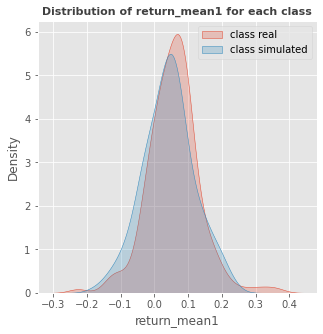

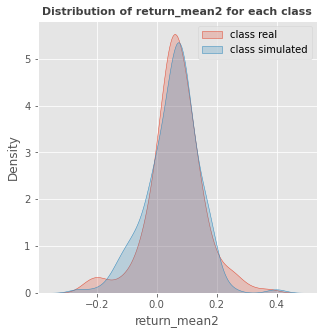

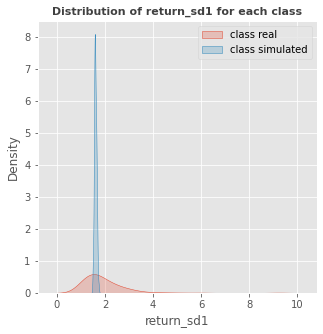

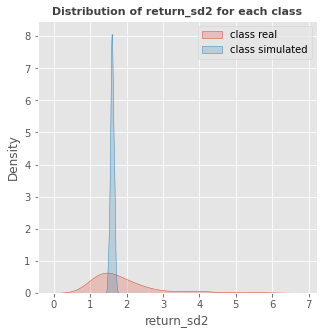

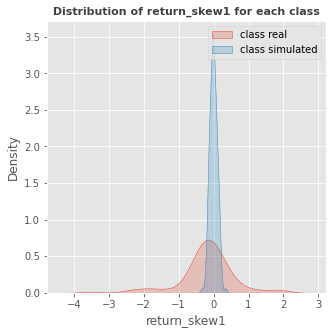

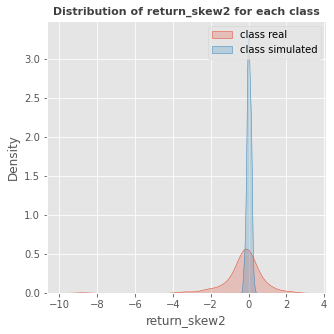

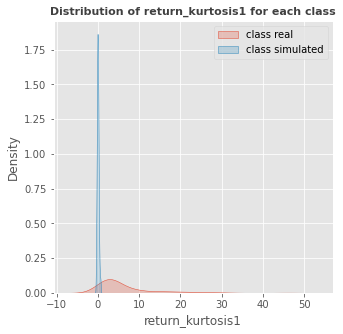

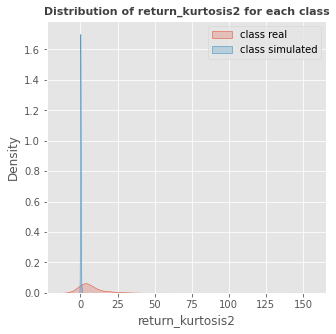

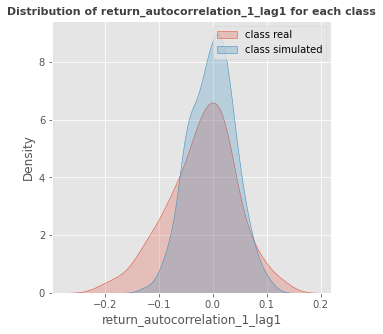

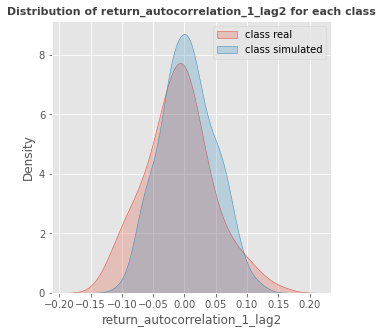

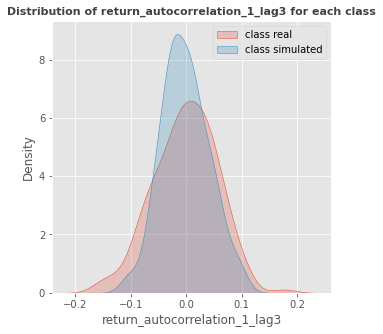

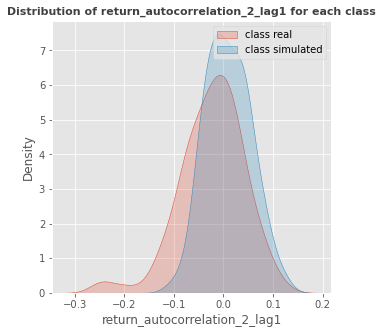

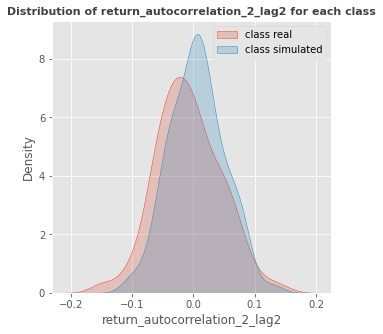

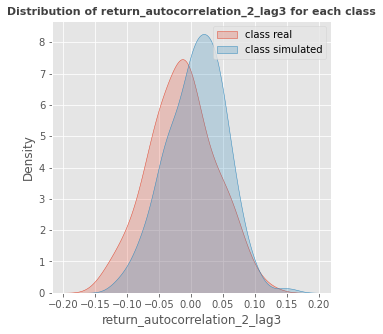

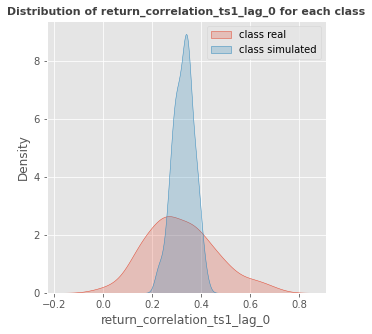

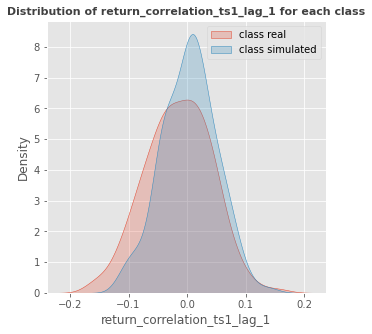

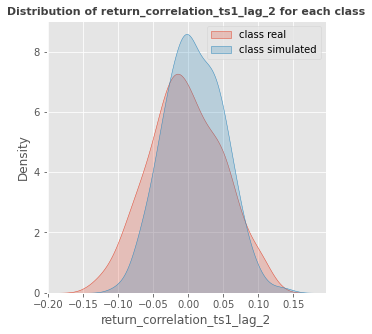

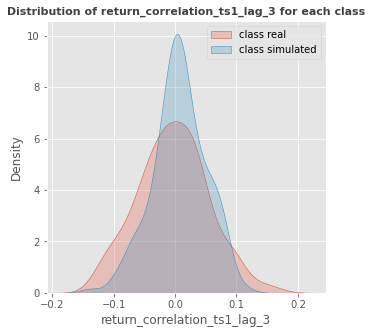

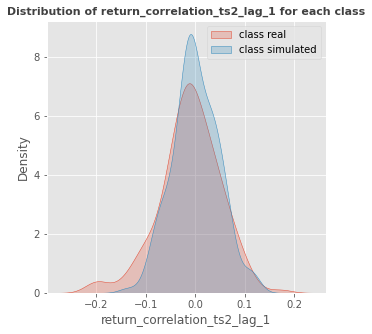

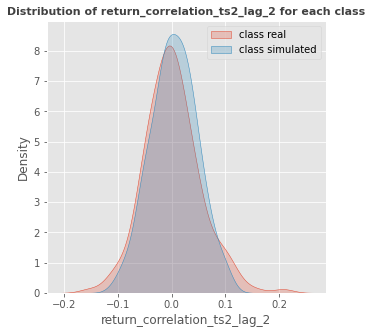

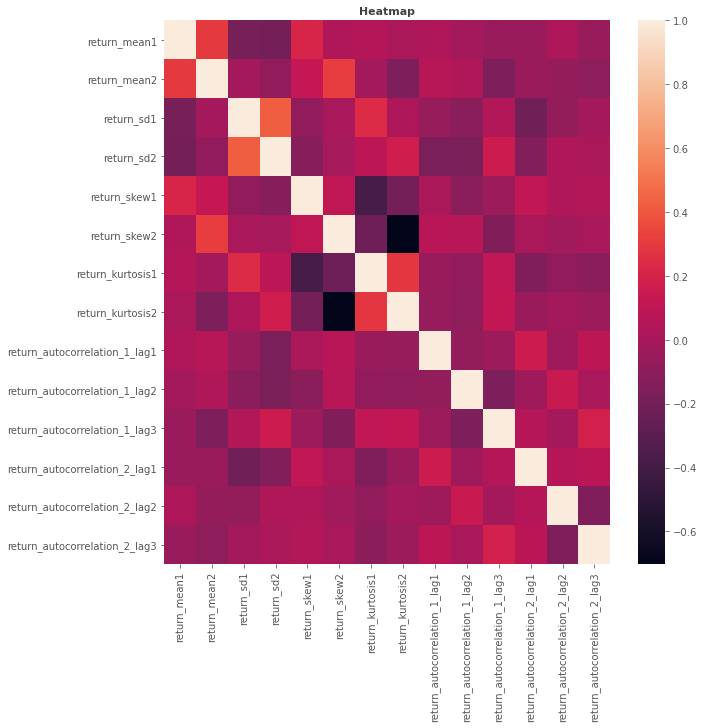

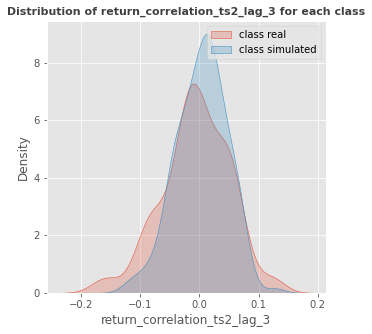

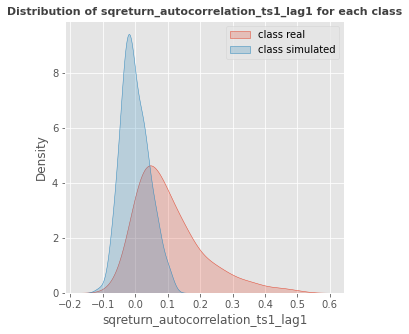

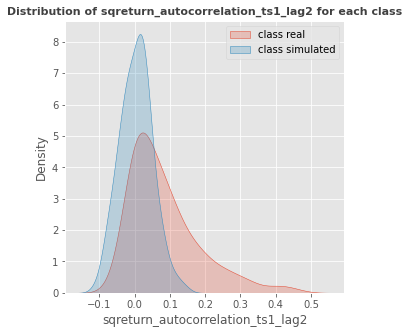

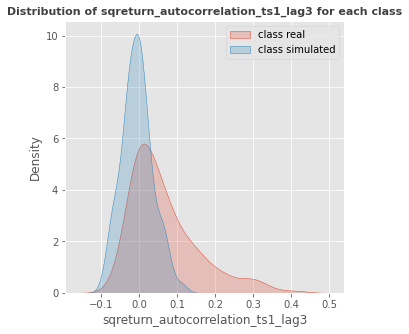

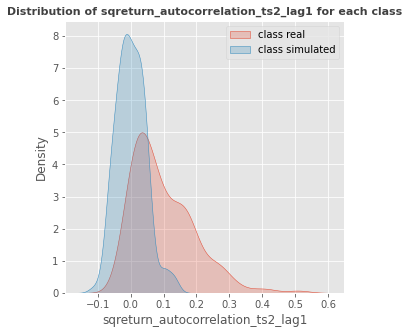

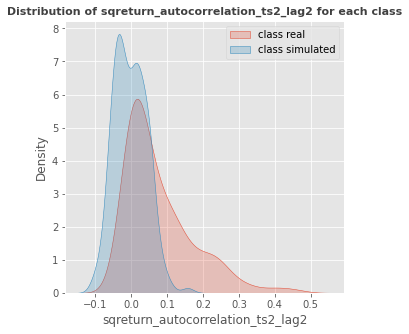

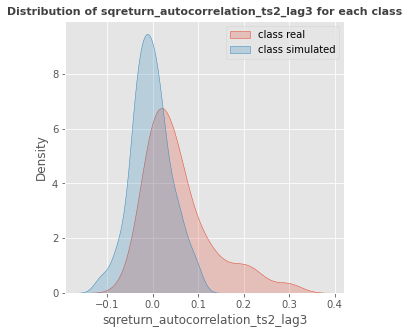

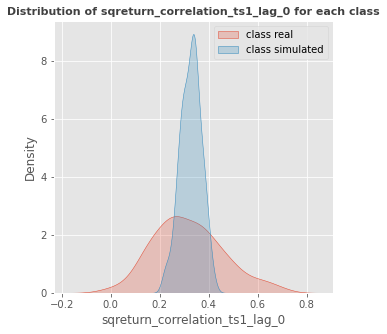

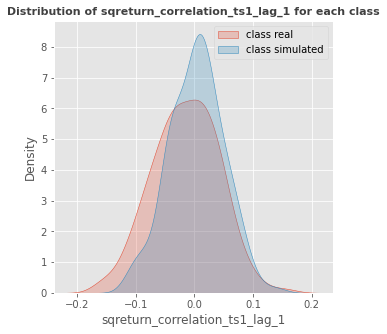

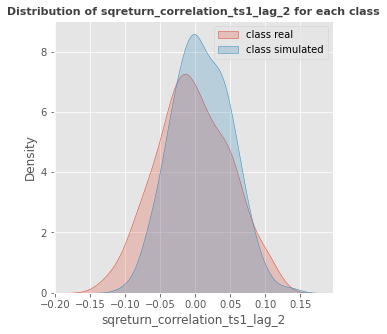

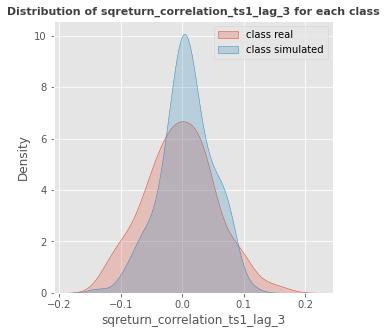

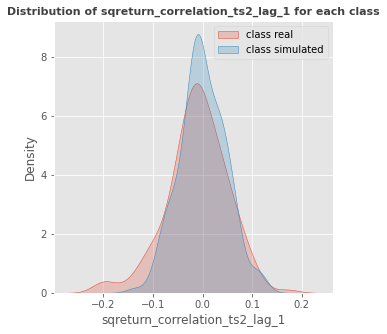

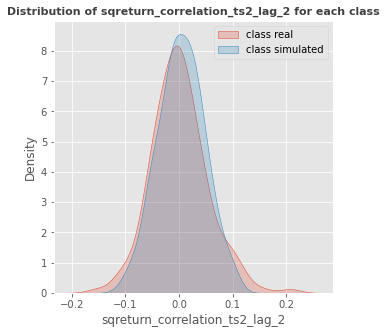

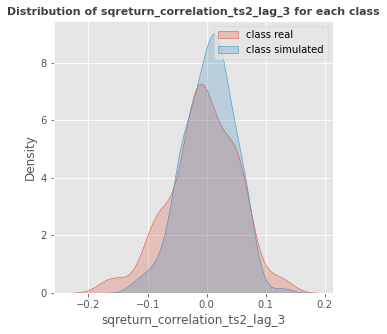

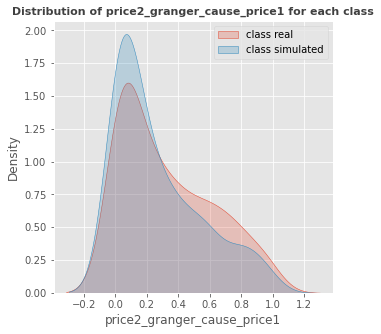

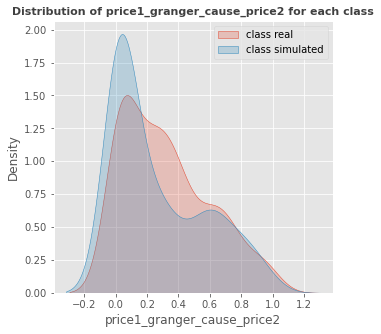

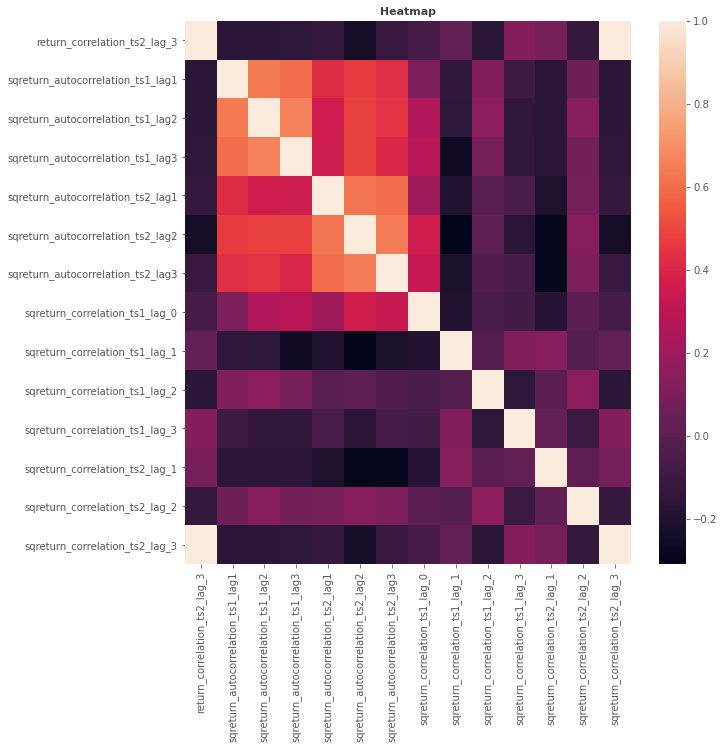

In [31]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")

In [3]:
import numpy as np
params = (( 0.18735315,  0.02420553,  0.70018295,  0.17695481, 
           -6.83798162, -1.37631389, -1.44219871, -2.51675177))
print('mu1')
print(params[0]/params[1])
print('kappa1')
print(params[1])
print('mu2')
print(params[2]/params[3])
print('kappa2')
print(params[3])
print('sigma11')
print(np.exp(params[4]))
print('sigma12')
print(np.exp(params[5]))
print('sigma21')
print(np.exp(params[6]))
print('sigma22')
print(np.exp(params[7]))

mu1
7.740096994364511
kappa1
0.02420553
mu2
3.9568461009904166
kappa2
0.17695481
sigma11
0.001072265456131167
sigma12
0.2525076105320386
sigma21
0.23640739552330398
sigma22
0.08072138298250442
